#### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 不均衡データの分類

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/imbalanced_data"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org で表示</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/structured_data/imbalanced_data.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab で実行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/structured_data/imbalanced_data.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub でソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/structured_data/imbalanced_data.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
</table>

このチュートリアルでは、1 つのクラスの例の数が他のクラスの例の数を大幅に上回る、非常に不均衡なデータセットを分類する方法を示します。Kaggle でホストされている[クレジットカード不正検出](https://www.kaggle.com/mlg-ulb/creditcardfraud)データセットを使用します。目的は、合計 284,807 件のトランザクションからわずか 492 件の不正なトランザクションを検出することです。[Keras](https://www.tensorflow.org/guide/keras/overview) を使用してモデルを定義し、[クラスの重み付け](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Model)を使用してモデルが不均衡なデータから学習できるようにします。

このチュートリアルには、次の完全なコードが含まれています。

- Pandas を使用して CSV ファイルを読み込む。
- トレーニングセット、検証セット、テストセットを作成する。
- Keras を使用してモデルの定義してトレーニングする（クラスの重みの設定を含む）。
- 様々なメトリクス（適合率や再現率を含む）を使用してモデルを評価する。
- 不均衡データを扱うための一般的なテクニックを試す。
    - クラスの重み付け
    - オーバーサンプリング


## Setup

In [2]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

2022-12-14 23:05:44.726441: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 23:05:44.726537: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 23:05:44.726547: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## データの処理と調査

### Kaggle Credit Card Fraud データセットをダウンロードする

[Pandas](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html#pandas.DataFrame) は、構造化データの読み込みと処理を支援するユーティリティが多数含まれる Python ライブラリです。Pandas を使用し、URL から CSV を Pandas [DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html#pandas.DataFrame) にダウンロードします。

注意: このデータセットは、Worldline と ULB (Université Libre de Bruxelles) の[機械学習グループ](http://mlg.ulb.ac.be)によるビッグデータマイニングと不正検出に関する共同研究で収集および分析されたものです。関連トピックに関する現在および過去のプロジェクトの詳細は、[こちら](https://www.researchgate.net/project/Fraud-detection-5)と [DefeatFraud](https://mlg.ulb.ac.be/wordpress/portfolio_page/defeatfraud-assessment-and-validation-of-deep-feature-engineering-and-learning-solutions-for-fraud-detection/) プロジェクトのページをご覧ください。

In [4]:
file = tf.keras.utils
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

In [5]:
raw_df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V26', 'V27', 'V28', 'Amount', 'Class']].describe()

Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5           V26           V27           V28         Amount  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  284807.000000   
mean   9.604066e-16  1.683437e-15 -3.660091e-16 -1.227390e-16      88.349619   
std    1.380247e+00  4.822270e-01  4.036325e-01  3.300833e-01     250.120109   
min   -1.137433e+02 -2.604551e+00 -2.256568e+01 -1.543008e+01       0.000000   
25%   -6.915971e-01 -3.269839e-01 -7.083953e-02 -5.295979e-02       5.600000   
50%   -5.433583e-02 -5.213911e-02  1.342146e-03  1.124383e-02      22.000000   
75%    6.119264e-01  2.409522e-01  9.104512e-02  7.827995e-02      77.165000   
max    3.480167e+01  3.517346e+00  3.161220e+01  3.384781e+01   25691.160000   

               Class  
count  284807.000000  
mean        0.001727  
std         0.041527  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000

### クラスラベルの不均衡を調べる

データセットの不均衡を見てみましょう。

In [6]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



これは、陽性サンプルの割合が少ないことを示しています。

### データをクリーニング、分割、正規化する

生データにはいくつかの問題があります。まず、`Time`カラムと`Amount`カラムはむらがあり過ぎてそのままでは使用できません。`Time`カラムは意味が明確ではないため削除し、`Amount`カラムのログを取って範囲を縮小します。

In [7]:
cleaned_df = raw_df.copy()

# You don't want the `Time` column.
cleaned_df.pop('Time')

# The `Amount` column covers a huge range. Convert to log-space.
eps = 0.001 # 0 => 0.1¢
cleaned_df['Log Amount'] = np.log(cleaned_df.pop('Amount')+eps)

データセットをトレーニングセット、検証セット、テストセットに分割します。検証セットはモデルを適合させる間に使用され、損失とメトリクスを評価しますが、モデルはこのデータに適合しません。テストセットはトレーニング段階では全く使用されず、モデルがどの程度新しいデータを一般化したかを評価するために最後にだけ使用されます。これはトレーニングデータ不足による[過学習](https://developers.google.com/machine-learning/crash-course/generalization/peril-of-overfitting)が重大な懸念事項である不均衡データセットでは特に重要です。

In [8]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

sklearn の StandardScaler を使用して入力特徴を正規化します。これで平均は 0、標準偏差は 1 に設定されます。

注意: `StandardScaler`は`train_features`を使用する場合にのみ適合し、モデルが検証セットやテストセットでピークを迎えることがないようにします。 

In [9]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)


Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


警告: モデルをデプロイする場合には、前処理の計算を保存することが非常に重要です。最も簡単なのは、それらをレイヤーとして実装し、エクスポート前にモデルに加える方法です。


### データ分散を確認する

次に、いくつかの特徴における陽性の例と陰性の例の分散を比較します。 この時点で自問すべき点は、次のとおりです。

- それらの分散には意味がありますか？
    - はい。入力を正規化したので、ほとんどが`+/- 2`の範囲内に集中しています。
- 分散間の差は見られますか？
    - はい。陽性の例には、はるかに高い極値が含まれています。

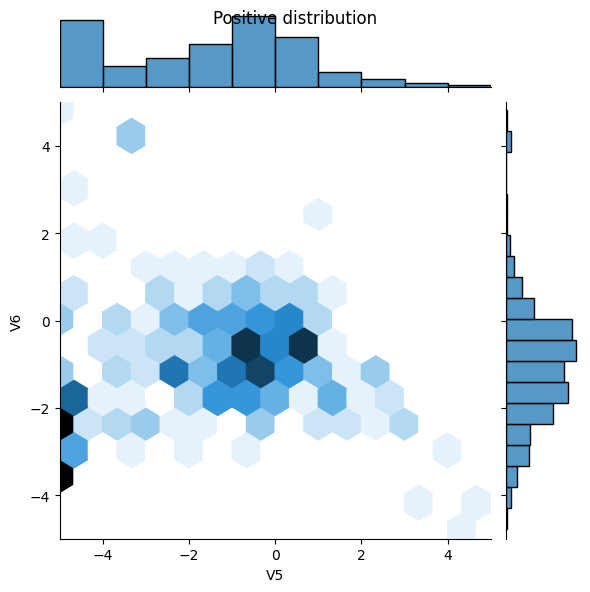

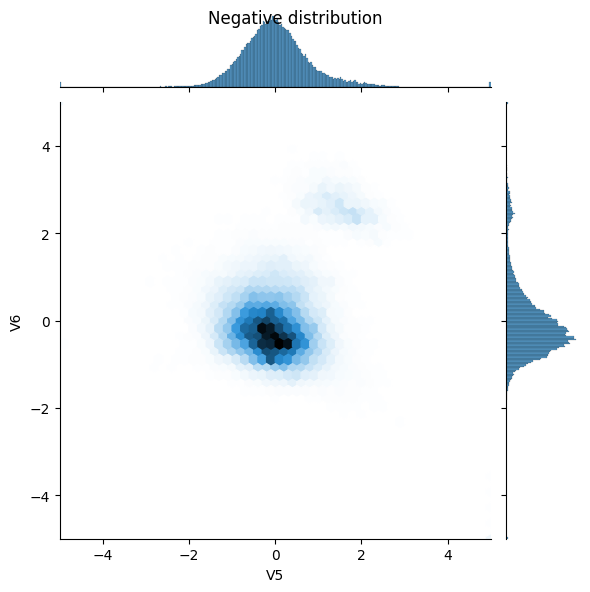

In [10]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(x=pos_df['V5'], y=pos_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(x=neg_df['V5'], y=neg_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

## モデルとメトリクスを定義する

密に接続された非表示レイヤー、過学習を防ぐ[ドロップアウト](https://developers.google.com/machine-learning/glossary/#dropout_regularization)レイヤー、取引が不正である確率を返す出力シグモイドレイヤーを持つ単純なニューラルネットワークを作成する関数を定義します。 

In [11]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

### 有用なメトリクスを理解する

上記で定義したメトリクスのいくつかは、モデルで計算できるため、パフォーマンス評価の際に有用なことに着目してください。

- **偽**陰性と**偽**陽性は**誤って**分類されたサンプルです。
- **真**陰性と**真**陽性は**正しく**分類されたサンプルです。
- **正解率**は正しく分類された例の割合です。

> $\frac{\text{true samples}}{\text{total samples}}$

- **適合率**は正しく分類された**予測**陽性の割合です。

> $\frac{\text{true positives}}{\text{true positives + false positives}}$

- **再現率**は正しく分類された**実際の**陽性の割合です。

> $\frac{\text{true positives}}{\text{true positives + false negatives}}$

- **AUC** は受信者動作特性曲線 (ROC-AUC) の曲線下の面積を指します。この指標は、分類器がランダムな正のサンプルをランダムな負のサンプルよりも高くランク付けする確率に等しくなります。
- **AUPRC** は適合率-再現率曲線の曲線下の面積を指します。この指標は、さまざまな確率しきい値の適合率と再現率のペアを計算します。

注意: 精度は、このタスクに役立つ指標ではありません。常に False を予測することで、このタスクの精度を 99.8％ 以上にすることができるからです。

詳細は以下を参照してください。

- [真陽性、偽陽性、偽陰性、真陰性](https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative)
- [正解度](https://developers.google.com/machine-learning/crash-course/classification/accuracy)
- [適合率と再現率](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall)
- [ROC-AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
- [適合率-再現率と ROC 曲線の関係](https://www.biostat.wisc.edu/~page/rocpr.pdf)

## ベースラインモデル

### モデルを構築する

次に、前に定義した関数を使用してモデルを作成し、トレーニングします。モデルはデフォルトよりも大きいバッチサイズ 2048 を使って適合されていることに注目してください。これは、各バッチに必ずいくつかの陽性サンプルが含まれるようにするために重要です。もし、バッチサイズが小さすぎると、学習できる不正取引が全くないという可能性があります。

注意: このモデルはクラスの不均衡をうまく処理できません。後ほどこのチュートリアル内で改善します。

In [12]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [13]:
model = make_model()
model.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense (Dense)               (None, 16)                480       


 dropout (Dropout)           (None, 16)                0         


 dense_1 (Dense)             (None, 1)                 17        


Total params: 497


Trainable params: 497


Non-trainable params: 0


_________________________________________________________________


モデルをテスト実行します。

In [14]:
model.predict(train_features[:10])

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 433ms/step


array([[0.32376227],
       [0.410775  ],
       [0.78519666],
       [0.8071737 ],
       [0.24630985],
       [0.43201268],
       [0.14502314],
       [0.4868623 ],
       [0.392316  ],
       [0.38101035]], dtype=float32)

### オプション: 正しい初期バイアスを設定する

これら初期の推測はあまり良いとは言えません。データセットは不均衡であることが分かっています。それを反映できるように、出力レイヤーのバイアスを設定します。（参照: [ニューラルネットワークのトレーニングのレシピ: 「init well」](http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines)）これは初期収束に有用です。

デフォルトのバイアス初期化では、損失は`math.log(2) = 0.69314`程度になります。 

In [15]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.5587


設定する正しいバイアスは、以下から導き出すことができます。

$$ p_0 = pos/(pos + neg) = 1/(1+e^{-b_0}) $$ $$ b_0 = -log_e(1/p_0 - 1) $$ $$ b_0 = log_e(pos/neg)$$

In [16]:
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

それを初期バイアスとして設定すると、モデルははるかに合理的な初期推測ができるようになります。

これは`pos/total = 0.0018`に近い値になるはずです。

In [17]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 45ms/step


array([[0.00103091],
       [0.00088367],
       [0.00175426],
       [0.00091999],
       [0.00124022],
       [0.00087101],
       [0.00024934],
       [0.00167472],
       [0.00049   ],
       [0.00128492]], dtype=float32)

この初期化では、初期損失はおおよそ次のようになります。

$$-p_0log(p_0)-(1-p_0)log(1-p_0) = 0.01317$$

In [18]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0148


この初期の損失は、単純な初期化を行った場合の約 50 分の 1 です。

この方法だと、陽性の例がないことを学習するだけのためにモデルが最初の数エポックを費やす必要がありません。また、これによって、トレーニング中の損失のプロットが読みやすくなります。

### 初期の重みをチェックポイントする

さまざまなトレーニングの実行を比較しやすくするために、この初期モデルの重みをチェックポイントファイルに保持し、トレーニングの前に各モデルにロードします。

In [19]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

### バイアス修正が有効であることを確認する

先に進む前に、慎重なバイアス初期化が実際に役立ったかどうかを素早く確認します。

この慎重な初期化を行った場合と行わなかった場合でモデルを 20 エポックトレーニングしてから損失を比較します。 

In [20]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [21]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [22]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

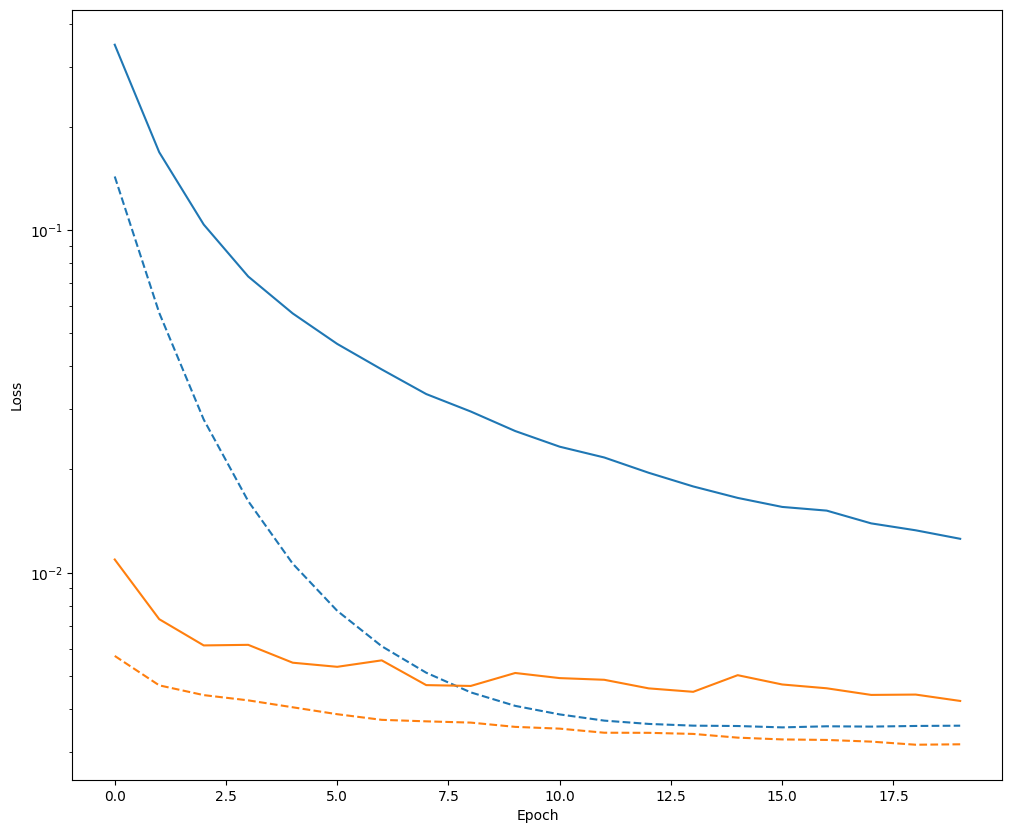

In [23]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

上の図を見れば一目瞭然ですが、検証損失に関しては、この問題ではこのように慎重に初期化することによって、明確なアドバンテージを得ることができます。 

### モデルをトレーニングする

In [24]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100


 1/90 [..............................] - ETA: 2:01 - loss: 0.0117 - tp: 50.0000 - fp: 7.0000 - tn: 47538.0000 - fn: 22.0000 - accuracy: 0.9994 - precision: 0.8772 - recall: 0.6944 - auc: 0.9020 - prc: 0.7246

13/90 [===>..........................] - ETA: 0s - loss: 0.0106 - tp: 50.0000 - fp: 19.0000 - tn: 72073.0000 - fn: 51.0000 - accuracy: 0.9990 - precision: 0.7246 - recall: 0.4950 - auc: 0.8369 - prc: 0.5056 

26/90 [=======>......................] - ETA: 0s - loss: 0.0148 - tp: 54.0000 - fp: 27.0000 - tn: 98624.0000 - fn: 112.0000 - accuracy: 0.9986 - precision: 0.6667 - recall: 0.3253 - auc: 0.7691 - prc: 0.3432

39/90 [============>.................] - ETA: 0s - loss: 0.0137 - tp: 61.0000 - fp: 35.0000 - tn: 125194.0000 - fn: 151.0000 - accuracy: 0.9985 - precision: 0.6354 - recall: 0.2877 - auc: 0.7550 - prc: 0.3022

52/90 [================>.............] - ETA: 0s - loss: 0.0135 - tp: 73.0000 - fp: 39.0000 - tn: 151751.0000 - fn: 202.0000 - accuracy: 0.9984 - precision: 0.6518 - recall: 0.2655 - auc: 0.7613 - prc: 0.2927

65/90 [====================>.........] - ETA: 0s - loss: 0.0124 - tp: 85.0000 - fp: 44.0000 - tn: 178324.0000 - fn: 236.0000 - accuracy: 0.9984 - precision: 0.6589 - recall: 0.2648 - auc: 0.7723 - prc: 0.3013

78/90 [=========================>....] - ETA: 0s - loss: 0.0114 - tp: 93.0000 - fp: 46.0000 - tn: 204910.0000 - fn: 264.0000 - accuracy: 0.9985 - precision: 0.6691 - recall: 0.2605 - auc: 0.7846 - prc: 0.3099

90/90 [==============================] - 2s 11ms/step - loss: 0.0109 - tp: 106.0000 - fp: 56.0000 - tn: 227398.0000 - fn: 285.0000 - accuracy: 0.9985 - precision: 0.6543 - recall: 0.2711 - auc: 0.7874 - prc: 0.3099 - val_loss: 0.0056 - val_tp: 20.0000 - val_fp: 4.0000 - val_tn: 45496.0000 - val_fn: 49.0000 - val_accuracy: 0.9988 - val_precision: 0.8333 - val_recall: 0.2899 - val_auc: 0.8831 - val_prc: 0.6267


Epoch 2/100


 1/90 [..............................] - ETA: 0s - loss: 0.0050 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.3333 - auc: 0.9910 - prc: 0.5471

14/90 [===>..........................] - ETA: 0s - loss: 0.0063 - tp: 16.0000 - fp: 3.0000 - tn: 28621.0000 - fn: 32.0000 - accuracy: 0.9988 - precision: 0.8421 - recall: 0.3333 - auc: 0.9110 - prc: 0.4808 

27/90 [========>.....................] - ETA: 0s - loss: 0.0062 - tp: 31.0000 - fp: 9.0000 - tn: 55198.0000 - fn: 58.0000 - accuracy: 0.9988 - precision: 0.7750 - recall: 0.3483 - auc: 0.9052 - prc: 0.4644

41/90 [============>.................] - ETA: 0s - loss: 0.0063 - tp: 59.0000 - fp: 9.0000 - tn: 83815.0000 - fn: 85.0000 - accuracy: 0.9989 - precision: 0.8676 - recall: 0.4097 - auc: 0.8875 - prc: 0.5392

54/90 [=================>............] - ETA: 0s - loss: 0.0070 - tp: 74.0000 - fp: 12.0000 - tn: 110381.0000 - fn: 125.0000 - accuracy: 0.9988 - precision: 0.8605 - recall: 0.3719 - auc: 0.8717 - prc: 0.5017

66/90 [=====================>........] - ETA: 0s - loss: 0.0071 - tp: 97.0000 - fp: 17.0000 - tn: 134905.0000 - fn: 149.0000 - accuracy: 0.9988 - precision: 0.8509 - recall: 0.3943 - auc: 0.8668 - prc: 0.4993

77/90 [========================>.....] - ETA: 0s - loss: 0.0072 - tp: 112.0000 - fp: 23.0000 - tn: 157394.0000 - fn: 167.0000 - accuracy: 0.9988 - precision: 0.8296 - recall: 0.4014 - auc: 0.8567 - prc: 0.4817

89/90 [============================>.] - ETA: 0s - loss: 0.0073 - tp: 126.0000 - fp: 27.0000 - tn: 181923.0000 - fn: 196.0000 - accuracy: 0.9988 - precision: 0.8235 - recall: 0.3913 - auc: 0.8536 - prc: 0.4774

90/90 [==============================] - 1s 6ms/step - loss: 0.0073 - tp: 126.0000 - fp: 27.0000 - tn: 181927.0000 - fn: 196.0000 - accuracy: 0.9988 - precision: 0.8235 - recall: 0.3913 - auc: 0.8536 - prc: 0.4774 - val_loss: 0.0048 - val_tp: 29.0000 - val_fp: 8.0000 - val_tn: 45492.0000 - val_fn: 40.0000 - val_accuracy: 0.9989 - val_precision: 0.7838 - val_recall: 0.4203 - val_auc: 0.8837 - val_prc: 0.6447


Epoch 3/100


 1/90 [..............................] - ETA: 0s - loss: 0.0011 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2048.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - prc: 0.0000e+00

14/90 [===>..........................] - ETA: 0s - loss: 0.0069 - tp: 19.0000 - fp: 4.0000 - tn: 28622.0000 - fn: 27.0000 - accuracy: 0.9989 - precision: 0.8261 - recall: 0.4130 - auc: 0.8110 - prc: 0.4759                         

27/90 [========>.....................] - ETA: 0s - loss: 0.0063 - tp: 44.0000 - fp: 8.0000 - tn: 55196.0000 - fn: 48.0000 - accuracy: 0.9990 - precision: 0.8462 - recall: 0.4783 - auc: 0.8499 - prc: 0.5731

40/90 [============>.................] - ETA: 0s - loss: 0.0061 - tp: 69.0000 - fp: 11.0000 - tn: 81769.0000 - fn: 71.0000 - accuracy: 0.9990 - precision: 0.8625 - recall: 0.4929 - auc: 0.8794 - prc: 0.5989

53/90 [================>.............] - ETA: 0s - loss: 0.0062 - tp: 93.0000 - fp: 16.0000 - tn: 108337.0000 - fn: 98.0000 - accuracy: 0.9989 - precision: 0.8532 - recall: 0.4869 - auc: 0.8742 - prc: 0.6012

66/90 [=====================>........] - ETA: 0s - loss: 0.0062 - tp: 123.0000 - fp: 18.0000 - tn: 134907.0000 - fn: 120.0000 - accuracy: 0.9990 - precision: 0.8723 - recall: 0.5062 - auc: 0.8780 - prc: 0.6162

80/90 [=========================>....] - ETA: 0s - loss: 0.0062 - tp: 149.0000 - fp: 20.0000 - tn: 163526.0000 - fn: 145.0000 - accuracy: 0.9990 - precision: 0.8817 - recall: 0.5068 - auc: 0.8783 - prc: 0.6130

90/90 [==============================] - 0s 5ms/step - loss: 0.0061 - tp: 163.0000 - fp: 22.0000 - tn: 181932.0000 - fn: 159.0000 - accuracy: 0.9990 - precision: 0.8811 - recall: 0.5062 - auc: 0.8777 - prc: 0.6132 - val_loss: 0.0044 - val_tp: 34.0000 - val_fp: 8.0000 - val_tn: 45492.0000 - val_fn: 35.0000 - val_accuracy: 0.9991 - val_precision: 0.8095 - val_recall: 0.4928 - val_auc: 0.8838 - val_prc: 0.6321


Epoch 4/100


 1/90 [..............................] - ETA: 0s - loss: 0.0103 - tp: 3.0000 - fp: 1.0000 - tn: 2041.0000 - fn: 3.0000 - accuracy: 0.9980 - precision: 0.7500 - recall: 0.5000 - auc: 0.8309 - prc: 0.6325

14/90 [===>..........................] - ETA: 0s - loss: 0.0051 - tp: 31.0000 - fp: 4.0000 - tn: 28616.0000 - fn: 21.0000 - accuracy: 0.9991 - precision: 0.8857 - recall: 0.5962 - auc: 0.9023 - prc: 0.7162

27/90 [========>.....................] - ETA: 0s - loss: 0.0054 - tp: 49.0000 - fp: 7.0000 - tn: 55195.0000 - fn: 45.0000 - accuracy: 0.9991 - precision: 0.8750 - recall: 0.5213 - auc: 0.8811 - prc: 0.6535

40/90 [============>.................] - ETA: 0s - loss: 0.0055 - tp: 71.0000 - fp: 14.0000 - tn: 81766.0000 - fn: 69.0000 - accuracy: 0.9990 - precision: 0.8353 - recall: 0.5071 - auc: 0.8947 - prc: 0.6442

53/90 [================>.............] - ETA: 0s - loss: 0.0057 - tp: 92.0000 - fp: 17.0000 - tn: 108337.0000 - fn: 98.0000 - accuracy: 0.9989 - precision: 0.8440 - recall: 0.4842 - auc: 0.8929 - prc: 0.6349

66/90 [=====================>........] - ETA: 0s - loss: 0.0057 - tp: 118.0000 - fp: 24.0000 - tn: 134911.0000 - fn: 115.0000 - accuracy: 0.9990 - precision: 0.8310 - recall: 0.5064 - auc: 0.8952 - prc: 0.6259

80/90 [=========================>....] - ETA: 0s - loss: 0.0056 - tp: 144.0000 - fp: 29.0000 - tn: 163526.0000 - fn: 141.0000 - accuracy: 0.9990 - precision: 0.8324 - recall: 0.5053 - auc: 0.9019 - prc: 0.6415

90/90 [==============================] - 0s 5ms/step - loss: 0.0058 - tp: 158.0000 - fp: 33.0000 - tn: 181921.0000 - fn: 164.0000 - accuracy: 0.9989 - precision: 0.8272 - recall: 0.4907 - auc: 0.8958 - prc: 0.6258 - val_loss: 0.0042 - val_tp: 41.0000 - val_fp: 8.0000 - val_tn: 45492.0000 - val_fn: 28.0000 - val_accuracy: 0.9992 - val_precision: 0.8367 - val_recall: 0.5942 - val_auc: 0.8910 - val_prc: 0.6413


Epoch 5/100


 1/90 [..............................] - ETA: 0s - loss: 0.0064 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2042.0000 - fn: 3.0000 - accuracy: 0.9985 - precision: 1.0000 - recall: 0.5000 - auc: 0.9156 - prc: 0.8352

14/90 [===>..........................] - ETA: 0s - loss: 0.0054 - tp: 31.0000 - fp: 4.0000 - tn: 28609.0000 - fn: 28.0000 - accuracy: 0.9989 - precision: 0.8857 - recall: 0.5254 - auc: 0.9392 - prc: 0.7050 

28/90 [========>.....................] - ETA: 0s - loss: 0.0060 - tp: 55.0000 - fp: 9.0000 - tn: 57222.0000 - fn: 58.0000 - accuracy: 0.9988 - precision: 0.8594 - recall: 0.4867 - auc: 0.9186 - prc: 0.6465

42/90 [=============>................] - ETA: 0s - loss: 0.0051 - tp: 81.0000 - fp: 14.0000 - tn: 85851.0000 - fn: 70.0000 - accuracy: 0.9990 - precision: 0.8526 - recall: 0.5364 - auc: 0.9290 - prc: 0.6706

56/90 [=================>............] - ETA: 0s - loss: 0.0051 - tp: 107.0000 - fp: 21.0000 - tn: 114473.0000 - fn: 87.0000 - accuracy: 0.9991 - precision: 0.8359 - recall: 0.5515 - auc: 0.9238 - prc: 0.6501

70/90 [======================>.......] - ETA: 0s - loss: 0.0055 - tp: 133.0000 - fp: 28.0000 - tn: 143082.0000 - fn: 117.0000 - accuracy: 0.9990 - precision: 0.8261 - recall: 0.5320 - auc: 0.9125 - prc: 0.6386

84/90 [===========================>..] - ETA: 0s - loss: 0.0055 - tp: 160.0000 - fp: 33.0000 - tn: 171695.0000 - fn: 144.0000 - accuracy: 0.9990 - precision: 0.8290 - recall: 0.5263 - auc: 0.9081 - prc: 0.6419

90/90 [==============================] - 0s 5ms/step - loss: 0.0055 - tp: 170.0000 - fp: 36.0000 - tn: 181918.0000 - fn: 152.0000 - accuracy: 0.9990 - precision: 0.8252 - recall: 0.5280 - auc: 0.9085 - prc: 0.6395 - val_loss: 0.0040 - val_tp: 42.0000 - val_fp: 8.0000 - val_tn: 45492.0000 - val_fn: 27.0000 - val_accuracy: 0.9992 - val_precision: 0.8400 - val_recall: 0.6087 - val_auc: 0.8983 - val_prc: 0.6740


Epoch 6/100


 1/90 [..............................] - ETA: 0s - loss: 0.0026 - tp: 2.0000 - fp: 1.0000 - tn: 2044.0000 - fn: 1.0000 - accuracy: 0.9990 - precision: 0.6667 - recall: 0.6667 - auc: 0.9997 - prc: 0.7690

14/90 [===>..........................] - ETA: 0s - loss: 0.0045 - tp: 32.0000 - fp: 2.0000 - tn: 28615.0000 - fn: 23.0000 - accuracy: 0.9991 - precision: 0.9412 - recall: 0.5818 - auc: 0.9262 - prc: 0.7382

27/90 [========>.....................] - ETA: 0s - loss: 0.0049 - tp: 63.0000 - fp: 5.0000 - tn: 55179.0000 - fn: 49.0000 - accuracy: 0.9990 - precision: 0.9265 - recall: 0.5625 - auc: 0.9185 - prc: 0.7274

41/90 [============>.................] - ETA: 0s - loss: 0.0052 - tp: 91.0000 - fp: 9.0000 - tn: 83790.0000 - fn: 78.0000 - accuracy: 0.9990 - precision: 0.9100 - recall: 0.5385 - auc: 0.9071 - prc: 0.7100

55/90 [=================>............] - ETA: 0s - loss: 0.0047 - tp: 113.0000 - fp: 14.0000 - tn: 112417.0000 - fn: 96.0000 - accuracy: 0.9990 - precision: 0.8898 - recall: 0.5407 - auc: 0.9151 - prc: 0.7103

69/90 [======================>.......] - ETA: 0s - loss: 0.0051 - tp: 135.0000 - fp: 23.0000 - tn: 141035.0000 - fn: 119.0000 - accuracy: 0.9990 - precision: 0.8544 - recall: 0.5315 - auc: 0.9141 - prc: 0.6625

83/90 [==========================>...] - ETA: 0s - loss: 0.0052 - tp: 164.0000 - fp: 29.0000 - tn: 169649.0000 - fn: 142.0000 - accuracy: 0.9990 - precision: 0.8497 - recall: 0.5359 - auc: 0.9105 - prc: 0.6607

90/90 [==============================] - 0s 5ms/step - loss: 0.0053 - tp: 172.0000 - fp: 31.0000 - tn: 181923.0000 - fn: 150.0000 - accuracy: 0.9990 - precision: 0.8473 - recall: 0.5342 - auc: 0.9071 - prc: 0.6464 - val_loss: 0.0039 - val_tp: 42.0000 - val_fp: 8.0000 - val_tn: 45492.0000 - val_fn: 27.0000 - val_accuracy: 0.9992 - val_precision: 0.8400 - val_recall: 0.6087 - val_auc: 0.8982 - val_prc: 0.6779


Epoch 7/100


 1/90 [..............................] - ETA: 0s - loss: 0.0031 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.7500 - auc: 0.9991 - prc: 0.8372

14/90 [===>..........................] - ETA: 0s - loss: 0.0059 - tp: 34.0000 - fp: 8.0000 - tn: 28608.0000 - fn: 22.0000 - accuracy: 0.9990 - precision: 0.8095 - recall: 0.6071 - auc: 0.9362 - prc: 0.6302 

28/90 [========>.....................] - ETA: 0s - loss: 0.0052 - tp: 59.0000 - fp: 10.0000 - tn: 57231.0000 - fn: 44.0000 - accuracy: 0.9991 - precision: 0.8551 - recall: 0.5728 - auc: 0.9260 - prc: 0.6603

42/90 [=============>................] - ETA: 0s - loss: 0.0052 - tp: 88.0000 - fp: 14.0000 - tn: 85844.0000 - fn: 70.0000 - accuracy: 0.9990 - precision: 0.8627 - recall: 0.5570 - auc: 0.9198 - prc: 0.6748

56/90 [=================>............] - ETA: 0s - loss: 0.0051 - tp: 114.0000 - fp: 22.0000 - tn: 114461.0000 - fn: 91.0000 - accuracy: 0.9990 - precision: 0.8382 - recall: 0.5561 - auc: 0.9233 - prc: 0.6636

70/90 [======================>.......] - ETA: 0s - loss: 0.0050 - tp: 141.0000 - fp: 27.0000 - tn: 143083.0000 - fn: 109.0000 - accuracy: 0.9991 - precision: 0.8393 - recall: 0.5640 - auc: 0.9189 - prc: 0.6652

83/90 [==========================>...] - ETA: 0s - loss: 0.0051 - tp: 164.0000 - fp: 30.0000 - tn: 169655.0000 - fn: 135.0000 - accuracy: 0.9990 - precision: 0.8454 - recall: 0.5485 - auc: 0.9153 - prc: 0.6621

90/90 [==============================] - 0s 5ms/step - loss: 0.0051 - tp: 172.0000 - fp: 31.0000 - tn: 181923.0000 - fn: 150.0000 - accuracy: 0.9990 - precision: 0.8473 - recall: 0.5342 - auc: 0.9135 - prc: 0.6628 - val_loss: 0.0038 - val_tp: 46.0000 - val_fp: 8.0000 - val_tn: 45492.0000 - val_fn: 23.0000 - val_accuracy: 0.9993 - val_precision: 0.8519 - val_recall: 0.6667 - val_auc: 0.8982 - val_prc: 0.6813


Epoch 8/100


 1/90 [..............................] - ETA: 0s - loss: 0.0029 - tp: 1.0000 - fp: 1.0000 - tn: 2043.0000 - fn: 3.0000 - accuracy: 0.9980 - precision: 0.5000 - recall: 0.2500 - auc: 0.9996 - prc: 0.7709

14/90 [===>..........................] - ETA: 0s - loss: 0.0047 - tp: 25.0000 - fp: 7.0000 - tn: 28615.0000 - fn: 25.0000 - accuracy: 0.9989 - precision: 0.7812 - recall: 0.5000 - auc: 0.9091 - prc: 0.6623

27/90 [========>.....................] - ETA: 0s - loss: 0.0051 - tp: 50.0000 - fp: 12.0000 - tn: 55194.0000 - fn: 40.0000 - accuracy: 0.9991 - precision: 0.8065 - recall: 0.5556 - auc: 0.9045 - prc: 0.6065

40/90 [============>.................] - ETA: 0s - loss: 0.0054 - tp: 72.0000 - fp: 14.0000 - tn: 81768.0000 - fn: 66.0000 - accuracy: 0.9990 - precision: 0.8372 - recall: 0.5217 - auc: 0.9010 - prc: 0.6066

53/90 [================>.............] - ETA: 0s - loss: 0.0052 - tp: 108.0000 - fp: 17.0000 - tn: 108329.0000 - fn: 90.0000 - accuracy: 0.9990 - precision: 0.8640 - recall: 0.5455 - auc: 0.9131 - prc: 0.6619

66/90 [=====================>........] - ETA: 0s - loss: 0.0050 - tp: 129.0000 - fp: 21.0000 - tn: 134912.0000 - fn: 106.0000 - accuracy: 0.9991 - precision: 0.8600 - recall: 0.5489 - auc: 0.9117 - prc: 0.6673

79/90 [=========================>....] - ETA: 0s - loss: 0.0051 - tp: 148.0000 - fp: 24.0000 - tn: 161487.0000 - fn: 133.0000 - accuracy: 0.9990 - precision: 0.8605 - recall: 0.5267 - auc: 0.9118 - prc: 0.6602

90/90 [==============================] - 0s 5ms/step - loss: 0.0054 - tp: 171.0000 - fp: 28.0000 - tn: 181926.0000 - fn: 151.0000 - accuracy: 0.9990 - precision: 0.8593 - recall: 0.5311 - auc: 0.9073 - prc: 0.6439 - val_loss: 0.0037 - val_tp: 46.0000 - val_fp: 8.0000 - val_tn: 45492.0000 - val_fn: 23.0000 - val_accuracy: 0.9993 - val_precision: 0.8519 - val_recall: 0.6667 - val_auc: 0.8981 - val_prc: 0.6888


Epoch 9/100


 1/90 [..............................] - ETA: 0s - loss: 8.8972e-04 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

14/90 [===>..........................] - ETA: 0s - loss: 0.0032 - tp: 26.0000 - fp: 5.0000 - tn: 28621.0000 - fn: 20.0000 - accuracy: 0.9991 - precision: 0.8387 - recall: 0.5652 - auc: 0.9670 - prc: 0.8315         

27/90 [========>.....................] - ETA: 0s - loss: 0.0043 - tp: 66.0000 - fp: 11.0000 - tn: 55182.0000 - fn: 37.0000 - accuracy: 0.9991 - precision: 0.8571 - recall: 0.6408 - auc: 0.9557 - prc: 0.7457

41/90 [============>.................] - ETA: 0s - loss: 0.0042 - tp: 89.0000 - fp: 16.0000 - tn: 83809.0000 - fn: 54.0000 - accuracy: 0.9992 - precision: 0.8476 - recall: 0.6224 - auc: 0.9433 - prc: 0.7201

54/90 [=================>............] - ETA: 0s - loss: 0.0043 - tp: 117.0000 - fp: 21.0000 - tn: 110384.0000 - fn: 70.0000 - accuracy: 0.9992 - precision: 0.8478 - recall: 0.6257 - auc: 0.9430 - prc: 0.7060

67/90 [=====================>........] - ETA: 0s - loss: 0.0049 - tp: 139.0000 - fp: 23.0000 - tn: 136950.0000 - fn: 104.0000 - accuracy: 0.9991 - precision: 0.8580 - recall: 0.5720 - auc: 0.9250 - prc: 0.6797

81/90 [==========================>...] - ETA: 0s - loss: 0.0051 - tp: 164.0000 - fp: 28.0000 - tn: 165567.0000 - fn: 129.0000 - accuracy: 0.9991 - precision: 0.8542 - recall: 0.5597 - auc: 0.9171 - prc: 0.6691

90/90 [==============================] - 0s 5ms/step - loss: 0.0051 - tp: 179.0000 - fp: 33.0000 - tn: 181921.0000 - fn: 143.0000 - accuracy: 0.9990 - precision: 0.8443 - recall: 0.5559 - auc: 0.9167 - prc: 0.6665 - val_loss: 0.0036 - val_tp: 46.0000 - val_fp: 8.0000 - val_tn: 45492.0000 - val_fn: 23.0000 - val_accuracy: 0.9993 - val_precision: 0.8519 - val_recall: 0.6667 - val_auc: 0.8981 - val_prc: 0.7000


Epoch 10/100


 1/90 [..............................] - ETA: 0s - loss: 0.0124 - tp: 2.0000 - fp: 2.0000 - tn: 2043.0000 - fn: 1.0000 - accuracy: 0.9985 - precision: 0.5000 - recall: 0.6667 - auc: 0.8315 - prc: 0.3099

14/90 [===>..........................] - ETA: 0s - loss: 0.0042 - tp: 22.0000 - fp: 6.0000 - tn: 28630.0000 - fn: 14.0000 - accuracy: 0.9993 - precision: 0.7857 - recall: 0.6111 - auc: 0.9296 - prc: 0.6164

27/90 [========>.....................] - ETA: 0s - loss: 0.0047 - tp: 48.0000 - fp: 9.0000 - tn: 55197.0000 - fn: 42.0000 - accuracy: 0.9991 - precision: 0.8421 - recall: 0.5333 - auc: 0.9157 - prc: 0.6562

40/90 [============>.................] - ETA: 0s - loss: 0.0046 - tp: 71.0000 - fp: 17.0000 - tn: 81768.0000 - fn: 64.0000 - accuracy: 0.9990 - precision: 0.8068 - recall: 0.5259 - auc: 0.9325 - prc: 0.6755

53/90 [================>.............] - ETA: 0s - loss: 0.0043 - tp: 97.0000 - fp: 22.0000 - tn: 108345.0000 - fn: 80.0000 - accuracy: 0.9991 - precision: 0.8151 - recall: 0.5480 - auc: 0.9370 - prc: 0.6842

66/90 [=====================>........] - ETA: 0s - loss: 0.0045 - tp: 129.0000 - fp: 24.0000 - tn: 134913.0000 - fn: 102.0000 - accuracy: 0.9991 - precision: 0.8431 - recall: 0.5584 - auc: 0.9298 - prc: 0.6912

79/90 [=========================>....] - ETA: 0s - loss: 0.0045 - tp: 153.0000 - fp: 26.0000 - tn: 161489.0000 - fn: 124.0000 - accuracy: 0.9991 - precision: 0.8547 - recall: 0.5523 - auc: 0.9251 - prc: 0.6902

90/90 [==============================] - 0s 5ms/step - loss: 0.0048 - tp: 171.0000 - fp: 28.0000 - tn: 181926.0000 - fn: 151.0000 - accuracy: 0.9990 - precision: 0.8593 - recall: 0.5311 - auc: 0.9151 - prc: 0.6786 - val_loss: 0.0036 - val_tp: 48.0000 - val_fp: 9.0000 - val_tn: 45491.0000 - val_fn: 21.0000 - val_accuracy: 0.9993 - val_precision: 0.8421 - val_recall: 0.6957 - val_auc: 0.9053 - val_prc: 0.7026


Epoch 11/100


 1/90 [..............................] - ETA: 0s - loss: 5.8868e-04 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2048.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - prc: 0.0000e+00

14/90 [===>..........................] - ETA: 0s - loss: 0.0049 - tp: 21.0000 - fp: 4.0000 - tn: 28627.0000 - fn: 20.0000 - accuracy: 0.9992 - precision: 0.8400 - recall: 0.5122 - auc: 0.8890 - prc: 0.6119                             

27/90 [========>.....................] - ETA: 0s - loss: 0.0050 - tp: 47.0000 - fp: 8.0000 - tn: 55204.0000 - fn: 37.0000 - accuracy: 0.9992 - precision: 0.8545 - recall: 0.5595 - auc: 0.9155 - prc: 0.6210

40/90 [============>.................] - ETA: 0s - loss: 0.0049 - tp: 79.0000 - fp: 11.0000 - tn: 81773.0000 - fn: 57.0000 - accuracy: 0.9992 - precision: 0.8778 - recall: 0.5809 - auc: 0.9143 - prc: 0.6414

53/90 [================>.............] - ETA: 0s - loss: 0.0049 - tp: 110.0000 - fp: 16.0000 - tn: 108342.0000 - fn: 76.0000 - accuracy: 0.9992 - precision: 0.8730 - recall: 0.5914 - auc: 0.9210 - prc: 0.6617

66/90 [=====================>........] - ETA: 0s - loss: 0.0048 - tp: 138.0000 - fp: 20.0000 - tn: 134914.0000 - fn: 96.0000 - accuracy: 0.9991 - precision: 0.8734 - recall: 0.5897 - auc: 0.9221 - prc: 0.6628

79/90 [=========================>....] - ETA: 0s - loss: 0.0051 - tp: 158.0000 - fp: 25.0000 - tn: 161483.0000 - fn: 126.0000 - accuracy: 0.9991 - precision: 0.8634 - recall: 0.5563 - auc: 0.9127 - prc: 0.6553

90/90 [==============================] - 0s 5ms/step - loss: 0.0051 - tp: 178.0000 - fp: 29.0000 - tn: 181925.0000 - fn: 144.0000 - accuracy: 0.9991 - precision: 0.8599 - recall: 0.5528 - auc: 0.9104 - prc: 0.6587 - val_loss: 0.0034 - val_tp: 47.0000 - val_fp: 8.0000 - val_tn: 45492.0000 - val_fn: 22.0000 - val_accuracy: 0.9993 - val_precision: 0.8545 - val_recall: 0.6812 - val_auc: 0.9053 - val_prc: 0.7099


Epoch 12/100


 1/90 [..............................] - ETA: 0s - loss: 0.0061 - tp: 4.0000 - fp: 0.0000e+00 - tn: 2042.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.6667 - auc: 0.9160 - prc: 0.7840

14/90 [===>..........................] - ETA: 0s - loss: 0.0062 - tp: 22.0000 - fp: 7.0000 - tn: 28617.0000 - fn: 26.0000 - accuracy: 0.9988 - precision: 0.7586 - recall: 0.4583 - auc: 0.8738 - prc: 0.5585 

27/90 [========>.....................] - ETA: 0s - loss: 0.0056 - tp: 56.0000 - fp: 11.0000 - tn: 55184.0000 - fn: 45.0000 - accuracy: 0.9990 - precision: 0.8358 - recall: 0.5545 - auc: 0.8949 - prc: 0.6368

40/90 [============>.................] - ETA: 0s - loss: 0.0057 - tp: 87.0000 - fp: 16.0000 - tn: 81751.0000 - fn: 66.0000 - accuracy: 0.9990 - precision: 0.8447 - recall: 0.5686 - auc: 0.9009 - prc: 0.6489

54/90 [=================>............] - ETA: 0s - loss: 0.0053 - tp: 107.0000 - fp: 21.0000 - tn: 110380.0000 - fn: 84.0000 - accuracy: 0.9991 - precision: 0.8359 - recall: 0.5602 - auc: 0.8994 - prc: 0.6286

68/90 [=====================>........] - ETA: 0s - loss: 0.0052 - tp: 139.0000 - fp: 25.0000 - tn: 138990.0000 - fn: 110.0000 - accuracy: 0.9990 - precision: 0.8476 - recall: 0.5582 - auc: 0.9127 - prc: 0.6541

82/90 [==========================>...] - ETA: 0s - loss: 0.0049 - tp: 163.0000 - fp: 29.0000 - tn: 167616.0000 - fn: 128.0000 - accuracy: 0.9991 - precision: 0.8490 - recall: 0.5601 - auc: 0.9183 - prc: 0.6629

90/90 [==============================] - 0s 5ms/step - loss: 0.0050 - tp: 179.0000 - fp: 33.0000 - tn: 181921.0000 - fn: 143.0000 - accuracy: 0.9990 - precision: 0.8443 - recall: 0.5559 - auc: 0.9214 - prc: 0.6630 - val_loss: 0.0034 - val_tp: 47.0000 - val_fp: 8.0000 - val_tn: 45492.0000 - val_fn: 22.0000 - val_accuracy: 0.9993 - val_precision: 0.8545 - val_recall: 0.6812 - val_auc: 0.9053 - val_prc: 0.7207


Epoch 13/100


 1/90 [..............................] - ETA: 0s - loss: 0.0023 - tp: 2.0000 - fp: 1.0000 - tn: 2043.0000 - fn: 2.0000 - accuracy: 0.9985 - precision: 0.6667 - recall: 0.5000 - auc: 0.9998 - prc: 0.8723

14/90 [===>..........................] - ETA: 0s - loss: 0.0038 - tp: 22.0000 - fp: 8.0000 - tn: 28623.0000 - fn: 19.0000 - accuracy: 0.9991 - precision: 0.7333 - recall: 0.5366 - auc: 0.9502 - prc: 0.6459

27/90 [========>.....................] - ETA: 0s - loss: 0.0034 - tp: 42.0000 - fp: 11.0000 - tn: 55211.0000 - fn: 32.0000 - accuracy: 0.9992 - precision: 0.7925 - recall: 0.5676 - auc: 0.9451 - prc: 0.6806

40/90 [============>.................] - ETA: 0s - loss: 0.0043 - tp: 61.0000 - fp: 15.0000 - tn: 81787.0000 - fn: 57.0000 - accuracy: 0.9991 - precision: 0.8026 - recall: 0.5169 - auc: 0.9099 - prc: 0.6217

53/90 [================>.............] - ETA: 0s - loss: 0.0042 - tp: 96.0000 - fp: 20.0000 - tn: 108354.0000 - fn: 74.0000 - accuracy: 0.9991 - precision: 0.8276 - recall: 0.5647 - auc: 0.9226 - prc: 0.6620

67/90 [=====================>........] - ETA: 0s - loss: 0.0042 - tp: 130.0000 - fp: 22.0000 - tn: 136968.0000 - fn: 96.0000 - accuracy: 0.9991 - precision: 0.8553 - recall: 0.5752 - auc: 0.9239 - prc: 0.6844

81/90 [==========================>...] - ETA: 0s - loss: 0.0045 - tp: 158.0000 - fp: 27.0000 - tn: 165577.0000 - fn: 126.0000 - accuracy: 0.9991 - precision: 0.8541 - recall: 0.5563 - auc: 0.9234 - prc: 0.6739

90/90 [==============================] - 0s 5ms/step - loss: 0.0048 - tp: 177.0000 - fp: 27.0000 - tn: 181927.0000 - fn: 145.0000 - accuracy: 0.9991 - precision: 0.8676 - recall: 0.5497 - auc: 0.9136 - prc: 0.6684 - val_loss: 0.0033 - val_tp: 49.0000 - val_fp: 8.0000 - val_tn: 45492.0000 - val_fn: 20.0000 - val_accuracy: 0.9994 - val_precision: 0.8596 - val_recall: 0.7101 - val_auc: 0.9126 - val_prc: 0.7302


Epoch 14/100


 1/90 [..............................] - ETA: 0s - loss: 0.0073 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2042.0000 - fn: 3.0000 - accuracy: 0.9985 - precision: 1.0000 - recall: 0.5000 - auc: 0.8323 - prc: 0.6701

15/90 [====>.........................] - ETA: 0s - loss: 0.0046 - tp: 31.0000 - fp: 5.0000 - tn: 30658.0000 - fn: 26.0000 - accuracy: 0.9990 - precision: 0.8611 - recall: 0.5439 - auc: 0.9026 - prc: 0.7040 

29/90 [========>.....................] - ETA: 0s - loss: 0.0040 - tp: 59.0000 - fp: 8.0000 - tn: 59281.0000 - fn: 44.0000 - accuracy: 0.9991 - precision: 0.8806 - recall: 0.5728 - auc: 0.9262 - prc: 0.7421

43/90 [=============>................] - ETA: 0s - loss: 0.0045 - tp: 99.0000 - fp: 15.0000 - tn: 87878.0000 - fn: 72.0000 - accuracy: 0.9990 - precision: 0.8684 - recall: 0.5789 - auc: 0.9230 - prc: 0.7298

57/90 [==================>...........] - ETA: 0s - loss: 0.0046 - tp: 128.0000 - fp: 24.0000 - tn: 116492.0000 - fn: 92.0000 - accuracy: 0.9990 - precision: 0.8421 - recall: 0.5818 - auc: 0.9286 - prc: 0.7049

71/90 [======================>.......] - ETA: 0s - loss: 0.0046 - tp: 151.0000 - fp: 28.0000 - tn: 145114.0000 - fn: 115.0000 - accuracy: 0.9990 - precision: 0.8436 - recall: 0.5677 - auc: 0.9276 - prc: 0.6984

85/90 [===========================>..] - ETA: 0s - loss: 0.0047 - tp: 176.0000 - fp: 35.0000 - tn: 173733.0000 - fn: 136.0000 - accuracy: 0.9990 - precision: 0.8341 - recall: 0.5641 - auc: 0.9237 - prc: 0.6829

90/90 [==============================] - 0s 5ms/step - loss: 0.0046 - tp: 183.0000 - fp: 36.0000 - tn: 181918.0000 - fn: 139.0000 - accuracy: 0.9990 - precision: 0.8356 - recall: 0.5683 - auc: 0.9245 - prc: 0.6851 - val_loss: 0.0033 - val_tp: 49.0000 - val_fp: 8.0000 - val_tn: 45492.0000 - val_fn: 20.0000 - val_accuracy: 0.9994 - val_precision: 0.8596 - val_recall: 0.7101 - val_auc: 0.9126 - val_prc: 0.7323


Epoch 15/100


 1/90 [..............................] - ETA: 0s - loss: 0.0031 - tp: 2.0000 - fp: 1.0000 - tn: 2045.0000 - fn: 0.0000e+00 - accuracy: 0.9995 - precision: 0.6667 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

15/90 [====>.........................] - ETA: 0s - loss: 0.0054 - tp: 28.0000 - fp: 10.0000 - tn: 30661.0000 - fn: 21.0000 - accuracy: 0.9990 - precision: 0.7368 - recall: 0.5714 - auc: 0.8966 - prc: 0.6005

29/90 [========>.....................] - ETA: 0s - loss: 0.0046 - tp: 55.0000 - fp: 13.0000 - tn: 59281.0000 - fn: 43.0000 - accuracy: 0.9991 - precision: 0.8088 - recall: 0.5612 - auc: 0.9174 - prc: 0.6666

43/90 [=============>................] - ETA: 0s - loss: 0.0040 - tp: 86.0000 - fp: 17.0000 - tn: 87904.0000 - fn: 57.0000 - accuracy: 0.9992 - precision: 0.8350 - recall: 0.6014 - auc: 0.9362 - prc: 0.7092

57/90 [==================>...........] - ETA: 0s - loss: 0.0040 - tp: 127.0000 - fp: 20.0000 - tn: 116512.0000 - fn: 77.0000 - accuracy: 0.9992 - precision: 0.8639 - recall: 0.6225 - auc: 0.9477 - prc: 0.7403

71/90 [======================>.......] - ETA: 0s - loss: 0.0041 - tp: 154.0000 - fp: 21.0000 - tn: 145128.0000 - fn: 105.0000 - accuracy: 0.9991 - precision: 0.8800 - recall: 0.5946 - auc: 0.9393 - prc: 0.7408

85/90 [===========================>..] - ETA: 0s - loss: 0.0043 - tp: 184.0000 - fp: 29.0000 - tn: 173742.0000 - fn: 125.0000 - accuracy: 0.9991 - precision: 0.8638 - recall: 0.5955 - auc: 0.9344 - prc: 0.7228

90/90 [==============================] - 0s 5ms/step - loss: 0.0043 - tp: 192.0000 - fp: 30.0000 - tn: 181924.0000 - fn: 130.0000 - accuracy: 0.9991 - precision: 0.8649 - recall: 0.5963 - auc: 0.9324 - prc: 0.7217 - val_loss: 0.0033 - val_tp: 49.0000 - val_fp: 9.0000 - val_tn: 45491.0000 - val_fn: 20.0000 - val_accuracy: 0.9994 - val_precision: 0.8448 - val_recall: 0.7101 - val_auc: 0.9125 - val_prc: 0.7339


Epoch 16/100


 1/90 [..............................] - ETA: 0s - loss: 0.0022 - tp: 2.0000 - fp: 1.0000 - tn: 2045.0000 - fn: 0.0000e+00 - accuracy: 0.9995 - precision: 0.6667 - recall: 1.0000 - auc: 0.9998 - prc: 0.7973

14/90 [===>..........................] - ETA: 0s - loss: 0.0045 - tp: 32.0000 - fp: 6.0000 - tn: 28618.0000 - fn: 16.0000 - accuracy: 0.9992 - precision: 0.8421 - recall: 0.6667 - auc: 0.9155 - prc: 0.6191 

28/90 [========>.....................] - ETA: 0s - loss: 0.0042 - tp: 63.0000 - fp: 8.0000 - tn: 57239.0000 - fn: 34.0000 - accuracy: 0.9993 - precision: 0.8873 - recall: 0.6495 - auc: 0.9114 - prc: 0.6734

42/90 [=============>................] - ETA: 0s - loss: 0.0042 - tp: 90.0000 - fp: 13.0000 - tn: 85856.0000 - fn: 57.0000 - accuracy: 0.9992 - precision: 0.8738 - recall: 0.6122 - auc: 0.9209 - prc: 0.6893

56/90 [=================>............] - ETA: 0s - loss: 0.0043 - tp: 122.0000 - fp: 20.0000 - tn: 114469.0000 - fn: 77.0000 - accuracy: 0.9992 - precision: 0.8592 - recall: 0.6131 - auc: 0.9238 - prc: 0.6924

70/90 [======================>.......] - ETA: 0s - loss: 0.0046 - tp: 144.0000 - fp: 25.0000 - tn: 143085.0000 - fn: 106.0000 - accuracy: 0.9991 - precision: 0.8521 - recall: 0.5760 - auc: 0.9191 - prc: 0.6755

83/90 [==========================>...] - ETA: 0s - loss: 0.0044 - tp: 174.0000 - fp: 31.0000 - tn: 169658.0000 - fn: 121.0000 - accuracy: 0.9991 - precision: 0.8488 - recall: 0.5898 - auc: 0.9228 - prc: 0.6834

90/90 [==============================] - 0s 5ms/step - loss: 0.0045 - tp: 190.0000 - fp: 34.0000 - tn: 181920.0000 - fn: 132.0000 - accuracy: 0.9991 - precision: 0.8482 - recall: 0.5901 - auc: 0.9199 - prc: 0.6823 - val_loss: 0.0032 - val_tp: 49.0000 - val_fp: 7.0000 - val_tn: 45493.0000 - val_fn: 20.0000 - val_accuracy: 0.9994 - val_precision: 0.8750 - val_recall: 0.7101 - val_auc: 0.9126 - val_prc: 0.7428


Epoch 17/100


 1/90 [..............................] - ETA: 0s - loss: 0.0041 - tp: 2.0000 - fp: 1.0000 - tn: 2045.0000 - fn: 0.0000e+00 - accuracy: 0.9995 - precision: 0.6667 - recall: 1.0000 - auc: 0.9995 - prc: 0.4507

14/90 [===>..........................] - ETA: 0s - loss: 0.0072 - tp: 29.0000 - fp: 7.0000 - tn: 28607.0000 - fn: 29.0000 - accuracy: 0.9987 - precision: 0.8056 - recall: 0.5000 - auc: 0.8608 - prc: 0.5239 

28/90 [========>.....................] - ETA: 0s - loss: 0.0053 - tp: 56.0000 - fp: 11.0000 - tn: 57230.0000 - fn: 47.0000 - accuracy: 0.9990 - precision: 0.8358 - recall: 0.5437 - auc: 0.8920 - prc: 0.6223

42/90 [=============>................] - ETA: 0s - loss: 0.0049 - tp: 92.0000 - fp: 19.0000 - tn: 85843.0000 - fn: 62.0000 - accuracy: 0.9991 - precision: 0.8288 - recall: 0.5974 - auc: 0.9112 - prc: 0.6549

55/90 [=================>............] - ETA: 0s - loss: 0.0049 - tp: 116.0000 - fp: 24.0000 - tn: 112415.0000 - fn: 85.0000 - accuracy: 0.9990 - precision: 0.8286 - recall: 0.5771 - auc: 0.9143 - prc: 0.6479

69/90 [======================>.......] - ETA: 0s - loss: 0.0049 - tp: 145.0000 - fp: 27.0000 - tn: 141027.0000 - fn: 113.0000 - accuracy: 0.9990 - precision: 0.8430 - recall: 0.5620 - auc: 0.9137 - prc: 0.6567

82/90 [==========================>...] - ETA: 0s - loss: 0.0048 - tp: 170.0000 - fp: 30.0000 - tn: 167607.0000 - fn: 129.0000 - accuracy: 0.9991 - precision: 0.8500 - recall: 0.5686 - auc: 0.9120 - prc: 0.6660

90/90 [==============================] - 0s 5ms/step - loss: 0.0046 - tp: 185.0000 - fp: 31.0000 - tn: 181923.0000 - fn: 137.0000 - accuracy: 0.9991 - precision: 0.8565 - recall: 0.5745 - auc: 0.9136 - prc: 0.6757 - val_loss: 0.0032 - val_tp: 49.0000 - val_fp: 6.0000 - val_tn: 45494.0000 - val_fn: 20.0000 - val_accuracy: 0.9994 - val_precision: 0.8909 - val_recall: 0.7101 - val_auc: 0.9126 - val_prc: 0.7463


Epoch 18/100


 1/90 [..............................] - ETA: 0s - loss: 0.0018 - tp: 4.0000 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.8000 - auc: 0.9998 - prc: 0.9383

14/90 [===>..........................] - ETA: 0s - loss: 0.0042 - tp: 25.0000 - fp: 5.0000 - tn: 28621.0000 - fn: 21.0000 - accuracy: 0.9991 - precision: 0.8333 - recall: 0.5435 - auc: 0.9339 - prc: 0.6700 

27/90 [========>.....................] - ETA: 0s - loss: 0.0041 - tp: 52.0000 - fp: 8.0000 - tn: 55196.0000 - fn: 40.0000 - accuracy: 0.9991 - precision: 0.8667 - recall: 0.5652 - auc: 0.9285 - prc: 0.7064

40/90 [============>.................] - ETA: 0s - loss: 0.0044 - tp: 75.0000 - fp: 13.0000 - tn: 81772.0000 - fn: 60.0000 - accuracy: 0.9991 - precision: 0.8523 - recall: 0.5556 - auc: 0.9213 - prc: 0.6789

53/90 [================>.............] - ETA: 0s - loss: 0.0045 - tp: 102.0000 - fp: 18.0000 - tn: 108345.0000 - fn: 79.0000 - accuracy: 0.9991 - precision: 0.8500 - recall: 0.5635 - auc: 0.9217 - prc: 0.6790

66/90 [=====================>........] - ETA: 0s - loss: 0.0043 - tp: 140.0000 - fp: 22.0000 - tn: 134908.0000 - fn: 98.0000 - accuracy: 0.9991 - precision: 0.8642 - recall: 0.5882 - auc: 0.9235 - prc: 0.7100

79/90 [=========================>....] - ETA: 0s - loss: 0.0044 - tp: 165.0000 - fp: 31.0000 - tn: 161481.0000 - fn: 115.0000 - accuracy: 0.9991 - precision: 0.8418 - recall: 0.5893 - auc: 0.9205 - prc: 0.6935

90/90 [==============================] - 0s 5ms/step - loss: 0.0046 - tp: 186.0000 - fp: 34.0000 - tn: 181920.0000 - fn: 136.0000 - accuracy: 0.9991 - precision: 0.8455 - recall: 0.5776 - auc: 0.9198 - prc: 0.6871 - val_loss: 0.0032 - val_tp: 49.0000 - val_fp: 6.0000 - val_tn: 45494.0000 - val_fn: 20.0000 - val_accuracy: 0.9994 - val_precision: 0.8909 - val_recall: 0.7101 - val_auc: 0.9126 - val_prc: 0.7495


Epoch 19/100


 1/90 [..............................] - ETA: 0s - loss: 7.3119e-04 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2047.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

15/90 [====>.........................] - ETA: 0s - loss: 0.0047 - tp: 21.0000 - fp: 6.0000 - tn: 30663.0000 - fn: 30.0000 - accuracy: 0.9988 - precision: 0.7778 - recall: 0.4118 - auc: 0.9303 - prc: 0.6382         

29/90 [========>.....................] - ETA: 0s - loss: 0.0045 - tp: 59.0000 - fp: 15.0000 - tn: 59268.0000 - fn: 50.0000 - accuracy: 0.9989 - precision: 0.7973 - recall: 0.5413 - auc: 0.9349 - prc: 0.6933

42/90 [=============>................] - ETA: 0s - loss: 0.0046 - tp: 90.0000 - fp: 20.0000 - tn: 85835.0000 - fn: 71.0000 - accuracy: 0.9989 - precision: 0.8182 - recall: 0.5590 - auc: 0.9278 - prc: 0.6997

55/90 [=================>............] - ETA: 0s - loss: 0.0047 - tp: 106.0000 - fp: 25.0000 - tn: 112413.0000 - fn: 96.0000 - accuracy: 0.9989 - precision: 0.8092 - recall: 0.5248 - auc: 0.9273 - prc: 0.6725

69/90 [======================>.......] - ETA: 0s - loss: 0.0046 - tp: 134.0000 - fp: 28.0000 - tn: 141032.0000 - fn: 118.0000 - accuracy: 0.9990 - precision: 0.8272 - recall: 0.5317 - auc: 0.9297 - prc: 0.6899

82/90 [==========================>...] - ETA: 0s - loss: 0.0046 - tp: 163.0000 - fp: 33.0000 - tn: 167604.0000 - fn: 136.0000 - accuracy: 0.9990 - precision: 0.8316 - recall: 0.5452 - auc: 0.9256 - prc: 0.6896

90/90 [==============================] - 0s 5ms/step - loss: 0.0045 - tp: 179.0000 - fp: 37.0000 - tn: 181917.0000 - fn: 143.0000 - accuracy: 0.9990 - precision: 0.8287 - recall: 0.5559 - auc: 0.9246 - prc: 0.6875 - val_loss: 0.0032 - val_tp: 50.0000 - val_fp: 8.0000 - val_tn: 45492.0000 - val_fn: 19.0000 - val_accuracy: 0.9994 - val_precision: 0.8621 - val_recall: 0.7246 - val_auc: 0.9198 - val_prc: 0.7475


Epoch 20/100


 1/90 [..............................] - ETA: 0s - loss: 0.0037 - tp: 2.0000 - fp: 1.0000 - tn: 2044.0000 - fn: 1.0000 - accuracy: 0.9990 - precision: 0.6667 - recall: 0.6667 - auc: 0.9992 - prc: 0.7778

14/90 [===>..........................] - ETA: 0s - loss: 0.0034 - tp: 37.0000 - fp: 7.0000 - tn: 28618.0000 - fn: 10.0000 - accuracy: 0.9994 - precision: 0.8409 - recall: 0.7872 - auc: 0.9248 - prc: 0.7390

27/90 [========>.....................] - ETA: 0s - loss: 0.0037 - tp: 65.0000 - fp: 11.0000 - tn: 55188.0000 - fn: 32.0000 - accuracy: 0.9992 - precision: 0.8553 - recall: 0.6701 - auc: 0.9375 - prc: 0.7443

40/90 [============>.................] - ETA: 0s - loss: 0.0037 - tp: 92.0000 - fp: 15.0000 - tn: 81767.0000 - fn: 46.0000 - accuracy: 0.9993 - precision: 0.8598 - recall: 0.6667 - auc: 0.9377 - prc: 0.7161

54/90 [=================>............] - ETA: 0s - loss: 0.0043 - tp: 120.0000 - fp: 19.0000 - tn: 110377.0000 - fn: 76.0000 - accuracy: 0.9991 - precision: 0.8633 - recall: 0.6122 - auc: 0.9278 - prc: 0.6932

67/90 [=====================>........] - ETA: 0s - loss: 0.0043 - tp: 147.0000 - fp: 24.0000 - tn: 136952.0000 - fn: 93.0000 - accuracy: 0.9991 - precision: 0.8596 - recall: 0.6125 - auc: 0.9263 - prc: 0.6921

81/90 [==========================>...] - ETA: 0s - loss: 0.0045 - tp: 178.0000 - fp: 29.0000 - tn: 165559.0000 - fn: 122.0000 - accuracy: 0.9991 - precision: 0.8599 - recall: 0.5933 - auc: 0.9225 - prc: 0.6935

90/90 [==============================] - 0s 5ms/step - loss: 0.0044 - tp: 188.0000 - fp: 31.0000 - tn: 181923.0000 - fn: 134.0000 - accuracy: 0.9991 - precision: 0.8584 - recall: 0.5839 - auc: 0.9231 - prc: 0.6918 - val_loss: 0.0031 - val_tp: 50.0000 - val_fp: 6.0000 - val_tn: 45494.0000 - val_fn: 19.0000 - val_accuracy: 0.9995 - val_precision: 0.8929 - val_recall: 0.7246 - val_auc: 0.9198 - val_prc: 0.7588


Epoch 21/100


 1/90 [..............................] - ETA: 0s - loss: 0.0079 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.5000 - auc: 0.7476 - prc: 0.5027

14/90 [===>..........................] - ETA: 0s - loss: 0.0045 - tp: 31.0000 - fp: 2.0000 - tn: 28615.0000 - fn: 24.0000 - accuracy: 0.9991 - precision: 0.9394 - recall: 0.5636 - auc: 0.9355 - prc: 0.7191 

27/90 [========>.....................] - ETA: 0s - loss: 0.0049 - tp: 62.0000 - fp: 9.0000 - tn: 55181.0000 - fn: 44.0000 - accuracy: 0.9990 - precision: 0.8732 - recall: 0.5849 - auc: 0.9236 - prc: 0.6783

41/90 [============>.................] - ETA: 0s - loss: 0.0047 - tp: 89.0000 - fp: 12.0000 - tn: 83805.0000 - fn: 62.0000 - accuracy: 0.9991 - precision: 0.8812 - recall: 0.5894 - auc: 0.9195 - prc: 0.6742

55/90 [=================>............] - ETA: 0s - loss: 0.0044 - tp: 118.0000 - fp: 17.0000 - tn: 112423.0000 - fn: 82.0000 - accuracy: 0.9991 - precision: 0.8741 - recall: 0.5900 - auc: 0.9266 - prc: 0.6948

68/90 [=====================>........] - ETA: 0s - loss: 0.0043 - tp: 147.0000 - fp: 20.0000 - tn: 138994.0000 - fn: 103.0000 - accuracy: 0.9991 - precision: 0.8802 - recall: 0.5880 - auc: 0.9271 - prc: 0.7145

82/90 [==========================>...] - ETA: 0s - loss: 0.0042 - tp: 175.0000 - fp: 25.0000 - tn: 167616.0000 - fn: 120.0000 - accuracy: 0.9991 - precision: 0.8750 - recall: 0.5932 - auc: 0.9263 - prc: 0.7068

90/90 [==============================] - 0s 5ms/step - loss: 0.0042 - tp: 195.0000 - fp: 30.0000 - tn: 181924.0000 - fn: 127.0000 - accuracy: 0.9991 - precision: 0.8667 - recall: 0.6056 - auc: 0.9308 - prc: 0.7085 - val_loss: 0.0031 - val_tp: 50.0000 - val_fp: 7.0000 - val_tn: 45493.0000 - val_fn: 19.0000 - val_accuracy: 0.9994 - val_precision: 0.8772 - val_recall: 0.7246 - val_auc: 0.9199 - val_prc: 0.7603


Epoch 22/100


 1/90 [..............................] - ETA: 0s - loss: 0.0013 - tp: 0.0000e+00 - fp: 1.0000 - tn: 2047.0000 - fn: 0.0000e+00 - accuracy: 0.9995 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - prc: 0.0000e+00

15/90 [====>.........................] - ETA: 0s - loss: 0.0041 - tp: 26.0000 - fp: 5.0000 - tn: 30667.0000 - fn: 22.0000 - accuracy: 0.9991 - precision: 0.8387 - recall: 0.5417 - auc: 0.9366 - prc: 0.6814                     

29/90 [========>.....................] - ETA: 0s - loss: 0.0045 - tp: 59.0000 - fp: 15.0000 - tn: 59276.0000 - fn: 42.0000 - accuracy: 0.9990 - precision: 0.7973 - recall: 0.5842 - auc: 0.9297 - prc: 0.6541

43/90 [=============>................] - ETA: 0s - loss: 0.0045 - tp: 87.0000 - fp: 17.0000 - tn: 87893.0000 - fn: 67.0000 - accuracy: 0.9990 - precision: 0.8365 - recall: 0.5649 - auc: 0.9211 - prc: 0.6668

57/90 [==================>...........] - ETA: 0s - loss: 0.0045 - tp: 115.0000 - fp: 18.0000 - tn: 116509.0000 - fn: 94.0000 - accuracy: 0.9990 - precision: 0.8647 - recall: 0.5502 - auc: 0.9081 - prc: 0.6706

71/90 [======================>.......] - ETA: 0s - loss: 0.0047 - tp: 149.0000 - fp: 22.0000 - tn: 145118.0000 - fn: 119.0000 - accuracy: 0.9990 - precision: 0.8713 - recall: 0.5560 - auc: 0.9095 - prc: 0.6839

85/90 [===========================>..] - ETA: 0s - loss: 0.0044 - tp: 172.0000 - fp: 26.0000 - tn: 173748.0000 - fn: 134.0000 - accuracy: 0.9991 - precision: 0.8687 - recall: 0.5621 - auc: 0.9158 - prc: 0.6850

90/90 [==============================] - 0s 5ms/step - loss: 0.0044 - tp: 185.0000 - fp: 29.0000 - tn: 181925.0000 - fn: 137.0000 - accuracy: 0.9991 - precision: 0.8645 - recall: 0.5745 - auc: 0.9200 - prc: 0.6928 - val_loss: 0.0031 - val_tp: 51.0000 - val_fp: 7.0000 - val_tn: 45493.0000 - val_fn: 18.0000 - val_accuracy: 0.9995 - val_precision: 0.8793 - val_recall: 0.7391 - val_auc: 0.9198 - val_prc: 0.7615


Epoch 23/100


 1/90 [..............................] - ETA: 0s - loss: 0.0156 - tp: 2.0000 - fp: 1.0000 - tn: 2040.0000 - fn: 5.0000 - accuracy: 0.9971 - precision: 0.6667 - recall: 0.2857 - auc: 0.7827 - prc: 0.3871

14/90 [===>..........................] - ETA: 0s - loss: 0.0034 - tp: 29.0000 - fp: 4.0000 - tn: 28623.0000 - fn: 16.0000 - accuracy: 0.9993 - precision: 0.8788 - recall: 0.6444 - auc: 0.9325 - prc: 0.7469

29/90 [========>.....................] - ETA: 0s - loss: 0.0037 - tp: 57.0000 - fp: 12.0000 - tn: 59291.0000 - fn: 32.0000 - accuracy: 0.9993 - precision: 0.8261 - recall: 0.6404 - auc: 0.9205 - prc: 0.7074

43/90 [=============>................] - ETA: 0s - loss: 0.0040 - tp: 79.0000 - fp: 15.0000 - tn: 87910.0000 - fn: 60.0000 - accuracy: 0.9991 - precision: 0.8404 - recall: 0.5683 - auc: 0.9271 - prc: 0.7017

57/90 [==================>...........] - ETA: 0s - loss: 0.0041 - tp: 107.0000 - fp: 19.0000 - tn: 116525.0000 - fn: 85.0000 - accuracy: 0.9991 - precision: 0.8492 - recall: 0.5573 - auc: 0.9209 - prc: 0.6949

70/90 [======================>.......] - ETA: 0s - loss: 0.0041 - tp: 137.0000 - fp: 26.0000 - tn: 143093.0000 - fn: 104.0000 - accuracy: 0.9991 - precision: 0.8405 - recall: 0.5685 - auc: 0.9244 - prc: 0.7019

84/90 [===========================>..] - ETA: 0s - loss: 0.0041 - tp: 177.0000 - fp: 30.0000 - tn: 171701.0000 - fn: 124.0000 - accuracy: 0.9991 - precision: 0.8551 - recall: 0.5880 - auc: 0.9277 - prc: 0.7239

90/90 [==============================] - 0s 5ms/step - loss: 0.0042 - tp: 191.0000 - fp: 34.0000 - tn: 181920.0000 - fn: 131.0000 - accuracy: 0.9991 - precision: 0.8489 - recall: 0.5932 - auc: 0.9277 - prc: 0.7225 - val_loss: 0.0031 - val_tp: 50.0000 - val_fp: 7.0000 - val_tn: 45493.0000 - val_fn: 19.0000 - val_accuracy: 0.9994 - val_precision: 0.8772 - val_recall: 0.7246 - val_auc: 0.9199 - val_prc: 0.7642


Epoch 24/100


 1/90 [..............................] - ETA: 0s - loss: 0.0141 - tp: 4.0000 - fp: 1.0000 - tn: 2037.0000 - fn: 6.0000 - accuracy: 0.9966 - precision: 0.8000 - recall: 0.4000 - auc: 0.8483 - prc: 0.5854

15/90 [====>.........................] - ETA: 0s - loss: 0.0051 - tp: 28.0000 - fp: 8.0000 - tn: 30652.0000 - fn: 32.0000 - accuracy: 0.9987 - precision: 0.7778 - recall: 0.4667 - auc: 0.9239 - prc: 0.6802

29/90 [========>.....................] - ETA: 0s - loss: 0.0046 - tp: 53.0000 - fp: 10.0000 - tn: 59280.0000 - fn: 49.0000 - accuracy: 0.9990 - precision: 0.8413 - recall: 0.5196 - auc: 0.9057 - prc: 0.6861

43/90 [=============>................] - ETA: 0s - loss: 0.0047 - tp: 93.0000 - fp: 14.0000 - tn: 87885.0000 - fn: 72.0000 - accuracy: 0.9990 - precision: 0.8692 - recall: 0.5636 - auc: 0.9171 - prc: 0.7053

57/90 [==================>...........] - ETA: 0s - loss: 0.0045 - tp: 119.0000 - fp: 20.0000 - tn: 116505.0000 - fn: 92.0000 - accuracy: 0.9990 - precision: 0.8561 - recall: 0.5640 - auc: 0.9231 - prc: 0.7075

71/90 [======================>.......] - ETA: 0s - loss: 0.0042 - tp: 151.0000 - fp: 24.0000 - tn: 145123.0000 - fn: 110.0000 - accuracy: 0.9991 - precision: 0.8629 - recall: 0.5785 - auc: 0.9301 - prc: 0.7267

85/90 [===========================>..] - ETA: 0s - loss: 0.0041 - tp: 183.0000 - fp: 28.0000 - tn: 173741.0000 - fn: 128.0000 - accuracy: 0.9991 - precision: 0.8673 - recall: 0.5884 - auc: 0.9332 - prc: 0.7298

90/90 [==============================] - 0s 5ms/step - loss: 0.0041 - tp: 188.0000 - fp: 28.0000 - tn: 181926.0000 - fn: 134.0000 - accuracy: 0.9991 - precision: 0.8704 - recall: 0.5839 - auc: 0.9323 - prc: 0.7307 - val_loss: 0.0031 - val_tp: 51.0000 - val_fp: 7.0000 - val_tn: 45493.0000 - val_fn: 18.0000 - val_accuracy: 0.9995 - val_precision: 0.8793 - val_recall: 0.7391 - val_auc: 0.9199 - val_prc: 0.7626


Epoch 25/100


 1/90 [..............................] - ETA: 0s - loss: 0.0076 - tp: 1.0000 - fp: 2.0000 - tn: 2043.0000 - fn: 2.0000 - accuracy: 0.9980 - precision: 0.3333 - recall: 0.3333 - auc: 0.9992 - prc: 0.4284

15/90 [====>.........................] - ETA: 0s - loss: 0.0048 - tp: 31.0000 - fp: 9.0000 - tn: 30653.0000 - fn: 27.0000 - accuracy: 0.9988 - precision: 0.7750 - recall: 0.5345 - auc: 0.9301 - prc: 0.6859

28/90 [========>.....................] - ETA: 0s - loss: 0.0038 - tp: 57.0000 - fp: 14.0000 - tn: 57234.0000 - fn: 39.0000 - accuracy: 0.9991 - precision: 0.8028 - recall: 0.5938 - auc: 0.9367 - prc: 0.7227

42/90 [=============>................] - ETA: 0s - loss: 0.0039 - tp: 91.0000 - fp: 17.0000 - tn: 85848.0000 - fn: 60.0000 - accuracy: 0.9991 - precision: 0.8426 - recall: 0.6026 - auc: 0.9264 - prc: 0.7440

55/90 [=================>............] - ETA: 0s - loss: 0.0038 - tp: 124.0000 - fp: 22.0000 - tn: 112422.0000 - fn: 72.0000 - accuracy: 0.9992 - precision: 0.8493 - recall: 0.6327 - auc: 0.9355 - prc: 0.7419

69/90 [======================>.......] - ETA: 0s - loss: 0.0037 - tp: 158.0000 - fp: 26.0000 - tn: 141040.0000 - fn: 88.0000 - accuracy: 0.9992 - precision: 0.8587 - recall: 0.6423 - auc: 0.9383 - prc: 0.7407

82/90 [==========================>...] - ETA: 0s - loss: 0.0042 - tp: 185.0000 - fp: 34.0000 - tn: 167602.0000 - fn: 115.0000 - accuracy: 0.9991 - precision: 0.8447 - recall: 0.6167 - auc: 0.9275 - prc: 0.7143

90/90 [==============================] - 0s 5ms/step - loss: 0.0042 - tp: 197.0000 - fp: 36.0000 - tn: 181918.0000 - fn: 125.0000 - accuracy: 0.9991 - precision: 0.8455 - recall: 0.6118 - auc: 0.9246 - prc: 0.7086 - val_loss: 0.0031 - val_tp: 50.0000 - val_fp: 7.0000 - val_tn: 45493.0000 - val_fn: 19.0000 - val_accuracy: 0.9994 - val_precision: 0.8772 - val_recall: 0.7246 - val_auc: 0.9199 - val_prc: 0.7728


Epoch 26/100


 1/90 [..............................] - ETA: 0s - loss: 0.0047 - tp: 5.0000 - fp: 0.0000e+00 - tn: 2042.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.8333 - auc: 0.9163 - prc: 0.8354

15/90 [====>.........................] - ETA: 0s - loss: 0.0035 - tp: 46.0000 - fp: 3.0000 - tn: 30653.0000 - fn: 18.0000 - accuracy: 0.9993 - precision: 0.9388 - recall: 0.7188 - auc: 0.9525 - prc: 0.8049 

28/90 [========>.....................] - ETA: 0s - loss: 0.0041 - tp: 68.0000 - fp: 7.0000 - tn: 57228.0000 - fn: 41.0000 - accuracy: 0.9992 - precision: 0.9067 - recall: 0.6239 - auc: 0.9303 - prc: 0.7431

42/90 [=============>................] - ETA: 0s - loss: 0.0041 - tp: 101.0000 - fp: 13.0000 - tn: 85846.0000 - fn: 56.0000 - accuracy: 0.9992 - precision: 0.8860 - recall: 0.6433 - auc: 0.9258 - prc: 0.7212

55/90 [=================>............] - ETA: 0s - loss: 0.0044 - tp: 127.0000 - fp: 19.0000 - tn: 112414.0000 - fn: 80.0000 - accuracy: 0.9991 - precision: 0.8699 - recall: 0.6135 - auc: 0.9218 - prc: 0.6999

68/90 [=====================>........] - ETA: 0s - loss: 0.0044 - tp: 152.0000 - fp: 26.0000 - tn: 138983.0000 - fn: 103.0000 - accuracy: 0.9991 - precision: 0.8539 - recall: 0.5961 - auc: 0.9246 - prc: 0.7056

82/90 [==========================>...] - ETA: 0s - loss: 0.0041 - tp: 177.0000 - fp: 31.0000 - tn: 167606.0000 - fn: 122.0000 - accuracy: 0.9991 - precision: 0.8510 - recall: 0.5920 - auc: 0.9305 - prc: 0.7103

90/90 [==============================] - 0s 5ms/step - loss: 0.0041 - tp: 191.0000 - fp: 31.0000 - tn: 181923.0000 - fn: 131.0000 - accuracy: 0.9991 - precision: 0.8604 - recall: 0.5932 - auc: 0.9292 - prc: 0.7152 - val_loss: 0.0031 - val_tp: 49.0000 - val_fp: 7.0000 - val_tn: 45493.0000 - val_fn: 20.0000 - val_accuracy: 0.9994 - val_precision: 0.8750 - val_recall: 0.7101 - val_auc: 0.9199 - val_prc: 0.7744


Epoch 27/100


 1/90 [..............................] - ETA: 0s - loss: 4.6983e-04 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

14/90 [===>..........................] - ETA: 0s - loss: 0.0038 - tp: 27.0000 - fp: 9.0000 - tn: 28621.0000 - fn: 15.0000 - accuracy: 0.9992 - precision: 0.7500 - recall: 0.6429 - auc: 0.9158 - prc: 0.6970         

28/90 [========>.....................] - ETA: 0s - loss: 0.0041 - tp: 62.0000 - fp: 11.0000 - tn: 57231.0000 - fn: 40.0000 - accuracy: 0.9991 - precision: 0.8493 - recall: 0.6078 - auc: 0.9159 - prc: 0.7337

41/90 [============>.................] - ETA: 0s - loss: 0.0046 - tp: 92.0000 - fp: 16.0000 - tn: 83796.0000 - fn: 64.0000 - accuracy: 0.9990 - precision: 0.8519 - recall: 0.5897 - auc: 0.9190 - prc: 0.7102

54/90 [=================>............] - ETA: 0s - loss: 0.0043 - tp: 129.0000 - fp: 21.0000 - tn: 110366.0000 - fn: 76.0000 - accuracy: 0.9991 - precision: 0.8600 - recall: 0.6293 - auc: 0.9236 - prc: 0.7322

67/90 [=====================>........] - ETA: 0s - loss: 0.0040 - tp: 149.0000 - fp: 26.0000 - tn: 136950.0000 - fn: 91.0000 - accuracy: 0.9991 - precision: 0.8514 - recall: 0.6208 - auc: 0.9263 - prc: 0.7233

81/90 [==========================>...] - ETA: 0s - loss: 0.0041 - tp: 188.0000 - fp: 31.0000 - tn: 165557.0000 - fn: 112.0000 - accuracy: 0.9991 - precision: 0.8584 - recall: 0.6267 - auc: 0.9275 - prc: 0.7266

90/90 [==============================] - 0s 5ms/step - loss: 0.0041 - tp: 202.0000 - fp: 33.0000 - tn: 181921.0000 - fn: 120.0000 - accuracy: 0.9992 - precision: 0.8596 - recall: 0.6273 - auc: 0.9262 - prc: 0.7209 - val_loss: 0.0031 - val_tp: 50.0000 - val_fp: 7.0000 - val_tn: 45493.0000 - val_fn: 19.0000 - val_accuracy: 0.9994 - val_precision: 0.8772 - val_recall: 0.7246 - val_auc: 0.9198 - val_prc: 0.7687


Epoch 28/100


 1/90 [..............................] - ETA: 0s - loss: 0.0063 - tp: 2.0000 - fp: 2.0000 - tn: 2042.0000 - fn: 2.0000 - accuracy: 0.9980 - precision: 0.5000 - recall: 0.5000 - auc: 0.9991 - prc: 0.4598

14/90 [===>..........................] - ETA: 0s - loss: 0.0049 - tp: 25.0000 - fp: 8.0000 - tn: 28620.0000 - fn: 19.0000 - accuracy: 0.9991 - precision: 0.7576 - recall: 0.5682 - auc: 0.9077 - prc: 0.5816

27/90 [========>.....................] - ETA: 0s - loss: 0.0041 - tp: 58.0000 - fp: 11.0000 - tn: 55192.0000 - fn: 35.0000 - accuracy: 0.9992 - precision: 0.8406 - recall: 0.6237 - auc: 0.9238 - prc: 0.7100

40/90 [============>.................] - ETA: 0s - loss: 0.0040 - tp: 96.0000 - fp: 17.0000 - tn: 81756.0000 - fn: 51.0000 - accuracy: 0.9992 - precision: 0.8496 - recall: 0.6531 - auc: 0.9312 - prc: 0.7393

53/90 [================>.............] - ETA: 0s - loss: 0.0037 - tp: 129.0000 - fp: 22.0000 - tn: 108332.0000 - fn: 61.0000 - accuracy: 0.9992 - precision: 0.8543 - recall: 0.6789 - auc: 0.9387 - prc: 0.7477

66/90 [=====================>........] - ETA: 0s - loss: 0.0037 - tp: 164.0000 - fp: 28.0000 - tn: 134895.0000 - fn: 81.0000 - accuracy: 0.9992 - precision: 0.8542 - recall: 0.6694 - auc: 0.9380 - prc: 0.7562

79/90 [=========================>....] - ETA: 0s - loss: 0.0038 - tp: 195.0000 - fp: 33.0000 - tn: 161468.0000 - fn: 96.0000 - accuracy: 0.9992 - precision: 0.8553 - recall: 0.6701 - auc: 0.9374 - prc: 0.7542

90/90 [==============================] - 0s 5ms/step - loss: 0.0038 - tp: 213.0000 - fp: 37.0000 - tn: 181917.0000 - fn: 109.0000 - accuracy: 0.9992 - precision: 0.8520 - recall: 0.6615 - auc: 0.9356 - prc: 0.7422 - val_loss: 0.0031 - val_tp: 48.0000 - val_fp: 6.0000 - val_tn: 45494.0000 - val_fn: 21.0000 - val_accuracy: 0.9994 - val_precision: 0.8889 - val_recall: 0.6957 - val_auc: 0.9127 - val_prc: 0.7715


Epoch 29/100


 1/90 [..............................] - ETA: 0s - loss: 0.0100 - tp: 4.0000 - fp: 1.0000 - tn: 2040.0000 - fn: 3.0000 - accuracy: 0.9980 - precision: 0.8000 - recall: 0.5714 - auc: 0.8557 - prc: 0.6598

14/90 [===>..........................] - ETA: 0s - loss: 0.0039 - tp: 27.0000 - fp: 5.0000 - tn: 28621.0000 - fn: 19.0000 - accuracy: 0.9992 - precision: 0.8438 - recall: 0.5870 - auc: 0.9121 - prc: 0.7200

27/90 [========>.....................] - ETA: 0s - loss: 0.0048 - tp: 47.0000 - fp: 10.0000 - tn: 55195.0000 - fn: 44.0000 - accuracy: 0.9990 - precision: 0.8246 - recall: 0.5165 - auc: 0.8891 - prc: 0.6422

40/90 [============>.................] - ETA: 0s - loss: 0.0047 - tp: 65.0000 - fp: 11.0000 - tn: 81777.0000 - fn: 67.0000 - accuracy: 0.9990 - precision: 0.8553 - recall: 0.4924 - auc: 0.8891 - prc: 0.6418

53/90 [================>.............] - ETA: 0s - loss: 0.0043 - tp: 93.0000 - fp: 13.0000 - tn: 108353.0000 - fn: 85.0000 - accuracy: 0.9991 - precision: 0.8774 - recall: 0.5225 - auc: 0.9064 - prc: 0.6916

66/90 [=====================>........] - ETA: 0s - loss: 0.0043 - tp: 125.0000 - fp: 21.0000 - tn: 134917.0000 - fn: 105.0000 - accuracy: 0.9991 - precision: 0.8562 - recall: 0.5435 - auc: 0.9165 - prc: 0.6987

79/90 [=========================>....] - ETA: 0s - loss: 0.0042 - tp: 161.0000 - fp: 24.0000 - tn: 161488.0000 - fn: 119.0000 - accuracy: 0.9991 - precision: 0.8703 - recall: 0.5750 - auc: 0.9170 - prc: 0.7097

90/90 [==============================] - 0s 5ms/step - loss: 0.0043 - tp: 183.0000 - fp: 30.0000 - tn: 181924.0000 - fn: 139.0000 - accuracy: 0.9991 - precision: 0.8592 - recall: 0.5683 - auc: 0.9214 - prc: 0.7053 - val_loss: 0.0031 - val_tp: 47.0000 - val_fp: 3.0000 - val_tn: 45497.0000 - val_fn: 22.0000 - val_accuracy: 0.9995 - val_precision: 0.9400 - val_recall: 0.6812 - val_auc: 0.9127 - val_prc: 0.7746


Epoch 30/100


 1/90 [..............................] - ETA: 0s - loss: 4.0832e-04 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2048.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - prc: 0.0000e+00

14/90 [===>..........................] - ETA: 0s - loss: 0.0042 - tp: 24.0000 - fp: 3.0000 - tn: 28623.0000 - fn: 22.0000 - accuracy: 0.9991 - precision: 0.8889 - recall: 0.5217 - auc: 0.8904 - prc: 0.6842                             

28/90 [========>.....................] - ETA: 0s - loss: 0.0038 - tp: 60.0000 - fp: 9.0000 - tn: 57237.0000 - fn: 38.0000 - accuracy: 0.9992 - precision: 0.8696 - recall: 0.6122 - auc: 0.9177 - prc: 0.7404

42/90 [=============>................] - ETA: 0s - loss: 0.0043 - tp: 83.0000 - fp: 13.0000 - tn: 85857.0000 - fn: 63.0000 - accuracy: 0.9991 - precision: 0.8646 - recall: 0.5685 - auc: 0.9066 - prc: 0.6869

55/90 [=================>............] - ETA: 0s - loss: 0.0041 - tp: 107.0000 - fp: 16.0000 - tn: 112434.0000 - fn: 83.0000 - accuracy: 0.9991 - precision: 0.8699 - recall: 0.5632 - auc: 0.9175 - prc: 0.7039

69/90 [======================>.......] - ETA: 0s - loss: 0.0042 - tp: 132.0000 - fp: 23.0000 - tn: 141048.0000 - fn: 109.0000 - accuracy: 0.9991 - precision: 0.8516 - recall: 0.5477 - auc: 0.9182 - prc: 0.6904

83/90 [==========================>...] - ETA: 0s - loss: 0.0045 - tp: 165.0000 - fp: 28.0000 - tn: 169655.0000 - fn: 136.0000 - accuracy: 0.9990 - precision: 0.8549 - recall: 0.5482 - auc: 0.9143 - prc: 0.6808

90/90 [==============================] - 0s 5ms/step - loss: 0.0044 - tp: 179.0000 - fp: 29.0000 - tn: 181925.0000 - fn: 143.0000 - accuracy: 0.9991 - precision: 0.8606 - recall: 0.5559 - auc: 0.9167 - prc: 0.6924 - val_loss: 0.0031 - val_tp: 50.0000 - val_fp: 7.0000 - val_tn: 45493.0000 - val_fn: 19.0000 - val_accuracy: 0.9994 - val_precision: 0.8772 - val_recall: 0.7246 - val_auc: 0.9199 - val_prc: 0.7745


Epoch 31/100


 1/90 [..............................] - ETA: 0s - loss: 0.0015 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.5000 - auc: 1.0000 - prc: 1.0000

14/90 [===>..........................] - ETA: 0s - loss: 0.0042 - tp: 34.0000 - fp: 4.0000 - tn: 28616.0000 - fn: 18.0000 - accuracy: 0.9992 - precision: 0.8947 - recall: 0.6538 - auc: 0.9223 - prc: 0.7453 

28/90 [========>.....................] - ETA: 0s - loss: 0.0037 - tp: 72.0000 - fp: 9.0000 - tn: 57231.0000 - fn: 32.0000 - accuracy: 0.9993 - precision: 0.8889 - recall: 0.6923 - auc: 0.9368 - prc: 0.7745

42/90 [=============>................] - ETA: 0s - loss: 0.0038 - tp: 107.0000 - fp: 14.0000 - tn: 85842.0000 - fn: 53.0000 - accuracy: 0.9992 - precision: 0.8843 - recall: 0.6687 - auc: 0.9368 - prc: 0.7630

55/90 [=================>............] - ETA: 0s - loss: 0.0041 - tp: 136.0000 - fp: 19.0000 - tn: 112409.0000 - fn: 76.0000 - accuracy: 0.9992 - precision: 0.8774 - recall: 0.6415 - auc: 0.9332 - prc: 0.7484

69/90 [======================>.......] - ETA: 0s - loss: 0.0041 - tp: 163.0000 - fp: 23.0000 - tn: 141028.0000 - fn: 98.0000 - accuracy: 0.9991 - precision: 0.8763 - recall: 0.6245 - auc: 0.9302 - prc: 0.7396

83/90 [==========================>...] - ETA: 0s - loss: 0.0038 - tp: 193.0000 - fp: 26.0000 - tn: 169652.0000 - fn: 113.0000 - accuracy: 0.9992 - precision: 0.8813 - recall: 0.6307 - auc: 0.9355 - prc: 0.7565

90/90 [==============================] - 0s 5ms/step - loss: 0.0039 - tp: 199.0000 - fp: 28.0000 - tn: 181926.0000 - fn: 123.0000 - accuracy: 0.9992 - precision: 0.8767 - recall: 0.6180 - auc: 0.9293 - prc: 0.7386 - val_loss: 0.0031 - val_tp: 51.0000 - val_fp: 8.0000 - val_tn: 45492.0000 - val_fn: 18.0000 - val_accuracy: 0.9994 - val_precision: 0.8644 - val_recall: 0.7391 - val_auc: 0.9199 - val_prc: 0.7777


Epoch 32/100


 1/90 [..............................] - ETA: 0s - loss: 5.5394e-04 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2047.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

14/90 [===>..........................] - ETA: 0s - loss: 0.0046 - tp: 33.0000 - fp: 4.0000 - tn: 28612.0000 - fn: 23.0000 - accuracy: 0.9991 - precision: 0.8919 - recall: 0.5893 - auc: 0.9185 - prc: 0.6992         

27/90 [========>.....................] - ETA: 0s - loss: 0.0049 - tp: 57.0000 - fp: 12.0000 - tn: 55183.0000 - fn: 44.0000 - accuracy: 0.9990 - precision: 0.8261 - recall: 0.5644 - auc: 0.9048 - prc: 0.6711

41/90 [============>.................] - ETA: 0s - loss: 0.0045 - tp: 84.0000 - fp: 17.0000 - tn: 83802.0000 - fn: 65.0000 - accuracy: 0.9990 - precision: 0.8317 - recall: 0.5638 - auc: 0.9151 - prc: 0.6784

55/90 [=================>............] - ETA: 0s - loss: 0.0046 - tp: 110.0000 - fp: 22.0000 - tn: 112421.0000 - fn: 87.0000 - accuracy: 0.9990 - precision: 0.8333 - recall: 0.5584 - auc: 0.9101 - prc: 0.6498

69/90 [======================>.......] - ETA: 0s - loss: 0.0046 - tp: 143.0000 - fp: 26.0000 - tn: 141035.0000 - fn: 108.0000 - accuracy: 0.9991 - precision: 0.8462 - recall: 0.5697 - auc: 0.9114 - prc: 0.6681

83/90 [==========================>...] - ETA: 0s - loss: 0.0045 - tp: 173.0000 - fp: 29.0000 - tn: 169650.0000 - fn: 132.0000 - accuracy: 0.9991 - precision: 0.8564 - recall: 0.5672 - auc: 0.9154 - prc: 0.6862

90/90 [==============================] - 0s 5ms/step - loss: 0.0044 - tp: 186.0000 - fp: 32.0000 - tn: 181922.0000 - fn: 136.0000 - accuracy: 0.9991 - precision: 0.8532 - recall: 0.5776 - auc: 0.9152 - prc: 0.6856 - val_loss: 0.0031 - val_tp: 51.0000 - val_fp: 8.0000 - val_tn: 45492.0000 - val_fn: 18.0000 - val_accuracy: 0.9994 - val_precision: 0.8644 - val_recall: 0.7391 - val_auc: 0.9126 - val_prc: 0.7653


Epoch 33/100


 1/90 [..............................] - ETA: 0s - loss: 7.3895e-04 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2048.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - prc: 0.0000e+00

15/90 [====>.........................] - ETA: 0s - loss: 0.0047 - tp: 27.0000 - fp: 1.0000 - tn: 30673.0000 - fn: 19.0000 - accuracy: 0.9993 - precision: 0.9643 - recall: 0.5870 - auc: 0.8682 - prc: 0.6305                             

29/90 [========>.....................] - ETA: 0s - loss: 0.0040 - tp: 67.0000 - fp: 4.0000 - tn: 59287.0000 - fn: 34.0000 - accuracy: 0.9994 - precision: 0.9437 - recall: 0.6634 - auc: 0.9148 - prc: 0.7141

43/90 [=============>................] - ETA: 0s - loss: 0.0040 - tp: 107.0000 - fp: 8.0000 - tn: 87896.0000 - fn: 53.0000 - accuracy: 0.9993 - precision: 0.9304 - recall: 0.6687 - auc: 0.9273 - prc: 0.7379

57/90 [==================>...........] - ETA: 0s - loss: 0.0039 - tp: 137.0000 - fp: 14.0000 - tn: 116512.0000 - fn: 73.0000 - accuracy: 0.9993 - precision: 0.9073 - recall: 0.6524 - auc: 0.9325 - prc: 0.7414

71/90 [======================>.......] - ETA: 0s - loss: 0.0040 - tp: 171.0000 - fp: 19.0000 - tn: 145125.0000 - fn: 93.0000 - accuracy: 0.9992 - precision: 0.9000 - recall: 0.6477 - auc: 0.9310 - prc: 0.7382

85/90 [===========================>..] - ETA: 0s - loss: 0.0040 - tp: 196.0000 - fp: 28.0000 - tn: 173748.0000 - fn: 108.0000 - accuracy: 0.9992 - precision: 0.8750 - recall: 0.6447 - auc: 0.9285 - prc: 0.7187

90/90 [==============================] - 0s 5ms/step - loss: 0.0041 - tp: 205.0000 - fp: 30.0000 - tn: 181924.0000 - fn: 117.0000 - accuracy: 0.9992 - precision: 0.8723 - recall: 0.6366 - auc: 0.9262 - prc: 0.7156 - val_loss: 0.0031 - val_tp: 46.0000 - val_fp: 3.0000 - val_tn: 45497.0000 - val_fn: 23.0000 - val_accuracy: 0.9994 - val_precision: 0.9388 - val_recall: 0.6667 - val_auc: 0.9127 - val_prc: 0.7731


Epoch 34/100


 1/90 [..............................] - ETA: 0s - loss: 3.6070e-04 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2047.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

15/90 [====>.........................] - ETA: 0s - loss: 0.0033 - tp: 30.0000 - fp: 6.0000 - tn: 30666.0000 - fn: 18.0000 - accuracy: 0.9992 - precision: 0.8333 - recall: 0.6250 - auc: 0.9682 - prc: 0.7407         

29/90 [========>.....................] - ETA: 0s - loss: 0.0039 - tp: 59.0000 - fp: 9.0000 - tn: 59284.0000 - fn: 40.0000 - accuracy: 0.9992 - precision: 0.8676 - recall: 0.5960 - auc: 0.9386 - prc: 0.7112

43/90 [=============>................] - ETA: 0s - loss: 0.0044 - tp: 90.0000 - fp: 13.0000 - tn: 87891.0000 - fn: 70.0000 - accuracy: 0.9991 - precision: 0.8738 - recall: 0.5625 - auc: 0.9273 - prc: 0.7054

57/90 [==================>...........] - ETA: 0s - loss: 0.0042 - tp: 118.0000 - fp: 16.0000 - tn: 116515.0000 - fn: 87.0000 - accuracy: 0.9991 - precision: 0.8806 - recall: 0.5756 - auc: 0.9235 - prc: 0.6982

71/90 [======================>.......] - ETA: 0s - loss: 0.0041 - tp: 145.0000 - fp: 21.0000 - tn: 145137.0000 - fn: 105.0000 - accuracy: 0.9991 - precision: 0.8735 - recall: 0.5800 - auc: 0.9291 - prc: 0.7003

85/90 [===========================>..] - ETA: 0s - loss: 0.0040 - tp: 184.0000 - fp: 25.0000 - tn: 173749.0000 - fn: 122.0000 - accuracy: 0.9992 - precision: 0.8804 - recall: 0.6013 - auc: 0.9322 - prc: 0.7238

90/90 [==============================] - 0s 5ms/step - loss: 0.0040 - tp: 194.0000 - fp: 27.0000 - tn: 181927.0000 - fn: 128.0000 - accuracy: 0.9991 - precision: 0.8778 - recall: 0.6025 - auc: 0.9308 - prc: 0.7248 - val_loss: 0.0031 - val_tp: 49.0000 - val_fp: 3.0000 - val_tn: 45497.0000 - val_fn: 20.0000 - val_accuracy: 0.9995 - val_precision: 0.9423 - val_recall: 0.7101 - val_auc: 0.9127 - val_prc: 0.7761


Epoch 35/100


 1/90 [..............................] - ETA: 0s - loss: 4.0639e-04 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2048.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - prc: 0.0000e+00

15/90 [====>.........................] - ETA: 0s - loss: 0.0043 - tp: 30.0000 - fp: 5.0000 - tn: 30657.0000 - fn: 28.0000 - accuracy: 0.9989 - precision: 0.8571 - recall: 0.5172 - auc: 0.9475 - prc: 0.7516                             

29/90 [========>.....................] - ETA: 0s - loss: 0.0043 - tp: 53.0000 - fp: 13.0000 - tn: 59282.0000 - fn: 44.0000 - accuracy: 0.9990 - precision: 0.8030 - recall: 0.5464 - auc: 0.9269 - prc: 0.6643

43/90 [=============>................] - ETA: 0s - loss: 0.0047 - tp: 76.0000 - fp: 26.0000 - tn: 87891.0000 - fn: 71.0000 - accuracy: 0.9989 - precision: 0.7451 - recall: 0.5170 - auc: 0.9276 - prc: 0.6241

57/90 [==================>...........] - ETA: 0s - loss: 0.0045 - tp: 102.0000 - fp: 31.0000 - tn: 116508.0000 - fn: 95.0000 - accuracy: 0.9989 - precision: 0.7669 - recall: 0.5178 - auc: 0.9331 - prc: 0.6555

71/90 [======================>.......] - ETA: 0s - loss: 0.0042 - tp: 134.0000 - fp: 32.0000 - tn: 145126.0000 - fn: 116.0000 - accuracy: 0.9990 - precision: 0.8072 - recall: 0.5360 - auc: 0.9352 - prc: 0.6909

85/90 [===========================>..] - ETA: 0s - loss: 0.0042 - tp: 169.0000 - fp: 34.0000 - tn: 173741.0000 - fn: 136.0000 - accuracy: 0.9990 - precision: 0.8325 - recall: 0.5541 - auc: 0.9336 - prc: 0.7068

90/90 [==============================] - 0s 5ms/step - loss: 0.0042 - tp: 178.0000 - fp: 35.0000 - tn: 181919.0000 - fn: 144.0000 - accuracy: 0.9990 - precision: 0.8357 - recall: 0.5528 - auc: 0.9308 - prc: 0.7084 - val_loss: 0.0031 - val_tp: 51.0000 - val_fp: 8.0000 - val_tn: 45492.0000 - val_fn: 18.0000 - val_accuracy: 0.9994 - val_precision: 0.8644 - val_recall: 0.7391 - val_auc: 0.9126 - val_prc: 0.7680


Epoch 36/100


 1/90 [..............................] - ETA: 0s - loss: 0.0041 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 3.0000 - accuracy: 0.9985 - precision: 1.0000 - recall: 0.4000 - auc: 0.9997 - prc: 0.8614

14/90 [===>..........................] - ETA: 0s - loss: 0.0054 - tp: 31.0000 - fp: 7.0000 - tn: 28611.0000 - fn: 23.0000 - accuracy: 0.9990 - precision: 0.8158 - recall: 0.5741 - auc: 0.8971 - prc: 0.6137 

27/90 [========>.....................] - ETA: 0s - loss: 0.0049 - tp: 66.0000 - fp: 13.0000 - tn: 55176.0000 - fn: 41.0000 - accuracy: 0.9990 - precision: 0.8354 - recall: 0.6168 - auc: 0.9149 - prc: 0.6693

40/90 [============>.................] - ETA: 0s - loss: 0.0044 - tp: 95.0000 - fp: 14.0000 - tn: 81757.0000 - fn: 54.0000 - accuracy: 0.9992 - precision: 0.8716 - recall: 0.6376 - auc: 0.9186 - prc: 0.7001

53/90 [================>.............] - ETA: 0s - loss: 0.0042 - tp: 125.0000 - fp: 18.0000 - tn: 108329.0000 - fn: 72.0000 - accuracy: 0.9992 - precision: 0.8741 - recall: 0.6345 - auc: 0.9255 - prc: 0.7215

66/90 [=====================>........] - ETA: 0s - loss: 0.0041 - tp: 150.0000 - fp: 19.0000 - tn: 134909.0000 - fn: 90.0000 - accuracy: 0.9992 - precision: 0.8876 - recall: 0.6250 - auc: 0.9283 - prc: 0.7291

79/90 [=========================>....] - ETA: 0s - loss: 0.0041 - tp: 176.0000 - fp: 26.0000 - tn: 161483.0000 - fn: 107.0000 - accuracy: 0.9992 - precision: 0.8713 - recall: 0.6219 - auc: 0.9267 - prc: 0.7224

90/90 [==============================] - 0s 5ms/step - loss: 0.0041 - tp: 197.0000 - fp: 29.0000 - tn: 181925.0000 - fn: 125.0000 - accuracy: 0.9992 - precision: 0.8717 - recall: 0.6118 - auc: 0.9261 - prc: 0.7202 - val_loss: 0.0031 - val_tp: 50.0000 - val_fp: 7.0000 - val_tn: 45493.0000 - val_fn: 19.0000 - val_accuracy: 0.9994 - val_precision: 0.8772 - val_recall: 0.7246 - val_auc: 0.9199 - val_prc: 0.7784


Epoch 37/100


 1/90 [..............................] - ETA: 0s - loss: 0.0032 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.5000 - auc: 0.7477 - prc: 0.5014

14/90 [===>..........................] - ETA: 0s - loss: 0.0045 - tp: 30.0000 - fp: 5.0000 - tn: 28614.0000 - fn: 23.0000 - accuracy: 0.9990 - precision: 0.8571 - recall: 0.5660 - auc: 0.9047 - prc: 0.7317 

28/90 [========>.....................] - ETA: 0s - loss: 0.0047 - tp: 53.0000 - fp: 11.0000 - tn: 57232.0000 - fn: 48.0000 - accuracy: 0.9990 - precision: 0.8281 - recall: 0.5248 - auc: 0.9048 - prc: 0.6749

42/90 [=============>................] - ETA: 0s - loss: 0.0046 - tp: 83.0000 - fp: 20.0000 - tn: 85842.0000 - fn: 71.0000 - accuracy: 0.9989 - precision: 0.8058 - recall: 0.5390 - auc: 0.9112 - prc: 0.6800

56/90 [=================>............] - ETA: 0s - loss: 0.0043 - tp: 117.0000 - fp: 28.0000 - tn: 114454.0000 - fn: 89.0000 - accuracy: 0.9990 - precision: 0.8069 - recall: 0.5680 - auc: 0.9189 - prc: 0.7026

70/90 [======================>.......] - ETA: 0s - loss: 0.0040 - tp: 144.0000 - fp: 29.0000 - tn: 143082.0000 - fn: 105.0000 - accuracy: 0.9991 - precision: 0.8324 - recall: 0.5783 - auc: 0.9227 - prc: 0.7224

83/90 [==========================>...] - ETA: 0s - loss: 0.0040 - tp: 170.0000 - fp: 34.0000 - tn: 169657.0000 - fn: 123.0000 - accuracy: 0.9991 - precision: 0.8333 - recall: 0.5802 - auc: 0.9188 - prc: 0.7131

90/90 [==============================] - 0s 5ms/step - loss: 0.0041 - tp: 188.0000 - fp: 36.0000 - tn: 181918.0000 - fn: 134.0000 - accuracy: 0.9991 - precision: 0.8393 - recall: 0.5839 - auc: 0.9230 - prc: 0.7139 - val_loss: 0.0031 - val_tp: 51.0000 - val_fp: 9.0000 - val_tn: 45491.0000 - val_fn: 18.0000 - val_accuracy: 0.9994 - val_precision: 0.8500 - val_recall: 0.7391 - val_auc: 0.9126 - val_prc: 0.7760


Epoch 38/100


 1/90 [..............................] - ETA: 0s - loss: 0.0016 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.6667 - auc: 0.9998 - prc: 0.9041

14/90 [===>..........................] - ETA: 0s - loss: 0.0027 - tp: 36.0000 - fp: 6.0000 - tn: 28618.0000 - fn: 12.0000 - accuracy: 0.9994 - precision: 0.8571 - recall: 0.7500 - auc: 0.9682 - prc: 0.8093 

27/90 [========>.....................] - ETA: 0s - loss: 0.0039 - tp: 66.0000 - fp: 10.0000 - tn: 55186.0000 - fn: 34.0000 - accuracy: 0.9992 - precision: 0.8684 - recall: 0.6600 - auc: 0.9191 - prc: 0.7264

40/90 [============>.................] - ETA: 0s - loss: 0.0035 - tp: 90.0000 - fp: 14.0000 - tn: 81764.0000 - fn: 52.0000 - accuracy: 0.9992 - precision: 0.8654 - recall: 0.6338 - auc: 0.9323 - prc: 0.7540

53/90 [================>.............] - ETA: 0s - loss: 0.0036 - tp: 120.0000 - fp: 16.0000 - tn: 108334.0000 - fn: 74.0000 - accuracy: 0.9992 - precision: 0.8824 - recall: 0.6186 - auc: 0.9322 - prc: 0.7531

66/90 [=====================>........] - ETA: 0s - loss: 0.0037 - tp: 150.0000 - fp: 21.0000 - tn: 134907.0000 - fn: 90.0000 - accuracy: 0.9992 - precision: 0.8772 - recall: 0.6250 - auc: 0.9283 - prc: 0.7462

79/90 [=========================>....] - ETA: 0s - loss: 0.0037 - tp: 184.0000 - fp: 26.0000 - tn: 161481.0000 - fn: 101.0000 - accuracy: 0.9992 - precision: 0.8762 - recall: 0.6456 - auc: 0.9308 - prc: 0.7479

90/90 [==============================] - 0s 5ms/step - loss: 0.0039 - tp: 202.0000 - fp: 29.0000 - tn: 181925.0000 - fn: 120.0000 - accuracy: 0.9992 - precision: 0.8745 - recall: 0.6273 - auc: 0.9246 - prc: 0.7336 - val_loss: 0.0031 - val_tp: 51.0000 - val_fp: 9.0000 - val_tn: 45491.0000 - val_fn: 18.0000 - val_accuracy: 0.9994 - val_precision: 0.8500 - val_recall: 0.7391 - val_auc: 0.9126 - val_prc: 0.7762


Epoch 39/100


 1/90 [..............................] - ETA: 0s - loss: 0.0111 - tp: 2.0000 - fp: 4.0000 - tn: 2041.0000 - fn: 1.0000 - accuracy: 0.9976 - precision: 0.3333 - recall: 0.6667 - auc: 0.8312 - prc: 0.3665

15/90 [====>.........................] - ETA: 0s - loss: 0.0054 - tp: 36.0000 - fp: 7.0000 - tn: 30650.0000 - fn: 27.0000 - accuracy: 0.9989 - precision: 0.8372 - recall: 0.5714 - auc: 0.9117 - prc: 0.6884

29/90 [========>.....................] - ETA: 0s - loss: 0.0040 - tp: 74.0000 - fp: 9.0000 - tn: 59266.0000 - fn: 43.0000 - accuracy: 0.9991 - precision: 0.8916 - recall: 0.6325 - auc: 0.9351 - prc: 0.7808

42/90 [=============>................] - ETA: 0s - loss: 0.0041 - tp: 102.0000 - fp: 16.0000 - tn: 85840.0000 - fn: 58.0000 - accuracy: 0.9991 - precision: 0.8644 - recall: 0.6375 - auc: 0.9242 - prc: 0.7451

56/90 [=================>............] - ETA: 0s - loss: 0.0042 - tp: 127.0000 - fp: 23.0000 - tn: 114459.0000 - fn: 79.0000 - accuracy: 0.9991 - precision: 0.8467 - recall: 0.6165 - auc: 0.9238 - prc: 0.7296

69/90 [======================>.......] - ETA: 0s - loss: 0.0041 - tp: 161.0000 - fp: 31.0000 - tn: 141020.0000 - fn: 100.0000 - accuracy: 0.9991 - precision: 0.8385 - recall: 0.6169 - auc: 0.9263 - prc: 0.7379

82/90 [==========================>...] - ETA: 0s - loss: 0.0039 - tp: 185.0000 - fp: 35.0000 - tn: 167602.0000 - fn: 114.0000 - accuracy: 0.9991 - precision: 0.8409 - recall: 0.6187 - auc: 0.9255 - prc: 0.7332

90/90 [==============================] - 0s 5ms/step - loss: 0.0038 - tp: 204.0000 - fp: 39.0000 - tn: 181915.0000 - fn: 118.0000 - accuracy: 0.9991 - precision: 0.8395 - recall: 0.6335 - auc: 0.9292 - prc: 0.7404 - val_loss: 0.0031 - val_tp: 48.0000 - val_fp: 4.0000 - val_tn: 45496.0000 - val_fn: 21.0000 - val_accuracy: 0.9995 - val_precision: 0.9231 - val_recall: 0.6957 - val_auc: 0.9127 - val_prc: 0.7799


Epoch 40/100


 1/90 [..............................] - ETA: 0s - loss: 0.0038 - tp: 4.0000 - fp: 0.0000e+00 - tn: 2042.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.6667 - auc: 0.9995 - prc: 0.9149

14/90 [===>..........................] - ETA: 0s - loss: 0.0034 - tp: 34.0000 - fp: 7.0000 - tn: 28613.0000 - fn: 18.0000 - accuracy: 0.9991 - precision: 0.8293 - recall: 0.6538 - auc: 0.9416 - prc: 0.7618 

28/90 [========>.....................] - ETA: 0s - loss: 0.0038 - tp: 59.0000 - fp: 11.0000 - tn: 57228.0000 - fn: 46.0000 - accuracy: 0.9990 - precision: 0.8429 - recall: 0.5619 - auc: 0.9517 - prc: 0.7618

41/90 [============>.................] - ETA: 0s - loss: 0.0042 - tp: 89.0000 - fp: 16.0000 - tn: 83795.0000 - fn: 68.0000 - accuracy: 0.9990 - precision: 0.8476 - recall: 0.5669 - auc: 0.9355 - prc: 0.7439

55/90 [=================>............] - ETA: 0s - loss: 0.0042 - tp: 119.0000 - fp: 23.0000 - tn: 112414.0000 - fn: 84.0000 - accuracy: 0.9991 - precision: 0.8380 - recall: 0.5862 - auc: 0.9327 - prc: 0.7266

69/90 [======================>.......] - ETA: 0s - loss: 0.0041 - tp: 148.0000 - fp: 26.0000 - tn: 141034.0000 - fn: 104.0000 - accuracy: 0.9991 - precision: 0.8506 - recall: 0.5873 - auc: 0.9317 - prc: 0.7279

83/90 [==========================>...] - ETA: 0s - loss: 0.0039 - tp: 180.0000 - fp: 29.0000 - tn: 169656.0000 - fn: 119.0000 - accuracy: 0.9991 - precision: 0.8612 - recall: 0.6020 - auc: 0.9339 - prc: 0.7390

90/90 [==============================] - 0s 5ms/step - loss: 0.0039 - tp: 192.0000 - fp: 29.0000 - tn: 181925.0000 - fn: 130.0000 - accuracy: 0.9991 - precision: 0.8688 - recall: 0.5963 - auc: 0.9324 - prc: 0.7400 - val_loss: 0.0031 - val_tp: 51.0000 - val_fp: 9.0000 - val_tn: 45491.0000 - val_fn: 18.0000 - val_accuracy: 0.9994 - val_precision: 0.8500 - val_recall: 0.7391 - val_auc: 0.9127 - val_prc: 0.7764


Epoch 41/100


 1/90 [..............................] - ETA: 0s - loss: 0.0050 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.6667 - auc: 0.8327 - prc: 0.6686

15/90 [====>.........................] - ETA: 0s - loss: 0.0039 - tp: 33.0000 - fp: 7.0000 - tn: 30664.0000 - fn: 16.0000 - accuracy: 0.9993 - precision: 0.8250 - recall: 0.6735 - auc: 0.9275 - prc: 0.6442 

29/90 [========>.....................] - ETA: 0s - loss: 0.0038 - tp: 67.0000 - fp: 13.0000 - tn: 59273.0000 - fn: 39.0000 - accuracy: 0.9991 - precision: 0.8375 - recall: 0.6321 - auc: 0.9379 - prc: 0.7313

43/90 [=============>................] - ETA: 0s - loss: 0.0040 - tp: 91.0000 - fp: 17.0000 - tn: 87892.0000 - fn: 64.0000 - accuracy: 0.9991 - precision: 0.8426 - recall: 0.5871 - auc: 0.9346 - prc: 0.7180

56/90 [=================>............] - ETA: 0s - loss: 0.0039 - tp: 119.0000 - fp: 20.0000 - tn: 114469.0000 - fn: 80.0000 - accuracy: 0.9991 - precision: 0.8561 - recall: 0.5980 - auc: 0.9288 - prc: 0.7273

70/90 [======================>.......] - ETA: 0s - loss: 0.0039 - tp: 153.0000 - fp: 24.0000 - tn: 143083.0000 - fn: 100.0000 - accuracy: 0.9991 - precision: 0.8644 - recall: 0.6047 - auc: 0.9260 - prc: 0.7349

84/90 [===========================>..] - ETA: 0s - loss: 0.0039 - tp: 188.0000 - fp: 29.0000 - tn: 171696.0000 - fn: 119.0000 - accuracy: 0.9991 - precision: 0.8664 - recall: 0.6124 - auc: 0.9259 - prc: 0.7298

90/90 [==============================] - 0s 5ms/step - loss: 0.0039 - tp: 198.0000 - fp: 31.0000 - tn: 181923.0000 - fn: 124.0000 - accuracy: 0.9991 - precision: 0.8646 - recall: 0.6149 - auc: 0.9246 - prc: 0.7280 - val_loss: 0.0031 - val_tp: 51.0000 - val_fp: 9.0000 - val_tn: 45491.0000 - val_fn: 18.0000 - val_accuracy: 0.9994 - val_precision: 0.8500 - val_recall: 0.7391 - val_auc: 0.9127 - val_prc: 0.7748


Epoch 42/100


 1/90 [..............................] - ETA: 0s - loss: 4.1589e-04 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

15/90 [====>.........................] - ETA: 0s - loss: 0.0048 - tp: 36.0000 - fp: 5.0000 - tn: 30649.0000 - fn: 30.0000 - accuracy: 0.9989 - precision: 0.8780 - recall: 0.5455 - auc: 0.9159 - prc: 0.7505         

29/90 [========>.....................] - ETA: 0s - loss: 0.0046 - tp: 71.0000 - fp: 11.0000 - tn: 59257.0000 - fn: 53.0000 - accuracy: 0.9989 - precision: 0.8659 - recall: 0.5726 - auc: 0.9184 - prc: 0.7377

43/90 [=============>................] - ETA: 0s - loss: 0.0038 - tp: 106.0000 - fp: 12.0000 - tn: 87881.0000 - fn: 65.0000 - accuracy: 0.9991 - precision: 0.8983 - recall: 0.6199 - auc: 0.9320 - prc: 0.7875

56/90 [=================>............] - ETA: 0s - loss: 0.0036 - tp: 128.0000 - fp: 17.0000 - tn: 114464.0000 - fn: 79.0000 - accuracy: 0.9992 - precision: 0.8828 - recall: 0.6184 - auc: 0.9316 - prc: 0.7779

70/90 [======================>.......] - ETA: 0s - loss: 0.0036 - tp: 162.0000 - fp: 22.0000 - tn: 143083.0000 - fn: 93.0000 - accuracy: 0.9992 - precision: 0.8804 - recall: 0.6353 - auc: 0.9326 - prc: 0.7666

84/90 [===========================>..] - ETA: 0s - loss: 0.0037 - tp: 190.0000 - fp: 28.0000 - tn: 171703.0000 - fn: 111.0000 - accuracy: 0.9992 - precision: 0.8716 - recall: 0.6312 - auc: 0.9328 - prc: 0.7544

90/90 [==============================] - 0s 5ms/step - loss: 0.0038 - tp: 201.0000 - fp: 31.0000 - tn: 181923.0000 - fn: 121.0000 - accuracy: 0.9992 - precision: 0.8664 - recall: 0.6242 - auc: 0.9325 - prc: 0.7437 - val_loss: 0.0031 - val_tp: 51.0000 - val_fp: 9.0000 - val_tn: 45491.0000 - val_fn: 18.0000 - val_accuracy: 0.9994 - val_precision: 0.8500 - val_recall: 0.7391 - val_auc: 0.9127 - val_prc: 0.7726


Epoch 43/100


 1/90 [..............................] - ETA: 0s - loss: 0.0029 - tp: 1.0000 - fp: 1.0000 - tn: 2044.0000 - fn: 2.0000 - accuracy: 0.9985 - precision: 0.5000 - recall: 0.3333 - auc: 0.9993 - prc: 0.6594

15/90 [====>.........................] - ETA: 0s - loss: 0.0039 - tp: 27.0000 - fp: 9.0000 - tn: 30657.0000 - fn: 27.0000 - accuracy: 0.9988 - precision: 0.7500 - recall: 0.5000 - auc: 0.9712 - prc: 0.7232

29/90 [========>.....................] - ETA: 0s - loss: 0.0043 - tp: 59.0000 - fp: 14.0000 - tn: 59262.0000 - fn: 57.0000 - accuracy: 0.9988 - precision: 0.8082 - recall: 0.5086 - auc: 0.9517 - prc: 0.7287

43/90 [=============>................] - ETA: 0s - loss: 0.0042 - tp: 91.0000 - fp: 20.0000 - tn: 87878.0000 - fn: 75.0000 - accuracy: 0.9989 - precision: 0.8198 - recall: 0.5482 - auc: 0.9420 - prc: 0.7269

57/90 [==================>...........] - ETA: 0s - loss: 0.0043 - tp: 114.0000 - fp: 27.0000 - tn: 116499.0000 - fn: 96.0000 - accuracy: 0.9989 - precision: 0.8085 - recall: 0.5429 - auc: 0.9325 - prc: 0.7110

71/90 [======================>.......] - ETA: 0s - loss: 0.0040 - tp: 144.0000 - fp: 31.0000 - tn: 145120.0000 - fn: 113.0000 - accuracy: 0.9990 - precision: 0.8229 - recall: 0.5603 - auc: 0.9311 - prc: 0.7205

85/90 [===========================>..] - ETA: 0s - loss: 0.0042 - tp: 177.0000 - fp: 35.0000 - tn: 173730.0000 - fn: 138.0000 - accuracy: 0.9990 - precision: 0.8349 - recall: 0.5619 - auc: 0.9261 - prc: 0.7158

90/90 [==============================] - 0s 5ms/step - loss: 0.0042 - tp: 182.0000 - fp: 36.0000 - tn: 181918.0000 - fn: 140.0000 - accuracy: 0.9990 - precision: 0.8349 - recall: 0.5652 - auc: 0.9261 - prc: 0.7135 - val_loss: 0.0031 - val_tp: 51.0000 - val_fp: 8.0000 - val_tn: 45492.0000 - val_fn: 18.0000 - val_accuracy: 0.9994 - val_precision: 0.8644 - val_recall: 0.7391 - val_auc: 0.9127 - val_prc: 0.7750


Epoch 44/100


 1/90 [..............................] - ETA: 0s - loss: 4.9326e-04 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

14/90 [===>..........................] - ETA: 0s - loss: 0.0032 - tp: 26.0000 - fp: 5.0000 - tn: 28627.0000 - fn: 14.0000 - accuracy: 0.9993 - precision: 0.8387 - recall: 0.6500 - auc: 0.9495 - prc: 0.7360         

28/90 [========>.....................] - ETA: 0s - loss: 0.0038 - tp: 59.0000 - fp: 6.0000 - tn: 57238.0000 - fn: 41.0000 - accuracy: 0.9992 - precision: 0.9077 - recall: 0.5900 - auc: 0.9293 - prc: 0.7489

42/90 [=============>................] - ETA: 0s - loss: 0.0037 - tp: 85.0000 - fp: 9.0000 - tn: 85864.0000 - fn: 58.0000 - accuracy: 0.9992 - precision: 0.9043 - recall: 0.5944 - auc: 0.9258 - prc: 0.7488

56/90 [=================>............] - ETA: 0s - loss: 0.0039 - tp: 118.0000 - fp: 14.0000 - tn: 114477.0000 - fn: 79.0000 - accuracy: 0.9992 - precision: 0.8939 - recall: 0.5990 - auc: 0.9256 - prc: 0.7329

70/90 [======================>.......] - ETA: 0s - loss: 0.0036 - tp: 152.0000 - fp: 21.0000 - tn: 143094.0000 - fn: 93.0000 - accuracy: 0.9992 - precision: 0.8786 - recall: 0.6204 - auc: 0.9381 - prc: 0.7565

84/90 [===========================>..] - ETA: 0s - loss: 0.0036 - tp: 183.0000 - fp: 24.0000 - tn: 171713.0000 - fn: 112.0000 - accuracy: 0.9992 - precision: 0.8841 - recall: 0.6203 - auc: 0.9383 - prc: 0.7577

90/90 [==============================] - 0s 5ms/step - loss: 0.0038 - tp: 199.0000 - fp: 24.0000 - tn: 181930.0000 - fn: 123.0000 - accuracy: 0.9992 - precision: 0.8924 - recall: 0.6180 - auc: 0.9325 - prc: 0.7531 - val_loss: 0.0031 - val_tp: 51.0000 - val_fp: 8.0000 - val_tn: 45492.0000 - val_fn: 18.0000 - val_accuracy: 0.9994 - val_precision: 0.8644 - val_recall: 0.7391 - val_auc: 0.9127 - val_prc: 0.7713


Epoch 45/100


 1/90 [..............................] - ETA: 0s - loss: 0.0016 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.7500 - auc: 1.0000 - prc: 1.0000

15/90 [====>.........................] - ETA: 0s - loss: 0.0032 - tp: 30.0000 - fp: 1.0000 - tn: 30671.0000 - fn: 18.0000 - accuracy: 0.9994 - precision: 0.9677 - recall: 0.6250 - auc: 0.9367 - prc: 0.7748 

29/90 [========>.....................] - ETA: 0s - loss: 0.0034 - tp: 62.0000 - fp: 9.0000 - tn: 59288.0000 - fn: 33.0000 - accuracy: 0.9993 - precision: 0.8732 - recall: 0.6526 - auc: 0.9361 - prc: 0.7572

43/90 [=============>................] - ETA: 0s - loss: 0.0033 - tp: 90.0000 - fp: 12.0000 - tn: 87911.0000 - fn: 51.0000 - accuracy: 0.9993 - precision: 0.8824 - recall: 0.6383 - auc: 0.9354 - prc: 0.7558

57/90 [==================>...........] - ETA: 0s - loss: 0.0035 - tp: 132.0000 - fp: 14.0000 - tn: 116517.0000 - fn: 73.0000 - accuracy: 0.9993 - precision: 0.9041 - recall: 0.6439 - auc: 0.9383 - prc: 0.7674

71/90 [======================>.......] - ETA: 0s - loss: 0.0038 - tp: 155.0000 - fp: 22.0000 - tn: 145131.0000 - fn: 100.0000 - accuracy: 0.9992 - precision: 0.8757 - recall: 0.6078 - auc: 0.9345 - prc: 0.7464

85/90 [===========================>..] - ETA: 0s - loss: 0.0038 - tp: 188.0000 - fp: 27.0000 - tn: 173747.0000 - fn: 118.0000 - accuracy: 0.9992 - precision: 0.8744 - recall: 0.6144 - auc: 0.9322 - prc: 0.7430

90/90 [==============================] - 0s 5ms/step - loss: 0.0037 - tp: 200.0000 - fp: 29.0000 - tn: 181925.0000 - fn: 122.0000 - accuracy: 0.9992 - precision: 0.8734 - recall: 0.6211 - auc: 0.9340 - prc: 0.7505 - val_loss: 0.0031 - val_tp: 51.0000 - val_fp: 5.0000 - val_tn: 45495.0000 - val_fn: 18.0000 - val_accuracy: 0.9995 - val_precision: 0.9107 - val_recall: 0.7391 - val_auc: 0.9126 - val_prc: 0.7779


Epoch 46/100


 1/90 [..............................] - ETA: 0s - loss: 0.0038 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.5000 - auc: 0.9987 - prc: 0.8216

14/90 [===>..........................] - ETA: 0s - loss: 0.0040 - tp: 34.0000 - fp: 3.0000 - tn: 28615.0000 - fn: 20.0000 - accuracy: 0.9992 - precision: 0.9189 - recall: 0.6296 - auc: 0.9343 - prc: 0.7703 

27/90 [========>.....................] - ETA: 0s - loss: 0.0045 - tp: 62.0000 - fp: 5.0000 - tn: 55182.0000 - fn: 47.0000 - accuracy: 0.9991 - precision: 0.9254 - recall: 0.5688 - auc: 0.9394 - prc: 0.7469

40/90 [============>.................] - ETA: 0s - loss: 0.0043 - tp: 89.0000 - fp: 10.0000 - tn: 81758.0000 - fn: 63.0000 - accuracy: 0.9991 - precision: 0.8990 - recall: 0.5855 - auc: 0.9398 - prc: 0.7277

53/90 [================>.............] - ETA: 0s - loss: 0.0040 - tp: 120.0000 - fp: 16.0000 - tn: 108330.0000 - fn: 78.0000 - accuracy: 0.9991 - precision: 0.8824 - recall: 0.6061 - auc: 0.9461 - prc: 0.7359

67/90 [=====================>........] - ETA: 0s - loss: 0.0038 - tp: 146.0000 - fp: 19.0000 - tn: 136958.0000 - fn: 93.0000 - accuracy: 0.9992 - precision: 0.8848 - recall: 0.6109 - auc: 0.9489 - prc: 0.7411

80/90 [=========================>....] - ETA: 0s - loss: 0.0040 - tp: 178.0000 - fp: 24.0000 - tn: 163525.0000 - fn: 113.0000 - accuracy: 0.9992 - precision: 0.8812 - recall: 0.6117 - auc: 0.9423 - prc: 0.7312

90/90 [==============================] - 0s 5ms/step - loss: 0.0039 - tp: 195.0000 - fp: 25.0000 - tn: 181929.0000 - fn: 127.0000 - accuracy: 0.9992 - precision: 0.8864 - recall: 0.6056 - auc: 0.9416 - prc: 0.7341 - val_loss: 0.0031 - val_tp: 51.0000 - val_fp: 5.0000 - val_tn: 45495.0000 - val_fn: 18.0000 - val_accuracy: 0.9995 - val_precision: 0.9107 - val_recall: 0.7391 - val_auc: 0.9126 - val_prc: 0.7761


Epoch 47/100


 1/90 [..............................] - ETA: 0s - loss: 0.0120 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 4.0000 - accuracy: 0.9980 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7456 - prc: 0.2756

14/90 [===>..........................] - ETA: 0s - loss: 0.0046 - tp: 29.0000 - fp: 2.0000 - tn: 28616.0000 - fn: 25.0000 - accuracy: 0.9991 - precision: 0.9355 - recall: 0.5370 - auc: 0.8972 - prc: 0.7232             

28/90 [========>.....................] - ETA: 0s - loss: 0.0046 - tp: 58.0000 - fp: 10.0000 - tn: 57229.0000 - fn: 47.0000 - accuracy: 0.9990 - precision: 0.8529 - recall: 0.5524 - auc: 0.8988 - prc: 0.6857

42/90 [=============>................] - ETA: 0s - loss: 0.0040 - tp: 85.0000 - fp: 14.0000 - tn: 85850.0000 - fn: 67.0000 - accuracy: 0.9991 - precision: 0.8586 - recall: 0.5592 - auc: 0.9167 - prc: 0.7256

55/90 [=================>............] - ETA: 0s - loss: 0.0041 - tp: 116.0000 - fp: 20.0000 - tn: 112418.0000 - fn: 86.0000 - accuracy: 0.9991 - precision: 0.8529 - recall: 0.5743 - auc: 0.9173 - prc: 0.7295

69/90 [======================>.......] - ETA: 0s - loss: 0.0040 - tp: 140.0000 - fp: 30.0000 - tn: 141041.0000 - fn: 101.0000 - accuracy: 0.9991 - precision: 0.8235 - recall: 0.5809 - auc: 0.9202 - prc: 0.7167

83/90 [==========================>...] - ETA: 0s - loss: 0.0041 - tp: 183.0000 - fp: 39.0000 - tn: 169641.0000 - fn: 121.0000 - accuracy: 0.9991 - precision: 0.8243 - recall: 0.6020 - auc: 0.9283 - prc: 0.7261

90/90 [==============================] - 0s 5ms/step - loss: 0.0040 - tp: 192.0000 - fp: 40.0000 - tn: 181914.0000 - fn: 130.0000 - accuracy: 0.9991 - precision: 0.8276 - recall: 0.5963 - auc: 0.9307 - prc: 0.7235 - val_loss: 0.0031 - val_tp: 48.0000 - val_fp: 4.0000 - val_tn: 45496.0000 - val_fn: 21.0000 - val_accuracy: 0.9995 - val_precision: 0.9231 - val_recall: 0.6957 - val_auc: 0.9127 - val_prc: 0.7792


Epoch 48/100


 1/90 [..............................] - ETA: 0s - loss: 0.0050 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.7500 - auc: 0.8741 - prc: 0.7519

15/90 [====>.........................] - ETA: 0s - loss: 0.0038 - tp: 37.0000 - fp: 4.0000 - tn: 30658.0000 - fn: 21.0000 - accuracy: 0.9992 - precision: 0.9024 - recall: 0.6379 - auc: 0.9390 - prc: 0.7616 

29/90 [========>.....................] - ETA: 0s - loss: 0.0040 - tp: 70.0000 - fp: 10.0000 - tn: 59273.0000 - fn: 39.0000 - accuracy: 0.9992 - precision: 0.8750 - recall: 0.6422 - auc: 0.9349 - prc: 0.7297

43/90 [=============>................] - ETA: 0s - loss: 0.0040 - tp: 97.0000 - fp: 13.0000 - tn: 87892.0000 - fn: 62.0000 - accuracy: 0.9991 - precision: 0.8818 - recall: 0.6101 - auc: 0.9268 - prc: 0.7338

57/90 [==================>...........] - ETA: 0s - loss: 0.0038 - tp: 134.0000 - fp: 20.0000 - tn: 116502.0000 - fn: 80.0000 - accuracy: 0.9991 - precision: 0.8701 - recall: 0.6262 - auc: 0.9338 - prc: 0.7477

71/90 [======================>.......] - ETA: 0s - loss: 0.0038 - tp: 166.0000 - fp: 26.0000 - tn: 145118.0000 - fn: 98.0000 - accuracy: 0.9991 - precision: 0.8646 - recall: 0.6288 - auc: 0.9329 - prc: 0.7521

85/90 [===========================>..] - ETA: 0s - loss: 0.0036 - tp: 196.0000 - fp: 28.0000 - tn: 173743.0000 - fn: 113.0000 - accuracy: 0.9992 - precision: 0.8750 - recall: 0.6343 - auc: 0.9377 - prc: 0.7673

90/90 [==============================] - 0s 5ms/step - loss: 0.0036 - tp: 205.0000 - fp: 30.0000 - tn: 181924.0000 - fn: 117.0000 - accuracy: 0.9992 - precision: 0.8723 - recall: 0.6366 - auc: 0.9371 - prc: 0.7668 - val_loss: 0.0031 - val_tp: 51.0000 - val_fp: 5.0000 - val_tn: 45495.0000 - val_fn: 18.0000 - val_accuracy: 0.9995 - val_precision: 0.9107 - val_recall: 0.7391 - val_auc: 0.9127 - val_prc: 0.7772


Epoch 49/100


 1/90 [..............................] - ETA: 0s - loss: 0.0029 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.5000 - auc: 0.9993 - prc: 0.8431

14/90 [===>..........................] - ETA: 0s - loss: 0.0041 - tp: 26.0000 - fp: 8.0000 - tn: 28617.0000 - fn: 21.0000 - accuracy: 0.9990 - precision: 0.7647 - recall: 0.5532 - auc: 0.9139 - prc: 0.6706 

27/90 [========>.....................] - ETA: 0s - loss: 0.0048 - tp: 55.0000 - fp: 12.0000 - tn: 55183.0000 - fn: 46.0000 - accuracy: 0.9990 - precision: 0.8209 - recall: 0.5446 - auc: 0.8999 - prc: 0.6691

40/90 [============>.................] - ETA: 0s - loss: 0.0040 - tp: 90.0000 - fp: 15.0000 - tn: 81755.0000 - fn: 60.0000 - accuracy: 0.9991 - precision: 0.8571 - recall: 0.6000 - auc: 0.9258 - prc: 0.7424

53/90 [================>.............] - ETA: 0s - loss: 0.0040 - tp: 114.0000 - fp: 23.0000 - tn: 108329.0000 - fn: 78.0000 - accuracy: 0.9991 - precision: 0.8321 - recall: 0.5938 - auc: 0.9340 - prc: 0.7214

66/90 [=====================>........] - ETA: 0s - loss: 0.0039 - tp: 140.0000 - fp: 27.0000 - tn: 134907.0000 - fn: 94.0000 - accuracy: 0.9991 - precision: 0.8383 - recall: 0.5983 - auc: 0.9351 - prc: 0.7316

79/90 [=========================>....] - ETA: 0s - loss: 0.0039 - tp: 170.0000 - fp: 29.0000 - tn: 161480.0000 - fn: 113.0000 - accuracy: 0.9991 - precision: 0.8543 - recall: 0.6007 - auc: 0.9303 - prc: 0.7314

Restoring model weights from the end of the best epoch: 39.


90/90 [==============================] - 0s 5ms/step - loss: 0.0038 - tp: 198.0000 - fp: 32.0000 - tn: 181922.0000 - fn: 124.0000 - accuracy: 0.9991 - precision: 0.8609 - recall: 0.6149 - auc: 0.9308 - prc: 0.7420 - val_loss: 0.0031 - val_tp: 51.0000 - val_fp: 7.0000 - val_tn: 45493.0000 - val_fn: 18.0000 - val_accuracy: 0.9995 - val_precision: 0.8793 - val_recall: 0.7391 - val_auc: 0.9127 - val_prc: 0.7790


Epoch 49: early stopping


### トレーニング履歴を確認する

このセクションでは、トレーニングと検証のセットでモデルの精度と損失のプロットを作成します。これらは、過適合をチェックするのに役立ちます。詳細については、[過適合と学習不足](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)チュートリアルを参照してください。

さらに、上で作成した任意のメトリクスのプロットを作成することができます。 例として、下記には偽陰性が含まれています。

In [25]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

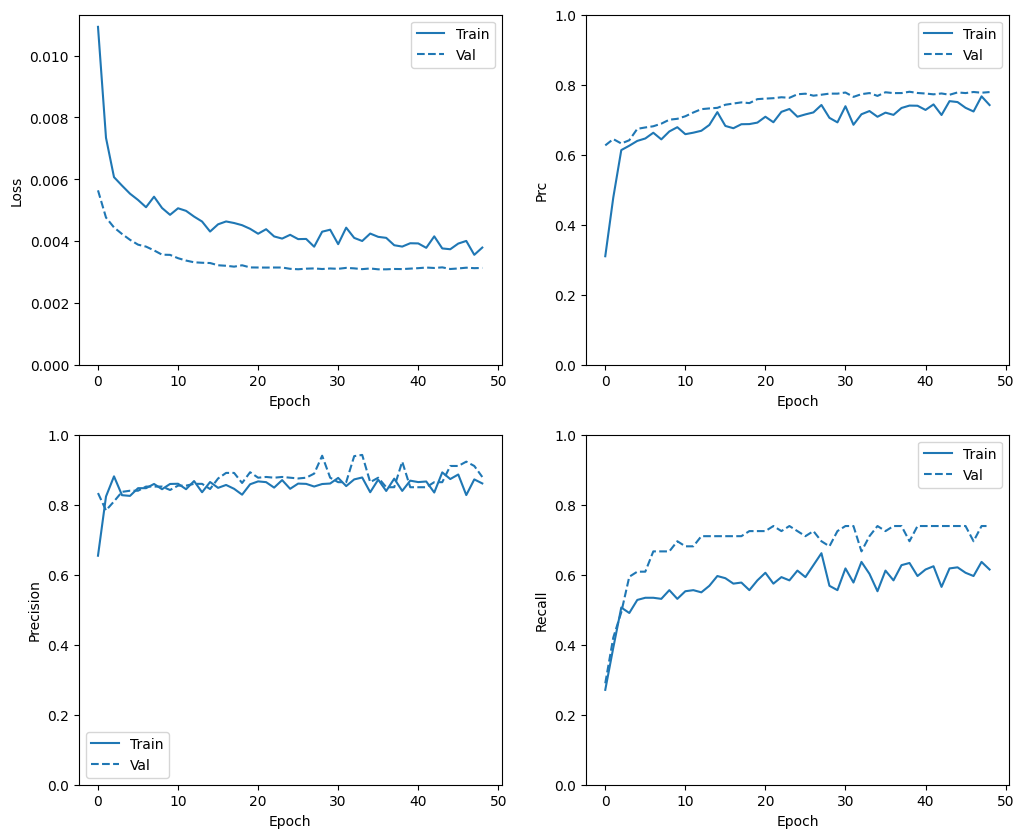

In [26]:
plot_metrics(baseline_history)

注意: 一般的に、検証曲線はトレーニング曲線よりも優れています。 これは主に、モデルを評価する際にドロップアウトレイヤーがアクティブでないということに起因します。

### メトリクスを評価する

[混同行列](https://developers.google.com/machine-learning/glossary/#confusion_matrix)を使用して、実際のラベルと予測されたラベルを要約できます。ここで、X 軸は予測されたラベルであり、Y 軸は実際のラベルです。

In [27]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

 1/90 [..............................] - ETA: 4s

41/90 [============>.................] - ETA: 0s

84/90 [===========================>..] - ETA: 0s

90/90 [==============================] - 0s 1ms/step


 1/28 [>.............................] - ETA: 0s

28/28 [==============================] - 0s 1ms/step


In [28]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

テストデータセットでモデルを評価し、上記で作成した行列の結果を表示します。

loss :  0.002801472321152687
tp :  71.0
fp :  1.0
tn :  56860.0
fn :  30.0
accuracy :  0.9994557499885559
precision :  0.9861111044883728
recall :  0.7029703259468079
auc :  0.9403578639030457
prc :  0.8531444072723389



Legitimate Transactions Detected (True Negatives):  56860
Legitimate Transactions Incorrectly Detected (False Positives):  1
Fraudulent Transactions Missed (False Negatives):  30
Fraudulent Transactions Detected (True Positives):  71
Total Fraudulent Transactions:  101


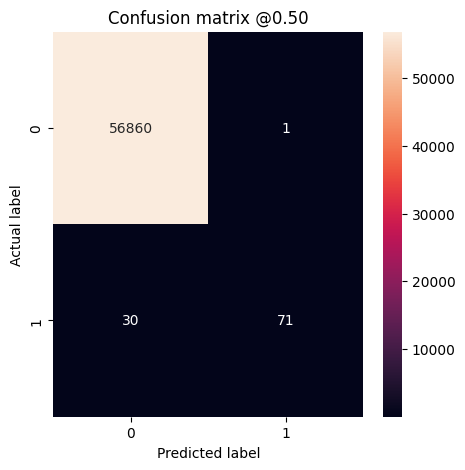

In [29]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

モデルがすべてを完璧に予測した場合は、これは[対角行列](https://en.wikipedia.org/wiki/Diagonal_matrix)になり、主な対角線から外れた値が不正確な予測を示してゼロになります。 この場合、行列は偽陽性が比較的少ないことを示し、これは誤ってフラグが立てられた正当な取引が比較的少ないことを意味します。 しかし、偽陽性の数が増えればコストがかかる可能性はありますが、偽陰性の数はさらに少なくした方が良いでしょう。偽陽性は顧客にカード利用履歴の確認を求めるメールを送信する可能性があるのに対し、偽陰性は不正な取引を成立させてしまう可能性があるため、このトレードオフはむしろ望ましいといえます。

### ROC をプロットする

次に、[ROC](https://developers.google.com/machine-learning/glossary#ROC) をプロットします。このプロットは、出力しきい値を調整するだけでモデルが到達できるパフォーマンス範囲が一目で分かるので有用です。

In [30]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

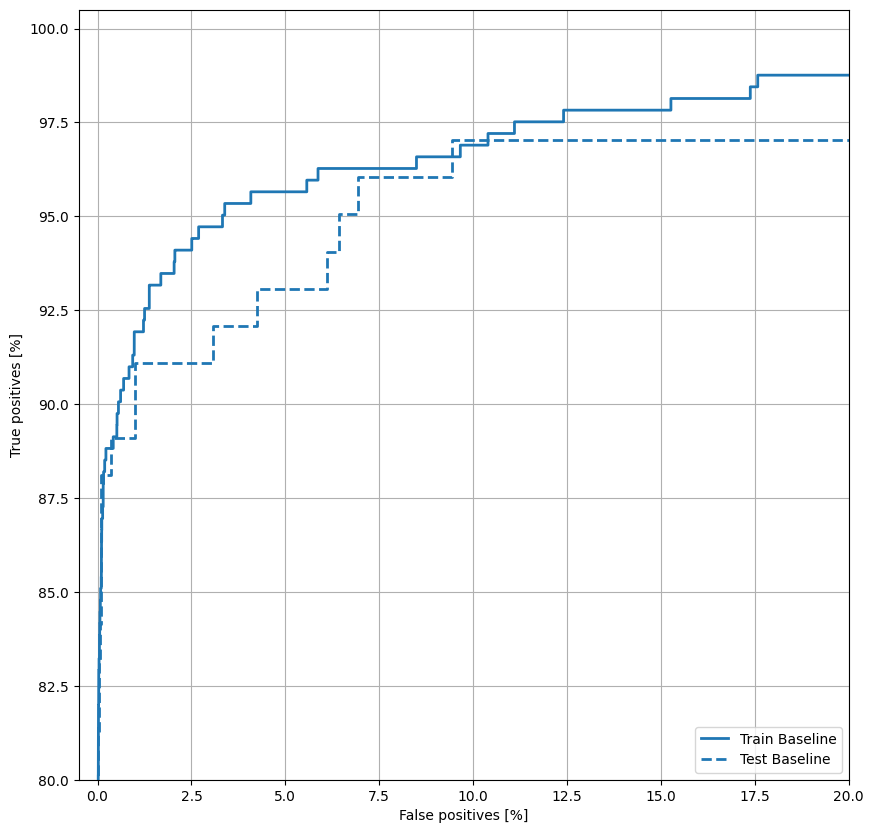

In [31]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

### AUPRC をプロットする

[AUPRC](https://developers.google.com/machine-learning/glossary?hl=en#PR_AUC) をプロットします。補間された適合率-再現率曲線の下の領域は、分類しきい値のさまざまな値に対して（再現率、適合率）点をプロットすることにより取得できます。計算方法によっては、PR AUC はモデルの平均適合率と同等になる場合があります。


In [32]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

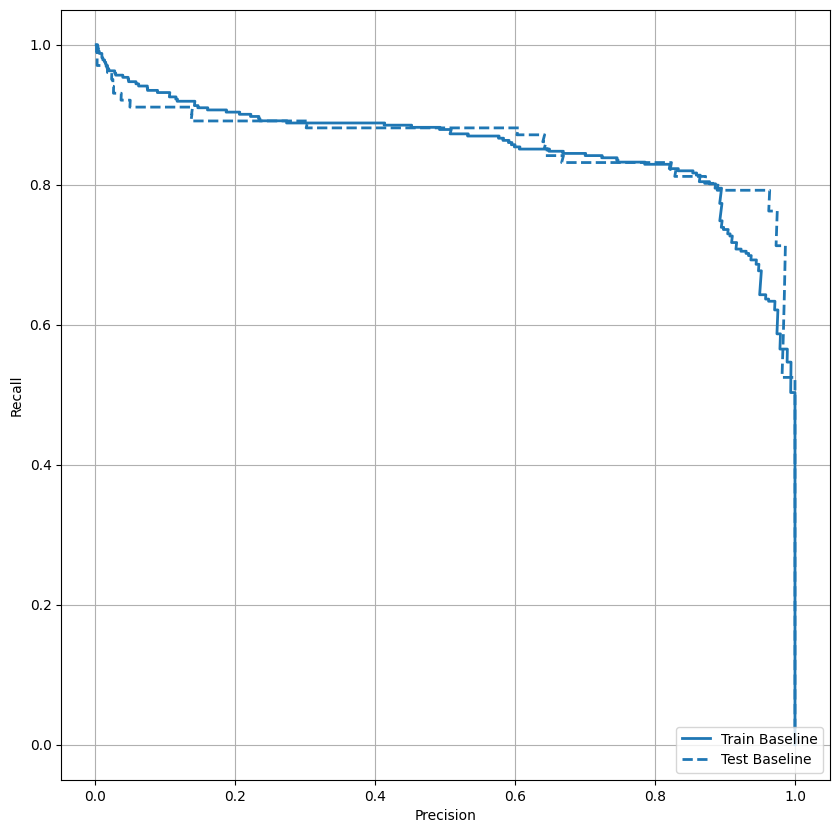

In [33]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

適合率は比較的高いように見えますが、再現率と ROC 曲線の下の曲線下面積 (AUC) は、期待するほど高いものではありません。適合率と再現率の両方を最大化しようとすると、分類器はしばしば課題に直面します。不均衡データセットを扱う場合は特にそうです。大切な問題のコンテキストでは異なるタイプのエラーにかかるコストを考慮することが重要です。 この例では、偽陰性（不正な取引が見逃されている）は金銭的コストを伴う可能性がある一方で、偽陽性（取引が不正であると誤ってフラグが立てられている）はユーザーの幸福度を低下させる可能性があります。

## クラスの重み

### クラスの重みを計算する

最終目的は不正な取引を特定することですが、処理する陽性サンプルがそれほど多くないので、利用可能な数少ない例の分類器に大きな重み付けをします。 これを行うには、パラメータを介して各クラスの重みを Keras に渡します。 これにより、モデルは十分に表現されていないクラスの例にも「より注意を払う」ようになります。

In [34]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


### クラスの重みでモデルをトレーニングする

次に、クラスの重みでモデルを再トレーニングして評価し、それが予測にどのように影響するかを確認します。

注意: `class_weights` を使用すると、損失の範囲が変更されます。オプティマイザにもよりますが、これはトレーニングの安定性に影響を与える可能性があります。`tf.keras.optimizers.SGD` のように、ステップサイズが勾配の大きさに依存するオプティマイザは失敗する可能性があります。ここで使用されているオプティマイザ `tf.keras.optimizers.Adam` は、スケーリングの変更による影響を受けません。また、重み付けのため、総損失は 2 つのモデル間で比較できないことに注意してください。

In [35]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight) 

Epoch 1/100


 1/90 [..............................] - ETA: 2:03 - loss: 6.3158 - tp: 71.0000 - fp: 2.0000 - tn: 58901.0000 - fn: 36.0000 - accuracy: 0.9994 - precision: 0.9726 - recall: 0.6636 - auc: 0.9201 - prc: 0.8042

13/90 [===>..........................] - ETA: 0s - loss: 3.4539 - tp: 72.0000 - fp: 18.0000 - tn: 83421.0000 - fn: 75.0000 - accuracy: 0.9989 - precision: 0.8000 - recall: 0.4898 - auc: 0.8465 - prc: 0.5520 

25/90 [=======>......................] - ETA: 0s - loss: 3.0005 - tp: 75.0000 - fp: 28.0000 - tn: 107945.0000 - fn: 114.0000 - accuracy: 0.9987 - precision: 0.7282 - recall: 0.3968 - auc: 0.8241 - prc: 0.4508

38/90 [===========>..................] - ETA: 0s - loss: 2.9126 - tp: 80.0000 - fp: 49.0000 - tn: 134500.0000 - fn: 157.0000 - accuracy: 0.9985 - precision: 0.6202 - recall: 0.3376 - auc: 0.8007 - prc: 0.3612

51/90 [================>.............] - ETA: 0s - loss: 2.8114 - tp: 86.0000 - fp: 74.0000 - tn: 161050.0000 - fn: 200.0000 - accuracy: 0.9983 - precision: 0.5375 - recall: 0.3007 - auc: 0.7930 - prc: 0.3143

63/90 [====================>.........] - ETA: 0s - loss: 2.6399 - tp: 103.0000 - fp: 104.0000 - tn: 185545.0000 - fn: 234.0000 - accuracy: 0.9982 - precision: 0.4976 - recall: 0.3056 - auc: 0.8022 - prc: 0.3064

75/90 [========================>.....] - ETA: 0s - loss: 2.5352 - tp: 123.0000 - fp: 123.0000 - tn: 210051.0000 - fn: 265.0000 - accuracy: 0.9982 - precision: 0.5000 - recall: 0.3170 - auc: 0.8049 - prc: 0.3139

87/90 [============================>.] - ETA: 0s - loss: 2.3207 - tp: 132.0000 - fp: 160.0000 - tn: 234562.0000 - fn: 284.0000 - accuracy: 0.9981 - precision: 0.4521 - recall: 0.3173 - auc: 0.8066 - prc: 0.2845

90/90 [==============================] - 2s 11ms/step - loss: 2.3129 - tp: 133.0000 - fp: 165.0000 - tn: 238650.0000 - fn: 290.0000 - accuracy: 0.9981 - precision: 0.4463 - recall: 0.3144 - auc: 0.8058 - prc: 0.2802 - val_loss: 0.0063 - val_tp: 27.0000 - val_fp: 8.0000 - val_tn: 45492.0000 - val_fn: 42.0000 - val_accuracy: 0.9989 - val_precision: 0.7714 - val_recall: 0.3913 - val_auc: 0.8841 - val_prc: 0.5301


Epoch 2/100


 1/90 [..............................] - ETA: 0s - loss: 0.0400 - tp: 3.0000 - fp: 3.0000 - tn: 2042.0000 - fn: 0.0000e+00 - accuracy: 0.9985 - precision: 0.5000 - recall: 1.0000 - auc: 0.9998 - prc: 0.9041

13/90 [===>..........................] - ETA: 0s - loss: 1.2245 - tp: 27.0000 - fp: 53.0000 - tn: 26521.0000 - fn: 23.0000 - accuracy: 0.9971 - precision: 0.3375 - recall: 0.5400 - auc: 0.8646 - prc: 0.4199

26/90 [=======>......................] - ETA: 0s - loss: 1.4537 - tp: 49.0000 - fp: 108.0000 - tn: 53039.0000 - fn: 52.0000 - accuracy: 0.9970 - precision: 0.3121 - recall: 0.4851 - auc: 0.8515 - prc: 0.3542

38/90 [===========>..................] - ETA: 0s - loss: 1.3070 - tp: 71.0000 - fp: 148.0000 - tn: 77538.0000 - fn: 67.0000 - accuracy: 0.9972 - precision: 0.3242 - recall: 0.5145 - auc: 0.8604 - prc: 0.3898

50/90 [===============>..............] - ETA: 0s - loss: 1.2124 - tp: 100.0000 - fp: 198.0000 - tn: 102017.0000 - fn: 85.0000 - accuracy: 0.9972 - precision: 0.3356 - recall: 0.5405 - auc: 0.8706 - prc: 0.4134

63/90 [====================>.........] - ETA: 0s - loss: 1.2201 - tp: 125.0000 - fp: 236.0000 - tn: 128553.0000 - fn: 110.0000 - accuracy: 0.9973 - precision: 0.3463 - recall: 0.5319 - auc: 0.8764 - prc: 0.4112

76/90 [========================>.....] - ETA: 0s - loss: 1.1544 - tp: 147.0000 - fp: 298.0000 - tn: 155076.0000 - fn: 127.0000 - accuracy: 0.9973 - precision: 0.3303 - recall: 0.5365 - auc: 0.8785 - prc: 0.4073

89/90 [============================>.] - ETA: 0s - loss: 1.0917 - tp: 180.0000 - fp: 370.0000 - tn: 181580.0000 - fn: 142.0000 - accuracy: 0.9972 - precision: 0.3273 - recall: 0.5590 - auc: 0.8846 - prc: 0.4262

90/90 [==============================] - 0s 5ms/step - loss: 1.0916 - tp: 180.0000 - fp: 370.0000 - tn: 181584.0000 - fn: 142.0000 - accuracy: 0.9972 - precision: 0.3273 - recall: 0.5590 - auc: 0.8846 - prc: 0.4262 - val_loss: 0.0072 - val_tp: 49.0000 - val_fp: 18.0000 - val_tn: 45482.0000 - val_fn: 20.0000 - val_accuracy: 0.9992 - val_precision: 0.7313 - val_recall: 0.7101 - val_auc: 0.8941 - val_prc: 0.5897


Epoch 3/100


 1/90 [..............................] - ETA: 0s - loss: 0.0062 - tp: 0.0000e+00 - fp: 3.0000 - tn: 2045.0000 - fn: 0.0000e+00 - accuracy: 0.9985 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - prc: 0.0000e+00

14/90 [===>..........................] - ETA: 0s - loss: 0.7028 - tp: 43.0000 - fp: 78.0000 - tn: 28536.0000 - fn: 15.0000 - accuracy: 0.9968 - precision: 0.3554 - recall: 0.7414 - auc: 0.9436 - prc: 0.5510                    

27/90 [========>.....................] - ETA: 0s - loss: 0.9812 - tp: 68.0000 - fp: 148.0000 - tn: 55041.0000 - fn: 39.0000 - accuracy: 0.9966 - precision: 0.3148 - recall: 0.6355 - auc: 0.9143 - prc: 0.4669

39/90 [============>.................] - ETA: 0s - loss: 0.8320 - tp: 95.0000 - fp: 215.0000 - tn: 79514.0000 - fn: 48.0000 - accuracy: 0.9967 - precision: 0.3065 - recall: 0.6643 - auc: 0.9243 - prc: 0.5155

52/90 [================>.............] - ETA: 0s - loss: 0.7897 - tp: 118.0000 - fp: 295.0000 - tn: 106019.0000 - fn: 64.0000 - accuracy: 0.9966 - precision: 0.2857 - recall: 0.6484 - auc: 0.9200 - prc: 0.4820

65/90 [====================>.........] - ETA: 0s - loss: 0.8131 - tp: 147.0000 - fp: 384.0000 - tn: 132508.0000 - fn: 81.0000 - accuracy: 0.9965 - precision: 0.2768 - recall: 0.6447 - auc: 0.9153 - prc: 0.4650

78/90 [=========================>....] - ETA: 0s - loss: 0.7819 - tp: 189.0000 - fp: 460.0000 - tn: 159002.0000 - fn: 93.0000 - accuracy: 0.9965 - precision: 0.2912 - recall: 0.6702 - auc: 0.9198 - prc: 0.4971

90/90 [==============================] - 0s 5ms/step - loss: 0.7963 - tp: 216.0000 - fp: 544.0000 - tn: 181410.0000 - fn: 106.0000 - accuracy: 0.9964 - precision: 0.2842 - recall: 0.6708 - auc: 0.9169 - prc: 0.4917 - val_loss: 0.0090 - val_tp: 53.0000 - val_fp: 22.0000 - val_tn: 45478.0000 - val_fn: 16.0000 - val_accuracy: 0.9992 - val_precision: 0.7067 - val_recall: 0.7681 - val_auc: 0.9043 - val_prc: 0.6168


Epoch 4/100


 1/90 [..............................] - ETA: 0s - loss: 0.0133 - tp: 4.0000 - fp: 16.0000 - tn: 2028.0000 - fn: 0.0000e+00 - accuracy: 0.9922 - precision: 0.2000 - recall: 1.0000 - auc: 0.9998 - prc: 0.8000

14/90 [===>..........................] - ETA: 0s - loss: 0.6905 - tp: 42.0000 - fp: 117.0000 - tn: 28497.0000 - fn: 16.0000 - accuracy: 0.9954 - precision: 0.2642 - recall: 0.7241 - auc: 0.9369 - prc: 0.5762

26/90 [=======>......................] - ETA: 0s - loss: 0.7463 - tp: 77.0000 - fp: 200.0000 - tn: 52941.0000 - fn: 30.0000 - accuracy: 0.9957 - precision: 0.2780 - recall: 0.7196 - auc: 0.9320 - prc: 0.5558

38/90 [===========>..................] - ETA: 0s - loss: 0.6948 - tp: 101.0000 - fp: 303.0000 - tn: 77380.0000 - fn: 40.0000 - accuracy: 0.9956 - precision: 0.2500 - recall: 0.7163 - auc: 0.9306 - prc: 0.5137

51/90 [================>.............] - ETA: 0s - loss: 0.6957 - tp: 131.0000 - fp: 430.0000 - tn: 103832.0000 - fn: 55.0000 - accuracy: 0.9954 - precision: 0.2335 - recall: 0.7043 - auc: 0.9254 - prc: 0.4801

63/90 [====================>.........] - ETA: 0s - loss: 0.6579 - tp: 172.0000 - fp: 542.0000 - tn: 128245.0000 - fn: 65.0000 - accuracy: 0.9953 - precision: 0.2409 - recall: 0.7257 - auc: 0.9316 - prc: 0.5149

75/90 [========================>.....] - ETA: 0s - loss: 0.6177 - tp: 207.0000 - fp: 662.0000 - tn: 152659.0000 - fn: 72.0000 - accuracy: 0.9952 - precision: 0.2382 - recall: 0.7419 - auc: 0.9325 - prc: 0.5429

88/90 [============================>.] - ETA: 0s - loss: 0.6061 - tp: 239.0000 - fp: 794.0000 - tn: 179110.0000 - fn: 81.0000 - accuracy: 0.9951 - precision: 0.2314 - recall: 0.7469 - auc: 0.9296 - prc: 0.5546

90/90 [==============================] - 0s 5ms/step - loss: 0.6105 - tp: 240.0000 - fp: 800.0000 - tn: 181154.0000 - fn: 82.0000 - accuracy: 0.9952 - precision: 0.2308 - recall: 0.7453 - auc: 0.9281 - prc: 0.5541 - val_loss: 0.0114 - val_tp: 53.0000 - val_fp: 34.0000 - val_tn: 45466.0000 - val_fn: 16.0000 - val_accuracy: 0.9989 - val_precision: 0.6092 - val_recall: 0.7681 - val_auc: 0.9200 - val_prc: 0.6427


Epoch 5/100


 1/90 [..............................] - ETA: 0s - loss: 0.0212 - tp: 7.0000 - fp: 13.0000 - tn: 2028.0000 - fn: 0.0000e+00 - accuracy: 0.9937 - precision: 0.3500 - recall: 1.0000 - auc: 0.9993 - prc: 0.7000

14/90 [===>..........................] - ETA: 0s - loss: 0.5156 - tp: 48.0000 - fp: 148.0000 - tn: 28466.0000 - fn: 10.0000 - accuracy: 0.9945 - precision: 0.2449 - recall: 0.8276 - auc: 0.9468 - prc: 0.6402

27/90 [========>.....................] - ETA: 0s - loss: 0.5944 - tp: 85.0000 - fp: 309.0000 - tn: 54878.0000 - fn: 24.0000 - accuracy: 0.9940 - precision: 0.2157 - recall: 0.7798 - auc: 0.9416 - prc: 0.5428

40/90 [============>.................] - ETA: 0s - loss: 0.6068 - tp: 123.0000 - fp: 460.0000 - tn: 81298.0000 - fn: 39.0000 - accuracy: 0.9939 - precision: 0.2110 - recall: 0.7593 - auc: 0.9408 - prc: 0.5355

53/90 [================>.............] - ETA: 0s - loss: 0.5815 - tp: 147.0000 - fp: 610.0000 - tn: 107735.0000 - fn: 52.0000 - accuracy: 0.9939 - precision: 0.1942 - recall: 0.7387 - auc: 0.9399 - prc: 0.5080

66/90 [=====================>........] - ETA: 0s - loss: 0.5367 - tp: 179.0000 - fp: 803.0000 - tn: 134126.0000 - fn: 60.0000 - accuracy: 0.9936 - precision: 0.1823 - recall: 0.7490 - auc: 0.9443 - prc: 0.5043

79/90 [=========================>....] - ETA: 0s - loss: 0.5314 - tp: 212.0000 - fp: 998.0000 - tn: 160512.0000 - fn: 70.0000 - accuracy: 0.9934 - precision: 0.1752 - recall: 0.7518 - auc: 0.9405 - prc: 0.4952

90/90 [==============================] - 0s 5ms/step - loss: 0.5837 - tp: 240.0000 - fp: 1179.0000 - tn: 180775.0000 - fn: 82.0000 - accuracy: 0.9931 - precision: 0.1691 - recall: 0.7453 - auc: 0.9288 - prc: 0.4826 - val_loss: 0.0152 - val_tp: 54.0000 - val_fp: 72.0000 - val_tn: 45428.0000 - val_fn: 15.0000 - val_accuracy: 0.9981 - val_precision: 0.4286 - val_recall: 0.7826 - val_auc: 0.9307 - val_prc: 0.6217


Epoch 6/100


 1/90 [..............................] - ETA: 0s - loss: 0.9643 - tp: 5.0000 - fp: 9.0000 - tn: 2033.0000 - fn: 1.0000 - accuracy: 0.9951 - precision: 0.3571 - recall: 0.8333 - auc: 0.8890 - prc: 0.7555

14/90 [===>..........................] - ETA: 0s - loss: 0.3627 - tp: 38.0000 - fp: 212.0000 - tn: 28413.0000 - fn: 9.0000 - accuracy: 0.9923 - precision: 0.1520 - recall: 0.8085 - auc: 0.9397 - prc: 0.4764

27/90 [========>.....................] - ETA: 0s - loss: 0.5200 - tp: 75.0000 - fp: 445.0000 - tn: 54754.0000 - fn: 22.0000 - accuracy: 0.9916 - precision: 0.1442 - recall: 0.7732 - auc: 0.9303 - prc: 0.4181

40/90 [============>.................] - ETA: 0s - loss: 0.4667 - tp: 116.0000 - fp: 657.0000 - tn: 81117.0000 - fn: 30.0000 - accuracy: 0.9916 - precision: 0.1501 - recall: 0.7945 - auc: 0.9415 - prc: 0.4610

53/90 [================>.............] - ETA: 0s - loss: 0.4782 - tp: 164.0000 - fp: 886.0000 - tn: 107455.0000 - fn: 39.0000 - accuracy: 0.9915 - precision: 0.1562 - recall: 0.8079 - auc: 0.9397 - prc: 0.4867

66/90 [=====================>........] - ETA: 0s - loss: 0.4828 - tp: 196.0000 - fp: 1127.0000 - tn: 133795.0000 - fn: 50.0000 - accuracy: 0.9913 - precision: 0.1481 - recall: 0.7967 - auc: 0.9347 - prc: 0.4645

79/90 [=========================>....] - ETA: 0s - loss: 0.4566 - tp: 229.0000 - fp: 1391.0000 - tn: 160115.0000 - fn: 57.0000 - accuracy: 0.9911 - precision: 0.1414 - recall: 0.8007 - auc: 0.9378 - prc: 0.4611

90/90 [==============================] - 0s 5ms/step - loss: 0.4503 - tp: 259.0000 - fp: 1631.0000 - tn: 180323.0000 - fn: 63.0000 - accuracy: 0.9907 - precision: 0.1370 - recall: 0.8043 - auc: 0.9382 - prc: 0.4635 - val_loss: 0.0195 - val_tp: 54.0000 - val_fp: 121.0000 - val_tn: 45379.0000 - val_fn: 15.0000 - val_accuracy: 0.9970 - val_precision: 0.3086 - val_recall: 0.7826 - val_auc: 0.9420 - val_prc: 0.6180


Epoch 7/100


 1/90 [..............................] - ETA: 0s - loss: 0.0199 - tp: 3.0000 - fp: 23.0000 - tn: 2022.0000 - fn: 0.0000e+00 - accuracy: 0.9888 - precision: 0.1154 - recall: 1.0000 - auc: 0.9995 - prc: 0.6000

14/90 [===>..........................] - ETA: 0s - loss: 0.1764 - tp: 34.0000 - fp: 299.0000 - tn: 28335.0000 - fn: 4.0000 - accuracy: 0.9894 - precision: 0.1021 - recall: 0.8947 - auc: 0.9763 - prc: 0.5245 

27/90 [========>.....................] - ETA: 0s - loss: 0.2585 - tp: 73.0000 - fp: 559.0000 - tn: 54651.0000 - fn: 13.0000 - accuracy: 0.9897 - precision: 0.1155 - recall: 0.8488 - auc: 0.9682 - prc: 0.5303

40/90 [============>.................] - ETA: 0s - loss: 0.2186 - tp: 119.0000 - fp: 862.0000 - tn: 80922.0000 - fn: 17.0000 - accuracy: 0.9893 - precision: 0.1213 - recall: 0.8750 - auc: 0.9775 - prc: 0.5188

53/90 [================>.............] - ETA: 0s - loss: 0.2733 - tp: 155.0000 - fp: 1175.0000 - tn: 107189.0000 - fn: 25.0000 - accuracy: 0.9889 - precision: 0.1165 - recall: 0.8611 - auc: 0.9678 - prc: 0.4957

66/90 [=====================>........] - ETA: 0s - loss: 0.3298 - tp: 194.0000 - fp: 1509.0000 - tn: 133428.0000 - fn: 37.0000 - accuracy: 0.9886 - precision: 0.1139 - recall: 0.8398 - auc: 0.9626 - prc: 0.4843

79/90 [=========================>....] - ETA: 0s - loss: 0.3610 - tp: 233.0000 - fp: 1832.0000 - tn: 159677.0000 - fn: 50.0000 - accuracy: 0.9884 - precision: 0.1128 - recall: 0.8233 - auc: 0.9609 - prc: 0.4684

90/90 [==============================] - 0s 5ms/step - loss: 0.3774 - tp: 265.0000 - fp: 2116.0000 - tn: 179838.0000 - fn: 57.0000 - accuracy: 0.9881 - precision: 0.1113 - recall: 0.8230 - auc: 0.9587 - prc: 0.4556 - val_loss: 0.0247 - val_tp: 54.0000 - val_fp: 180.0000 - val_tn: 45320.0000 - val_fn: 15.0000 - val_accuracy: 0.9957 - val_precision: 0.2308 - val_recall: 0.7826 - val_auc: 0.9448 - val_prc: 0.6166


Epoch 8/100


 1/90 [..............................] - ETA: 0s - loss: 0.0150 - tp: 0.0000e+00 - fp: 12.0000 - tn: 2036.0000 - fn: 0.0000e+00 - accuracy: 0.9941 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - prc: 0.0000e+00

14/90 [===>..........................] - ETA: 0s - loss: 0.4706 - tp: 35.0000 - fp: 359.0000 - tn: 28266.0000 - fn: 12.0000 - accuracy: 0.9871 - precision: 0.0888 - recall: 0.7447 - auc: 0.9118 - prc: 0.3694                    

27/90 [========>.....................] - ETA: 0s - loss: 0.4227 - tp: 63.0000 - fp: 733.0000 - tn: 54481.0000 - fn: 19.0000 - accuracy: 0.9864 - precision: 0.0791 - recall: 0.7683 - auc: 0.9226 - prc: 0.3716

39/90 [============>.................] - ETA: 0s - loss: 0.4233 - tp: 92.0000 - fp: 1078.0000 - tn: 78675.0000 - fn: 27.0000 - accuracy: 0.9862 - precision: 0.0786 - recall: 0.7731 - auc: 0.9235 - prc: 0.3823

52/90 [================>.............] - ETA: 0s - loss: 0.4388 - tp: 139.0000 - fp: 1468.0000 - tn: 104851.0000 - fn: 38.0000 - accuracy: 0.9859 - precision: 0.0865 - recall: 0.7853 - auc: 0.9314 - prc: 0.3944

65/90 [====================>.........] - ETA: 0s - loss: 0.4183 - tp: 186.0000 - fp: 1840.0000 - tn: 131050.0000 - fn: 44.0000 - accuracy: 0.9858 - precision: 0.0918 - recall: 0.8087 - auc: 0.9371 - prc: 0.4145

78/90 [=========================>....] - ETA: 0s - loss: 0.4055 - tp: 228.0000 - fp: 2293.0000 - tn: 157173.0000 - fn: 50.0000 - accuracy: 0.9853 - precision: 0.0904 - recall: 0.8201 - auc: 0.9379 - prc: 0.3905

90/90 [==============================] - 0s 5ms/step - loss: 0.3911 - tp: 267.0000 - fp: 2627.0000 - tn: 179327.0000 - fn: 55.0000 - accuracy: 0.9853 - precision: 0.0923 - recall: 0.8292 - auc: 0.9403 - prc: 0.3966 - val_loss: 0.0300 - val_tp: 56.0000 - val_fp: 271.0000 - val_tn: 45229.0000 - val_fn: 13.0000 - val_accuracy: 0.9938 - val_precision: 0.1713 - val_recall: 0.8116 - val_auc: 0.9574 - val_prc: 0.5708


Epoch 9/100


 1/90 [..............................] - ETA: 0s - loss: 0.0287 - tp: 2.0000 - fp: 34.0000 - tn: 2012.0000 - fn: 0.0000e+00 - accuracy: 0.9834 - precision: 0.0556 - recall: 1.0000 - auc: 0.9998 - prc: 0.6667

14/90 [===>..........................] - ETA: 0s - loss: 0.4114 - tp: 33.0000 - fp: 468.0000 - tn: 28160.0000 - fn: 11.0000 - accuracy: 0.9833 - precision: 0.0659 - recall: 0.7500 - auc: 0.9487 - prc: 0.2544

27/90 [========>.....................] - ETA: 0s - loss: 0.3475 - tp: 73.0000 - fp: 900.0000 - tn: 54306.0000 - fn: 17.0000 - accuracy: 0.9834 - precision: 0.0750 - recall: 0.8111 - auc: 0.9575 - prc: 0.2911

40/90 [============>.................] - ETA: 0s - loss: 0.3594 - tp: 115.0000 - fp: 1352.0000 - tn: 80429.0000 - fn: 24.0000 - accuracy: 0.9832 - precision: 0.0784 - recall: 0.8273 - auc: 0.9558 - prc: 0.3053

53/90 [================>.............] - ETA: 0s - loss: 0.2935 - tp: 154.0000 - fp: 1824.0000 - tn: 106540.0000 - fn: 26.0000 - accuracy: 0.9830 - precision: 0.0779 - recall: 0.8556 - auc: 0.9646 - prc: 0.3155

66/90 [=====================>........] - ETA: 0s - loss: 0.3411 - tp: 189.0000 - fp: 2259.0000 - tn: 132682.0000 - fn: 38.0000 - accuracy: 0.9830 - precision: 0.0772 - recall: 0.8326 - auc: 0.9534 - prc: 0.3107

79/90 [=========================>....] - ETA: 0s - loss: 0.3292 - tp: 226.0000 - fp: 2752.0000 - tn: 158771.0000 - fn: 43.0000 - accuracy: 0.9827 - precision: 0.0759 - recall: 0.8401 - auc: 0.9531 - prc: 0.3178

90/90 [==============================] - 0s 5ms/step - loss: 0.3524 - tp: 269.0000 - fp: 3140.0000 - tn: 178814.0000 - fn: 53.0000 - accuracy: 0.9825 - precision: 0.0789 - recall: 0.8354 - auc: 0.9525 - prc: 0.3345 - val_loss: 0.0372 - val_tp: 56.0000 - val_fp: 399.0000 - val_tn: 45101.0000 - val_fn: 13.0000 - val_accuracy: 0.9910 - val_precision: 0.1231 - val_recall: 0.8116 - val_auc: 0.9583 - val_prc: 0.5338


Epoch 10/100


 1/90 [..............................] - ETA: 0s - loss: 0.0348 - tp: 2.0000 - fp: 51.0000 - tn: 1995.0000 - fn: 0.0000e+00 - accuracy: 0.9751 - precision: 0.0377 - recall: 1.0000 - auc: 0.9993 - prc: 0.4361

13/90 [===>..........................] - ETA: 0s - loss: 0.3063 - tp: 34.0000 - fp: 504.0000 - tn: 26081.0000 - fn: 5.0000 - accuracy: 0.9809 - precision: 0.0632 - recall: 0.8718 - auc: 0.9356 - prc: 0.3177 

26/90 [=======>......................] - ETA: 0s - loss: 0.3398 - tp: 69.0000 - fp: 1033.0000 - tn: 52131.0000 - fn: 15.0000 - accuracy: 0.9803 - precision: 0.0626 - recall: 0.8214 - auc: 0.9451 - prc: 0.2857

39/90 [============>.................] - ETA: 0s - loss: 0.2942 - tp: 111.0000 - fp: 1561.0000 - tn: 78182.0000 - fn: 18.0000 - accuracy: 0.9802 - precision: 0.0664 - recall: 0.8605 - auc: 0.9530 - prc: 0.3139

52/90 [================>.............] - ETA: 0s - loss: 0.3963 - tp: 149.0000 - fp: 2114.0000 - tn: 104200.0000 - fn: 33.0000 - accuracy: 0.9798 - precision: 0.0658 - recall: 0.8187 - auc: 0.9352 - prc: 0.2934

64/90 [====================>.........] - ETA: 0s - loss: 0.4263 - tp: 194.0000 - fp: 2584.0000 - tn: 128250.0000 - fn: 44.0000 - accuracy: 0.9799 - precision: 0.0698 - recall: 0.8151 - auc: 0.9327 - prc: 0.3005

77/90 [========================>.....] - ETA: 0s - loss: 0.3737 - tp: 234.0000 - fp: 3153.0000 - tn: 154262.0000 - fn: 47.0000 - accuracy: 0.9797 - precision: 0.0691 - recall: 0.8327 - auc: 0.9418 - prc: 0.3001

90/90 [==============================] - ETA: 0s - loss: 0.3474 - tp: 270.0000 - fp: 3654.0000 - tn: 178300.0000 - fn: 52.0000 - accuracy: 0.9797 - precision: 0.0688 - recall: 0.8385 - auc: 0.9472 - prc: 0.2990

90/90 [==============================] - 0s 5ms/step - loss: 0.3474 - tp: 270.0000 - fp: 3654.0000 - tn: 178300.0000 - fn: 52.0000 - accuracy: 0.9797 - precision: 0.0688 - recall: 0.8385 - auc: 0.9472 - prc: 0.2990 - val_loss: 0.0435 - val_tp: 56.0000 - val_fp: 492.0000 - val_tn: 45008.0000 - val_fn: 13.0000 - val_accuracy: 0.9889 - val_precision: 0.1022 - val_recall: 0.8116 - val_auc: 0.9581 - val_prc: 0.5103


Epoch 11/100


 1/90 [..............................] - ETA: 0s - loss: 0.0380 - tp: 6.0000 - fp: 44.0000 - tn: 1998.0000 - fn: 0.0000e+00 - accuracy: 0.9785 - precision: 0.1200 - recall: 1.0000 - auc: 0.9990 - prc: 0.6000

14/90 [===>..........................] - ETA: 0s - loss: 0.2865 - tp: 49.0000 - fp: 655.0000 - tn: 27962.0000 - fn: 6.0000 - accuracy: 0.9769 - precision: 0.0696 - recall: 0.8909 - auc: 0.9563 - prc: 0.3649 

27/90 [========>.....................] - ETA: 0s - loss: 0.3148 - tp: 100.0000 - fp: 1244.0000 - tn: 53939.0000 - fn: 13.0000 - accuracy: 0.9773 - precision: 0.0744 - recall: 0.8850 - auc: 0.9570 - prc: 0.3697

40/90 [============>.................] - ETA: 0s - loss: 0.2989 - tp: 132.0000 - fp: 1851.0000 - tn: 79918.0000 - fn: 19.0000 - accuracy: 0.9772 - precision: 0.0666 - recall: 0.8742 - auc: 0.9557 - prc: 0.3356

53/90 [================>.............] - ETA: 0s - loss: 0.3209 - tp: 162.0000 - fp: 2414.0000 - tn: 105943.0000 - fn: 25.0000 - accuracy: 0.9775 - precision: 0.0629 - recall: 0.8663 - auc: 0.9461 - prc: 0.3159

66/90 [=====================>........] - ETA: 0s - loss: 0.3439 - tp: 199.0000 - fp: 3000.0000 - tn: 131937.0000 - fn: 32.0000 - accuracy: 0.9776 - precision: 0.0622 - recall: 0.8615 - auc: 0.9388 - prc: 0.3098

79/90 [=========================>....] - ETA: 0s - loss: 0.3725 - tp: 244.0000 - fp: 3588.0000 - tn: 157918.0000 - fn: 42.0000 - accuracy: 0.9776 - precision: 0.0637 - recall: 0.8531 - auc: 0.9369 - prc: 0.3039

90/90 [==============================] - 0s 5ms/step - loss: 0.3760 - tp: 274.0000 - fp: 4014.0000 - tn: 177940.0000 - fn: 48.0000 - accuracy: 0.9777 - precision: 0.0639 - recall: 0.8509 - auc: 0.9363 - prc: 0.2969 - val_loss: 0.0488 - val_tp: 57.0000 - val_fp: 552.0000 - val_tn: 44948.0000 - val_fn: 12.0000 - val_accuracy: 0.9876 - val_precision: 0.0936 - val_recall: 0.8261 - val_auc: 0.9582 - val_prc: 0.4941


Epoch 12/100


 1/90 [..............................] - ETA: 0s - loss: 0.0427 - tp: 2.0000 - fp: 46.0000 - tn: 2000.0000 - fn: 0.0000e+00 - accuracy: 0.9775 - precision: 0.0417 - recall: 1.0000 - auc: 0.9993 - prc: 0.4000

13/90 [===>..........................] - ETA: 0s - loss: 0.2063 - tp: 38.0000 - fp: 643.0000 - tn: 25938.0000 - fn: 5.0000 - accuracy: 0.9757 - precision: 0.0558 - recall: 0.8837 - auc: 0.9824 - prc: 0.2842 

25/90 [=======>......................] - ETA: 0s - loss: 0.2299 - tp: 83.0000 - fp: 1247.0000 - tn: 49860.0000 - fn: 10.0000 - accuracy: 0.9754 - precision: 0.0624 - recall: 0.8925 - auc: 0.9758 - prc: 0.3276

38/90 [===========>..................] - ETA: 0s - loss: 0.2846 - tp: 120.0000 - fp: 1860.0000 - tn: 75825.0000 - fn: 19.0000 - accuracy: 0.9759 - precision: 0.0606 - recall: 0.8633 - auc: 0.9669 - prc: 0.3078

51/90 [================>.............] - ETA: 0s - loss: 0.3217 - tp: 162.0000 - fp: 2520.0000 - tn: 101739.0000 - fn: 27.0000 - accuracy: 0.9756 - precision: 0.0604 - recall: 0.8571 - auc: 0.9571 - prc: 0.3013

64/90 [====================>.........] - ETA: 0s - loss: 0.3080 - tp: 204.0000 - fp: 3217.0000 - tn: 127618.0000 - fn: 33.0000 - accuracy: 0.9752 - precision: 0.0596 - recall: 0.8608 - auc: 0.9582 - prc: 0.2958

76/90 [========================>.....] - ETA: 0s - loss: 0.3088 - tp: 237.0000 - fp: 3844.0000 - tn: 151528.0000 - fn: 39.0000 - accuracy: 0.9751 - precision: 0.0581 - recall: 0.8587 - auc: 0.9559 - prc: 0.2846

88/90 [============================>.] - ETA: 0s - loss: 0.3119 - tp: 269.0000 - fp: 4494.0000 - tn: 175415.0000 - fn: 46.0000 - accuracy: 0.9748 - precision: 0.0565 - recall: 0.8540 - auc: 0.9557 - prc: 0.2764

90/90 [==============================] - 0s 6ms/step - loss: 0.3090 - tp: 276.0000 - fp: 4542.0000 - tn: 177412.0000 - fn: 46.0000 - accuracy: 0.9748 - precision: 0.0573 - recall: 0.8571 - auc: 0.9566 - prc: 0.2807 - val_loss: 0.0552 - val_tp: 58.0000 - val_fp: 625.0000 - val_tn: 44875.0000 - val_fn: 11.0000 - val_accuracy: 0.9860 - val_precision: 0.0849 - val_recall: 0.8406 - val_auc: 0.9611 - val_prc: 0.4743


Epoch 13/100


 1/90 [..............................] - ETA: 0s - loss: 0.0518 - tp: 5.0000 - fp: 67.0000 - tn: 1976.0000 - fn: 0.0000e+00 - accuracy: 0.9673 - precision: 0.0694 - recall: 1.0000 - auc: 0.9985 - prc: 0.4545

13/90 [===>..........................] - ETA: 0s - loss: 0.2324 - tp: 33.0000 - fp: 669.0000 - tn: 25917.0000 - fn: 5.0000 - accuracy: 0.9747 - precision: 0.0470 - recall: 0.8684 - auc: 0.9648 - prc: 0.2084 

25/90 [=======>......................] - ETA: 0s - loss: 0.2857 - tp: 62.0000 - fp: 1313.0000 - tn: 49815.0000 - fn: 10.0000 - accuracy: 0.9742 - precision: 0.0451 - recall: 0.8611 - auc: 0.9396 - prc: 0.2026

37/90 [===========>..................] - ETA: 0s - loss: 0.2916 - tp: 100.0000 - fp: 1949.0000 - tn: 73709.0000 - fn: 18.0000 - accuracy: 0.9740 - precision: 0.0488 - recall: 0.8475 - auc: 0.9502 - prc: 0.2228

50/90 [===============>..............] - ETA: 0s - loss: 0.2543 - tp: 146.0000 - fp: 2639.0000 - tn: 99594.0000 - fn: 21.0000 - accuracy: 0.9740 - precision: 0.0524 - recall: 0.8743 - auc: 0.9603 - prc: 0.2439

63/90 [====================>.........] - ETA: 0s - loss: 0.2759 - tp: 186.0000 - fp: 3359.0000 - tn: 125450.0000 - fn: 29.0000 - accuracy: 0.9737 - precision: 0.0525 - recall: 0.8651 - auc: 0.9568 - prc: 0.2346

75/90 [========================>.....] - ETA: 0s - loss: 0.2916 - tp: 224.0000 - fp: 4002.0000 - tn: 149337.0000 - fn: 37.0000 - accuracy: 0.9737 - precision: 0.0530 - recall: 0.8582 - auc: 0.9560 - prc: 0.2355

87/90 [============================>.] - ETA: 0s - loss: 0.2916 - tp: 269.0000 - fp: 4692.0000 - tn: 173172.0000 - fn: 43.0000 - accuracy: 0.9734 - precision: 0.0542 - recall: 0.8622 - auc: 0.9565 - prc: 0.2432

90/90 [==============================] - 0s 6ms/step - loss: 0.3053 - tp: 277.0000 - fp: 4807.0000 - tn: 177147.0000 - fn: 45.0000 - accuracy: 0.9734 - precision: 0.0545 - recall: 0.8602 - auc: 0.9528 - prc: 0.2449 - val_loss: 0.0600 - val_tp: 58.0000 - val_fp: 670.0000 - val_tn: 44830.0000 - val_fn: 11.0000 - val_accuracy: 0.9851 - val_precision: 0.0797 - val_recall: 0.8406 - val_auc: 0.9603 - val_prc: 0.4704


Epoch 14/100


 1/90 [..............................] - ETA: 0s - loss: 0.0563 - tp: 5.0000 - fp: 60.0000 - tn: 1983.0000 - fn: 0.0000e+00 - accuracy: 0.9707 - precision: 0.0769 - recall: 1.0000 - auc: 0.9987 - prc: 0.4905

14/90 [===>..........................] - ETA: 0s - loss: 0.3693 - tp: 48.0000 - fp: 710.0000 - tn: 27905.0000 - fn: 9.0000 - accuracy: 0.9749 - precision: 0.0633 - recall: 0.8421 - auc: 0.9550 - prc: 0.2861 

27/90 [========>.....................] - ETA: 0s - loss: 0.3933 - tp: 98.0000 - fp: 1473.0000 - tn: 53709.0000 - fn: 16.0000 - accuracy: 0.9731 - precision: 0.0624 - recall: 0.8596 - auc: 0.9469 - prc: 0.2659

40/90 [============>.................] - ETA: 0s - loss: 0.3463 - tp: 136.0000 - fp: 2226.0000 - tn: 79537.0000 - fn: 21.0000 - accuracy: 0.9726 - precision: 0.0576 - recall: 0.8662 - auc: 0.9490 - prc: 0.2594

53/90 [================>.............] - ETA: 0s - loss: 0.3075 - tp: 180.0000 - fp: 2985.0000 - tn: 105355.0000 - fn: 24.0000 - accuracy: 0.9723 - precision: 0.0569 - recall: 0.8824 - auc: 0.9558 - prc: 0.2589

66/90 [=====================>........] - ETA: 0s - loss: 0.3165 - tp: 220.0000 - fp: 3747.0000 - tn: 131171.0000 - fn: 30.0000 - accuracy: 0.9721 - precision: 0.0555 - recall: 0.8800 - auc: 0.9506 - prc: 0.2558

79/90 [=========================>....] - ETA: 0s - loss: 0.3186 - tp: 260.0000 - fp: 4499.0000 - tn: 156996.0000 - fn: 37.0000 - accuracy: 0.9720 - precision: 0.0546 - recall: 0.8754 - auc: 0.9518 - prc: 0.2507

Restoring model weights from the end of the best epoch: 4.


90/90 [==============================] - 0s 5ms/step - loss: 0.3006 - tp: 283.0000 - fp: 5045.0000 - tn: 176909.0000 - fn: 39.0000 - accuracy: 0.9721 - precision: 0.0531 - recall: 0.8789 - auc: 0.9527 - prc: 0.2479 - val_loss: 0.0620 - val_tp: 58.0000 - val_fp: 689.0000 - val_tn: 44811.0000 - val_fn: 11.0000 - val_accuracy: 0.9846 - val_precision: 0.0776 - val_recall: 0.8406 - val_auc: 0.9613 - val_prc: 0.4712


Epoch 14: early stopping


### トレーニング履歴を確認する

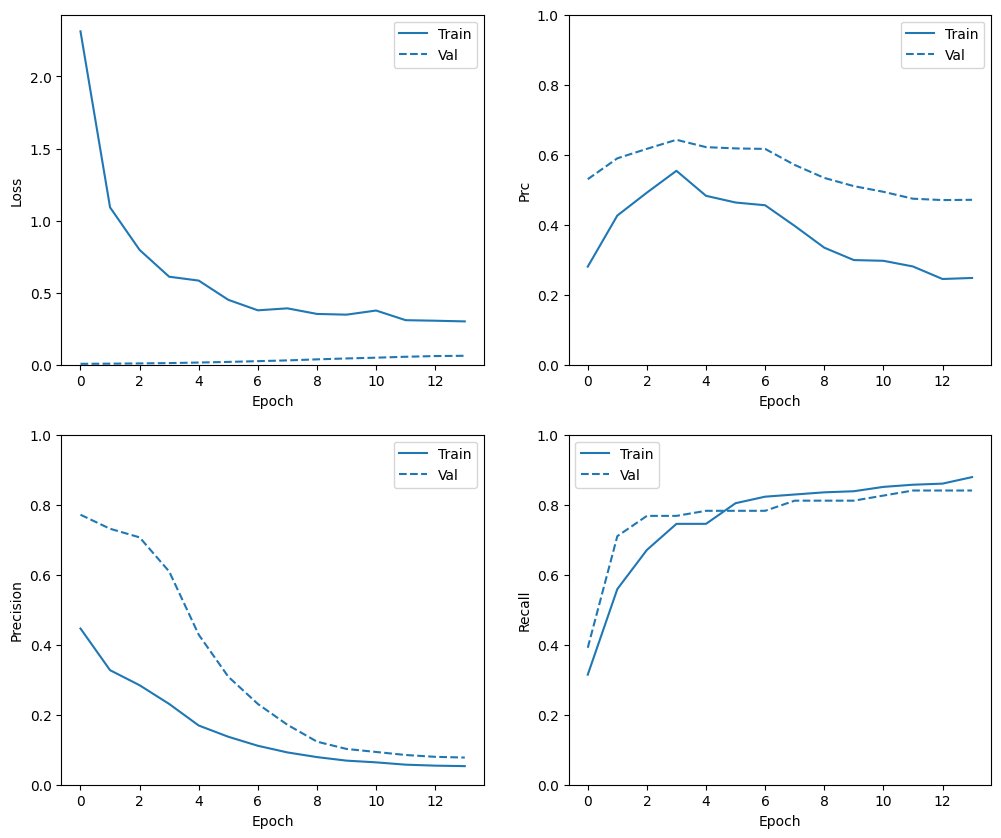

In [36]:
plot_metrics(weighted_history)

### メトリクスを評価する

In [37]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

 1/90 [..............................] - ETA: 4s

41/90 [============>.................] - ETA: 0s

81/90 [==========================>...] - ETA: 0s

90/90 [==============================] - 0s 1ms/step


 1/28 [>.............................] - ETA: 0s

28/28 [==============================] - 0s 1ms/step


loss :  0.00944011565297842
tp :  81.0
fp :  29.0
tn :  56832.0
fn :  20.0
accuracy :  0.9991397857666016
precision :  0.7363636493682861
recall :  0.801980197429657
auc :  0.9742780327796936
prc :  0.7228649854660034

Legitimate Transactions Detected (True Negatives):  56832
Legitimate Transactions Incorrectly Detected (False Positives):  29
Fraudulent Transactions Missed (False Negatives):  20
Fraudulent Transactions Detected (True Positives):  81
Total Fraudulent Transactions:  101


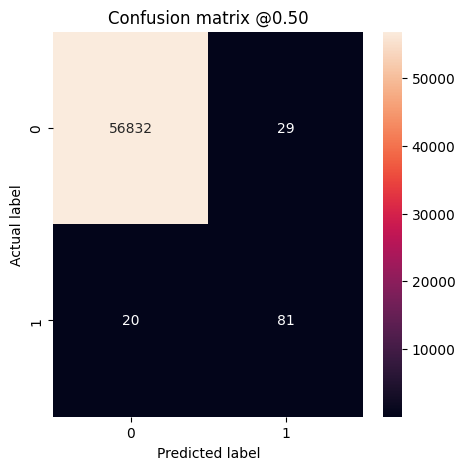

In [38]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

ここでは、クラスの重みを使用すると偽陽性が多くなるため、正解率と適合率が低くなりますが、逆にモデルがより多くの真陽性を検出したため、再現率と AUC が高くなっていることが分かります。このモデルは正解率は低いものの、再現率が高くなるので、より多くの不正取引を特定します。もちろん、両タイプのエラーにはコストがかかります。（あまりにも多くの正当な取引を不正取引としてフラグを立ててユーザーに迷惑をかけたくはないはずです。）アプリケーションのこういった異なるタイプのエラー間のトレードオフは、慎重に検討してください

### ROC をプロットする

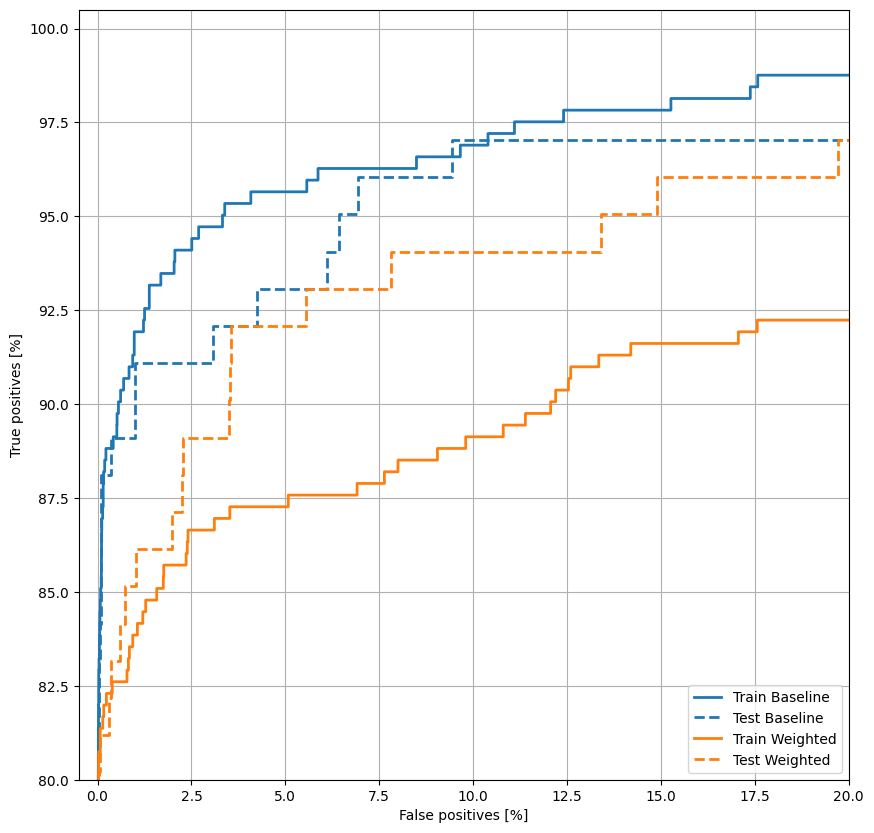

In [39]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

### AUPRC をプロットする

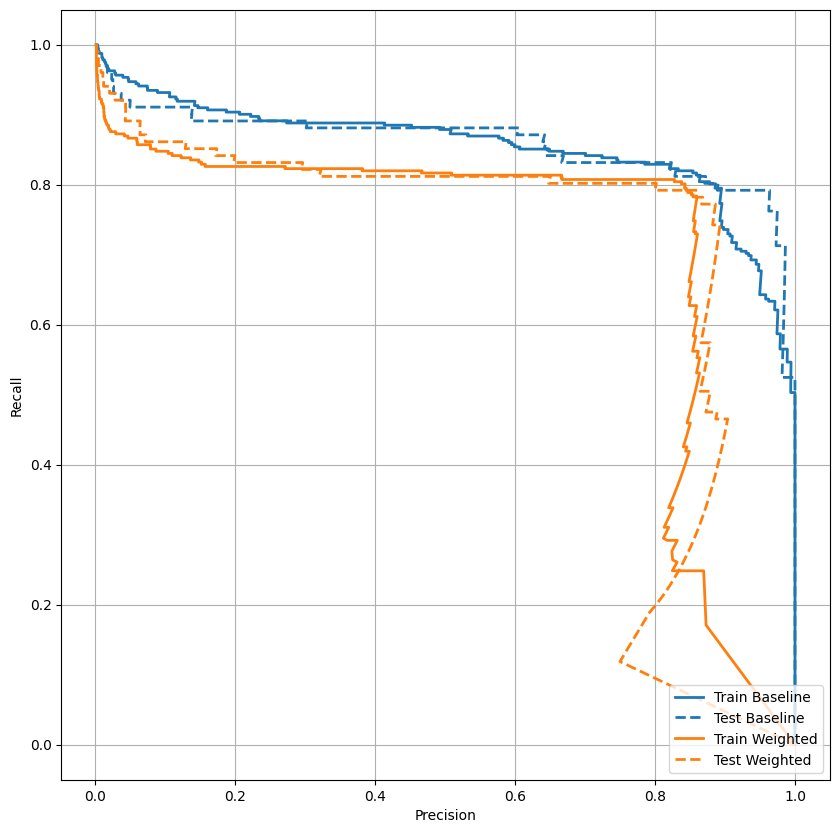

In [40]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

## オーバーサンプリング

### マイノリティクラスをオーバーサンプリングする

関連したアプローチとして、マイノリティクラスをオーバーサンプリングしてデータセットを再サンプルするという方法があります。

In [41]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

#### NumPy を使用する

陽性の例から適切な数のランダムインデックスを選択して、手動でデータセットのバランスをとることができます。

In [42]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(181954, 29)

In [43]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(363908, 29)

#### `tf.data`を使用する

もし`tf.data`を使用している場合、バランスの取れた例を作成する最も簡単な方法は、`positive`と`negative`のデータセットから開始し、それらをマージすることです。その他の例については、[tf.data ガイド](../../guide/data.ipynb)をご覧ください。

In [44]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

各データセットは`(feature, label)`のペアを提供します。

In [45]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [-2.19541086  1.13428993 -1.53623679 -0.33658631 -0.83969674 -1.57367972
 -1.68012623  0.22759802  0.26401501 -3.5197414   2.45072394 -3.59505942
 -1.02811684 -5.          1.80441222 -3.70754897 -5.         -2.22095608
 -0.01134361 -0.93004871  0.75601008 -0.0947461  -1.75493901  0.44294128
 -0.03893845 -2.00270316 -2.29191024  0.00709538  0.57125601]

Label:  1


`tf.data.Dataset.sample_from_datasets` を使用し、この 2 つをマージします。

In [46]:
resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [47]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.47705078125


このデータセットを使用するには、エポックごとのステップ数が必要です。

この場合の「エポック」の定義はあまり明確ではありません。それぞれの陰性の例を 1 度見るのに必要なバッチ数だとしましょう。

In [48]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

278.0

### オーバーサンプリングデータをトレーニングする

ここで、クラスの重みを使用する代わりに、再サンプルされたデータセットを使用してモデルをトレーニングし、それらの手法がどう比較されるかを確認してみましょう。

注意: 陽性の例を複製することでデータのバランスをとっているため、データセットの総サイズは大きくなり、各エポックではより多くのトレーニングステップが実行されます。 

In [49]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds)

Epoch 1/100


  1/278 [..............................] - ETA: 7:04 - loss: 1.3562 - tp: 424.0000 - fp: 241.0000 - tn: 57664.0000 - fn: 681.0000 - accuracy: 0.9844 - precision: 0.6376 - recall: 0.3837 - auc: 0.9152 - prc: 0.5123

  6/278 [..............................] - ETA: 3s - loss: 1.3267 - tp: 2340.0000 - fp: 1465.0000 - tn: 61518.0000 - fn: 3927.0000 - accuracy: 0.9221 - precision: 0.6150 - recall: 0.3734 - auc: 0.8806 - prc: 0.5655

  9/278 [..............................] - ETA: 4s - loss: 1.2621 - tp: 3673.0000 - fp: 2273.0000 - tn: 63769.0000 - fn: 5679.0000 - accuracy: 0.8945 - precision: 0.6177 - recall: 0.3928 - auc: 0.8717 - prc: 0.5934

 12/278 [>.............................] - ETA: 4s - loss: 1.1991 - tp: 5133.0000 - fp: 3052.0000 - tn: 66078.0000 - fn: 7275.0000 - accuracy: 0.8733 - precision: 0.6271 - recall: 0.4137 - auc: 0.8648 - prc: 0.6180

 15/278 [>.............................] - ETA: 4s - loss: 1.1482 - tp: 6792.0000 - fp: 3867.0000 - tn: 68268.0000 - fn: 8755.0000 - accuracy: 0.8560 - precision: 0.6372 - recall: 0.4369 - auc: 0.8595 - prc: 0.6417

 18/278 [>.............................] - ETA: 4s - loss: 1.1031 - tp: 8472.0000 - fp: 4689.0000 - tn: 70543.0000 - fn: 10122.0000 - accuracy: 0.8421 - precision: 0.6437 - recall: 0.4556 - auc: 0.8537 - prc: 0.6583

 21/278 [=>............................] - ETA: 4s - loss: 1.0614 - tp: 10315.0000 - fp: 5505.0000 - tn: 72782.0000 - fn: 11368.0000 - accuracy: 0.8312 - precision: 0.6520 - recall: 0.4757 - auc: 0.8497 - prc: 0.6757

 24/278 [=>............................] - ETA: 4s - loss: 1.0258 - tp: 12151.0000 - fp: 6364.0000 - tn: 75032.0000 - fn: 12567.0000 - accuracy: 0.8216 - precision: 0.6563 - recall: 0.4916 - auc: 0.8458 - prc: 0.6886

 27/278 [=>............................] - ETA: 4s - loss: 0.9908 - tp: 14108.0000 - fp: 7213.0000 - tn: 77283.0000 - fn: 13654.0000 - accuracy: 0.8141 - precision: 0.6617 - recall: 0.5082 - auc: 0.8431 - prc: 0.7018

 30/278 [==>...........................] - ETA: 4s - loss: 0.9596 - tp: 16154.0000 - fp: 8065.0000 - tn: 79487.0000 - fn: 14696.0000 - accuracy: 0.8078 - precision: 0.6670 - recall: 0.5236 - auc: 0.8412 - prc: 0.7146

 33/278 [==>...........................] - ETA: 4s - loss: 0.9281 - tp: 18302.0000 - fp: 8863.0000 - tn: 81744.0000 - fn: 15637.0000 - accuracy: 0.8033 - precision: 0.6737 - recall: 0.5393 - auc: 0.8405 - prc: 0.7277

 36/278 [==>...........................] - ETA: 4s - loss: 0.9026 - tp: 20492.0000 - fp: 9765.0000 - tn: 83905.0000 - fn: 16528.0000 - accuracy: 0.7988 - precision: 0.6773 - recall: 0.5535 - auc: 0.8395 - prc: 0.7380

 39/278 [===>..........................] - ETA: 4s - loss: 0.8775 - tp: 22681.0000 - fp: 10669.0000 - tn: 86153.0000 - fn: 17331.0000 - accuracy: 0.7954 - precision: 0.6801 - recall: 0.5669 - auc: 0.8388 - prc: 0.7471

 42/278 [===>..........................] - ETA: 4s - loss: 0.8558 - tp: 24934.0000 - fp: 11557.0000 - tn: 88325.0000 - fn: 18162.0000 - accuracy: 0.7921 - precision: 0.6833 - recall: 0.5786 - auc: 0.8384 - prc: 0.7556

 45/278 [===>..........................] - ETA: 4s - loss: 0.8360 - tp: 27278.0000 - fp: 12410.0000 - tn: 90496.0000 - fn: 18938.0000 - accuracy: 0.7898 - precision: 0.6873 - recall: 0.5902 - auc: 0.8384 - prc: 0.7638

 48/278 [====>.........................] - ETA: 4s - loss: 0.8169 - tp: 29593.0000 - fp: 13254.0000 - tn: 92729.0000 - fn: 19690.0000 - accuracy: 0.7878 - precision: 0.6907 - recall: 0.6005 - auc: 0.8385 - prc: 0.7715

 51/278 [====>.........................] - ETA: 4s - loss: 0.7994 - tp: 31904.0000 - fp: 14094.0000 - tn: 95021.0000 - fn: 20391.0000 - accuracy: 0.7864 - precision: 0.6936 - recall: 0.6101 - auc: 0.8386 - prc: 0.7781

 54/278 [====>.........................] - ETA: 4s - loss: 0.7837 - tp: 34289.0000 - fp: 14896.0000 - tn: 97259.0000 - fn: 21110.0000 - accuracy: 0.7851 - precision: 0.6971 - recall: 0.6189 - auc: 0.8390 - prc: 0.7844

 57/278 [=====>........................] - ETA: 4s - loss: 0.7688 - tp: 36681.0000 - fp: 15732.0000 - tn: 99512.0000 - fn: 21773.0000 - accuracy: 0.7841 - precision: 0.6998 - recall: 0.6275 - auc: 0.8394 - prc: 0.7903

 60/278 [=====>........................] - ETA: 4s - loss: 0.7542 - tp: 39108.0000 - fp: 16530.0000 - tn: 101822.0000 - fn: 22382.0000 - accuracy: 0.7836 - precision: 0.7029 - recall: 0.6360 - auc: 0.8402 - prc: 0.7961

 63/278 [=====>........................] - ETA: 4s - loss: 0.7405 - tp: 41581.0000 - fp: 17274.0000 - tn: 104135.0000 - fn: 22996.0000 - accuracy: 0.7835 - precision: 0.7065 - recall: 0.6439 - auc: 0.8411 - prc: 0.8017

 66/278 [======>.......................] - ETA: 4s - loss: 0.7282 - tp: 44031.0000 - fp: 17986.0000 - tn: 106506.0000 - fn: 23607.0000 - accuracy: 0.7835 - precision: 0.7100 - recall: 0.6510 - auc: 0.8418 - prc: 0.8066

 69/278 [======>.......................] - ETA: 4s - loss: 0.7158 - tp: 46535.0000 - fp: 18682.0000 - tn: 108842.0000 - fn: 24215.0000 - accuracy: 0.7836 - precision: 0.7135 - recall: 0.6577 - auc: 0.8428 - prc: 0.8116

 72/278 [======>.......................] - ETA: 4s - loss: 0.7045 - tp: 48962.0000 - fp: 19390.0000 - tn: 111248.0000 - fn: 24818.0000 - accuracy: 0.7837 - precision: 0.7163 - recall: 0.6636 - auc: 0.8437 - prc: 0.8159

 75/278 [=======>......................] - ETA: 4s - loss: 0.6939 - tp: 51413.0000 - fp: 20057.0000 - tn: 113681.0000 - fn: 25411.0000 - accuracy: 0.7841 - precision: 0.7194 - recall: 0.6692 - auc: 0.8446 - prc: 0.8200

 78/278 [=======>......................] - ETA: 3s - loss: 0.6841 - tp: 53868.0000 - fp: 20705.0000 - tn: 116092.0000 - fn: 26041.0000 - accuracy: 0.7843 - precision: 0.7224 - recall: 0.6741 - auc: 0.8455 - prc: 0.8238

 81/278 [=======>......................] - ETA: 3s - loss: 0.6746 - tp: 56379.0000 - fp: 21348.0000 - tn: 118505.0000 - fn: 26618.0000 - accuracy: 0.7848 - precision: 0.7253 - recall: 0.6793 - auc: 0.8465 - prc: 0.8275

 84/278 [========>.....................] - ETA: 3s - loss: 0.6656 - tp: 58934.0000 - fp: 21963.0000 - tn: 120878.0000 - fn: 27219.0000 - accuracy: 0.7852 - precision: 0.7285 - recall: 0.6841 - auc: 0.8475 - prc: 0.8312

 87/278 [========>.....................] - ETA: 3s - loss: 0.6568 - tp: 61438.0000 - fp: 22601.0000 - tn: 123324.0000 - fn: 27775.0000 - accuracy: 0.7858 - precision: 0.7311 - recall: 0.6887 - auc: 0.8485 - prc: 0.8346

 90/278 [========>.....................] - ETA: 3s - loss: 0.6482 - tp: 64030.0000 - fp: 23198.0000 - tn: 125777.0000 - fn: 28277.0000 - accuracy: 0.7867 - precision: 0.7341 - recall: 0.6937 - auc: 0.8498 - prc: 0.8381

 93/278 [=========>....................] - ETA: 3s - loss: 0.6405 - tp: 66541.0000 - fp: 23835.0000 - tn: 128221.0000 - fn: 28829.0000 - accuracy: 0.7872 - precision: 0.7363 - recall: 0.6977 - auc: 0.8508 - prc: 0.8410

 96/278 [=========>....................] - ETA: 3s - loss: 0.6329 - tp: 69052.0000 - fp: 24425.0000 - tn: 130732.0000 - fn: 29361.0000 - accuracy: 0.7879 - precision: 0.7387 - recall: 0.7017 - auc: 0.8518 - prc: 0.8438

 99/278 [=========>....................] - ETA: 3s - loss: 0.6256 - tp: 71642.0000 - fp: 24983.0000 - tn: 133207.0000 - fn: 29882.0000 - accuracy: 0.7887 - precision: 0.7414 - recall: 0.7057 - auc: 0.8529 - prc: 0.8467

102/278 [==========>...................] - ETA: 3s - loss: 0.6183 - tp: 74192.0000 - fp: 25515.0000 - tn: 135762.0000 - fn: 30389.0000 - accuracy: 0.7897 - precision: 0.7441 - recall: 0.7094 - auc: 0.8541 - prc: 0.8495

105/278 [==========>...................] - ETA: 3s - loss: 0.6117 - tp: 76778.0000 - fp: 26053.0000 - tn: 138264.0000 - fn: 30907.0000 - accuracy: 0.7906 - precision: 0.7466 - recall: 0.7130 - auc: 0.8552 - prc: 0.8521

108/278 [==========>...................] - ETA: 3s - loss: 0.6050 - tp: 79421.0000 - fp: 26537.0000 - tn: 140760.0000 - fn: 31428.0000 - accuracy: 0.7916 - precision: 0.7496 - recall: 0.7165 - auc: 0.8564 - prc: 0.8548

111/278 [==========>...................] - ETA: 3s - loss: 0.5989 - tp: 81966.0000 - fp: 27087.0000 - tn: 143298.0000 - fn: 31939.0000 - accuracy: 0.7924 - precision: 0.7516 - recall: 0.7196 - auc: 0.8574 - prc: 0.8570

114/278 [===========>..................] - ETA: 3s - loss: 0.5927 - tp: 84644.0000 - fp: 27552.0000 - tn: 145800.0000 - fn: 32438.0000 - accuracy: 0.7934 - precision: 0.7544 - recall: 0.7229 - auc: 0.8586 - prc: 0.8595

117/278 [===========>..................] - ETA: 3s - loss: 0.5869 - tp: 87183.0000 - fp: 28070.0000 - tn: 148400.0000 - fn: 32925.0000 - accuracy: 0.7943 - precision: 0.7564 - recall: 0.7259 - auc: 0.8596 - prc: 0.8616

120/278 [===========>..................] - ETA: 3s - loss: 0.5813 - tp: 89776.0000 - fp: 28534.0000 - tn: 150998.0000 - fn: 33414.0000 - accuracy: 0.7954 - precision: 0.7588 - recall: 0.7288 - auc: 0.8607 - prc: 0.8638

123/278 [============>.................] - ETA: 3s - loss: 0.5758 - tp: 92413.0000 - fp: 28999.0000 - tn: 153554.0000 - fn: 33900.0000 - accuracy: 0.7964 - precision: 0.7612 - recall: 0.7316 - auc: 0.8618 - prc: 0.8659

126/278 [============>.................] - ETA: 3s - loss: 0.5701 - tp: 95068.0000 - fp: 29436.0000 - tn: 156126.0000 - fn: 34380.0000 - accuracy: 0.7974 - precision: 0.7636 - recall: 0.7344 - auc: 0.8630 - prc: 0.8681

129/278 [============>.................] - ETA: 3s - loss: 0.5646 - tp: 97664.0000 - fp: 29852.0000 - tn: 158810.0000 - fn: 34828.0000 - accuracy: 0.7986 - precision: 0.7659 - recall: 0.7371 - auc: 0.8641 - prc: 0.8701

132/278 [=============>................] - ETA: 2s - loss: 0.5597 - tp: 100267.0000 - fp: 30308.0000 - tn: 161416.0000 - fn: 35307.0000 - accuracy: 0.7995 - precision: 0.7679 - recall: 0.7396 - auc: 0.8651 - prc: 0.8718

135/278 [=============>................] - ETA: 2s - loss: 0.5547 - tp: 102936.0000 - fp: 30737.0000 - tn: 164017.0000 - fn: 35752.0000 - accuracy: 0.8006 - precision: 0.7701 - recall: 0.7422 - auc: 0.8663 - prc: 0.8737

138/278 [=============>................] - ETA: 2s - loss: 0.5500 - tp: 105517.0000 - fp: 31156.0000 - tn: 166710.0000 - fn: 36203.0000 - accuracy: 0.8016 - precision: 0.7720 - recall: 0.7445 - auc: 0.8673 - prc: 0.8754

141/278 [==============>...............] - ETA: 2s - loss: 0.5455 - tp: 108150.0000 - fp: 31592.0000 - tn: 169321.0000 - fn: 36667.0000 - accuracy: 0.8026 - precision: 0.7739 - recall: 0.7468 - auc: 0.8683 - prc: 0.8770

144/278 [==============>...............] - ETA: 2s - loss: 0.5409 - tp: 110787.0000 - fp: 31997.0000 - tn: 171980.0000 - fn: 37110.0000 - accuracy: 0.8036 - precision: 0.7759 - recall: 0.7491 - auc: 0.8693 - prc: 0.8787

147/278 [==============>...............] - ETA: 2s - loss: 0.5366 - tp: 113407.0000 - fp: 32385.0000 - tn: 174668.0000 - fn: 37558.0000 - accuracy: 0.8046 - precision: 0.7779 - recall: 0.7512 - auc: 0.8703 - prc: 0.8803

150/278 [===============>..............] - ETA: 2s - loss: 0.5324 - tp: 116026.0000 - fp: 32770.0000 - tn: 177338.0000 - fn: 38028.0000 - accuracy: 0.8056 - precision: 0.7798 - recall: 0.7532 - auc: 0.8713 - prc: 0.8817

153/278 [===============>..............] - ETA: 2s - loss: 0.5282 - tp: 118652.0000 - fp: 33154.0000 - tn: 180028.0000 - fn: 38472.0000 - accuracy: 0.8066 - precision: 0.7816 - recall: 0.7551 - auc: 0.8723 - prc: 0.8832

156/278 [===============>..............] - ETA: 2s - loss: 0.5241 - tp: 121307.0000 - fp: 33517.0000 - tn: 182697.0000 - fn: 38929.0000 - accuracy: 0.8076 - precision: 0.7835 - recall: 0.7571 - auc: 0.8733 - prc: 0.8847

159/278 [================>.............] - ETA: 2s - loss: 0.5202 - tp: 123988.0000 - fp: 33889.0000 - tn: 185330.0000 - fn: 39387.0000 - accuracy: 0.8085 - precision: 0.7853 - recall: 0.7589 - auc: 0.8743 - prc: 0.8861

162/278 [================>.............] - ETA: 2s - loss: 0.5165 - tp: 126617.0000 - fp: 34248.0000 - tn: 188018.0000 - fn: 39855.0000 - accuracy: 0.8094 - precision: 0.7871 - recall: 0.7606 - auc: 0.8752 - prc: 0.8875

165/278 [================>.............] - ETA: 2s - loss: 0.5127 - tp: 129274.0000 - fp: 34585.0000 - tn: 190732.0000 - fn: 40291.0000 - accuracy: 0.8104 - precision: 0.7889 - recall: 0.7624 - auc: 0.8761 - prc: 0.8888

168/278 [=================>............] - ETA: 2s - loss: 0.5089 - tp: 132071.0000 - fp: 34890.0000 - tn: 193349.0000 - fn: 40716.0000 - accuracy: 0.8115 - precision: 0.7910 - recall: 0.7644 - auc: 0.8771 - prc: 0.8903

171/278 [=================>............] - ETA: 2s - loss: 0.5052 - tp: 134684.0000 - fp: 35221.0000 - tn: 196133.0000 - fn: 41132.0000 - accuracy: 0.8125 - precision: 0.7927 - recall: 0.7661 - auc: 0.8781 - prc: 0.8915

174/278 [=================>............] - ETA: 2s - loss: 0.5018 - tp: 137328.0000 - fp: 35544.0000 - tn: 198871.0000 - fn: 41571.0000 - accuracy: 0.8134 - precision: 0.7944 - recall: 0.7676 - auc: 0.8790 - prc: 0.8927

177/278 [==================>...........] - ETA: 2s - loss: 0.4983 - tp: 139929.0000 - fp: 35849.0000 - tn: 201677.0000 - fn: 42003.0000 - accuracy: 0.8144 - precision: 0.7961 - recall: 0.7691 - auc: 0.8799 - prc: 0.8939

180/278 [==================>...........] - ETA: 1s - loss: 0.4949 - tp: 142595.0000 - fp: 36170.0000 - tn: 204419.0000 - fn: 42418.0000 - accuracy: 0.8153 - precision: 0.7977 - recall: 0.7707 - auc: 0.8807 - prc: 0.8950

183/278 [==================>...........] - ETA: 1s - loss: 0.4915 - tp: 145238.0000 - fp: 36493.0000 - tn: 207196.0000 - fn: 42819.0000 - accuracy: 0.8163 - precision: 0.7992 - recall: 0.7723 - auc: 0.8816 - prc: 0.8962

186/278 [===================>..........] - ETA: 1s - loss: 0.4884 - tp: 147870.0000 - fp: 36778.0000 - tn: 209987.0000 - fn: 43255.0000 - accuracy: 0.8172 - precision: 0.8008 - recall: 0.7737 - auc: 0.8824 - prc: 0.8972

189/278 [===================>..........] - ETA: 1s - loss: 0.4852 - tp: 150543.0000 - fp: 37046.0000 - tn: 212781.0000 - fn: 43664.0000 - accuracy: 0.8182 - precision: 0.8025 - recall: 0.7752 - auc: 0.8833 - prc: 0.8983

192/278 [===================>..........] - ETA: 1s - loss: 0.4820 - tp: 153177.0000 - fp: 37328.0000 - tn: 215591.0000 - fn: 44082.0000 - accuracy: 0.8192 - precision: 0.8041 - recall: 0.7765 - auc: 0.8842 - prc: 0.8994

195/278 [====================>.........] - ETA: 1s - loss: 0.4790 - tp: 155867.0000 - fp: 37593.0000 - tn: 218359.0000 - fn: 44503.0000 - accuracy: 0.8201 - precision: 0.8057 - recall: 0.7779 - auc: 0.8850 - prc: 0.9004

198/278 [====================>.........] - ETA: 1s - loss: 0.4760 - tp: 158542.0000 - fp: 37866.0000 - tn: 221167.0000 - fn: 44891.0000 - accuracy: 0.8211 - precision: 0.8072 - recall: 0.7793 - auc: 0.8858 - prc: 0.9014

201/278 [====================>.........] - ETA: 1s - loss: 0.4732 - tp: 161182.0000 - fp: 38154.0000 - tn: 223988.0000 - fn: 45286.0000 - accuracy: 0.8219 - precision: 0.8086 - recall: 0.7807 - auc: 0.8867 - prc: 0.9023

204/278 [=====================>........] - ETA: 1s - loss: 0.4704 - tp: 163843.0000 - fp: 38426.0000 - tn: 226789.0000 - fn: 45696.0000 - accuracy: 0.8228 - precision: 0.8100 - recall: 0.7819 - auc: 0.8874 - prc: 0.9033

207/278 [=====================>........] - ETA: 1s - loss: 0.4676 - tp: 166550.0000 - fp: 38701.0000 - tn: 229552.0000 - fn: 46095.0000 - accuracy: 0.8237 - precision: 0.8114 - recall: 0.7832 - auc: 0.8883 - prc: 0.9043

210/278 [=====================>........] - ETA: 1s - loss: 0.4646 - tp: 169273.0000 - fp: 38945.0000 - tn: 232336.0000 - fn: 46488.0000 - accuracy: 0.8246 - precision: 0.8130 - recall: 0.7845 - auc: 0.8891 - prc: 0.9053

213/278 [=====================>........] - ETA: 1s - loss: 0.4619 - tp: 172020.0000 - fp: 39172.0000 - tn: 235088.0000 - fn: 46906.0000 - accuracy: 0.8255 - precision: 0.8145 - recall: 0.7857 - auc: 0.8899 - prc: 0.9062

216/278 [======================>.......] - ETA: 1s - loss: 0.4593 - tp: 174642.0000 - fp: 39429.0000 - tn: 237941.0000 - fn: 47318.0000 - accuracy: 0.8263 - precision: 0.8158 - recall: 0.7868 - auc: 0.8906 - prc: 0.9070

219/278 [======================>.......] - ETA: 1s - loss: 0.4566 - tp: 177380.0000 - fp: 39643.0000 - tn: 240758.0000 - fn: 47693.0000 - accuracy: 0.8272 - precision: 0.8173 - recall: 0.7881 - auc: 0.8915 - prc: 0.9080

222/278 [======================>.......] - ETA: 1s - loss: 0.4540 - tp: 180114.0000 - fp: 39880.0000 - tn: 243545.0000 - fn: 48079.0000 - accuracy: 0.8281 - precision: 0.8187 - recall: 0.7893 - auc: 0.8922 - prc: 0.9088

225/278 [=======================>......] - ETA: 1s - loss: 0.4514 - tp: 182805.0000 - fp: 40105.0000 - tn: 246368.0000 - fn: 48484.0000 - accuracy: 0.8289 - precision: 0.8201 - recall: 0.7904 - auc: 0.8930 - prc: 0.9097

228/278 [=======================>......] - ETA: 1s - loss: 0.4489 - tp: 185476.0000 - fp: 40297.0000 - tn: 249275.0000 - fn: 48858.0000 - accuracy: 0.8298 - precision: 0.8215 - recall: 0.7915 - auc: 0.8937 - prc: 0.9105

231/278 [=======================>......] - ETA: 0s - loss: 0.4464 - tp: 188101.0000 - fp: 40524.0000 - tn: 252164.0000 - fn: 49261.0000 - accuracy: 0.8306 - precision: 0.8227 - recall: 0.7925 - auc: 0.8944 - prc: 0.9113

234/278 [========================>.....] - ETA: 0s - loss: 0.4439 - tp: 190810.0000 - fp: 40754.0000 - tn: 255006.0000 - fn: 49624.0000 - accuracy: 0.8314 - precision: 0.8240 - recall: 0.7936 - auc: 0.8952 - prc: 0.9121

237/278 [========================>.....] - ETA: 0s - loss: 0.4415 - tp: 193516.0000 - fp: 40960.0000 - tn: 257839.0000 - fn: 50023.0000 - accuracy: 0.8322 - precision: 0.8253 - recall: 0.7946 - auc: 0.8959 - prc: 0.9128

240/278 [========================>.....] - ETA: 0s - loss: 0.4391 - tp: 196236.0000 - fp: 41171.0000 - tn: 260660.0000 - fn: 50415.0000 - accuracy: 0.8330 - precision: 0.8266 - recall: 0.7956 - auc: 0.8966 - prc: 0.9136

243/278 [=========================>....] - ETA: 0s - loss: 0.4369 - tp: 198961.0000 - fp: 41386.0000 - tn: 263464.0000 - fn: 50815.0000 - accuracy: 0.8338 - precision: 0.8278 - recall: 0.7966 - auc: 0.8973 - prc: 0.9144

246/278 [=========================>....] - ETA: 0s - loss: 0.4345 - tp: 201663.0000 - fp: 41620.0000 - tn: 266306.0000 - fn: 51181.0000 - accuracy: 0.8345 - precision: 0.8289 - recall: 0.7976 - auc: 0.8980 - prc: 0.9151

249/278 [=========================>....] - ETA: 0s - loss: 0.4323 - tp: 204337.0000 - fp: 41797.0000 - tn: 269222.0000 - fn: 51558.0000 - accuracy: 0.8353 - precision: 0.8302 - recall: 0.7985 - auc: 0.8987 - prc: 0.9158

252/278 [==========================>...] - ETA: 0s - loss: 0.4301 - tp: 207006.0000 - fp: 41996.0000 - tn: 272108.0000 - fn: 51948.0000 - accuracy: 0.8361 - precision: 0.8313 - recall: 0.7994 - auc: 0.8994 - prc: 0.9165

255/278 [==========================>...] - ETA: 0s - loss: 0.4279 - tp: 209640.0000 - fp: 42194.0000 - tn: 275060.0000 - fn: 52308.0000 - accuracy: 0.8368 - precision: 0.8325 - recall: 0.8003 - auc: 0.9000 - prc: 0.9171

258/278 [==========================>...] - ETA: 0s - loss: 0.4259 - tp: 212338.0000 - fp: 42394.0000 - tn: 277920.0000 - fn: 52694.0000 - accuracy: 0.8376 - precision: 0.8336 - recall: 0.8012 - auc: 0.9007 - prc: 0.9178

261/278 [===========================>..] - ETA: 0s - loss: 0.4239 - tp: 215051.0000 - fp: 42600.0000 - tn: 280776.0000 - fn: 53063.0000 - accuracy: 0.8383 - precision: 0.8347 - recall: 0.8021 - auc: 0.9013 - prc: 0.9184

264/278 [===========================>..] - ETA: 0s - loss: 0.4218 - tp: 217737.0000 - fp: 42785.0000 - tn: 283673.0000 - fn: 53439.0000 - accuracy: 0.8390 - precision: 0.8358 - recall: 0.8029 - auc: 0.9019 - prc: 0.9191

267/278 [===========================>..] - ETA: 0s - loss: 0.4197 - tp: 220426.0000 - fp: 42982.0000 - tn: 286562.0000 - fn: 53808.0000 - accuracy: 0.8397 - precision: 0.8368 - recall: 0.8038 - auc: 0.9026 - prc: 0.9197

270/278 [============================>.] - ETA: 0s - loss: 0.4177 - tp: 223099.0000 - fp: 43172.0000 - tn: 289466.0000 - fn: 54185.0000 - accuracy: 0.8404 - precision: 0.8379 - recall: 0.8046 - auc: 0.9032 - prc: 0.9203

273/278 [============================>.] - ETA: 0s - loss: 0.4158 - tp: 225796.0000 - fp: 43336.0000 - tn: 292390.0000 - fn: 54544.0000 - accuracy: 0.8411 - precision: 0.8390 - recall: 0.8054 - auc: 0.9038 - prc: 0.9209

276/278 [============================>.] - ETA: 0s - loss: 0.4139 - tp: 228480.0000 - fp: 43527.0000 - tn: 295302.0000 - fn: 54901.0000 - accuracy: 0.8418 - precision: 0.8400 - recall: 0.8063 - auc: 0.9044 - prc: 0.9215

278/278 [==============================] - 8s 22ms/step - loss: 0.4126 - tp: 230239.0000 - fp: 43658.0000 - tn: 297273.0000 - fn: 55136.0000 - accuracy: 0.8423 - precision: 0.8406 - recall: 0.8068 - auc: 0.9048 - prc: 0.9219 - val_loss: 0.1683 - val_tp: 59.0000 - val_fp: 593.0000 - val_tn: 44907.0000 - val_fn: 10.0000 - val_accuracy: 0.9868 - val_precision: 0.0905 - val_recall: 0.8551 - val_auc: 0.9705 - val_prc: 0.6726


Epoch 2/100


  1/278 [..............................] - ETA: 2s - loss: 0.2432 - tp: 919.0000 - fp: 61.0000 - tn: 938.0000 - fn: 130.0000 - accuracy: 0.9067 - precision: 0.9378 - recall: 0.8761 - auc: 0.9572 - prc: 0.9684

  5/278 [..............................] - ETA: 4s - loss: 0.2384 - tp: 4562.0000 - fp: 309.0000 - tn: 4731.0000 - fn: 638.0000 - accuracy: 0.9075 - precision: 0.9366 - recall: 0.8773 - auc: 0.9584 - prc: 0.9695

  8/278 [..............................] - ETA: 4s - loss: 0.2346 - tp: 7322.0000 - fp: 485.0000 - tn: 7586.0000 - fn: 991.0000 - accuracy: 0.9099 - precision: 0.9379 - recall: 0.8808 - auc: 0.9596 - prc: 0.9707

 11/278 [>.............................] - ETA: 5s - loss: 0.2325 - tp: 10073.0000 - fp: 662.0000 - tn: 10451.0000 - fn: 1342.0000 - accuracy: 0.9110 - precision: 0.9383 - recall: 0.8824 - auc: 0.9603 - prc: 0.9712

 14/278 [>.............................] - ETA: 5s - loss: 0.2328 - tp: 12799.0000 - fp: 838.0000 - tn: 13326.0000 - fn: 1709.0000 - accuracy: 0.9112 - precision: 0.9385 - recall: 0.8822 - auc: 0.9602 - prc: 0.9710

 17/278 [>.............................] - ETA: 5s - loss: 0.2316 - tp: 15498.0000 - fp: 998.0000 - tn: 16243.0000 - fn: 2077.0000 - accuracy: 0.9117 - precision: 0.9395 - recall: 0.8818 - auc: 0.9606 - prc: 0.9712

 20/278 [=>............................] - ETA: 5s - loss: 0.2303 - tp: 18182.0000 - fp: 1163.0000 - tn: 19191.0000 - fn: 2424.0000 - accuracy: 0.9124 - precision: 0.9399 - recall: 0.8824 - auc: 0.9609 - prc: 0.9713

 23/278 [=>............................] - ETA: 5s - loss: 0.2299 - tp: 20837.0000 - fp: 1355.0000 - tn: 22137.0000 - fn: 2775.0000 - accuracy: 0.9123 - precision: 0.9389 - recall: 0.8825 - auc: 0.9612 - prc: 0.9712

 26/278 [=>............................] - ETA: 5s - loss: 0.2297 - tp: 23519.0000 - fp: 1506.0000 - tn: 25084.0000 - fn: 3139.0000 - accuracy: 0.9128 - precision: 0.9398 - recall: 0.8822 - auc: 0.9611 - prc: 0.9712

 29/278 [==>...........................] - ETA: 5s - loss: 0.2291 - tp: 26255.0000 - fp: 1687.0000 - tn: 27933.0000 - fn: 3517.0000 - accuracy: 0.9124 - precision: 0.9396 - recall: 0.8819 - auc: 0.9613 - prc: 0.9714

 32/278 [==>...........................] - ETA: 5s - loss: 0.2288 - tp: 28996.0000 - fp: 1835.0000 - tn: 30835.0000 - fn: 3870.0000 - accuracy: 0.9129 - precision: 0.9405 - recall: 0.8822 - auc: 0.9613 - prc: 0.9714

 35/278 [==>...........................] - ETA: 5s - loss: 0.2286 - tp: 31689.0000 - fp: 1983.0000 - tn: 33791.0000 - fn: 4217.0000 - accuracy: 0.9135 - precision: 0.9411 - recall: 0.8826 - auc: 0.9614 - prc: 0.9714

 38/278 [===>..........................] - ETA: 4s - loss: 0.2285 - tp: 34377.0000 - fp: 2161.0000 - tn: 36696.0000 - fn: 4590.0000 - accuracy: 0.9133 - precision: 0.9409 - recall: 0.8822 - auc: 0.9614 - prc: 0.9714

 41/278 [===>..........................] - ETA: 4s - loss: 0.2280 - tp: 37080.0000 - fp: 2313.0000 - tn: 39610.0000 - fn: 4965.0000 - accuracy: 0.9133 - precision: 0.9413 - recall: 0.8819 - auc: 0.9616 - prc: 0.9715

 44/278 [===>..........................] - ETA: 4s - loss: 0.2271 - tp: 39809.0000 - fp: 2462.0000 - tn: 42537.0000 - fn: 5304.0000 - accuracy: 0.9138 - precision: 0.9418 - recall: 0.8824 - auc: 0.9618 - prc: 0.9717

 47/278 [====>.........................] - ETA: 4s - loss: 0.2265 - tp: 42481.0000 - fp: 2613.0000 - tn: 45513.0000 - fn: 5649.0000 - accuracy: 0.9142 - precision: 0.9421 - recall: 0.8826 - auc: 0.9620 - prc: 0.9717

 50/278 [====>.........................] - ETA: 4s - loss: 0.2265 - tp: 45163.0000 - fp: 2781.0000 - tn: 48448.0000 - fn: 6008.0000 - accuracy: 0.9142 - precision: 0.9420 - recall: 0.8826 - auc: 0.9619 - prc: 0.9717

 53/278 [====>.........................] - ETA: 4s - loss: 0.2259 - tp: 47874.0000 - fp: 2943.0000 - tn: 51354.0000 - fn: 6373.0000 - accuracy: 0.9142 - precision: 0.9421 - recall: 0.8825 - auc: 0.9622 - prc: 0.9719

 56/278 [=====>........................] - ETA: 4s - loss: 0.2254 - tp: 50548.0000 - fp: 3099.0000 - tn: 54316.0000 - fn: 6725.0000 - accuracy: 0.9143 - precision: 0.9422 - recall: 0.8826 - auc: 0.9624 - prc: 0.9719

 59/278 [=====>........................] - ETA: 4s - loss: 0.2248 - tp: 53332.0000 - fp: 3253.0000 - tn: 57160.0000 - fn: 7087.0000 - accuracy: 0.9144 - precision: 0.9425 - recall: 0.8827 - auc: 0.9627 - prc: 0.9721

 62/278 [=====>........................] - ETA: 4s - loss: 0.2244 - tp: 56134.0000 - fp: 3399.0000 - tn: 60014.0000 - fn: 7429.0000 - accuracy: 0.9147 - precision: 0.9429 - recall: 0.8831 - auc: 0.9628 - prc: 0.9723

 65/278 [======>.......................] - ETA: 4s - loss: 0.2235 - tp: 58879.0000 - fp: 3520.0000 - tn: 62954.0000 - fn: 7767.0000 - accuracy: 0.9152 - precision: 0.9436 - recall: 0.8835 - auc: 0.9631 - prc: 0.9725

 68/278 [======>.......................] - ETA: 4s - loss: 0.2231 - tp: 61608.0000 - fp: 3666.0000 - tn: 65876.0000 - fn: 8114.0000 - accuracy: 0.9154 - precision: 0.9438 - recall: 0.8836 - auc: 0.9633 - prc: 0.9726

 71/278 [======>.......................] - ETA: 4s - loss: 0.2222 - tp: 64383.0000 - fp: 3823.0000 - tn: 68765.0000 - fn: 8437.0000 - accuracy: 0.9157 - precision: 0.9439 - recall: 0.8841 - auc: 0.9636 - prc: 0.9728

 74/278 [======>.......................] - ETA: 4s - loss: 0.2214 - tp: 67126.0000 - fp: 3947.0000 - tn: 71692.0000 - fn: 8787.0000 - accuracy: 0.9160 - precision: 0.9445 - recall: 0.8842 - auc: 0.9638 - prc: 0.9730

 77/278 [=======>......................] - ETA: 4s - loss: 0.2205 - tp: 69855.0000 - fp: 4079.0000 - tn: 74664.0000 - fn: 9098.0000 - accuracy: 0.9164 - precision: 0.9448 - recall: 0.8848 - auc: 0.9641 - prc: 0.9732

 80/278 [=======>......................] - ETA: 4s - loss: 0.2199 - tp: 72640.0000 - fp: 4216.0000 - tn: 77538.0000 - fn: 9446.0000 - accuracy: 0.9166 - precision: 0.9451 - recall: 0.8849 - auc: 0.9644 - prc: 0.9733

 83/278 [=======>......................] - ETA: 4s - loss: 0.2197 - tp: 75362.0000 - fp: 4353.0000 - tn: 80471.0000 - fn: 9798.0000 - accuracy: 0.9168 - precision: 0.9454 - recall: 0.8849 - auc: 0.9644 - prc: 0.9734

 86/278 [========>.....................] - ETA: 3s - loss: 0.2193 - tp: 78124.0000 - fp: 4480.0000 - tn: 83381.0000 - fn: 10143.0000 - accuracy: 0.9170 - precision: 0.9458 - recall: 0.8851 - auc: 0.9646 - prc: 0.9735

 89/278 [========>.....................] - ETA: 3s - loss: 0.2189 - tp: 80817.0000 - fp: 4615.0000 - tn: 86372.0000 - fn: 10468.0000 - accuracy: 0.9173 - precision: 0.9460 - recall: 0.8853 - auc: 0.9648 - prc: 0.9736

 92/278 [========>.....................] - ETA: 3s - loss: 0.2184 - tp: 83554.0000 - fp: 4745.0000 - tn: 89287.0000 - fn: 10830.0000 - accuracy: 0.9173 - precision: 0.9463 - recall: 0.8853 - auc: 0.9649 - prc: 0.9736

 95/278 [=========>....................] - ETA: 3s - loss: 0.2181 - tp: 86324.0000 - fp: 4889.0000 - tn: 92164.0000 - fn: 11183.0000 - accuracy: 0.9174 - precision: 0.9464 - recall: 0.8853 - auc: 0.9650 - prc: 0.9737

 98/278 [=========>....................] - ETA: 3s - loss: 0.2178 - tp: 89048.0000 - fp: 5022.0000 - tn: 95108.0000 - fn: 11526.0000 - accuracy: 0.9176 - precision: 0.9466 - recall: 0.8854 - auc: 0.9652 - prc: 0.9738

101/278 [=========>....................] - ETA: 3s - loss: 0.2174 - tp: 91785.0000 - fp: 5156.0000 - tn: 98034.0000 - fn: 11873.0000 - accuracy: 0.9177 - precision: 0.9468 - recall: 0.8855 - auc: 0.9653 - prc: 0.9739

104/278 [==========>...................] - ETA: 3s - loss: 0.2172 - tp: 94525.0000 - fp: 5295.0000 - tn: 100953.0000 - fn: 12219.0000 - accuracy: 0.9178 - precision: 0.9470 - recall: 0.8855 - auc: 0.9654 - prc: 0.9739

107/278 [==========>...................] - ETA: 3s - loss: 0.2167 - tp: 97259.0000 - fp: 5431.0000 - tn: 103883.0000 - fn: 12563.0000 - accuracy: 0.9179 - precision: 0.9471 - recall: 0.8856 - auc: 0.9655 - prc: 0.9740

110/278 [==========>...................] - ETA: 3s - loss: 0.2162 - tp: 100016.0000 - fp: 5572.0000 - tn: 106799.0000 - fn: 12893.0000 - accuracy: 0.9180 - precision: 0.9472 - recall: 0.8858 - auc: 0.9657 - prc: 0.9742

113/278 [===========>..................] - ETA: 3s - loss: 0.2158 - tp: 102732.0000 - fp: 5702.0000 - tn: 109766.0000 - fn: 13224.0000 - accuracy: 0.9182 - precision: 0.9474 - recall: 0.8860 - auc: 0.9659 - prc: 0.9742

116/278 [===========>..................] - ETA: 3s - loss: 0.2152 - tp: 105436.0000 - fp: 5828.0000 - tn: 112759.0000 - fn: 13545.0000 - accuracy: 0.9185 - precision: 0.9476 - recall: 0.8862 - auc: 0.9660 - prc: 0.9743

119/278 [===========>..................] - ETA: 3s - loss: 0.2150 - tp: 108222.0000 - fp: 5960.0000 - tn: 115640.0000 - fn: 13890.0000 - accuracy: 0.9186 - precision: 0.9478 - recall: 0.8863 - auc: 0.9661 - prc: 0.9744

122/278 [============>.................] - ETA: 3s - loss: 0.2146 - tp: 110972.0000 - fp: 6107.0000 - tn: 118548.0000 - fn: 14229.0000 - accuracy: 0.9186 - precision: 0.9478 - recall: 0.8864 - auc: 0.9663 - prc: 0.9745

125/278 [============>.................] - ETA: 3s - loss: 0.2144 - tp: 113685.0000 - fp: 6259.0000 - tn: 121479.0000 - fn: 14577.0000 - accuracy: 0.9186 - precision: 0.9478 - recall: 0.8863 - auc: 0.9663 - prc: 0.9745

128/278 [============>.................] - ETA: 3s - loss: 0.2141 - tp: 116403.0000 - fp: 6393.0000 - tn: 124444.0000 - fn: 14904.0000 - accuracy: 0.9188 - precision: 0.9479 - recall: 0.8865 - auc: 0.9665 - prc: 0.9746

131/278 [=============>................] - ETA: 3s - loss: 0.2140 - tp: 119161.0000 - fp: 6537.0000 - tn: 127337.0000 - fn: 15253.0000 - accuracy: 0.9188 - precision: 0.9480 - recall: 0.8865 - auc: 0.9665 - prc: 0.9746

134/278 [=============>................] - ETA: 2s - loss: 0.2136 - tp: 121892.0000 - fp: 6664.0000 - tn: 130284.0000 - fn: 15592.0000 - accuracy: 0.9189 - precision: 0.9482 - recall: 0.8866 - auc: 0.9666 - prc: 0.9747

137/278 [=============>................] - ETA: 2s - loss: 0.2133 - tp: 124597.0000 - fp: 6794.0000 - tn: 133266.0000 - fn: 15919.0000 - accuracy: 0.9190 - precision: 0.9483 - recall: 0.8867 - auc: 0.9667 - prc: 0.9748

140/278 [==============>...............] - ETA: 2s - loss: 0.2129 - tp: 127285.0000 - fp: 6924.0000 - tn: 136275.0000 - fn: 16236.0000 - accuracy: 0.9192 - precision: 0.9484 - recall: 0.8869 - auc: 0.9668 - prc: 0.9748

143/278 [==============>...............] - ETA: 2s - loss: 0.2126 - tp: 130034.0000 - fp: 7070.0000 - tn: 139189.0000 - fn: 16571.0000 - accuracy: 0.9193 - precision: 0.9484 - recall: 0.8870 - auc: 0.9670 - prc: 0.9749

146/278 [==============>...............] - ETA: 2s - loss: 0.2121 - tp: 132772.0000 - fp: 7189.0000 - tn: 142170.0000 - fn: 16877.0000 - accuracy: 0.9195 - precision: 0.9486 - recall: 0.8872 - auc: 0.9671 - prc: 0.9750

149/278 [===============>..............] - ETA: 2s - loss: 0.2117 - tp: 135527.0000 - fp: 7333.0000 - tn: 145107.0000 - fn: 17185.0000 - accuracy: 0.9197 - precision: 0.9487 - recall: 0.8875 - auc: 0.9673 - prc: 0.9751

152/278 [===============>..............] - ETA: 2s - loss: 0.2113 - tp: 138251.0000 - fp: 7468.0000 - tn: 148059.0000 - fn: 17518.0000 - accuracy: 0.9197 - precision: 0.9488 - recall: 0.8875 - auc: 0.9674 - prc: 0.9751

155/278 [===============>..............] - ETA: 2s - loss: 0.2110 - tp: 141003.0000 - fp: 7601.0000 - tn: 150991.0000 - fn: 17845.0000 - accuracy: 0.9198 - precision: 0.9489 - recall: 0.8877 - auc: 0.9675 - prc: 0.9752

158/278 [================>.............] - ETA: 2s - loss: 0.2106 - tp: 143801.0000 - fp: 7718.0000 - tn: 153882.0000 - fn: 18183.0000 - accuracy: 0.9200 - precision: 0.9491 - recall: 0.8877 - auc: 0.9676 - prc: 0.9753

161/278 [================>.............] - ETA: 2s - loss: 0.2103 - tp: 146524.0000 - fp: 7850.0000 - tn: 156828.0000 - fn: 18526.0000 - accuracy: 0.9200 - precision: 0.9491 - recall: 0.8878 - auc: 0.9677 - prc: 0.9754

164/278 [================>.............] - ETA: 2s - loss: 0.2100 - tp: 149282.0000 - fp: 7980.0000 - tn: 159754.0000 - fn: 18856.0000 - accuracy: 0.9201 - precision: 0.9493 - recall: 0.8879 - auc: 0.9678 - prc: 0.9754

167/278 [=================>............] - ETA: 2s - loss: 0.2096 - tp: 151999.0000 - fp: 8104.0000 - tn: 162728.0000 - fn: 19185.0000 - accuracy: 0.9202 - precision: 0.9494 - recall: 0.8879 - auc: 0.9679 - prc: 0.9755

170/278 [=================>............] - ETA: 2s - loss: 0.2093 - tp: 154740.0000 - fp: 8232.0000 - tn: 165687.0000 - fn: 19501.0000 - accuracy: 0.9203 - precision: 0.9495 - recall: 0.8881 - auc: 0.9680 - prc: 0.9756

173/278 [=================>............] - ETA: 2s - loss: 0.2090 - tp: 157464.0000 - fp: 8362.0000 - tn: 168657.0000 - fn: 19821.0000 - accuracy: 0.9205 - precision: 0.9496 - recall: 0.8882 - auc: 0.9681 - prc: 0.9756

176/278 [=================>............] - ETA: 2s - loss: 0.2085 - tp: 160165.0000 - fp: 8474.0000 - tn: 171676.0000 - fn: 20133.0000 - accuracy: 0.9206 - precision: 0.9498 - recall: 0.8883 - auc: 0.9683 - prc: 0.9757

179/278 [==================>...........] - ETA: 2s - loss: 0.2081 - tp: 162910.0000 - fp: 8594.0000 - tn: 174630.0000 - fn: 20458.0000 - accuracy: 0.9208 - precision: 0.9499 - recall: 0.8884 - auc: 0.9684 - prc: 0.9758

182/278 [==================>...........] - ETA: 2s - loss: 0.2077 - tp: 165687.0000 - fp: 8704.0000 - tn: 177577.0000 - fn: 20768.0000 - accuracy: 0.9209 - precision: 0.9501 - recall: 0.8886 - auc: 0.9686 - prc: 0.9759

185/278 [==================>...........] - ETA: 1s - loss: 0.2074 - tp: 168462.0000 - fp: 8825.0000 - tn: 180510.0000 - fn: 21083.0000 - accuracy: 0.9211 - precision: 0.9502 - recall: 0.8888 - auc: 0.9687 - prc: 0.9760

188/278 [===================>..........] - ETA: 1s - loss: 0.2070 - tp: 171289.0000 - fp: 8951.0000 - tn: 183386.0000 - fn: 21398.0000 - accuracy: 0.9212 - precision: 0.9503 - recall: 0.8889 - auc: 0.9688 - prc: 0.9761

191/278 [===================>..........] - ETA: 1s - loss: 0.2067 - tp: 173992.0000 - fp: 9059.0000 - tn: 186398.0000 - fn: 21719.0000 - accuracy: 0.9213 - precision: 0.9505 - recall: 0.8890 - auc: 0.9689 - prc: 0.9761

194/278 [===================>..........] - ETA: 1s - loss: 0.2064 - tp: 176739.0000 - fp: 9182.0000 - tn: 189348.0000 - fn: 22043.0000 - accuracy: 0.9214 - precision: 0.9506 - recall: 0.8891 - auc: 0.9690 - prc: 0.9762

197/278 [====================>.........] - ETA: 1s - loss: 0.2061 - tp: 179449.0000 - fp: 9299.0000 - tn: 192333.0000 - fn: 22375.0000 - accuracy: 0.9215 - precision: 0.9507 - recall: 0.8891 - auc: 0.9691 - prc: 0.9762

200/278 [====================>.........] - ETA: 1s - loss: 0.2058 - tp: 182241.0000 - fp: 9427.0000 - tn: 195237.0000 - fn: 22695.0000 - accuracy: 0.9216 - precision: 0.9508 - recall: 0.8893 - auc: 0.9692 - prc: 0.9763

202/278 [====================>.........] - ETA: 1s - loss: 0.2056 - tp: 184106.0000 - fp: 9503.0000 - tn: 197187.0000 - fn: 22900.0000 - accuracy: 0.9217 - precision: 0.9509 - recall: 0.8894 - auc: 0.9692 - prc: 0.9764

205/278 [=====================>........] - ETA: 1s - loss: 0.2051 - tp: 186840.0000 - fp: 9621.0000 - tn: 200169.0000 - fn: 23210.0000 - accuracy: 0.9218 - precision: 0.9510 - recall: 0.8895 - auc: 0.9694 - prc: 0.9765

207/278 [=====================>........] - ETA: 1s - loss: 0.2050 - tp: 188639.0000 - fp: 9707.0000 - tn: 202164.0000 - fn: 23426.0000 - accuracy: 0.9218 - precision: 0.9511 - recall: 0.8895 - auc: 0.9695 - prc: 0.9765

210/278 [=====================>........] - ETA: 1s - loss: 0.2047 - tp: 191463.0000 - fp: 9809.0000 - tn: 205076.0000 - fn: 23732.0000 - accuracy: 0.9220 - precision: 0.9513 - recall: 0.8897 - auc: 0.9696 - prc: 0.9766

213/278 [=====================>........] - ETA: 1s - loss: 0.2044 - tp: 194206.0000 - fp: 9917.0000 - tn: 208034.0000 - fn: 24067.0000 - accuracy: 0.9221 - precision: 0.9514 - recall: 0.8897 - auc: 0.9696 - prc: 0.9766

216/278 [======================>.......] - ETA: 1s - loss: 0.2043 - tp: 196956.0000 - fp: 10048.0000 - tn: 210963.0000 - fn: 24401.0000 - accuracy: 0.9221 - precision: 0.9515 - recall: 0.8898 - auc: 0.9697 - prc: 0.9766

219/278 [======================>.......] - ETA: 1s - loss: 0.2040 - tp: 199720.0000 - fp: 10179.0000 - tn: 213907.0000 - fn: 24706.0000 - accuracy: 0.9222 - precision: 0.9515 - recall: 0.8899 - auc: 0.9698 - prc: 0.9767

222/278 [======================>.......] - ETA: 1s - loss: 0.2038 - tp: 202406.0000 - fp: 10272.0000 - tn: 216938.0000 - fn: 25040.0000 - accuracy: 0.9223 - precision: 0.9517 - recall: 0.8899 - auc: 0.9699 - prc: 0.9767

225/278 [=======================>......] - ETA: 1s - loss: 0.2034 - tp: 205137.0000 - fp: 10402.0000 - tn: 219924.0000 - fn: 25337.0000 - accuracy: 0.9224 - precision: 0.9517 - recall: 0.8901 - auc: 0.9700 - prc: 0.9768

228/278 [=======================>......] - ETA: 1s - loss: 0.2030 - tp: 207910.0000 - fp: 10506.0000 - tn: 222879.0000 - fn: 25649.0000 - accuracy: 0.9226 - precision: 0.9519 - recall: 0.8902 - auc: 0.9701 - prc: 0.9769

231/278 [=======================>......] - ETA: 0s - loss: 0.2028 - tp: 210640.0000 - fp: 10634.0000 - tn: 225856.0000 - fn: 25958.0000 - accuracy: 0.9227 - precision: 0.9519 - recall: 0.8903 - auc: 0.9702 - prc: 0.9769

234/278 [========================>.....] - ETA: 0s - loss: 0.2024 - tp: 213423.0000 - fp: 10754.0000 - tn: 228800.0000 - fn: 26255.0000 - accuracy: 0.9228 - precision: 0.9520 - recall: 0.8905 - auc: 0.9703 - prc: 0.9770

237/278 [========================>.....] - ETA: 0s - loss: 0.2022 - tp: 216176.0000 - fp: 10871.0000 - tn: 231778.0000 - fn: 26551.0000 - accuracy: 0.9229 - precision: 0.9521 - recall: 0.8906 - auc: 0.9704 - prc: 0.9771

240/278 [========================>.....] - ETA: 0s - loss: 0.2018 - tp: 218905.0000 - fp: 10982.0000 - tn: 234786.0000 - fn: 26847.0000 - accuracy: 0.9230 - precision: 0.9522 - recall: 0.8908 - auc: 0.9705 - prc: 0.9771

243/278 [=========================>....] - ETA: 0s - loss: 0.2015 - tp: 221691.0000 - fp: 11098.0000 - tn: 237713.0000 - fn: 27162.0000 - accuracy: 0.9231 - precision: 0.9523 - recall: 0.8909 - auc: 0.9706 - prc: 0.9772

246/278 [=========================>....] - ETA: 0s - loss: 0.2013 - tp: 224506.0000 - fp: 11218.0000 - tn: 240617.0000 - fn: 27467.0000 - accuracy: 0.9232 - precision: 0.9524 - recall: 0.8910 - auc: 0.9707 - prc: 0.9773

249/278 [=========================>....] - ETA: 0s - loss: 0.2010 - tp: 227291.0000 - fp: 11334.0000 - tn: 243551.0000 - fn: 27776.0000 - accuracy: 0.9233 - precision: 0.9525 - recall: 0.8911 - auc: 0.9708 - prc: 0.9773

252/278 [==========================>...] - ETA: 0s - loss: 0.2007 - tp: 230060.0000 - fp: 11450.0000 - tn: 246519.0000 - fn: 28067.0000 - accuracy: 0.9234 - precision: 0.9526 - recall: 0.8913 - auc: 0.9709 - prc: 0.9774

255/278 [==========================>...] - ETA: 0s - loss: 0.2005 - tp: 232868.0000 - fp: 11600.0000 - tn: 249389.0000 - fn: 28383.0000 - accuracy: 0.9234 - precision: 0.9526 - recall: 0.8914 - auc: 0.9710 - prc: 0.9775

258/278 [==========================>...] - ETA: 0s - loss: 0.2002 - tp: 235655.0000 - fp: 11710.0000 - tn: 252330.0000 - fn: 28689.0000 - accuracy: 0.9235 - precision: 0.9527 - recall: 0.8915 - auc: 0.9711 - prc: 0.9775

261/278 [===========================>..] - ETA: 0s - loss: 0.1999 - tp: 238440.0000 - fp: 11813.0000 - tn: 255273.0000 - fn: 29002.0000 - accuracy: 0.9236 - precision: 0.9528 - recall: 0.8916 - auc: 0.9712 - prc: 0.9776

264/278 [===========================>..] - ETA: 0s - loss: 0.1997 - tp: 241238.0000 - fp: 11928.0000 - tn: 258193.0000 - fn: 29313.0000 - accuracy: 0.9237 - precision: 0.9529 - recall: 0.8917 - auc: 0.9712 - prc: 0.9776

267/278 [===========================>..] - ETA: 0s - loss: 0.1994 - tp: 244024.0000 - fp: 12040.0000 - tn: 261133.0000 - fn: 29619.0000 - accuracy: 0.9238 - precision: 0.9530 - recall: 0.8918 - auc: 0.9713 - prc: 0.9777

270/278 [============================>.] - ETA: 0s - loss: 0.1992 - tp: 246779.0000 - fp: 12162.0000 - tn: 264102.0000 - fn: 29917.0000 - accuracy: 0.9239 - precision: 0.9530 - recall: 0.8919 - auc: 0.9714 - prc: 0.9777

273/278 [============================>.] - ETA: 0s - loss: 0.1989 - tp: 249561.0000 - fp: 12255.0000 - tn: 267065.0000 - fn: 30223.0000 - accuracy: 0.9240 - precision: 0.9532 - recall: 0.8920 - auc: 0.9715 - prc: 0.9778

276/278 [============================>.] - ETA: 0s - loss: 0.1986 - tp: 252381.0000 - fp: 12355.0000 - tn: 269995.0000 - fn: 30517.0000 - accuracy: 0.9242 - precision: 0.9533 - recall: 0.8921 - auc: 0.9716 - prc: 0.9779

278/278 [==============================] - 6s 22ms/step - loss: 0.1984 - tp: 254251.0000 - fp: 12432.0000 - tn: 271931.0000 - fn: 30730.0000 - accuracy: 0.9242 - precision: 0.9534 - recall: 0.8922 - auc: 0.9716 - prc: 0.9779 - val_loss: 0.0992 - val_tp: 59.0000 - val_fp: 605.0000 - val_tn: 44895.0000 - val_fn: 10.0000 - val_accuracy: 0.9865 - val_precision: 0.0889 - val_recall: 0.8551 - val_auc: 0.9667 - val_prc: 0.6655


Epoch 3/100


  1/278 [..............................] - ETA: 1s - loss: 0.1696 - tp: 954.0000 - fp: 37.0000 - tn: 951.0000 - fn: 106.0000 - accuracy: 0.9302 - precision: 0.9627 - recall: 0.9000 - auc: 0.9799 - prc: 0.9848

  5/278 [..............................] - ETA: 4s - loss: 0.1711 - tp: 4591.0000 - fp: 178.0000 - tn: 4937.0000 - fn: 534.0000 - accuracy: 0.9305 - precision: 0.9627 - recall: 0.8958 - auc: 0.9794 - prc: 0.9835

  8/278 [..............................] - ETA: 4s - loss: 0.1716 - tp: 7391.0000 - fp: 295.0000 - tn: 7882.0000 - fn: 816.0000 - accuracy: 0.9322 - precision: 0.9616 - recall: 0.9006 - auc: 0.9795 - prc: 0.9835

 11/278 [>.............................] - ETA: 4s - loss: 0.1728 - tp: 10181.0000 - fp: 419.0000 - tn: 10808.0000 - fn: 1120.0000 - accuracy: 0.9317 - precision: 0.9605 - recall: 0.9009 - auc: 0.9792 - prc: 0.9833

 14/278 [>.............................] - ETA: 4s - loss: 0.1707 - tp: 12930.0000 - fp: 513.0000 - tn: 13814.0000 - fn: 1415.0000 - accuracy: 0.9328 - precision: 0.9618 - recall: 0.9014 - auc: 0.9799 - prc: 0.9836

 17/278 [>.............................] - ETA: 5s - loss: 0.1705 - tp: 15751.0000 - fp: 618.0000 - tn: 16731.0000 - fn: 1716.0000 - accuracy: 0.9330 - precision: 0.9622 - recall: 0.9018 - auc: 0.9797 - prc: 0.9837

 20/278 [=>............................] - ETA: 5s - loss: 0.1706 - tp: 18562.0000 - fp: 729.0000 - tn: 19656.0000 - fn: 2013.0000 - accuracy: 0.9331 - precision: 0.9622 - recall: 0.9022 - auc: 0.9797 - prc: 0.9837

 23/278 [=>............................] - ETA: 5s - loss: 0.1703 - tp: 21361.0000 - fp: 827.0000 - tn: 22590.0000 - fn: 2326.0000 - accuracy: 0.9331 - precision: 0.9627 - recall: 0.9018 - auc: 0.9798 - prc: 0.9837

 26/278 [=>............................] - ETA: 4s - loss: 0.1704 - tp: 24133.0000 - fp: 924.0000 - tn: 25559.0000 - fn: 2632.0000 - accuracy: 0.9332 - precision: 0.9631 - recall: 0.9017 - auc: 0.9798 - prc: 0.9837

 29/278 [==>...........................] - ETA: 4s - loss: 0.1709 - tp: 26974.0000 - fp: 1046.0000 - tn: 28463.0000 - fn: 2909.0000 - accuracy: 0.9334 - precision: 0.9627 - recall: 0.9027 - auc: 0.9797 - prc: 0.9836

 32/278 [==>...........................] - ETA: 4s - loss: 0.1715 - tp: 29757.0000 - fp: 1167.0000 - tn: 31404.0000 - fn: 3208.0000 - accuracy: 0.9332 - precision: 0.9623 - recall: 0.9027 - auc: 0.9796 - prc: 0.9835

 35/278 [==>...........................] - ETA: 4s - loss: 0.1716 - tp: 32464.0000 - fp: 1274.0000 - tn: 34423.0000 - fn: 3519.0000 - accuracy: 0.9331 - precision: 0.9622 - recall: 0.9022 - auc: 0.9796 - prc: 0.9835

 38/278 [===>..........................] - ETA: 4s - loss: 0.1714 - tp: 35257.0000 - fp: 1372.0000 - tn: 37359.0000 - fn: 3836.0000 - accuracy: 0.9331 - precision: 0.9625 - recall: 0.9019 - auc: 0.9797 - prc: 0.9835

 41/278 [===>..........................] - ETA: 4s - loss: 0.1710 - tp: 38021.0000 - fp: 1467.0000 - tn: 40364.0000 - fn: 4116.0000 - accuracy: 0.9335 - precision: 0.9628 - recall: 0.9023 - auc: 0.9797 - prc: 0.9836

 44/278 [===>..........................] - ETA: 4s - loss: 0.1710 - tp: 40812.0000 - fp: 1592.0000 - tn: 43305.0000 - fn: 4403.0000 - accuracy: 0.9335 - precision: 0.9625 - recall: 0.9026 - auc: 0.9798 - prc: 0.9836

 47/278 [====>.........................] - ETA: 4s - loss: 0.1709 - tp: 43567.0000 - fp: 1690.0000 - tn: 46309.0000 - fn: 4690.0000 - accuracy: 0.9337 - precision: 0.9627 - recall: 0.9028 - auc: 0.9798 - prc: 0.9836

 50/278 [====>.........................] - ETA: 4s - loss: 0.1711 - tp: 46346.0000 - fp: 1797.0000 - tn: 49262.0000 - fn: 4995.0000 - accuracy: 0.9337 - precision: 0.9627 - recall: 0.9027 - auc: 0.9798 - prc: 0.9836

 53/278 [====>.........................] - ETA: 4s - loss: 0.1712 - tp: 49122.0000 - fp: 1916.0000 - tn: 52197.0000 - fn: 5309.0000 - accuracy: 0.9334 - precision: 0.9625 - recall: 0.9025 - auc: 0.9798 - prc: 0.9835

 56/278 [=====>........................] - ETA: 4s - loss: 0.1714 - tp: 51890.0000 - fp: 2032.0000 - tn: 55147.0000 - fn: 5619.0000 - accuracy: 0.9333 - precision: 0.9623 - recall: 0.9023 - auc: 0.9797 - prc: 0.9835

 59/278 [=====>........................] - ETA: 4s - loss: 0.1710 - tp: 54662.0000 - fp: 2127.0000 - tn: 58126.0000 - fn: 5917.0000 - accuracy: 0.9334 - precision: 0.9625 - recall: 0.9023 - auc: 0.9798 - prc: 0.9836

 62/278 [=====>........................] - ETA: 4s - loss: 0.1706 - tp: 57458.0000 - fp: 2240.0000 - tn: 61094.0000 - fn: 6184.0000 - accuracy: 0.9337 - precision: 0.9625 - recall: 0.9028 - auc: 0.9799 - prc: 0.9836

 65/278 [======>.......................] - ETA: 4s - loss: 0.1706 - tp: 60262.0000 - fp: 2350.0000 - tn: 64020.0000 - fn: 6488.0000 - accuracy: 0.9336 - precision: 0.9625 - recall: 0.9028 - auc: 0.9799 - prc: 0.9836

 68/278 [======>.......................] - ETA: 4s - loss: 0.1703 - tp: 63100.0000 - fp: 2458.0000 - tn: 66934.0000 - fn: 6772.0000 - accuracy: 0.9337 - precision: 0.9625 - recall: 0.9031 - auc: 0.9800 - prc: 0.9837

 71/278 [======>.......................] - ETA: 4s - loss: 0.1702 - tp: 65814.0000 - fp: 2562.0000 - tn: 69969.0000 - fn: 7063.0000 - accuracy: 0.9338 - precision: 0.9625 - recall: 0.9031 - auc: 0.9800 - prc: 0.9837

 74/278 [======>.......................] - ETA: 4s - loss: 0.1698 - tp: 68591.0000 - fp: 2669.0000 - tn: 72948.0000 - fn: 7344.0000 - accuracy: 0.9339 - precision: 0.9625 - recall: 0.9033 - auc: 0.9801 - prc: 0.9837

 77/278 [=======>......................] - ETA: 4s - loss: 0.1696 - tp: 71386.0000 - fp: 2763.0000 - tn: 75915.0000 - fn: 7632.0000 - accuracy: 0.9341 - precision: 0.9627 - recall: 0.9034 - auc: 0.9801 - prc: 0.9838

 80/278 [=======>......................] - ETA: 4s - loss: 0.1695 - tp: 74164.0000 - fp: 2865.0000 - tn: 78868.0000 - fn: 7943.0000 - accuracy: 0.9340 - precision: 0.9628 - recall: 0.9033 - auc: 0.9802 - prc: 0.9838

 83/278 [=======>......................] - ETA: 4s - loss: 0.1694 - tp: 76892.0000 - fp: 2986.0000 - tn: 81870.0000 - fn: 8236.0000 - accuracy: 0.9340 - precision: 0.9626 - recall: 0.9033 - auc: 0.9802 - prc: 0.9838

 86/278 [========>.....................] - ETA: 3s - loss: 0.1695 - tp: 79685.0000 - fp: 3105.0000 - tn: 84808.0000 - fn: 8530.0000 - accuracy: 0.9339 - precision: 0.9625 - recall: 0.9033 - auc: 0.9802 - prc: 0.9838

 89/278 [========>.....................] - ETA: 3s - loss: 0.1693 - tp: 82437.0000 - fp: 3200.0000 - tn: 87810.0000 - fn: 8825.0000 - accuracy: 0.9340 - precision: 0.9626 - recall: 0.9033 - auc: 0.9803 - prc: 0.9838

 92/278 [========>.....................] - ETA: 3s - loss: 0.1691 - tp: 85177.0000 - fp: 3296.0000 - tn: 90814.0000 - fn: 9129.0000 - accuracy: 0.9341 - precision: 0.9627 - recall: 0.9032 - auc: 0.9803 - prc: 0.9839

 95/278 [=========>....................] - ETA: 3s - loss: 0.1688 - tp: 87997.0000 - fp: 3380.0000 - tn: 93744.0000 - fn: 9439.0000 - accuracy: 0.9341 - precision: 0.9630 - recall: 0.9031 - auc: 0.9804 - prc: 0.9839

 98/278 [=========>....................] - ETA: 3s - loss: 0.1688 - tp: 90794.0000 - fp: 3483.0000 - tn: 96694.0000 - fn: 9733.0000 - accuracy: 0.9342 - precision: 0.9631 - recall: 0.9032 - auc: 0.9804 - prc: 0.9840

101/278 [=========>....................] - ETA: 3s - loss: 0.1687 - tp: 93578.0000 - fp: 3591.0000 - tn: 99668.0000 - fn: 10011.0000 - accuracy: 0.9342 - precision: 0.9630 - recall: 0.9034 - auc: 0.9804 - prc: 0.9840

104/278 [==========>...................] - ETA: 3s - loss: 0.1683 - tp: 96348.0000 - fp: 3680.0000 - tn: 102662.0000 - fn: 10302.0000 - accuracy: 0.9344 - precision: 0.9632 - recall: 0.9034 - auc: 0.9805 - prc: 0.9840

107/278 [==========>...................] - ETA: 3s - loss: 0.1681 - tp: 99126.0000 - fp: 3773.0000 - tn: 105635.0000 - fn: 10602.0000 - accuracy: 0.9344 - precision: 0.9633 - recall: 0.9034 - auc: 0.9806 - prc: 0.9841

110/278 [==========>...................] - ETA: 3s - loss: 0.1679 - tp: 101895.0000 - fp: 3878.0000 - tn: 108607.0000 - fn: 10900.0000 - accuracy: 0.9344 - precision: 0.9633 - recall: 0.9034 - auc: 0.9806 - prc: 0.9841

113/278 [===========>..................] - ETA: 3s - loss: 0.1677 - tp: 104675.0000 - fp: 3975.0000 - tn: 111588.0000 - fn: 11186.0000 - accuracy: 0.9345 - precision: 0.9634 - recall: 0.9035 - auc: 0.9807 - prc: 0.9841

116/278 [===========>..................] - ETA: 3s - loss: 0.1676 - tp: 107440.0000 - fp: 4061.0000 - tn: 114597.0000 - fn: 11470.0000 - accuracy: 0.9346 - precision: 0.9636 - recall: 0.9035 - auc: 0.9807 - prc: 0.9841

119/278 [===========>..................] - ETA: 3s - loss: 0.1676 - tp: 110237.0000 - fp: 4159.0000 - tn: 117546.0000 - fn: 11770.0000 - accuracy: 0.9346 - precision: 0.9636 - recall: 0.9035 - auc: 0.9807 - prc: 0.9841

122/278 [============>.................] - ETA: 3s - loss: 0.1673 - tp: 113064.0000 - fp: 4247.0000 - tn: 120489.0000 - fn: 12056.0000 - accuracy: 0.9348 - precision: 0.9638 - recall: 0.9036 - auc: 0.9808 - prc: 0.9842

125/278 [============>.................] - ETA: 3s - loss: 0.1672 - tp: 115858.0000 - fp: 4346.0000 - tn: 123422.0000 - fn: 12374.0000 - accuracy: 0.9347 - precision: 0.9638 - recall: 0.9035 - auc: 0.9808 - prc: 0.9842

128/278 [============>.................] - ETA: 3s - loss: 0.1670 - tp: 118690.0000 - fp: 4442.0000 - tn: 126354.0000 - fn: 12658.0000 - accuracy: 0.9348 - precision: 0.9639 - recall: 0.9036 - auc: 0.9808 - prc: 0.9843

131/278 [=============>................] - ETA: 3s - loss: 0.1668 - tp: 121479.0000 - fp: 4537.0000 - tn: 129325.0000 - fn: 12947.0000 - accuracy: 0.9348 - precision: 0.9640 - recall: 0.9037 - auc: 0.9809 - prc: 0.9843

134/278 [=============>................] - ETA: 2s - loss: 0.1668 - tp: 124191.0000 - fp: 4646.0000 - tn: 132351.0000 - fn: 13244.0000 - accuracy: 0.9348 - precision: 0.9639 - recall: 0.9036 - auc: 0.9809 - prc: 0.9843

137/278 [=============>................] - ETA: 2s - loss: 0.1667 - tp: 126923.0000 - fp: 4751.0000 - tn: 135361.0000 - fn: 13541.0000 - accuracy: 0.9348 - precision: 0.9639 - recall: 0.9036 - auc: 0.9810 - prc: 0.9843

140/278 [==============>...............] - ETA: 2s - loss: 0.1666 - tp: 129712.0000 - fp: 4853.0000 - tn: 138333.0000 - fn: 13822.0000 - accuracy: 0.9349 - precision: 0.9639 - recall: 0.9037 - auc: 0.9810 - prc: 0.9843

143/278 [==============>...............] - ETA: 2s - loss: 0.1664 - tp: 132472.0000 - fp: 4963.0000 - tn: 141316.0000 - fn: 14113.0000 - accuracy: 0.9349 - precision: 0.9639 - recall: 0.9037 - auc: 0.9810 - prc: 0.9843

146/278 [==============>...............] - ETA: 2s - loss: 0.1661 - tp: 135276.0000 - fp: 5049.0000 - tn: 144285.0000 - fn: 14398.0000 - accuracy: 0.9350 - precision: 0.9640 - recall: 0.9038 - auc: 0.9811 - prc: 0.9844

149/278 [===============>..............] - ETA: 2s - loss: 0.1659 - tp: 138141.0000 - fp: 5164.0000 - tn: 147171.0000 - fn: 14676.0000 - accuracy: 0.9350 - precision: 0.9640 - recall: 0.9040 - auc: 0.9811 - prc: 0.9844

152/278 [===============>..............] - ETA: 2s - loss: 0.1658 - tp: 140923.0000 - fp: 5265.0000 - tn: 150136.0000 - fn: 14972.0000 - accuracy: 0.9350 - precision: 0.9640 - recall: 0.9040 - auc: 0.9812 - prc: 0.9845

155/278 [===============>..............] - ETA: 2s - loss: 0.1656 - tp: 143671.0000 - fp: 5362.0000 - tn: 153144.0000 - fn: 15263.0000 - accuracy: 0.9350 - precision: 0.9640 - recall: 0.9040 - auc: 0.9812 - prc: 0.9845

158/278 [================>.............] - ETA: 2s - loss: 0.1653 - tp: 146479.0000 - fp: 5454.0000 - tn: 156113.0000 - fn: 15538.0000 - accuracy: 0.9351 - precision: 0.9641 - recall: 0.9041 - auc: 0.9813 - prc: 0.9845

161/278 [================>.............] - ETA: 2s - loss: 0.1652 - tp: 149256.0000 - fp: 5578.0000 - tn: 159069.0000 - fn: 15825.0000 - accuracy: 0.9351 - precision: 0.9640 - recall: 0.9041 - auc: 0.9813 - prc: 0.9846

164/278 [================>.............] - ETA: 2s - loss: 0.1650 - tp: 152150.0000 - fp: 5668.0000 - tn: 161930.0000 - fn: 16124.0000 - accuracy: 0.9351 - precision: 0.9641 - recall: 0.9042 - auc: 0.9814 - prc: 0.9846

167/278 [=================>............] - ETA: 2s - loss: 0.1649 - tp: 155019.0000 - fp: 5754.0000 - tn: 164823.0000 - fn: 16420.0000 - accuracy: 0.9352 - precision: 0.9642 - recall: 0.9042 - auc: 0.9814 - prc: 0.9847

170/278 [=================>............] - ETA: 2s - loss: 0.1647 - tp: 157773.0000 - fp: 5846.0000 - tn: 167851.0000 - fn: 16690.0000 - accuracy: 0.9353 - precision: 0.9643 - recall: 0.9043 - auc: 0.9815 - prc: 0.9847

173/278 [=================>............] - ETA: 2s - loss: 0.1645 - tp: 160565.0000 - fp: 5949.0000 - tn: 170837.0000 - fn: 16953.0000 - accuracy: 0.9354 - precision: 0.9643 - recall: 0.9045 - auc: 0.9815 - prc: 0.9847

176/278 [=================>............] - ETA: 2s - loss: 0.1643 - tp: 163384.0000 - fp: 6062.0000 - tn: 173768.0000 - fn: 17234.0000 - accuracy: 0.9354 - precision: 0.9642 - recall: 0.9046 - auc: 0.9816 - prc: 0.9848

179/278 [==================>...........] - ETA: 2s - loss: 0.1642 - tp: 166129.0000 - fp: 6169.0000 - tn: 176776.0000 - fn: 17518.0000 - accuracy: 0.9354 - precision: 0.9642 - recall: 0.9046 - auc: 0.9816 - prc: 0.9848

182/278 [==================>...........] - ETA: 1s - loss: 0.1640 - tp: 168926.0000 - fp: 6268.0000 - tn: 179744.0000 - fn: 17798.0000 - accuracy: 0.9354 - precision: 0.9642 - recall: 0.9047 - auc: 0.9817 - prc: 0.9848

185/278 [==================>...........] - ETA: 1s - loss: 0.1638 - tp: 171759.0000 - fp: 6364.0000 - tn: 182659.0000 - fn: 18098.0000 - accuracy: 0.9354 - precision: 0.9643 - recall: 0.9047 - auc: 0.9817 - prc: 0.9848

188/278 [===================>..........] - ETA: 1s - loss: 0.1637 - tp: 174558.0000 - fp: 6463.0000 - tn: 185631.0000 - fn: 18372.0000 - accuracy: 0.9355 - precision: 0.9643 - recall: 0.9048 - auc: 0.9818 - prc: 0.9849

191/278 [===================>..........] - ETA: 1s - loss: 0.1635 - tp: 177306.0000 - fp: 6564.0000 - tn: 188635.0000 - fn: 18663.0000 - accuracy: 0.9355 - precision: 0.9643 - recall: 0.9048 - auc: 0.9818 - prc: 0.9849

194/278 [===================>..........] - ETA: 1s - loss: 0.1633 - tp: 180108.0000 - fp: 6656.0000 - tn: 191621.0000 - fn: 18927.0000 - accuracy: 0.9356 - precision: 0.9644 - recall: 0.9049 - auc: 0.9819 - prc: 0.9849

197/278 [====================>.........] - ETA: 1s - loss: 0.1632 - tp: 182965.0000 - fp: 6758.0000 - tn: 194522.0000 - fn: 19211.0000 - accuracy: 0.9356 - precision: 0.9644 - recall: 0.9050 - auc: 0.9819 - prc: 0.9850

200/278 [====================>.........] - ETA: 1s - loss: 0.1631 - tp: 185807.0000 - fp: 6875.0000 - tn: 197410.0000 - fn: 19508.0000 - accuracy: 0.9356 - precision: 0.9643 - recall: 0.9050 - auc: 0.9819 - prc: 0.9850

203/278 [====================>.........] - ETA: 1s - loss: 0.1630 - tp: 188663.0000 - fp: 6969.0000 - tn: 200326.0000 - fn: 19786.0000 - accuracy: 0.9356 - precision: 0.9644 - recall: 0.9051 - auc: 0.9820 - prc: 0.9850

206/278 [=====================>........] - ETA: 1s - loss: 0.1628 - tp: 191458.0000 - fp: 7074.0000 - tn: 203295.0000 - fn: 20061.0000 - accuracy: 0.9357 - precision: 0.9644 - recall: 0.9052 - auc: 0.9820 - prc: 0.9851

209/278 [=====================>........] - ETA: 1s - loss: 0.1627 - tp: 194230.0000 - fp: 7157.0000 - tn: 206294.0000 - fn: 20351.0000 - accuracy: 0.9357 - precision: 0.9645 - recall: 0.9052 - auc: 0.9821 - prc: 0.9851

212/278 [=====================>........] - ETA: 1s - loss: 0.1626 - tp: 197033.0000 - fp: 7251.0000 - tn: 209259.0000 - fn: 20633.0000 - accuracy: 0.9358 - precision: 0.9645 - recall: 0.9052 - auc: 0.9821 - prc: 0.9851

215/278 [======================>.......] - ETA: 1s - loss: 0.1625 - tp: 199864.0000 - fp: 7374.0000 - tn: 212195.0000 - fn: 20887.0000 - accuracy: 0.9358 - precision: 0.9644 - recall: 0.9054 - auc: 0.9821 - prc: 0.9851

218/278 [======================>.......] - ETA: 1s - loss: 0.1623 - tp: 202627.0000 - fp: 7483.0000 - tn: 215192.0000 - fn: 21162.0000 - accuracy: 0.9358 - precision: 0.9644 - recall: 0.9054 - auc: 0.9822 - prc: 0.9852

221/278 [======================>.......] - ETA: 1s - loss: 0.1621 - tp: 205424.0000 - fp: 7580.0000 - tn: 218182.0000 - fn: 21422.0000 - accuracy: 0.9359 - precision: 0.9644 - recall: 0.9056 - auc: 0.9822 - prc: 0.9852

224/278 [=======================>......] - ETA: 1s - loss: 0.1621 - tp: 208195.0000 - fp: 7679.0000 - tn: 221148.0000 - fn: 21730.0000 - accuracy: 0.9359 - precision: 0.9644 - recall: 0.9055 - auc: 0.9822 - prc: 0.9852

227/278 [=======================>......] - ETA: 1s - loss: 0.1619 - tp: 210945.0000 - fp: 7779.0000 - tn: 224167.0000 - fn: 22005.0000 - accuracy: 0.9359 - precision: 0.9644 - recall: 0.9055 - auc: 0.9823 - prc: 0.9852

230/278 [=======================>......] - ETA: 0s - loss: 0.1617 - tp: 213753.0000 - fp: 7872.0000 - tn: 227121.0000 - fn: 22294.0000 - accuracy: 0.9360 - precision: 0.9645 - recall: 0.9056 - auc: 0.9823 - prc: 0.9853

233/278 [========================>.....] - ETA: 0s - loss: 0.1616 - tp: 216547.0000 - fp: 7960.0000 - tn: 230089.0000 - fn: 22588.0000 - accuracy: 0.9360 - precision: 0.9645 - recall: 0.9055 - auc: 0.9824 - prc: 0.9853

236/278 [========================>.....] - ETA: 0s - loss: 0.1614 - tp: 219340.0000 - fp: 8056.0000 - tn: 233063.0000 - fn: 22869.0000 - accuracy: 0.9360 - precision: 0.9646 - recall: 0.9056 - auc: 0.9824 - prc: 0.9853

239/278 [========================>.....] - ETA: 0s - loss: 0.1613 - tp: 222149.0000 - fp: 8153.0000 - tn: 236019.0000 - fn: 23151.0000 - accuracy: 0.9360 - precision: 0.9646 - recall: 0.9056 - auc: 0.9824 - prc: 0.9853

242/278 [=========================>....] - ETA: 0s - loss: 0.1612 - tp: 224974.0000 - fp: 8255.0000 - tn: 238975.0000 - fn: 23412.0000 - accuracy: 0.9361 - precision: 0.9646 - recall: 0.9057 - auc: 0.9825 - prc: 0.9854

245/278 [=========================>....] - ETA: 0s - loss: 0.1610 - tp: 227799.0000 - fp: 8342.0000 - tn: 241938.0000 - fn: 23681.0000 - accuracy: 0.9362 - precision: 0.9647 - recall: 0.9058 - auc: 0.9825 - prc: 0.9854

248/278 [=========================>....] - ETA: 0s - loss: 0.1609 - tp: 230627.0000 - fp: 8435.0000 - tn: 244868.0000 - fn: 23974.0000 - accuracy: 0.9362 - precision: 0.9647 - recall: 0.9058 - auc: 0.9825 - prc: 0.9854

251/278 [==========================>...] - ETA: 0s - loss: 0.1609 - tp: 233459.0000 - fp: 8533.0000 - tn: 247802.0000 - fn: 24254.0000 - accuracy: 0.9362 - precision: 0.9647 - recall: 0.9059 - auc: 0.9825 - prc: 0.9854

254/278 [==========================>...] - ETA: 0s - loss: 0.1608 - tp: 236299.0000 - fp: 8635.0000 - tn: 250738.0000 - fn: 24520.0000 - accuracy: 0.9363 - precision: 0.9647 - recall: 0.9060 - auc: 0.9826 - prc: 0.9855

257/278 [==========================>...] - ETA: 0s - loss: 0.1607 - tp: 239106.0000 - fp: 8731.0000 - tn: 253684.0000 - fn: 24815.0000 - accuracy: 0.9363 - precision: 0.9648 - recall: 0.9060 - auc: 0.9826 - prc: 0.9855

260/278 [===========================>..] - ETA: 0s - loss: 0.1606 - tp: 241887.0000 - fp: 8824.0000 - tn: 256678.0000 - fn: 25091.0000 - accuracy: 0.9363 - precision: 0.9648 - recall: 0.9060 - auc: 0.9826 - prc: 0.9855

263/278 [===========================>..] - ETA: 0s - loss: 0.1605 - tp: 244637.0000 - fp: 8932.0000 - tn: 259692.0000 - fn: 25363.0000 - accuracy: 0.9363 - precision: 0.9648 - recall: 0.9061 - auc: 0.9826 - prc: 0.9855

266/278 [===========================>..] - ETA: 0s - loss: 0.1604 - tp: 247431.0000 - fp: 9028.0000 - tn: 262662.0000 - fn: 25647.0000 - accuracy: 0.9363 - precision: 0.9648 - recall: 0.9061 - auc: 0.9827 - prc: 0.9855

269/278 [============================>.] - ETA: 0s - loss: 0.1603 - tp: 250298.0000 - fp: 9128.0000 - tn: 265570.0000 - fn: 25916.0000 - accuracy: 0.9364 - precision: 0.9648 - recall: 0.9062 - auc: 0.9827 - prc: 0.9855

272/278 [============================>.] - ETA: 0s - loss: 0.1602 - tp: 253087.0000 - fp: 9224.0000 - tn: 268549.0000 - fn: 26196.0000 - accuracy: 0.9364 - precision: 0.9648 - recall: 0.9062 - auc: 0.9827 - prc: 0.9855

275/278 [============================>.] - ETA: 0s - loss: 0.1601 - tp: 255932.0000 - fp: 9322.0000 - tn: 271459.0000 - fn: 26487.0000 - accuracy: 0.9364 - precision: 0.9649 - recall: 0.9062 - auc: 0.9827 - prc: 0.9855

278/278 [==============================] - ETA: 0s - loss: 0.1600 - tp: 258785.0000 - fp: 9416.0000 - tn: 274377.0000 - fn: 26766.0000 - accuracy: 0.9364 - precision: 0.9649 - recall: 0.9063 - auc: 0.9828 - prc: 0.9856

278/278 [==============================] - 6s 21ms/step - loss: 0.1600 - tp: 258785.0000 - fp: 9416.0000 - tn: 274377.0000 - fn: 26766.0000 - accuracy: 0.9364 - precision: 0.9649 - recall: 0.9063 - auc: 0.9828 - prc: 0.9856 - val_loss: 0.0792 - val_tp: 59.0000 - val_fp: 589.0000 - val_tn: 44911.0000 - val_fn: 10.0000 - val_accuracy: 0.9869 - val_precision: 0.0910 - val_recall: 0.8551 - val_auc: 0.9628 - val_prc: 0.6624


Epoch 4/100


  1/278 [..............................] - ETA: 1s - loss: 0.1491 - tp: 946.0000 - fp: 37.0000 - tn: 967.0000 - fn: 98.0000 - accuracy: 0.9341 - precision: 0.9624 - recall: 0.9061 - auc: 0.9860 - prc: 0.9882

  5/278 [..............................] - ETA: 4s - loss: 0.1471 - tp: 4689.0000 - fp: 170.0000 - tn: 4935.0000 - fn: 446.0000 - accuracy: 0.9398 - precision: 0.9650 - recall: 0.9131 - auc: 0.9859 - prc: 0.9880

  8/278 [..............................] - ETA: 4s - loss: 0.1508 - tp: 7436.0000 - fp: 278.0000 - tn: 7927.0000 - fn: 743.0000 - accuracy: 0.9377 - precision: 0.9640 - recall: 0.9092 - auc: 0.9853 - prc: 0.9871

 11/278 [>.............................] - ETA: 5s - loss: 0.1498 - tp: 10233.0000 - fp: 369.0000 - tn: 10920.0000 - fn: 1006.0000 - accuracy: 0.9390 - precision: 0.9652 - recall: 0.9105 - auc: 0.9854 - prc: 0.9872

 14/278 [>.............................] - ETA: 5s - loss: 0.1500 - tp: 12982.0000 - fp: 470.0000 - tn: 13943.0000 - fn: 1277.0000 - accuracy: 0.9391 - precision: 0.9651 - recall: 0.9104 - auc: 0.9855 - prc: 0.9871

 17/278 [>.............................] - ETA: 5s - loss: 0.1485 - tp: 15741.0000 - fp: 564.0000 - tn: 16974.0000 - fn: 1537.0000 - accuracy: 0.9397 - precision: 0.9654 - recall: 0.9110 - auc: 0.9858 - prc: 0.9873

 20/278 [=>............................] - ETA: 5s - loss: 0.1480 - tp: 18523.0000 - fp: 657.0000 - tn: 19978.0000 - fn: 1802.0000 - accuracy: 0.9400 - precision: 0.9657 - recall: 0.9113 - auc: 0.9859 - prc: 0.9874

 22/278 [=>............................] - ETA: 5s - loss: 0.1482 - tp: 20374.0000 - fp: 718.0000 - tn: 21979.0000 - fn: 1985.0000 - accuracy: 0.9400 - precision: 0.9660 - recall: 0.9112 - auc: 0.9858 - prc: 0.9874

 25/278 [=>............................] - ETA: 5s - loss: 0.1488 - tp: 23159.0000 - fp: 815.0000 - tn: 24972.0000 - fn: 2254.0000 - accuracy: 0.9401 - precision: 0.9660 - recall: 0.9113 - auc: 0.9857 - prc: 0.9872

 28/278 [==>...........................] - ETA: 5s - loss: 0.1481 - tp: 25966.0000 - fp: 880.0000 - tn: 27977.0000 - fn: 2521.0000 - accuracy: 0.9407 - precision: 0.9672 - recall: 0.9115 - auc: 0.9858 - prc: 0.9874

 31/278 [==>...........................] - ETA: 5s - loss: 0.1480 - tp: 28669.0000 - fp: 984.0000 - tn: 31042.0000 - fn: 2793.0000 - accuracy: 0.9405 - precision: 0.9668 - recall: 0.9112 - auc: 0.9858 - prc: 0.9874

 34/278 [==>...........................] - ETA: 5s - loss: 0.1485 - tp: 31463.0000 - fp: 1074.0000 - tn: 34029.0000 - fn: 3066.0000 - accuracy: 0.9405 - precision: 0.9670 - recall: 0.9112 - auc: 0.9857 - prc: 0.9873

 37/278 [==>...........................] - ETA: 4s - loss: 0.1484 - tp: 34231.0000 - fp: 1179.0000 - tn: 37025.0000 - fn: 3341.0000 - accuracy: 0.9404 - precision: 0.9667 - recall: 0.9111 - auc: 0.9857 - prc: 0.9873

 40/278 [===>..........................] - ETA: 4s - loss: 0.1483 - tp: 36998.0000 - fp: 1276.0000 - tn: 40050.0000 - fn: 3596.0000 - accuracy: 0.9405 - precision: 0.9667 - recall: 0.9114 - auc: 0.9857 - prc: 0.9873

 43/278 [===>..........................] - ETA: 4s - loss: 0.1482 - tp: 39791.0000 - fp: 1383.0000 - tn: 43012.0000 - fn: 3878.0000 - accuracy: 0.9403 - precision: 0.9664 - recall: 0.9112 - auc: 0.9858 - prc: 0.9874

 46/278 [===>..........................] - ETA: 4s - loss: 0.1478 - tp: 42555.0000 - fp: 1482.0000 - tn: 46022.0000 - fn: 4149.0000 - accuracy: 0.9402 - precision: 0.9663 - recall: 0.9112 - auc: 0.9859 - prc: 0.9874

 49/278 [====>.........................] - ETA: 4s - loss: 0.1478 - tp: 45335.0000 - fp: 1559.0000 - tn: 49019.0000 - fn: 4439.0000 - accuracy: 0.9402 - precision: 0.9668 - recall: 0.9108 - auc: 0.9858 - prc: 0.9874

 52/278 [====>.........................] - ETA: 4s - loss: 0.1478 - tp: 48106.0000 - fp: 1667.0000 - tn: 52030.0000 - fn: 4693.0000 - accuracy: 0.9403 - precision: 0.9665 - recall: 0.9111 - auc: 0.9858 - prc: 0.9874

 55/278 [====>.........................] - ETA: 4s - loss: 0.1477 - tp: 50861.0000 - fp: 1762.0000 - tn: 55056.0000 - fn: 4961.0000 - accuracy: 0.9403 - precision: 0.9665 - recall: 0.9111 - auc: 0.9858 - prc: 0.9874

 58/278 [=====>........................] - ETA: 4s - loss: 0.1473 - tp: 53688.0000 - fp: 1847.0000 - tn: 58019.0000 - fn: 5230.0000 - accuracy: 0.9404 - precision: 0.9667 - recall: 0.9112 - auc: 0.9859 - prc: 0.9875

 61/278 [=====>........................] - ETA: 4s - loss: 0.1472 - tp: 56473.0000 - fp: 1945.0000 - tn: 61034.0000 - fn: 5476.0000 - accuracy: 0.9406 - precision: 0.9667 - recall: 0.9116 - auc: 0.9860 - prc: 0.9876

 64/278 [=====>........................] - ETA: 4s - loss: 0.1472 - tp: 59272.0000 - fp: 2048.0000 - tn: 64003.0000 - fn: 5749.0000 - accuracy: 0.9405 - precision: 0.9666 - recall: 0.9116 - auc: 0.9860 - prc: 0.9876

 67/278 [======>.......................] - ETA: 4s - loss: 0.1473 - tp: 61991.0000 - fp: 2137.0000 - tn: 67072.0000 - fn: 6016.0000 - accuracy: 0.9406 - precision: 0.9667 - recall: 0.9115 - auc: 0.9860 - prc: 0.9875

 70/278 [======>.......................] - ETA: 4s - loss: 0.1472 - tp: 64776.0000 - fp: 2239.0000 - tn: 70062.0000 - fn: 6283.0000 - accuracy: 0.9406 - precision: 0.9666 - recall: 0.9116 - auc: 0.9860 - prc: 0.9876

 73/278 [======>.......................] - ETA: 4s - loss: 0.1471 - tp: 67537.0000 - fp: 2338.0000 - tn: 73063.0000 - fn: 6566.0000 - accuracy: 0.9404 - precision: 0.9665 - recall: 0.9114 - auc: 0.9860 - prc: 0.9876

 76/278 [=======>......................] - ETA: 4s - loss: 0.1475 - tp: 70320.0000 - fp: 2442.0000 - tn: 76035.0000 - fn: 6851.0000 - accuracy: 0.9403 - precision: 0.9664 - recall: 0.9112 - auc: 0.9860 - prc: 0.9875

 79/278 [=======>......................] - ETA: 4s - loss: 0.1473 - tp: 73157.0000 - fp: 2541.0000 - tn: 78987.0000 - fn: 7107.0000 - accuracy: 0.9404 - precision: 0.9664 - recall: 0.9115 - auc: 0.9860 - prc: 0.9876

 82/278 [=======>......................] - ETA: 4s - loss: 0.1471 - tp: 75990.0000 - fp: 2618.0000 - tn: 81957.0000 - fn: 7371.0000 - accuracy: 0.9405 - precision: 0.9667 - recall: 0.9116 - auc: 0.9860 - prc: 0.9876

 85/278 [========>.....................] - ETA: 4s - loss: 0.1469 - tp: 78808.0000 - fp: 2696.0000 - tn: 84932.0000 - fn: 7644.0000 - accuracy: 0.9406 - precision: 0.9669 - recall: 0.9116 - auc: 0.9861 - prc: 0.9877

 88/278 [========>.....................] - ETA: 3s - loss: 0.1467 - tp: 81574.0000 - fp: 2779.0000 - tn: 87956.0000 - fn: 7915.0000 - accuracy: 0.9407 - precision: 0.9671 - recall: 0.9116 - auc: 0.9861 - prc: 0.9877

 91/278 [========>.....................] - ETA: 3s - loss: 0.1464 - tp: 84421.0000 - fp: 2855.0000 - tn: 90927.0000 - fn: 8165.0000 - accuracy: 0.9409 - precision: 0.9673 - recall: 0.9118 - auc: 0.9862 - prc: 0.9878

 94/278 [=========>....................] - ETA: 3s - loss: 0.1463 - tp: 87268.0000 - fp: 2938.0000 - tn: 93867.0000 - fn: 8439.0000 - accuracy: 0.9409 - precision: 0.9674 - recall: 0.9118 - auc: 0.9862 - prc: 0.9878

 97/278 [=========>....................] - ETA: 3s - loss: 0.1460 - tp: 90020.0000 - fp: 3005.0000 - tn: 96919.0000 - fn: 8712.0000 - accuracy: 0.9410 - precision: 0.9677 - recall: 0.9118 - auc: 0.9862 - prc: 0.9878

100/278 [=========>....................] - ETA: 3s - loss: 0.1459 - tp: 92884.0000 - fp: 3098.0000 - tn: 99835.0000 - fn: 8983.0000 - accuracy: 0.9410 - precision: 0.9677 - recall: 0.9118 - auc: 0.9863 - prc: 0.9879

103/278 [==========>...................] - ETA: 3s - loss: 0.1456 - tp: 95656.0000 - fp: 3177.0000 - tn: 102869.0000 - fn: 9242.0000 - accuracy: 0.9411 - precision: 0.9679 - recall: 0.9119 - auc: 0.9863 - prc: 0.9879

106/278 [==========>...................] - ETA: 3s - loss: 0.1455 - tp: 98499.0000 - fp: 3271.0000 - tn: 105809.0000 - fn: 9509.0000 - accuracy: 0.9411 - precision: 0.9679 - recall: 0.9120 - auc: 0.9864 - prc: 0.9879

109/278 [==========>...................] - ETA: 3s - loss: 0.1452 - tp: 101281.0000 - fp: 3362.0000 - tn: 108830.0000 - fn: 9759.0000 - accuracy: 0.9412 - precision: 0.9679 - recall: 0.9121 - auc: 0.9864 - prc: 0.9880

112/278 [===========>..................] - ETA: 3s - loss: 0.1450 - tp: 104052.0000 - fp: 3448.0000 - tn: 111844.0000 - fn: 10032.0000 - accuracy: 0.9412 - precision: 0.9679 - recall: 0.9121 - auc: 0.9865 - prc: 0.9880

115/278 [===========>..................] - ETA: 3s - loss: 0.1449 - tp: 106816.0000 - fp: 3535.0000 - tn: 114870.0000 - fn: 10299.0000 - accuracy: 0.9413 - precision: 0.9680 - recall: 0.9121 - auc: 0.9865 - prc: 0.9881

118/278 [===========>..................] - ETA: 3s - loss: 0.1448 - tp: 109641.0000 - fp: 3620.0000 - tn: 117847.0000 - fn: 10556.0000 - accuracy: 0.9413 - precision: 0.9680 - recall: 0.9122 - auc: 0.9865 - prc: 0.9881

120/278 [===========>..................] - ETA: 3s - loss: 0.1447 - tp: 111498.0000 - fp: 3681.0000 - tn: 119854.0000 - fn: 10727.0000 - accuracy: 0.9414 - precision: 0.9680 - recall: 0.9122 - auc: 0.9865 - prc: 0.9881

123/278 [============>.................] - ETA: 3s - loss: 0.1446 - tp: 114347.0000 - fp: 3784.0000 - tn: 122778.0000 - fn: 10995.0000 - accuracy: 0.9413 - precision: 0.9680 - recall: 0.9123 - auc: 0.9866 - prc: 0.9881

126/278 [============>.................] - ETA: 3s - loss: 0.1445 - tp: 117183.0000 - fp: 3874.0000 - tn: 125718.0000 - fn: 11273.0000 - accuracy: 0.9413 - precision: 0.9680 - recall: 0.9122 - auc: 0.9866 - prc: 0.9881

129/278 [============>.................] - ETA: 3s - loss: 0.1444 - tp: 120015.0000 - fp: 3982.0000 - tn: 128668.0000 - fn: 11527.0000 - accuracy: 0.9413 - precision: 0.9679 - recall: 0.9124 - auc: 0.9866 - prc: 0.9882

132/278 [=============>................] - ETA: 3s - loss: 0.1442 - tp: 122806.0000 - fp: 4076.0000 - tn: 131671.0000 - fn: 11783.0000 - accuracy: 0.9413 - precision: 0.9679 - recall: 0.9125 - auc: 0.9867 - prc: 0.9882

135/278 [=============>................] - ETA: 2s - loss: 0.1441 - tp: 125606.0000 - fp: 4176.0000 - tn: 134662.0000 - fn: 12036.0000 - accuracy: 0.9414 - precision: 0.9678 - recall: 0.9126 - auc: 0.9867 - prc: 0.9882

138/278 [=============>................] - ETA: 2s - loss: 0.1440 - tp: 128450.0000 - fp: 4252.0000 - tn: 137618.0000 - fn: 12304.0000 - accuracy: 0.9414 - precision: 0.9680 - recall: 0.9126 - auc: 0.9867 - prc: 0.9882

141/278 [==============>...............] - ETA: 2s - loss: 0.1438 - tp: 131226.0000 - fp: 4334.0000 - tn: 140666.0000 - fn: 12542.0000 - accuracy: 0.9416 - precision: 0.9680 - recall: 0.9128 - auc: 0.9868 - prc: 0.9883

144/278 [==============>...............] - ETA: 2s - loss: 0.1437 - tp: 134032.0000 - fp: 4410.0000 - tn: 143683.0000 - fn: 12787.0000 - accuracy: 0.9417 - precision: 0.9681 - recall: 0.9129 - auc: 0.9868 - prc: 0.9883

147/278 [==============>...............] - ETA: 2s - loss: 0.1436 - tp: 136846.0000 - fp: 4506.0000 - tn: 146655.0000 - fn: 13049.0000 - accuracy: 0.9417 - precision: 0.9681 - recall: 0.9129 - auc: 0.9868 - prc: 0.9883

150/278 [===============>..............] - ETA: 2s - loss: 0.1435 - tp: 139664.0000 - fp: 4588.0000 - tn: 149631.0000 - fn: 13317.0000 - accuracy: 0.9417 - precision: 0.9682 - recall: 0.9129 - auc: 0.9868 - prc: 0.9883

153/278 [===============>..............] - ETA: 2s - loss: 0.1434 - tp: 142486.0000 - fp: 4682.0000 - tn: 152603.0000 - fn: 13573.0000 - accuracy: 0.9417 - precision: 0.9682 - recall: 0.9130 - auc: 0.9869 - prc: 0.9883

156/278 [===============>..............] - ETA: 2s - loss: 0.1432 - tp: 145279.0000 - fp: 4773.0000 - tn: 155614.0000 - fn: 13822.0000 - accuracy: 0.9418 - precision: 0.9682 - recall: 0.9131 - auc: 0.9869 - prc: 0.9884

159/278 [================>.............] - ETA: 2s - loss: 0.1433 - tp: 148053.0000 - fp: 4866.0000 - tn: 158626.0000 - fn: 14087.0000 - accuracy: 0.9418 - precision: 0.9682 - recall: 0.9131 - auc: 0.9869 - prc: 0.9884

162/278 [================>.............] - ETA: 2s - loss: 0.1432 - tp: 150833.0000 - fp: 4979.0000 - tn: 161630.0000 - fn: 14334.0000 - accuracy: 0.9418 - precision: 0.9680 - recall: 0.9132 - auc: 0.9869 - prc: 0.9884

165/278 [================>.............] - ETA: 2s - loss: 0.1433 - tp: 153646.0000 - fp: 5066.0000 - tn: 164608.0000 - fn: 14600.0000 - accuracy: 0.9418 - precision: 0.9681 - recall: 0.9132 - auc: 0.9869 - prc: 0.9884

168/278 [=================>............] - ETA: 2s - loss: 0.1431 - tp: 156458.0000 - fp: 5152.0000 - tn: 167593.0000 - fn: 14861.0000 - accuracy: 0.9418 - precision: 0.9681 - recall: 0.9133 - auc: 0.9869 - prc: 0.9884

171/278 [=================>............] - ETA: 2s - loss: 0.1431 - tp: 159267.0000 - fp: 5243.0000 - tn: 170583.0000 - fn: 15115.0000 - accuracy: 0.9419 - precision: 0.9681 - recall: 0.9133 - auc: 0.9869 - prc: 0.9884

174/278 [=================>............] - ETA: 2s - loss: 0.1430 - tp: 162130.0000 - fp: 5335.0000 - tn: 173502.0000 - fn: 15385.0000 - accuracy: 0.9419 - precision: 0.9681 - recall: 0.9133 - auc: 0.9870 - prc: 0.9884

177/278 [==================>...........] - ETA: 2s - loss: 0.1428 - tp: 164918.0000 - fp: 5421.0000 - tn: 176520.0000 - fn: 15637.0000 - accuracy: 0.9419 - precision: 0.9682 - recall: 0.9134 - auc: 0.9870 - prc: 0.9884

180/278 [==================>...........] - ETA: 2s - loss: 0.1428 - tp: 167729.0000 - fp: 5519.0000 - tn: 179499.0000 - fn: 15893.0000 - accuracy: 0.9419 - precision: 0.9681 - recall: 0.9134 - auc: 0.9870 - prc: 0.9884

183/278 [==================>...........] - ETA: 1s - loss: 0.1427 - tp: 170585.0000 - fp: 5599.0000 - tn: 182419.0000 - fn: 16181.0000 - accuracy: 0.9419 - precision: 0.9682 - recall: 0.9134 - auc: 0.9870 - prc: 0.9885

186/278 [===================>..........] - ETA: 1s - loss: 0.1427 - tp: 173395.0000 - fp: 5681.0000 - tn: 185409.0000 - fn: 16443.0000 - accuracy: 0.9419 - precision: 0.9683 - recall: 0.9134 - auc: 0.9870 - prc: 0.9885

189/278 [===================>..........] - ETA: 1s - loss: 0.1426 - tp: 176199.0000 - fp: 5764.0000 - tn: 188405.0000 - fn: 16704.0000 - accuracy: 0.9420 - precision: 0.9683 - recall: 0.9134 - auc: 0.9870 - prc: 0.9885

192/278 [===================>..........] - ETA: 1s - loss: 0.1426 - tp: 178951.0000 - fp: 5878.0000 - tn: 191436.0000 - fn: 16951.0000 - accuracy: 0.9419 - precision: 0.9682 - recall: 0.9135 - auc: 0.9870 - prc: 0.9885

195/278 [====================>.........] - ETA: 1s - loss: 0.1424 - tp: 181838.0000 - fp: 5955.0000 - tn: 194375.0000 - fn: 17192.0000 - accuracy: 0.9420 - precision: 0.9683 - recall: 0.9136 - auc: 0.9871 - prc: 0.9885

198/278 [====================>.........] - ETA: 1s - loss: 0.1423 - tp: 184634.0000 - fp: 6032.0000 - tn: 197384.0000 - fn: 17454.0000 - accuracy: 0.9421 - precision: 0.9684 - recall: 0.9136 - auc: 0.9871 - prc: 0.9885

201/278 [====================>.........] - ETA: 1s - loss: 0.1422 - tp: 187405.0000 - fp: 6114.0000 - tn: 200421.0000 - fn: 17708.0000 - accuracy: 0.9421 - precision: 0.9684 - recall: 0.9137 - auc: 0.9871 - prc: 0.9885

204/278 [=====================>........] - ETA: 1s - loss: 0.1422 - tp: 190191.0000 - fp: 6206.0000 - tn: 203449.0000 - fn: 17946.0000 - accuracy: 0.9422 - precision: 0.9684 - recall: 0.9138 - auc: 0.9871 - prc: 0.9886

207/278 [=====================>........] - ETA: 1s - loss: 0.1420 - tp: 192958.0000 - fp: 6289.0000 - tn: 206478.0000 - fn: 18211.0000 - accuracy: 0.9422 - precision: 0.9684 - recall: 0.9138 - auc: 0.9872 - prc: 0.9886

210/278 [=====================>........] - ETA: 1s - loss: 0.1419 - tp: 195719.0000 - fp: 6373.0000 - tn: 209525.0000 - fn: 18463.0000 - accuracy: 0.9423 - precision: 0.9685 - recall: 0.9138 - auc: 0.9872 - prc: 0.9886

213/278 [=====================>........] - ETA: 1s - loss: 0.1418 - tp: 198524.0000 - fp: 6452.0000 - tn: 212536.0000 - fn: 18712.0000 - accuracy: 0.9423 - precision: 0.9685 - recall: 0.9139 - auc: 0.9872 - prc: 0.9886

216/278 [======================>.......] - ETA: 1s - loss: 0.1417 - tp: 201343.0000 - fp: 6537.0000 - tn: 215524.0000 - fn: 18964.0000 - accuracy: 0.9424 - precision: 0.9686 - recall: 0.9139 - auc: 0.9873 - prc: 0.9886

219/278 [======================>.......] - ETA: 1s - loss: 0.1416 - tp: 204191.0000 - fp: 6626.0000 - tn: 218465.0000 - fn: 19230.0000 - accuracy: 0.9424 - precision: 0.9686 - recall: 0.9139 - auc: 0.9873 - prc: 0.9887

222/278 [======================>.......] - ETA: 1s - loss: 0.1415 - tp: 207053.0000 - fp: 6715.0000 - tn: 221404.0000 - fn: 19484.0000 - accuracy: 0.9424 - precision: 0.9686 - recall: 0.9140 - auc: 0.9873 - prc: 0.9887

225/278 [=======================>......] - ETA: 1s - loss: 0.1414 - tp: 209928.0000 - fp: 6796.0000 - tn: 224350.0000 - fn: 19726.0000 - accuracy: 0.9424 - precision: 0.9686 - recall: 0.9141 - auc: 0.9873 - prc: 0.9887

228/278 [=======================>......] - ETA: 1s - loss: 0.1413 - tp: 212755.0000 - fp: 6873.0000 - tn: 227346.0000 - fn: 19970.0000 - accuracy: 0.9425 - precision: 0.9687 - recall: 0.9142 - auc: 0.9873 - prc: 0.9887

231/278 [=======================>......] - ETA: 0s - loss: 0.1412 - tp: 215639.0000 - fp: 6955.0000 - tn: 230250.0000 - fn: 20244.0000 - accuracy: 0.9425 - precision: 0.9688 - recall: 0.9142 - auc: 0.9874 - prc: 0.9887

234/278 [========================>.....] - ETA: 0s - loss: 0.1412 - tp: 218468.0000 - fp: 7041.0000 - tn: 233219.0000 - fn: 20504.0000 - accuracy: 0.9425 - precision: 0.9688 - recall: 0.9142 - auc: 0.9874 - prc: 0.9887

237/278 [========================>.....] - ETA: 0s - loss: 0.1411 - tp: 221305.0000 - fp: 7117.0000 - tn: 236196.0000 - fn: 20758.0000 - accuracy: 0.9426 - precision: 0.9688 - recall: 0.9142 - auc: 0.9874 - prc: 0.9888

240/278 [========================>.....] - ETA: 0s - loss: 0.1410 - tp: 224077.0000 - fp: 7207.0000 - tn: 239231.0000 - fn: 21005.0000 - accuracy: 0.9426 - precision: 0.9688 - recall: 0.9143 - auc: 0.9874 - prc: 0.9888

243/278 [=========================>....] - ETA: 0s - loss: 0.1409 - tp: 226901.0000 - fp: 7300.0000 - tn: 242209.0000 - fn: 21254.0000 - accuracy: 0.9426 - precision: 0.9688 - recall: 0.9144 - auc: 0.9874 - prc: 0.9888

246/278 [=========================>....] - ETA: 0s - loss: 0.1407 - tp: 229714.0000 - fp: 7376.0000 - tn: 245226.0000 - fn: 21492.0000 - accuracy: 0.9427 - precision: 0.9689 - recall: 0.9144 - auc: 0.9875 - prc: 0.9888

249/278 [=========================>....] - ETA: 0s - loss: 0.1406 - tp: 232534.0000 - fp: 7455.0000 - tn: 248235.0000 - fn: 21728.0000 - accuracy: 0.9428 - precision: 0.9689 - recall: 0.9145 - auc: 0.9875 - prc: 0.9889

252/278 [==========================>...] - ETA: 0s - loss: 0.1404 - tp: 235310.0000 - fp: 7540.0000 - tn: 251270.0000 - fn: 21976.0000 - accuracy: 0.9428 - precision: 0.9690 - recall: 0.9146 - auc: 0.9875 - prc: 0.9889

255/278 [==========================>...] - ETA: 0s - loss: 0.1404 - tp: 238079.0000 - fp: 7635.0000 - tn: 254288.0000 - fn: 22238.0000 - accuracy: 0.9428 - precision: 0.9689 - recall: 0.9146 - auc: 0.9875 - prc: 0.9889

258/278 [==========================>...] - ETA: 0s - loss: 0.1403 - tp: 240830.0000 - fp: 7719.0000 - tn: 257352.0000 - fn: 22483.0000 - accuracy: 0.9428 - precision: 0.9689 - recall: 0.9146 - auc: 0.9876 - prc: 0.9889

261/278 [===========================>..] - ETA: 0s - loss: 0.1401 - tp: 243651.0000 - fp: 7800.0000 - tn: 260338.0000 - fn: 22739.0000 - accuracy: 0.9429 - precision: 0.9690 - recall: 0.9146 - auc: 0.9876 - prc: 0.9889

264/278 [===========================>..] - ETA: 0s - loss: 0.1400 - tp: 246511.0000 - fp: 7882.0000 - tn: 263287.0000 - fn: 22992.0000 - accuracy: 0.9429 - precision: 0.9690 - recall: 0.9147 - auc: 0.9876 - prc: 0.9889

267/278 [===========================>..] - ETA: 0s - loss: 0.1400 - tp: 249321.0000 - fp: 7957.0000 - tn: 266308.0000 - fn: 23230.0000 - accuracy: 0.9430 - precision: 0.9691 - recall: 0.9148 - auc: 0.9876 - prc: 0.9890

270/278 [============================>.] - ETA: 0s - loss: 0.1399 - tp: 252233.0000 - fp: 8038.0000 - tn: 269213.0000 - fn: 23476.0000 - accuracy: 0.9430 - precision: 0.9691 - recall: 0.9149 - auc: 0.9877 - prc: 0.9890

273/278 [============================>.] - ETA: 0s - loss: 0.1398 - tp: 255047.0000 - fp: 8115.0000 - tn: 272211.0000 - fn: 23731.0000 - accuracy: 0.9430 - precision: 0.9692 - recall: 0.9149 - auc: 0.9877 - prc: 0.9890

276/278 [============================>.] - ETA: 0s - loss: 0.1397 - tp: 257797.0000 - fp: 8200.0000 - tn: 275263.0000 - fn: 23988.0000 - accuracy: 0.9431 - precision: 0.9692 - recall: 0.9149 - auc: 0.9877 - prc: 0.9890

278/278 [==============================] - 6s 21ms/step - loss: 0.1396 - tp: 259655.0000 - fp: 8254.0000 - tn: 277278.0000 - fn: 24157.0000 - accuracy: 0.9431 - precision: 0.9692 - recall: 0.9149 - auc: 0.9877 - prc: 0.9890 - val_loss: 0.0699 - val_tp: 60.0000 - val_fp: 585.0000 - val_tn: 44915.0000 - val_fn: 9.0000 - val_accuracy: 0.9870 - val_precision: 0.0930 - val_recall: 0.8696 - val_auc: 0.9584 - val_prc: 0.6478


Epoch 5/100


  1/278 [..............................] - ETA: 1s - loss: 0.1263 - tp: 956.0000 - fp: 16.0000 - tn: 988.0000 - fn: 88.0000 - accuracy: 0.9492 - precision: 0.9835 - recall: 0.9157 - auc: 0.9907 - prc: 0.9919

  4/278 [..............................] - ETA: 4s - loss: 0.1257 - tp: 3724.0000 - fp: 98.0000 - tn: 4038.0000 - fn: 332.0000 - accuracy: 0.9475 - precision: 0.9744 - recall: 0.9181 - auc: 0.9905 - prc: 0.9914

  7/278 [..............................] - ETA: 5s - loss: 0.1316 - tp: 6543.0000 - fp: 189.0000 - tn: 7009.0000 - fn: 595.0000 - accuracy: 0.9453 - precision: 0.9719 - recall: 0.9166 - auc: 0.9894 - prc: 0.9903

 10/278 [>.............................] - ETA: 5s - loss: 0.1324 - tp: 9369.0000 - fp: 261.0000 - tn: 9985.0000 - fn: 865.0000 - accuracy: 0.9450 - precision: 0.9729 - recall: 0.9155 - auc: 0.9893 - prc: 0.9902

 13/278 [>.............................] - ETA: 5s - loss: 0.1321 - tp: 12166.0000 - fp: 337.0000 - tn: 12990.0000 - fn: 1131.0000 - accuracy: 0.9449 - precision: 0.9730 - recall: 0.9149 - auc: 0.9894 - prc: 0.9903

 16/278 [>.............................] - ETA: 5s - loss: 0.1303 - tp: 15057.0000 - fp: 406.0000 - tn: 15926.0000 - fn: 1379.0000 - accuracy: 0.9455 - precision: 0.9737 - recall: 0.9161 - auc: 0.9897 - prc: 0.9906

 19/278 [=>............................] - ETA: 5s - loss: 0.1302 - tp: 17840.0000 - fp: 493.0000 - tn: 18963.0000 - fn: 1616.0000 - accuracy: 0.9458 - precision: 0.9731 - recall: 0.9169 - auc: 0.9897 - prc: 0.9905

 22/278 [=>............................] - ETA: 5s - loss: 0.1303 - tp: 20621.0000 - fp: 579.0000 - tn: 21977.0000 - fn: 1879.0000 - accuracy: 0.9454 - precision: 0.9727 - recall: 0.9165 - auc: 0.9897 - prc: 0.9905

 25/278 [=>............................] - ETA: 5s - loss: 0.1298 - tp: 23358.0000 - fp: 671.0000 - tn: 25063.0000 - fn: 2108.0000 - accuracy: 0.9457 - precision: 0.9721 - recall: 0.9172 - auc: 0.9897 - prc: 0.9905

 28/278 [==>...........................] - ETA: 5s - loss: 0.1302 - tp: 26199.0000 - fp: 772.0000 - tn: 28027.0000 - fn: 2346.0000 - accuracy: 0.9456 - precision: 0.9714 - recall: 0.9178 - auc: 0.9896 - prc: 0.9905

 31/278 [==>...........................] - ETA: 5s - loss: 0.1303 - tp: 29049.0000 - fp: 853.0000 - tn: 30985.0000 - fn: 2601.0000 - accuracy: 0.9456 - precision: 0.9715 - recall: 0.9178 - auc: 0.9896 - prc: 0.9905

 34/278 [==>...........................] - ETA: 4s - loss: 0.1305 - tp: 31868.0000 - fp: 947.0000 - tn: 33959.0000 - fn: 2858.0000 - accuracy: 0.9454 - precision: 0.9711 - recall: 0.9177 - auc: 0.9896 - prc: 0.9905

 37/278 [==>...........................] - ETA: 4s - loss: 0.1303 - tp: 34741.0000 - fp: 1024.0000 - tn: 36914.0000 - fn: 3097.0000 - accuracy: 0.9456 - precision: 0.9714 - recall: 0.9182 - auc: 0.9896 - prc: 0.9905

 40/278 [===>..........................] - ETA: 4s - loss: 0.1303 - tp: 37471.0000 - fp: 1119.0000 - tn: 39976.0000 - fn: 3354.0000 - accuracy: 0.9454 - precision: 0.9710 - recall: 0.9178 - auc: 0.9896 - prc: 0.9905

 43/278 [===>..........................] - ETA: 4s - loss: 0.1305 - tp: 40242.0000 - fp: 1208.0000 - tn: 43000.0000 - fn: 3614.0000 - accuracy: 0.9452 - precision: 0.9709 - recall: 0.9176 - auc: 0.9896 - prc: 0.9904

 46/278 [===>..........................] - ETA: 4s - loss: 0.1304 - tp: 42995.0000 - fp: 1296.0000 - tn: 46071.0000 - fn: 3846.0000 - accuracy: 0.9454 - precision: 0.9707 - recall: 0.9179 - auc: 0.9896 - prc: 0.9904

 49/278 [====>.........................] - ETA: 4s - loss: 0.1304 - tp: 45838.0000 - fp: 1376.0000 - tn: 49066.0000 - fn: 4072.0000 - accuracy: 0.9457 - precision: 0.9709 - recall: 0.9184 - auc: 0.9896 - prc: 0.9904

 52/278 [====>.........................] - ETA: 4s - loss: 0.1304 - tp: 48631.0000 - fp: 1465.0000 - tn: 52070.0000 - fn: 4330.0000 - accuracy: 0.9456 - precision: 0.9708 - recall: 0.9182 - auc: 0.9896 - prc: 0.9904

 55/278 [====>.........................] - ETA: 4s - loss: 0.1303 - tp: 51443.0000 - fp: 1543.0000 - tn: 55078.0000 - fn: 4576.0000 - accuracy: 0.9457 - precision: 0.9709 - recall: 0.9183 - auc: 0.9896 - prc: 0.9905

 58/278 [=====>........................] - ETA: 4s - loss: 0.1301 - tp: 54244.0000 - fp: 1624.0000 - tn: 58093.0000 - fn: 4823.0000 - accuracy: 0.9457 - precision: 0.9709 - recall: 0.9183 - auc: 0.9897 - prc: 0.9905

 61/278 [=====>........................] - ETA: 4s - loss: 0.1301 - tp: 57069.0000 - fp: 1726.0000 - tn: 61071.0000 - fn: 5062.0000 - accuracy: 0.9457 - precision: 0.9706 - recall: 0.9185 - auc: 0.9897 - prc: 0.9905

 64/278 [=====>........................] - ETA: 4s - loss: 0.1301 - tp: 59929.0000 - fp: 1813.0000 - tn: 64017.0000 - fn: 5313.0000 - accuracy: 0.9456 - precision: 0.9706 - recall: 0.9186 - auc: 0.9897 - prc: 0.9905

 66/278 [======>.......................] - ETA: 4s - loss: 0.1302 - tp: 61783.0000 - fp: 1869.0000 - tn: 66034.0000 - fn: 5482.0000 - accuracy: 0.9456 - precision: 0.9706 - recall: 0.9185 - auc: 0.9897 - prc: 0.9905

 69/278 [======>.......................] - ETA: 4s - loss: 0.1301 - tp: 64587.0000 - fp: 1954.0000 - tn: 69034.0000 - fn: 5737.0000 - accuracy: 0.9456 - precision: 0.9706 - recall: 0.9184 - auc: 0.9897 - prc: 0.9905

 72/278 [======>.......................] - ETA: 4s - loss: 0.1301 - tp: 67396.0000 - fp: 2031.0000 - tn: 72054.0000 - fn: 5975.0000 - accuracy: 0.9457 - precision: 0.9707 - recall: 0.9186 - auc: 0.9897 - prc: 0.9905

 75/278 [=======>......................] - ETA: 4s - loss: 0.1300 - tp: 70273.0000 - fp: 2112.0000 - tn: 75029.0000 - fn: 6186.0000 - accuracy: 0.9460 - precision: 0.9708 - recall: 0.9191 - auc: 0.9897 - prc: 0.9905

 78/278 [=======>......................] - ETA: 4s - loss: 0.1300 - tp: 73105.0000 - fp: 2202.0000 - tn: 78002.0000 - fn: 6435.0000 - accuracy: 0.9459 - precision: 0.9708 - recall: 0.9191 - auc: 0.9897 - prc: 0.9905

 81/278 [=======>......................] - ETA: 4s - loss: 0.1298 - tp: 75896.0000 - fp: 2298.0000 - tn: 81027.0000 - fn: 6667.0000 - accuracy: 0.9460 - precision: 0.9706 - recall: 0.9192 - auc: 0.9898 - prc: 0.9905

 84/278 [========>.....................] - ETA: 3s - loss: 0.1296 - tp: 78775.0000 - fp: 2391.0000 - tn: 83956.0000 - fn: 6910.0000 - accuracy: 0.9459 - precision: 0.9705 - recall: 0.9194 - auc: 0.9898 - prc: 0.9906

 87/278 [========>.....................] - ETA: 3s - loss: 0.1295 - tp: 81627.0000 - fp: 2471.0000 - tn: 86933.0000 - fn: 7145.0000 - accuracy: 0.9460 - precision: 0.9706 - recall: 0.9195 - auc: 0.9898 - prc: 0.9906

 90/278 [========>.....................] - ETA: 3s - loss: 0.1295 - tp: 84430.0000 - fp: 2557.0000 - tn: 89937.0000 - fn: 7396.0000 - accuracy: 0.9460 - precision: 0.9706 - recall: 0.9195 - auc: 0.9899 - prc: 0.9906

 93/278 [=========>....................] - ETA: 3s - loss: 0.1295 - tp: 87181.0000 - fp: 2643.0000 - tn: 92999.0000 - fn: 7641.0000 - accuracy: 0.9460 - precision: 0.9706 - recall: 0.9194 - auc: 0.9898 - prc: 0.9906

 95/278 [=========>....................] - ETA: 3s - loss: 0.1294 - tp: 89059.0000 - fp: 2709.0000 - tn: 94989.0000 - fn: 7803.0000 - accuracy: 0.9460 - precision: 0.9705 - recall: 0.9194 - auc: 0.9899 - prc: 0.9906

 98/278 [=========>....................] - ETA: 3s - loss: 0.1293 - tp: 91920.0000 - fp: 2785.0000 - tn: 97956.0000 - fn: 8043.0000 - accuracy: 0.9460 - precision: 0.9706 - recall: 0.9195 - auc: 0.9899 - prc: 0.9906

101/278 [=========>....................] - ETA: 3s - loss: 0.1291 - tp: 94833.0000 - fp: 2870.0000 - tn: 100869.0000 - fn: 8276.0000 - accuracy: 0.9461 - precision: 0.9706 - recall: 0.9197 - auc: 0.9899 - prc: 0.9906

104/278 [==========>...................] - ETA: 3s - loss: 0.1289 - tp: 97683.0000 - fp: 2942.0000 - tn: 103841.0000 - fn: 8526.0000 - accuracy: 0.9462 - precision: 0.9708 - recall: 0.9197 - auc: 0.9899 - prc: 0.9907

107/278 [==========>...................] - ETA: 3s - loss: 0.1288 - tp: 100532.0000 - fp: 3026.0000 - tn: 106802.0000 - fn: 8776.0000 - accuracy: 0.9461 - precision: 0.9708 - recall: 0.9197 - auc: 0.9899 - prc: 0.9907

110/278 [==========>...................] - ETA: 3s - loss: 0.1287 - tp: 103341.0000 - fp: 3094.0000 - tn: 109825.0000 - fn: 9020.0000 - accuracy: 0.9462 - precision: 0.9709 - recall: 0.9197 - auc: 0.9900 - prc: 0.9907

113/278 [===========>..................] - ETA: 3s - loss: 0.1285 - tp: 106110.0000 - fp: 3162.0000 - tn: 112925.0000 - fn: 9227.0000 - accuracy: 0.9465 - precision: 0.9711 - recall: 0.9200 - auc: 0.9900 - prc: 0.9907

116/278 [===========>..................] - ETA: 3s - loss: 0.1287 - tp: 108993.0000 - fp: 3244.0000 - tn: 115846.0000 - fn: 9485.0000 - accuracy: 0.9464 - precision: 0.9711 - recall: 0.9199 - auc: 0.9900 - prc: 0.9907

119/278 [===========>..................] - ETA: 3s - loss: 0.1287 - tp: 111886.0000 - fp: 3324.0000 - tn: 118766.0000 - fn: 9736.0000 - accuracy: 0.9464 - precision: 0.9711 - recall: 0.9199 - auc: 0.9900 - prc: 0.9907

122/278 [============>.................] - ETA: 3s - loss: 0.1285 - tp: 114704.0000 - fp: 3402.0000 - tn: 121781.0000 - fn: 9969.0000 - accuracy: 0.9465 - precision: 0.9712 - recall: 0.9200 - auc: 0.9900 - prc: 0.9907

125/278 [============>.................] - ETA: 3s - loss: 0.1284 - tp: 117504.0000 - fp: 3487.0000 - tn: 124795.0000 - fn: 10214.0000 - accuracy: 0.9465 - precision: 0.9712 - recall: 0.9200 - auc: 0.9900 - prc: 0.9908

128/278 [============>.................] - ETA: 3s - loss: 0.1285 - tp: 120347.0000 - fp: 3582.0000 - tn: 127745.0000 - fn: 10470.0000 - accuracy: 0.9464 - precision: 0.9711 - recall: 0.9200 - auc: 0.9900 - prc: 0.9907

131/278 [=============>................] - ETA: 3s - loss: 0.1283 - tp: 123117.0000 - fp: 3665.0000 - tn: 130819.0000 - fn: 10687.0000 - accuracy: 0.9465 - precision: 0.9711 - recall: 0.9201 - auc: 0.9900 - prc: 0.9907

134/278 [=============>................] - ETA: 2s - loss: 0.1282 - tp: 125964.0000 - fp: 3748.0000 - tn: 133797.0000 - fn: 10923.0000 - accuracy: 0.9465 - precision: 0.9711 - recall: 0.9202 - auc: 0.9901 - prc: 0.9908

137/278 [=============>................] - ETA: 2s - loss: 0.1281 - tp: 128799.0000 - fp: 3825.0000 - tn: 136780.0000 - fn: 11172.0000 - accuracy: 0.9465 - precision: 0.9712 - recall: 0.9202 - auc: 0.9901 - prc: 0.9908

140/278 [==============>...............] - ETA: 2s - loss: 0.1283 - tp: 131613.0000 - fp: 3910.0000 - tn: 139771.0000 - fn: 11426.0000 - accuracy: 0.9465 - precision: 0.9711 - recall: 0.9201 - auc: 0.9901 - prc: 0.9908

143/278 [==============>...............] - ETA: 2s - loss: 0.1281 - tp: 134418.0000 - fp: 3999.0000 - tn: 142796.0000 - fn: 11651.0000 - accuracy: 0.9466 - precision: 0.9711 - recall: 0.9202 - auc: 0.9901 - prc: 0.9908

146/278 [==============>...............] - ETA: 2s - loss: 0.1282 - tp: 137253.0000 - fp: 4069.0000 - tn: 145786.0000 - fn: 11900.0000 - accuracy: 0.9466 - precision: 0.9712 - recall: 0.9202 - auc: 0.9901 - prc: 0.9908

149/278 [===============>..............] - ETA: 2s - loss: 0.1282 - tp: 140066.0000 - fp: 4165.0000 - tn: 148787.0000 - fn: 12134.0000 - accuracy: 0.9466 - precision: 0.9711 - recall: 0.9203 - auc: 0.9901 - prc: 0.9908

152/278 [===============>..............] - ETA: 2s - loss: 0.1280 - tp: 142949.0000 - fp: 4240.0000 - tn: 151755.0000 - fn: 12352.0000 - accuracy: 0.9467 - precision: 0.9712 - recall: 0.9205 - auc: 0.9901 - prc: 0.9908

155/278 [===============>..............] - ETA: 2s - loss: 0.1281 - tp: 145776.0000 - fp: 4345.0000 - tn: 154718.0000 - fn: 12601.0000 - accuracy: 0.9466 - precision: 0.9711 - recall: 0.9204 - auc: 0.9901 - prc: 0.9908

158/278 [================>.............] - ETA: 2s - loss: 0.1281 - tp: 148592.0000 - fp: 4425.0000 - tn: 157716.0000 - fn: 12851.0000 - accuracy: 0.9466 - precision: 0.9711 - recall: 0.9204 - auc: 0.9901 - prc: 0.9908

161/278 [================>.............] - ETA: 2s - loss: 0.1280 - tp: 151476.0000 - fp: 4490.0000 - tn: 160667.0000 - fn: 13095.0000 - accuracy: 0.9467 - precision: 0.9712 - recall: 0.9204 - auc: 0.9901 - prc: 0.9908

164/278 [================>.............] - ETA: 2s - loss: 0.1281 - tp: 154302.0000 - fp: 4578.0000 - tn: 163646.0000 - fn: 13346.0000 - accuracy: 0.9466 - precision: 0.9712 - recall: 0.9204 - auc: 0.9901 - prc: 0.9908

167/278 [=================>............] - ETA: 2s - loss: 0.1279 - tp: 157088.0000 - fp: 4649.0000 - tn: 166693.0000 - fn: 13586.0000 - accuracy: 0.9467 - precision: 0.9713 - recall: 0.9204 - auc: 0.9901 - prc: 0.9908

170/278 [=================>............] - ETA: 2s - loss: 0.1278 - tp: 159917.0000 - fp: 4736.0000 - tn: 169684.0000 - fn: 13823.0000 - accuracy: 0.9467 - precision: 0.9712 - recall: 0.9204 - auc: 0.9901 - prc: 0.9908

173/278 [=================>............] - ETA: 2s - loss: 0.1279 - tp: 162726.0000 - fp: 4822.0000 - tn: 172698.0000 - fn: 14058.0000 - accuracy: 0.9467 - precision: 0.9712 - recall: 0.9205 - auc: 0.9901 - prc: 0.9908

176/278 [=================>............] - ETA: 2s - loss: 0.1278 - tp: 165538.0000 - fp: 4910.0000 - tn: 175694.0000 - fn: 14306.0000 - accuracy: 0.9467 - precision: 0.9712 - recall: 0.9205 - auc: 0.9901 - prc: 0.9908

179/278 [==================>...........] - ETA: 2s - loss: 0.1278 - tp: 168410.0000 - fp: 4991.0000 - tn: 178619.0000 - fn: 14572.0000 - accuracy: 0.9466 - precision: 0.9712 - recall: 0.9204 - auc: 0.9901 - prc: 0.9908

182/278 [==================>...........] - ETA: 1s - loss: 0.1277 - tp: 171238.0000 - fp: 5078.0000 - tn: 181602.0000 - fn: 14818.0000 - accuracy: 0.9466 - precision: 0.9712 - recall: 0.9204 - auc: 0.9901 - prc: 0.9908

185/278 [==================>...........] - ETA: 1s - loss: 0.1277 - tp: 174096.0000 - fp: 5154.0000 - tn: 184570.0000 - fn: 15060.0000 - accuracy: 0.9466 - precision: 0.9712 - recall: 0.9204 - auc: 0.9901 - prc: 0.9909

188/278 [===================>..........] - ETA: 1s - loss: 0.1276 - tp: 176881.0000 - fp: 5233.0000 - tn: 187604.0000 - fn: 15306.0000 - accuracy: 0.9467 - precision: 0.9713 - recall: 0.9204 - auc: 0.9902 - prc: 0.9909

191/278 [===================>..........] - ETA: 1s - loss: 0.1275 - tp: 179705.0000 - fp: 5308.0000 - tn: 190598.0000 - fn: 15557.0000 - accuracy: 0.9467 - precision: 0.9713 - recall: 0.9203 - auc: 0.9902 - prc: 0.9909

194/278 [===================>..........] - ETA: 1s - loss: 0.1275 - tp: 182486.0000 - fp: 5372.0000 - tn: 193648.0000 - fn: 15806.0000 - accuracy: 0.9467 - precision: 0.9714 - recall: 0.9203 - auc: 0.9902 - prc: 0.9909

197/278 [====================>.........] - ETA: 1s - loss: 0.1275 - tp: 185331.0000 - fp: 5465.0000 - tn: 196594.0000 - fn: 16066.0000 - accuracy: 0.9466 - precision: 0.9714 - recall: 0.9202 - auc: 0.9902 - prc: 0.9909

200/278 [====================>.........] - ETA: 1s - loss: 0.1274 - tp: 188140.0000 - fp: 5547.0000 - tn: 199609.0000 - fn: 16304.0000 - accuracy: 0.9467 - precision: 0.9714 - recall: 0.9203 - auc: 0.9902 - prc: 0.9909

203/278 [====================>.........] - ETA: 1s - loss: 0.1273 - tp: 190989.0000 - fp: 5633.0000 - tn: 202576.0000 - fn: 16546.0000 - accuracy: 0.9467 - precision: 0.9714 - recall: 0.9203 - auc: 0.9902 - prc: 0.9909

206/278 [=====================>........] - ETA: 1s - loss: 0.1273 - tp: 193821.0000 - fp: 5717.0000 - tn: 205566.0000 - fn: 16784.0000 - accuracy: 0.9467 - precision: 0.9713 - recall: 0.9203 - auc: 0.9902 - prc: 0.9909

209/278 [=====================>........] - ETA: 1s - loss: 0.1272 - tp: 196619.0000 - fp: 5799.0000 - tn: 208617.0000 - fn: 16997.0000 - accuracy: 0.9467 - precision: 0.9714 - recall: 0.9204 - auc: 0.9902 - prc: 0.9909

212/278 [=====================>........] - ETA: 1s - loss: 0.1272 - tp: 199402.0000 - fp: 5881.0000 - tn: 211648.0000 - fn: 17245.0000 - accuracy: 0.9467 - precision: 0.9714 - recall: 0.9204 - auc: 0.9902 - prc: 0.9909

215/278 [======================>.......] - ETA: 1s - loss: 0.1271 - tp: 202191.0000 - fp: 5956.0000 - tn: 214702.0000 - fn: 17471.0000 - accuracy: 0.9468 - precision: 0.9714 - recall: 0.9205 - auc: 0.9903 - prc: 0.9910

218/278 [======================>.......] - ETA: 1s - loss: 0.1270 - tp: 205050.0000 - fp: 6045.0000 - tn: 217666.0000 - fn: 17703.0000 - accuracy: 0.9468 - precision: 0.9714 - recall: 0.9205 - auc: 0.9903 - prc: 0.9910

221/278 [======================>.......] - ETA: 1s - loss: 0.1269 - tp: 207894.0000 - fp: 6128.0000 - tn: 220652.0000 - fn: 17934.0000 - accuracy: 0.9468 - precision: 0.9714 - recall: 0.9206 - auc: 0.9903 - prc: 0.9910

224/278 [=======================>......] - ETA: 1s - loss: 0.1269 - tp: 210671.0000 - fp: 6203.0000 - tn: 223694.0000 - fn: 18184.0000 - accuracy: 0.9468 - precision: 0.9714 - recall: 0.9205 - auc: 0.9903 - prc: 0.9910

227/278 [=======================>......] - ETA: 1s - loss: 0.1268 - tp: 213538.0000 - fp: 6276.0000 - tn: 226648.0000 - fn: 18434.0000 - accuracy: 0.9468 - precision: 0.9714 - recall: 0.9205 - auc: 0.9903 - prc: 0.9910

230/278 [=======================>......] - ETA: 1s - loss: 0.1268 - tp: 216406.0000 - fp: 6354.0000 - tn: 229607.0000 - fn: 18673.0000 - accuracy: 0.9469 - precision: 0.9715 - recall: 0.9206 - auc: 0.9903 - prc: 0.9910

233/278 [========================>.....] - ETA: 0s - loss: 0.1267 - tp: 219249.0000 - fp: 6437.0000 - tn: 232605.0000 - fn: 18893.0000 - accuracy: 0.9469 - precision: 0.9715 - recall: 0.9207 - auc: 0.9903 - prc: 0.9910

236/278 [========================>.....] - ETA: 0s - loss: 0.1267 - tp: 222095.0000 - fp: 6522.0000 - tn: 235586.0000 - fn: 19125.0000 - accuracy: 0.9469 - precision: 0.9715 - recall: 0.9207 - auc: 0.9904 - prc: 0.9910

239/278 [========================>.....] - ETA: 0s - loss: 0.1265 - tp: 224913.0000 - fp: 6599.0000 - tn: 238629.0000 - fn: 19331.0000 - accuracy: 0.9470 - precision: 0.9715 - recall: 0.9209 - auc: 0.9904 - prc: 0.9910

242/278 [=========================>....] - ETA: 0s - loss: 0.1265 - tp: 227779.0000 - fp: 6682.0000 - tn: 241591.0000 - fn: 19564.0000 - accuracy: 0.9470 - precision: 0.9715 - recall: 0.9209 - auc: 0.9904 - prc: 0.9910

245/278 [=========================>....] - ETA: 0s - loss: 0.1264 - tp: 230625.0000 - fp: 6761.0000 - tn: 244574.0000 - fn: 19800.0000 - accuracy: 0.9471 - precision: 0.9715 - recall: 0.9209 - auc: 0.9904 - prc: 0.9911

248/278 [=========================>....] - ETA: 0s - loss: 0.1264 - tp: 233515.0000 - fp: 6835.0000 - tn: 247530.0000 - fn: 20024.0000 - accuracy: 0.9471 - precision: 0.9716 - recall: 0.9210 - auc: 0.9904 - prc: 0.9911

251/278 [==========================>...] - ETA: 0s - loss: 0.1264 - tp: 236300.0000 - fp: 6916.0000 - tn: 250560.0000 - fn: 20272.0000 - accuracy: 0.9471 - precision: 0.9716 - recall: 0.9210 - auc: 0.9904 - prc: 0.9910

254/278 [==========================>...] - ETA: 0s - loss: 0.1264 - tp: 239151.0000 - fp: 6995.0000 - tn: 253546.0000 - fn: 20500.0000 - accuracy: 0.9471 - precision: 0.9716 - recall: 0.9210 - auc: 0.9904 - prc: 0.9910

257/278 [==========================>...] - ETA: 0s - loss: 0.1264 - tp: 241942.0000 - fp: 7081.0000 - tn: 256575.0000 - fn: 20738.0000 - accuracy: 0.9471 - precision: 0.9716 - recall: 0.9211 - auc: 0.9904 - prc: 0.9910

260/278 [===========================>..] - ETA: 0s - loss: 0.1264 - tp: 244801.0000 - fp: 7170.0000 - tn: 259530.0000 - fn: 20979.0000 - accuracy: 0.9471 - precision: 0.9715 - recall: 0.9211 - auc: 0.9904 - prc: 0.9910

263/278 [===========================>..] - ETA: 0s - loss: 0.1263 - tp: 247677.0000 - fp: 7249.0000 - tn: 262499.0000 - fn: 21199.0000 - accuracy: 0.9472 - precision: 0.9716 - recall: 0.9212 - auc: 0.9904 - prc: 0.9911

266/278 [===========================>..] - ETA: 0s - loss: 0.1263 - tp: 250535.0000 - fp: 7321.0000 - tn: 265451.0000 - fn: 21461.0000 - accuracy: 0.9472 - precision: 0.9716 - recall: 0.9211 - auc: 0.9904 - prc: 0.9911

269/278 [============================>.] - ETA: 0s - loss: 0.1262 - tp: 253387.0000 - fp: 7400.0000 - tn: 268438.0000 - fn: 21687.0000 - accuracy: 0.9472 - precision: 0.9716 - recall: 0.9212 - auc: 0.9904 - prc: 0.9911

272/278 [============================>.] - ETA: 0s - loss: 0.1261 - tp: 256242.0000 - fp: 7488.0000 - tn: 271403.0000 - fn: 21923.0000 - accuracy: 0.9472 - precision: 0.9716 - recall: 0.9212 - auc: 0.9904 - prc: 0.9911

275/278 [============================>.] - ETA: 0s - loss: 0.1262 - tp: 259032.0000 - fp: 7596.0000 - tn: 274409.0000 - fn: 22163.0000 - accuracy: 0.9472 - precision: 0.9715 - recall: 0.9212 - auc: 0.9904 - prc: 0.9911

278/278 [==============================] - ETA: 0s - loss: 0.1261 - tp: 261849.0000 - fp: 7675.0000 - tn: 277421.0000 - fn: 22399.0000 - accuracy: 0.9472 - precision: 0.9715 - recall: 0.9212 - auc: 0.9904 - prc: 0.9911

278/278 [==============================] - 6s 21ms/step - loss: 0.1261 - tp: 261849.0000 - fp: 7675.0000 - tn: 277421.0000 - fn: 22399.0000 - accuracy: 0.9472 - precision: 0.9715 - recall: 0.9212 - auc: 0.9904 - prc: 0.9911 - val_loss: 0.0607 - val_tp: 60.0000 - val_fp: 527.0000 - val_tn: 44973.0000 - val_fn: 9.0000 - val_accuracy: 0.9882 - val_precision: 0.1022 - val_recall: 0.8696 - val_auc: 0.9550 - val_prc: 0.6405


Epoch 6/100


  1/278 [..............................] - ETA: 1s - loss: 0.1298 - tp: 946.0000 - fp: 21.0000 - tn: 996.0000 - fn: 85.0000 - accuracy: 0.9482 - precision: 0.9783 - recall: 0.9176 - auc: 0.9896 - prc: 0.9908

  5/278 [..............................] - ETA: 4s - loss: 0.1201 - tp: 4742.0000 - fp: 115.0000 - tn: 4965.0000 - fn: 418.0000 - accuracy: 0.9479 - precision: 0.9763 - recall: 0.9190 - auc: 0.9914 - prc: 0.9920

  8/278 [..............................] - ETA: 5s - loss: 0.1195 - tp: 7527.0000 - fp: 193.0000 - tn: 8010.0000 - fn: 654.0000 - accuracy: 0.9483 - precision: 0.9750 - recall: 0.9201 - auc: 0.9915 - prc: 0.9921

 11/278 [>.............................] - ETA: 5s - loss: 0.1217 - tp: 10360.0000 - fp: 288.0000 - tn: 10982.0000 - fn: 898.0000 - accuracy: 0.9474 - precision: 0.9730 - recall: 0.9202 - auc: 0.9913 - prc: 0.9918

 14/278 [>.............................] - ETA: 5s - loss: 0.1205 - tp: 13167.0000 - fp: 348.0000 - tn: 14008.0000 - fn: 1149.0000 - accuracy: 0.9478 - precision: 0.9743 - recall: 0.9197 - auc: 0.9914 - prc: 0.9919

 17/278 [>.............................] - ETA: 5s - loss: 0.1204 - tp: 16006.0000 - fp: 410.0000 - tn: 16993.0000 - fn: 1407.0000 - accuracy: 0.9478 - precision: 0.9750 - recall: 0.9192 - auc: 0.9915 - prc: 0.9920

 20/278 [=>............................] - ETA: 5s - loss: 0.1202 - tp: 18816.0000 - fp: 492.0000 - tn: 20007.0000 - fn: 1645.0000 - accuracy: 0.9478 - precision: 0.9745 - recall: 0.9196 - auc: 0.9915 - prc: 0.9920

 23/278 [=>............................] - ETA: 5s - loss: 0.1205 - tp: 21675.0000 - fp: 571.0000 - tn: 22976.0000 - fn: 1882.0000 - accuracy: 0.9479 - precision: 0.9743 - recall: 0.9201 - auc: 0.9915 - prc: 0.9920

 26/278 [=>............................] - ETA: 5s - loss: 0.1202 - tp: 24509.0000 - fp: 645.0000 - tn: 25966.0000 - fn: 2128.0000 - accuracy: 0.9479 - precision: 0.9744 - recall: 0.9201 - auc: 0.9916 - prc: 0.9920

 29/278 [==>...........................] - ETA: 5s - loss: 0.1193 - tp: 27366.0000 - fp: 704.0000 - tn: 28970.0000 - fn: 2352.0000 - accuracy: 0.9485 - precision: 0.9749 - recall: 0.9209 - auc: 0.9917 - prc: 0.9921

 32/278 [==>...........................] - ETA: 5s - loss: 0.1194 - tp: 30266.0000 - fp: 788.0000 - tn: 31908.0000 - fn: 2574.0000 - accuracy: 0.9487 - precision: 0.9746 - recall: 0.9216 - auc: 0.9917 - prc: 0.9921

 35/278 [==>...........................] - ETA: 4s - loss: 0.1195 - tp: 33060.0000 - fp: 866.0000 - tn: 34942.0000 - fn: 2812.0000 - accuracy: 0.9487 - precision: 0.9745 - recall: 0.9216 - auc: 0.9916 - prc: 0.9921

 38/278 [===>..........................] - ETA: 4s - loss: 0.1197 - tp: 35842.0000 - fp: 948.0000 - tn: 37989.0000 - fn: 3045.0000 - accuracy: 0.9487 - precision: 0.9742 - recall: 0.9217 - auc: 0.9916 - prc: 0.9920

 41/278 [===>..........................] - ETA: 4s - loss: 0.1195 - tp: 38625.0000 - fp: 1018.0000 - tn: 41029.0000 - fn: 3296.0000 - accuracy: 0.9486 - precision: 0.9743 - recall: 0.9214 - auc: 0.9916 - prc: 0.9920

 44/278 [===>..........................] - ETA: 4s - loss: 0.1192 - tp: 41485.0000 - fp: 1098.0000 - tn: 43999.0000 - fn: 3530.0000 - accuracy: 0.9486 - precision: 0.9742 - recall: 0.9216 - auc: 0.9916 - prc: 0.9921

 47/278 [====>.........................] - ETA: 4s - loss: 0.1189 - tp: 44309.0000 - fp: 1157.0000 - tn: 47019.0000 - fn: 3771.0000 - accuracy: 0.9488 - precision: 0.9746 - recall: 0.9216 - auc: 0.9917 - prc: 0.9921

 50/278 [====>.........................] - ETA: 4s - loss: 0.1189 - tp: 47154.0000 - fp: 1233.0000 - tn: 50000.0000 - fn: 4013.0000 - accuracy: 0.9488 - precision: 0.9745 - recall: 0.9216 - auc: 0.9917 - prc: 0.9921

 53/278 [====>.........................] - ETA: 4s - loss: 0.1192 - tp: 49985.0000 - fp: 1310.0000 - tn: 53002.0000 - fn: 4247.0000 - accuracy: 0.9488 - precision: 0.9745 - recall: 0.9217 - auc: 0.9917 - prc: 0.9921

 56/278 [=====>........................] - ETA: 4s - loss: 0.1191 - tp: 52854.0000 - fp: 1391.0000 - tn: 55960.0000 - fn: 4483.0000 - accuracy: 0.9488 - precision: 0.9744 - recall: 0.9218 - auc: 0.9917 - prc: 0.9921

 59/278 [=====>........................] - ETA: 4s - loss: 0.1190 - tp: 55726.0000 - fp: 1470.0000 - tn: 58921.0000 - fn: 4715.0000 - accuracy: 0.9488 - precision: 0.9743 - recall: 0.9220 - auc: 0.9917 - prc: 0.9921

 62/278 [=====>........................] - ETA: 4s - loss: 0.1194 - tp: 58573.0000 - fp: 1558.0000 - tn: 61885.0000 - fn: 4960.0000 - accuracy: 0.9487 - precision: 0.9741 - recall: 0.9219 - auc: 0.9917 - prc: 0.9921

 65/278 [======>.......................] - ETA: 4s - loss: 0.1195 - tp: 61438.0000 - fp: 1643.0000 - tn: 64833.0000 - fn: 5206.0000 - accuracy: 0.9486 - precision: 0.9740 - recall: 0.9219 - auc: 0.9917 - prc: 0.9920

 68/278 [======>.......................] - ETA: 4s - loss: 0.1197 - tp: 64213.0000 - fp: 1719.0000 - tn: 67884.0000 - fn: 5448.0000 - accuracy: 0.9485 - precision: 0.9739 - recall: 0.9218 - auc: 0.9916 - prc: 0.9920

 71/278 [======>.......................] - ETA: 4s - loss: 0.1197 - tp: 67036.0000 - fp: 1808.0000 - tn: 70869.0000 - fn: 5695.0000 - accuracy: 0.9484 - precision: 0.9737 - recall: 0.9217 - auc: 0.9916 - prc: 0.9920

 74/278 [======>.......................] - ETA: 4s - loss: 0.1197 - tp: 69903.0000 - fp: 1885.0000 - tn: 73826.0000 - fn: 5938.0000 - accuracy: 0.9484 - precision: 0.9737 - recall: 0.9217 - auc: 0.9916 - prc: 0.9920

 77/278 [=======>......................] - ETA: 4s - loss: 0.1196 - tp: 72711.0000 - fp: 1957.0000 - tn: 76854.0000 - fn: 6174.0000 - accuracy: 0.9484 - precision: 0.9738 - recall: 0.9217 - auc: 0.9917 - prc: 0.9920

 80/278 [=======>......................] - ETA: 4s - loss: 0.1194 - tp: 75485.0000 - fp: 2037.0000 - tn: 79917.0000 - fn: 6401.0000 - accuracy: 0.9485 - precision: 0.9737 - recall: 0.9218 - auc: 0.9917 - prc: 0.9920

 83/278 [=======>......................] - ETA: 3s - loss: 0.1195 - tp: 78323.0000 - fp: 2114.0000 - tn: 82917.0000 - fn: 6630.0000 - accuracy: 0.9486 - precision: 0.9737 - recall: 0.9220 - auc: 0.9917 - prc: 0.9920

 86/278 [========>.....................] - ETA: 3s - loss: 0.1193 - tp: 81132.0000 - fp: 2197.0000 - tn: 85936.0000 - fn: 6863.0000 - accuracy: 0.9486 - precision: 0.9736 - recall: 0.9220 - auc: 0.9917 - prc: 0.9920

 89/278 [========>.....................] - ETA: 3s - loss: 0.1193 - tp: 83970.0000 - fp: 2283.0000 - tn: 88921.0000 - fn: 7098.0000 - accuracy: 0.9485 - precision: 0.9735 - recall: 0.9221 - auc: 0.9917 - prc: 0.9920

 92/278 [========>.....................] - ETA: 3s - loss: 0.1191 - tp: 86849.0000 - fp: 2348.0000 - tn: 91883.0000 - fn: 7336.0000 - accuracy: 0.9486 - precision: 0.9737 - recall: 0.9221 - auc: 0.9917 - prc: 0.9921

 95/278 [=========>....................] - ETA: 3s - loss: 0.1190 - tp: 89696.0000 - fp: 2443.0000 - tn: 94872.0000 - fn: 7549.0000 - accuracy: 0.9486 - precision: 0.9735 - recall: 0.9224 - auc: 0.9917 - prc: 0.9921

 98/278 [=========>....................] - ETA: 3s - loss: 0.1190 - tp: 92531.0000 - fp: 2519.0000 - tn: 97863.0000 - fn: 7791.0000 - accuracy: 0.9486 - precision: 0.9735 - recall: 0.9223 - auc: 0.9917 - prc: 0.9921

101/278 [=========>....................] - ETA: 3s - loss: 0.1189 - tp: 95370.0000 - fp: 2609.0000 - tn: 100849.0000 - fn: 8020.0000 - accuracy: 0.9486 - precision: 0.9734 - recall: 0.9224 - auc: 0.9917 - prc: 0.9921

104/278 [==========>...................] - ETA: 3s - loss: 0.1190 - tp: 98224.0000 - fp: 2682.0000 - tn: 103836.0000 - fn: 8250.0000 - accuracy: 0.9487 - precision: 0.9734 - recall: 0.9225 - auc: 0.9917 - prc: 0.9921

107/278 [==========>...................] - ETA: 3s - loss: 0.1190 - tp: 101000.0000 - fp: 2758.0000 - tn: 106896.0000 - fn: 8482.0000 - accuracy: 0.9487 - precision: 0.9734 - recall: 0.9225 - auc: 0.9917 - prc: 0.9921

110/278 [==========>...................] - ETA: 3s - loss: 0.1190 - tp: 103870.0000 - fp: 2841.0000 - tn: 109843.0000 - fn: 8726.0000 - accuracy: 0.9487 - precision: 0.9734 - recall: 0.9225 - auc: 0.9917 - prc: 0.9921

113/278 [===========>..................] - ETA: 3s - loss: 0.1191 - tp: 106634.0000 - fp: 2931.0000 - tn: 112883.0000 - fn: 8976.0000 - accuracy: 0.9485 - precision: 0.9732 - recall: 0.9224 - auc: 0.9917 - prc: 0.9921

116/278 [===========>..................] - ETA: 3s - loss: 0.1191 - tp: 109538.0000 - fp: 3011.0000 - tn: 115809.0000 - fn: 9210.0000 - accuracy: 0.9486 - precision: 0.9732 - recall: 0.9224 - auc: 0.9917 - prc: 0.9921

119/278 [===========>..................] - ETA: 3s - loss: 0.1191 - tp: 112338.0000 - fp: 3092.0000 - tn: 118841.0000 - fn: 9441.0000 - accuracy: 0.9486 - precision: 0.9732 - recall: 0.9225 - auc: 0.9917 - prc: 0.9921

122/278 [============>.................] - ETA: 3s - loss: 0.1190 - tp: 115175.0000 - fp: 3163.0000 - tn: 121865.0000 - fn: 9653.0000 - accuracy: 0.9487 - precision: 0.9733 - recall: 0.9227 - auc: 0.9917 - prc: 0.9921

125/278 [============>.................] - ETA: 3s - loss: 0.1190 - tp: 118039.0000 - fp: 3260.0000 - tn: 124822.0000 - fn: 9879.0000 - accuracy: 0.9487 - precision: 0.9731 - recall: 0.9228 - auc: 0.9917 - prc: 0.9921

128/278 [============>.................] - ETA: 3s - loss: 0.1190 - tp: 120842.0000 - fp: 3339.0000 - tn: 127854.0000 - fn: 10109.0000 - accuracy: 0.9487 - precision: 0.9731 - recall: 0.9228 - auc: 0.9917 - prc: 0.9921

131/278 [=============>................] - ETA: 2s - loss: 0.1189 - tp: 123671.0000 - fp: 3433.0000 - tn: 130856.0000 - fn: 10328.0000 - accuracy: 0.9487 - precision: 0.9730 - recall: 0.9229 - auc: 0.9918 - prc: 0.9921

134/278 [=============>................] - ETA: 2s - loss: 0.1188 - tp: 126510.0000 - fp: 3509.0000 - tn: 133855.0000 - fn: 10558.0000 - accuracy: 0.9487 - precision: 0.9730 - recall: 0.9230 - auc: 0.9918 - prc: 0.9921

137/278 [=============>................] - ETA: 2s - loss: 0.1186 - tp: 129374.0000 - fp: 3579.0000 - tn: 136828.0000 - fn: 10795.0000 - accuracy: 0.9488 - precision: 0.9731 - recall: 0.9230 - auc: 0.9918 - prc: 0.9921

140/278 [==============>...............] - ETA: 2s - loss: 0.1187 - tp: 132235.0000 - fp: 3649.0000 - tn: 139800.0000 - fn: 11036.0000 - accuracy: 0.9488 - precision: 0.9731 - recall: 0.9230 - auc: 0.9918 - prc: 0.9921

143/278 [==============>...............] - ETA: 2s - loss: 0.1187 - tp: 135015.0000 - fp: 3727.0000 - tn: 142858.0000 - fn: 11264.0000 - accuracy: 0.9488 - precision: 0.9731 - recall: 0.9230 - auc: 0.9918 - prc: 0.9921

146/278 [==============>...............] - ETA: 2s - loss: 0.1187 - tp: 137847.0000 - fp: 3814.0000 - tn: 145840.0000 - fn: 11507.0000 - accuracy: 0.9488 - precision: 0.9731 - recall: 0.9230 - auc: 0.9918 - prc: 0.9921

149/278 [===============>..............] - ETA: 2s - loss: 0.1186 - tp: 140692.0000 - fp: 3887.0000 - tn: 148831.0000 - fn: 11742.0000 - accuracy: 0.9488 - precision: 0.9731 - recall: 0.9230 - auc: 0.9918 - prc: 0.9921

152/278 [===============>..............] - ETA: 2s - loss: 0.1185 - tp: 143509.0000 - fp: 3970.0000 - tn: 151855.0000 - fn: 11962.0000 - accuracy: 0.9488 - precision: 0.9731 - recall: 0.9231 - auc: 0.9918 - prc: 0.9922

155/278 [===============>..............] - ETA: 2s - loss: 0.1185 - tp: 146390.0000 - fp: 4037.0000 - tn: 154810.0000 - fn: 12203.0000 - accuracy: 0.9488 - precision: 0.9732 - recall: 0.9231 - auc: 0.9918 - prc: 0.9922

158/278 [================>.............] - ETA: 2s - loss: 0.1183 - tp: 149184.0000 - fp: 4107.0000 - tn: 157838.0000 - fn: 12455.0000 - accuracy: 0.9488 - precision: 0.9732 - recall: 0.9229 - auc: 0.9919 - prc: 0.9922

161/278 [================>.............] - ETA: 2s - loss: 0.1183 - tp: 152045.0000 - fp: 4186.0000 - tn: 160803.0000 - fn: 12694.0000 - accuracy: 0.9488 - precision: 0.9732 - recall: 0.9229 - auc: 0.9919 - prc: 0.9922

164/278 [================>.............] - ETA: 2s - loss: 0.1182 - tp: 154882.0000 - fp: 4249.0000 - tn: 163800.0000 - fn: 12941.0000 - accuracy: 0.9488 - precision: 0.9733 - recall: 0.9229 - auc: 0.9919 - prc: 0.9922

167/278 [=================>............] - ETA: 2s - loss: 0.1183 - tp: 157726.0000 - fp: 4341.0000 - tn: 166761.0000 - fn: 13188.0000 - accuracy: 0.9487 - precision: 0.9732 - recall: 0.9228 - auc: 0.9919 - prc: 0.9922

170/278 [=================>............] - ETA: 2s - loss: 0.1183 - tp: 160530.0000 - fp: 4428.0000 - tn: 169784.0000 - fn: 13418.0000 - accuracy: 0.9487 - precision: 0.9732 - recall: 0.9229 - auc: 0.9919 - prc: 0.9922

173/278 [=================>............] - ETA: 2s - loss: 0.1183 - tp: 163371.0000 - fp: 4506.0000 - tn: 172754.0000 - fn: 13673.0000 - accuracy: 0.9487 - precision: 0.9732 - recall: 0.9228 - auc: 0.9919 - prc: 0.9922

176/278 [=================>............] - ETA: 2s - loss: 0.1182 - tp: 166213.0000 - fp: 4581.0000 - tn: 175755.0000 - fn: 13899.0000 - accuracy: 0.9487 - precision: 0.9732 - recall: 0.9228 - auc: 0.9919 - prc: 0.9922

179/278 [==================>...........] - ETA: 2s - loss: 0.1182 - tp: 169070.0000 - fp: 4656.0000 - tn: 178726.0000 - fn: 14140.0000 - accuracy: 0.9487 - precision: 0.9732 - recall: 0.9228 - auc: 0.9919 - prc: 0.9922

182/278 [==================>...........] - ETA: 1s - loss: 0.1181 - tp: 171903.0000 - fp: 4733.0000 - tn: 181744.0000 - fn: 14356.0000 - accuracy: 0.9488 - precision: 0.9732 - recall: 0.9229 - auc: 0.9919 - prc: 0.9922

185/278 [==================>...........] - ETA: 1s - loss: 0.1181 - tp: 174763.0000 - fp: 4810.0000 - tn: 184717.0000 - fn: 14590.0000 - accuracy: 0.9488 - precision: 0.9732 - recall: 0.9229 - auc: 0.9919 - prc: 0.9922

188/278 [===================>..........] - ETA: 1s - loss: 0.1181 - tp: 177573.0000 - fp: 4885.0000 - tn: 187738.0000 - fn: 14828.0000 - accuracy: 0.9488 - precision: 0.9732 - recall: 0.9229 - auc: 0.9919 - prc: 0.9922

191/278 [===================>..........] - ETA: 1s - loss: 0.1180 - tp: 180392.0000 - fp: 4964.0000 - tn: 190756.0000 - fn: 15056.0000 - accuracy: 0.9488 - precision: 0.9732 - recall: 0.9230 - auc: 0.9919 - prc: 0.9922

193/278 [===================>..........] - ETA: 1s - loss: 0.1179 - tp: 182302.0000 - fp: 5010.0000 - tn: 192766.0000 - fn: 15186.0000 - accuracy: 0.9489 - precision: 0.9733 - recall: 0.9231 - auc: 0.9919 - prc: 0.9922

196/278 [====================>.........] - ETA: 1s - loss: 0.1179 - tp: 185102.0000 - fp: 5089.0000 - tn: 195803.0000 - fn: 15414.0000 - accuracy: 0.9489 - precision: 0.9732 - recall: 0.9231 - auc: 0.9919 - prc: 0.9922

199/278 [====================>.........] - ETA: 1s - loss: 0.1179 - tp: 187866.0000 - fp: 5182.0000 - tn: 198855.0000 - fn: 15649.0000 - accuracy: 0.9489 - precision: 0.9732 - recall: 0.9231 - auc: 0.9919 - prc: 0.9922

202/278 [====================>.........] - ETA: 1s - loss: 0.1178 - tp: 190684.0000 - fp: 5264.0000 - tn: 201859.0000 - fn: 15889.0000 - accuracy: 0.9489 - precision: 0.9731 - recall: 0.9231 - auc: 0.9919 - prc: 0.9922

205/278 [=====================>........] - ETA: 1s - loss: 0.1178 - tp: 193522.0000 - fp: 5341.0000 - tn: 204863.0000 - fn: 16114.0000 - accuracy: 0.9489 - precision: 0.9731 - recall: 0.9231 - auc: 0.9920 - prc: 0.9923

208/278 [=====================>........] - ETA: 1s - loss: 0.1177 - tp: 196422.0000 - fp: 5402.0000 - tn: 207805.0000 - fn: 16355.0000 - accuracy: 0.9489 - precision: 0.9732 - recall: 0.9231 - auc: 0.9920 - prc: 0.9923

211/278 [=====================>........] - ETA: 1s - loss: 0.1177 - tp: 199177.0000 - fp: 5488.0000 - tn: 210884.0000 - fn: 16579.0000 - accuracy: 0.9489 - precision: 0.9732 - recall: 0.9232 - auc: 0.9920 - prc: 0.9923

214/278 [======================>.......] - ETA: 1s - loss: 0.1176 - tp: 202001.0000 - fp: 5573.0000 - tn: 213886.0000 - fn: 16812.0000 - accuracy: 0.9489 - precision: 0.9732 - recall: 0.9232 - auc: 0.9920 - prc: 0.9923

217/278 [======================>.......] - ETA: 1s - loss: 0.1177 - tp: 204799.0000 - fp: 5660.0000 - tn: 216918.0000 - fn: 17039.0000 - accuracy: 0.9489 - precision: 0.9731 - recall: 0.9232 - auc: 0.9920 - prc: 0.9923

220/278 [======================>.......] - ETA: 1s - loss: 0.1175 - tp: 207647.0000 - fp: 5724.0000 - tn: 219914.0000 - fn: 17275.0000 - accuracy: 0.9490 - precision: 0.9732 - recall: 0.9232 - auc: 0.9920 - prc: 0.9923

223/278 [=======================>......] - ETA: 1s - loss: 0.1175 - tp: 210416.0000 - fp: 5821.0000 - tn: 222979.0000 - fn: 17488.0000 - accuracy: 0.9490 - precision: 0.9731 - recall: 0.9233 - auc: 0.9920 - prc: 0.9923

226/278 [=======================>......] - ETA: 1s - loss: 0.1174 - tp: 213242.0000 - fp: 5890.0000 - tn: 225997.0000 - fn: 17719.0000 - accuracy: 0.9490 - precision: 0.9731 - recall: 0.9233 - auc: 0.9920 - prc: 0.9923

229/278 [=======================>......] - ETA: 1s - loss: 0.1174 - tp: 216027.0000 - fp: 5979.0000 - tn: 229026.0000 - fn: 17960.0000 - accuracy: 0.9490 - precision: 0.9731 - recall: 0.9232 - auc: 0.9920 - prc: 0.9923

232/278 [========================>.....] - ETA: 0s - loss: 0.1173 - tp: 218869.0000 - fp: 6056.0000 - tn: 232028.0000 - fn: 18183.0000 - accuracy: 0.9490 - precision: 0.9731 - recall: 0.9233 - auc: 0.9920 - prc: 0.9923

235/278 [========================>.....] - ETA: 0s - loss: 0.1172 - tp: 221712.0000 - fp: 6123.0000 - tn: 235021.0000 - fn: 18424.0000 - accuracy: 0.9490 - precision: 0.9731 - recall: 0.9233 - auc: 0.9920 - prc: 0.9923

238/278 [========================>.....] - ETA: 0s - loss: 0.1171 - tp: 224487.0000 - fp: 6208.0000 - tn: 238091.0000 - fn: 18638.0000 - accuracy: 0.9490 - precision: 0.9731 - recall: 0.9233 - auc: 0.9921 - prc: 0.9923

240/278 [========================>.....] - ETA: 0s - loss: 0.1171 - tp: 226414.0000 - fp: 6257.0000 - tn: 240060.0000 - fn: 18789.0000 - accuracy: 0.9490 - precision: 0.9731 - recall: 0.9234 - auc: 0.9921 - prc: 0.9923

243/278 [=========================>....] - ETA: 0s - loss: 0.1170 - tp: 229219.0000 - fp: 6331.0000 - tn: 243098.0000 - fn: 19016.0000 - accuracy: 0.9491 - precision: 0.9731 - recall: 0.9234 - auc: 0.9921 - prc: 0.9924

245/278 [=========================>....] - ETA: 0s - loss: 0.1170 - tp: 231089.0000 - fp: 6380.0000 - tn: 245127.0000 - fn: 19164.0000 - accuracy: 0.9491 - precision: 0.9731 - recall: 0.9234 - auc: 0.9921 - prc: 0.9924

248/278 [=========================>....] - ETA: 0s - loss: 0.1169 - tp: 233905.0000 - fp: 6465.0000 - tn: 248131.0000 - fn: 19403.0000 - accuracy: 0.9491 - precision: 0.9731 - recall: 0.9234 - auc: 0.9921 - prc: 0.9924

251/278 [==========================>...] - ETA: 0s - loss: 0.1168 - tp: 236758.0000 - fp: 6545.0000 - tn: 251126.0000 - fn: 19619.0000 - accuracy: 0.9491 - precision: 0.9731 - recall: 0.9235 - auc: 0.9921 - prc: 0.9924

254/278 [==========================>...] - ETA: 0s - loss: 0.1168 - tp: 239614.0000 - fp: 6611.0000 - tn: 254123.0000 - fn: 19844.0000 - accuracy: 0.9491 - precision: 0.9732 - recall: 0.9235 - auc: 0.9921 - prc: 0.9924

257/278 [==========================>...] - ETA: 0s - loss: 0.1167 - tp: 242454.0000 - fp: 6703.0000 - tn: 257128.0000 - fn: 20051.0000 - accuracy: 0.9492 - precision: 0.9731 - recall: 0.9236 - auc: 0.9921 - prc: 0.9924

260/278 [===========================>..] - ETA: 0s - loss: 0.1167 - tp: 245309.0000 - fp: 6794.0000 - tn: 260096.0000 - fn: 20281.0000 - accuracy: 0.9492 - precision: 0.9731 - recall: 0.9236 - auc: 0.9921 - prc: 0.9924

263/278 [===========================>..] - ETA: 0s - loss: 0.1167 - tp: 248187.0000 - fp: 6870.0000 - tn: 263069.0000 - fn: 20498.0000 - accuracy: 0.9492 - precision: 0.9731 - recall: 0.9237 - auc: 0.9921 - prc: 0.9924

266/278 [===========================>..] - ETA: 0s - loss: 0.1166 - tp: 251025.0000 - fp: 6949.0000 - tn: 266066.0000 - fn: 20728.0000 - accuracy: 0.9492 - precision: 0.9731 - recall: 0.9237 - auc: 0.9922 - prc: 0.9924

269/278 [============================>.] - ETA: 0s - loss: 0.1166 - tp: 253899.0000 - fp: 7024.0000 - tn: 269047.0000 - fn: 20942.0000 - accuracy: 0.9492 - precision: 0.9731 - recall: 0.9238 - auc: 0.9922 - prc: 0.9924

272/278 [============================>.] - ETA: 0s - loss: 0.1165 - tp: 256732.0000 - fp: 7105.0000 - tn: 272055.0000 - fn: 21164.0000 - accuracy: 0.9493 - precision: 0.9731 - recall: 0.9238 - auc: 0.9922 - prc: 0.9924

275/278 [============================>.] - ETA: 0s - loss: 0.1164 - tp: 259572.0000 - fp: 7186.0000 - tn: 275068.0000 - fn: 21374.0000 - accuracy: 0.9493 - precision: 0.9731 - recall: 0.9239 - auc: 0.9922 - prc: 0.9924

278/278 [==============================] - ETA: 0s - loss: 0.1164 - tp: 262446.0000 - fp: 7264.0000 - tn: 278031.0000 - fn: 21603.0000 - accuracy: 0.9493 - precision: 0.9731 - recall: 0.9239 - auc: 0.9922 - prc: 0.9924

278/278 [==============================] - 6s 21ms/step - loss: 0.1164 - tp: 262446.0000 - fp: 7264.0000 - tn: 278031.0000 - fn: 21603.0000 - accuracy: 0.9493 - precision: 0.9731 - recall: 0.9239 - auc: 0.9922 - prc: 0.9924 - val_loss: 0.0561 - val_tp: 60.0000 - val_fp: 544.0000 - val_tn: 44956.0000 - val_fn: 9.0000 - val_accuracy: 0.9879 - val_precision: 0.0993 - val_recall: 0.8696 - val_auc: 0.9554 - val_prc: 0.6181


Epoch 7/100


  1/278 [..............................] - ETA: 1s - loss: 0.1040 - tp: 964.0000 - fp: 18.0000 - tn: 987.0000 - fn: 79.0000 - accuracy: 0.9526 - precision: 0.9817 - recall: 0.9243 - auc: 0.9940 - prc: 0.9946

  5/278 [..............................] - ETA: 4s - loss: 0.1140 - tp: 4698.0000 - fp: 121.0000 - tn: 5018.0000 - fn: 403.0000 - accuracy: 0.9488 - precision: 0.9749 - recall: 0.9210 - auc: 0.9927 - prc: 0.9929

  8/278 [..............................] - ETA: 4s - loss: 0.1143 - tp: 7534.0000 - fp: 208.0000 - tn: 8004.0000 - fn: 638.0000 - accuracy: 0.9484 - precision: 0.9731 - recall: 0.9219 - auc: 0.9925 - prc: 0.9927

 11/278 [>.............................] - ETA: 5s - loss: 0.1147 - tp: 10386.0000 - fp: 289.0000 - tn: 10981.0000 - fn: 872.0000 - accuracy: 0.9485 - precision: 0.9729 - recall: 0.9225 - auc: 0.9925 - prc: 0.9927

 14/278 [>.............................] - ETA: 5s - loss: 0.1144 - tp: 13342.0000 - fp: 365.0000 - tn: 13868.0000 - fn: 1097.0000 - accuracy: 0.9490 - precision: 0.9734 - recall: 0.9240 - auc: 0.9925 - prc: 0.9928

 17/278 [>.............................] - ETA: 5s - loss: 0.1133 - tp: 16127.0000 - fp: 450.0000 - tn: 16911.0000 - fn: 1328.0000 - accuracy: 0.9489 - precision: 0.9729 - recall: 0.9239 - auc: 0.9927 - prc: 0.9929

 20/278 [=>............................] - ETA: 5s - loss: 0.1133 - tp: 18960.0000 - fp: 543.0000 - tn: 19897.0000 - fn: 1560.0000 - accuracy: 0.9487 - precision: 0.9722 - recall: 0.9240 - auc: 0.9927 - prc: 0.9929

 23/278 [=>............................] - ETA: 5s - loss: 0.1132 - tp: 21808.0000 - fp: 622.0000 - tn: 22884.0000 - fn: 1790.0000 - accuracy: 0.9488 - precision: 0.9723 - recall: 0.9241 - auc: 0.9926 - prc: 0.9929

 26/278 [=>............................] - ETA: 5s - loss: 0.1132 - tp: 24641.0000 - fp: 695.0000 - tn: 25900.0000 - fn: 2012.0000 - accuracy: 0.9492 - precision: 0.9726 - recall: 0.9245 - auc: 0.9927 - prc: 0.9929

 29/278 [==>...........................] - ETA: 5s - loss: 0.1127 - tp: 27438.0000 - fp: 778.0000 - tn: 28937.0000 - fn: 2239.0000 - accuracy: 0.9492 - precision: 0.9724 - recall: 0.9246 - auc: 0.9927 - prc: 0.9930

 32/278 [==>...........................] - ETA: 4s - loss: 0.1128 - tp: 30309.0000 - fp: 844.0000 - tn: 31928.0000 - fn: 2455.0000 - accuracy: 0.9497 - precision: 0.9729 - recall: 0.9251 - auc: 0.9928 - prc: 0.9930

 35/278 [==>...........................] - ETA: 4s - loss: 0.1130 - tp: 33137.0000 - fp: 925.0000 - tn: 34920.0000 - fn: 2698.0000 - accuracy: 0.9495 - precision: 0.9728 - recall: 0.9247 - auc: 0.9927 - prc: 0.9929

 38/278 [===>..........................] - ETA: 4s - loss: 0.1127 - tp: 35985.0000 - fp: 1000.0000 - tn: 37929.0000 - fn: 2910.0000 - accuracy: 0.9498 - precision: 0.9730 - recall: 0.9252 - auc: 0.9928 - prc: 0.9930

 41/278 [===>..........................] - ETA: 4s - loss: 0.1128 - tp: 38861.0000 - fp: 1067.0000 - tn: 40893.0000 - fn: 3147.0000 - accuracy: 0.9498 - precision: 0.9733 - recall: 0.9251 - auc: 0.9927 - prc: 0.9929

 44/278 [===>..........................] - ETA: 4s - loss: 0.1124 - tp: 41723.0000 - fp: 1136.0000 - tn: 43886.0000 - fn: 3367.0000 - accuracy: 0.9500 - precision: 0.9735 - recall: 0.9253 - auc: 0.9928 - prc: 0.9930

 47/278 [====>.........................] - ETA: 4s - loss: 0.1126 - tp: 44547.0000 - fp: 1236.0000 - tn: 46887.0000 - fn: 3586.0000 - accuracy: 0.9499 - precision: 0.9730 - recall: 0.9255 - auc: 0.9927 - prc: 0.9929

 50/278 [====>.........................] - ETA: 4s - loss: 0.1122 - tp: 47397.0000 - fp: 1303.0000 - tn: 49896.0000 - fn: 3804.0000 - accuracy: 0.9501 - precision: 0.9732 - recall: 0.9257 - auc: 0.9928 - prc: 0.9930

 53/278 [====>.........................] - ETA: 4s - loss: 0.1121 - tp: 50303.0000 - fp: 1391.0000 - tn: 52837.0000 - fn: 4013.0000 - accuracy: 0.9502 - precision: 0.9731 - recall: 0.9261 - auc: 0.9928 - prc: 0.9930

 56/278 [=====>........................] - ETA: 4s - loss: 0.1124 - tp: 53118.0000 - fp: 1477.0000 - tn: 55846.0000 - fn: 4247.0000 - accuracy: 0.9501 - precision: 0.9729 - recall: 0.9260 - auc: 0.9928 - prc: 0.9930

 59/278 [=====>........................] - ETA: 4s - loss: 0.1122 - tp: 56005.0000 - fp: 1545.0000 - tn: 58805.0000 - fn: 4477.0000 - accuracy: 0.9502 - precision: 0.9732 - recall: 0.9260 - auc: 0.9928 - prc: 0.9930

 62/278 [=====>........................] - ETA: 4s - loss: 0.1122 - tp: 58864.0000 - fp: 1632.0000 - tn: 61769.0000 - fn: 4711.0000 - accuracy: 0.9500 - precision: 0.9730 - recall: 0.9259 - auc: 0.9928 - prc: 0.9930

 65/278 [======>.......................] - ETA: 4s - loss: 0.1121 - tp: 61766.0000 - fp: 1708.0000 - tn: 64709.0000 - fn: 4937.0000 - accuracy: 0.9501 - precision: 0.9731 - recall: 0.9260 - auc: 0.9928 - prc: 0.9930

 68/278 [======>.......................] - ETA: 4s - loss: 0.1121 - tp: 64620.0000 - fp: 1796.0000 - tn: 67703.0000 - fn: 5145.0000 - accuracy: 0.9502 - precision: 0.9730 - recall: 0.9263 - auc: 0.9928 - prc: 0.9930

 71/278 [======>.......................] - ETA: 4s - loss: 0.1119 - tp: 67470.0000 - fp: 1862.0000 - tn: 70710.0000 - fn: 5366.0000 - accuracy: 0.9503 - precision: 0.9731 - recall: 0.9263 - auc: 0.9928 - prc: 0.9930

 74/278 [======>.......................] - ETA: 4s - loss: 0.1119 - tp: 70299.0000 - fp: 1931.0000 - tn: 73716.0000 - fn: 5606.0000 - accuracy: 0.9503 - precision: 0.9733 - recall: 0.9261 - auc: 0.9928 - prc: 0.9930

 77/278 [=======>......................] - ETA: 4s - loss: 0.1120 - tp: 73240.0000 - fp: 2025.0000 - tn: 76614.0000 - fn: 5817.0000 - accuracy: 0.9503 - precision: 0.9731 - recall: 0.9264 - auc: 0.9928 - prc: 0.9930

 79/278 [=======>......................] - ETA: 4s - loss: 0.1120 - tp: 75161.0000 - fp: 2071.0000 - tn: 78595.0000 - fn: 5965.0000 - accuracy: 0.9503 - precision: 0.9732 - recall: 0.9265 - auc: 0.9928 - prc: 0.9931

 82/278 [=======>......................] - ETA: 4s - loss: 0.1120 - tp: 78026.0000 - fp: 2148.0000 - tn: 81579.0000 - fn: 6183.0000 - accuracy: 0.9504 - precision: 0.9732 - recall: 0.9266 - auc: 0.9928 - prc: 0.9931

 85/278 [========>.....................] - ETA: 4s - loss: 0.1118 - tp: 80860.0000 - fp: 2226.0000 - tn: 84604.0000 - fn: 6390.0000 - accuracy: 0.9505 - precision: 0.9732 - recall: 0.9268 - auc: 0.9929 - prc: 0.9931

 88/278 [========>.....................] - ETA: 3s - loss: 0.1118 - tp: 83673.0000 - fp: 2305.0000 - tn: 87633.0000 - fn: 6613.0000 - accuracy: 0.9505 - precision: 0.9732 - recall: 0.9268 - auc: 0.9929 - prc: 0.9931

 91/278 [========>.....................] - ETA: 3s - loss: 0.1118 - tp: 86505.0000 - fp: 2387.0000 - tn: 90631.0000 - fn: 6845.0000 - accuracy: 0.9505 - precision: 0.9731 - recall: 0.9267 - auc: 0.9929 - prc: 0.9931

 94/278 [=========>....................] - ETA: 3s - loss: 0.1118 - tp: 89367.0000 - fp: 2473.0000 - tn: 93603.0000 - fn: 7069.0000 - accuracy: 0.9504 - precision: 0.9731 - recall: 0.9267 - auc: 0.9929 - prc: 0.9931

 97/278 [=========>....................] - ETA: 3s - loss: 0.1118 - tp: 92236.0000 - fp: 2563.0000 - tn: 96563.0000 - fn: 7294.0000 - accuracy: 0.9504 - precision: 0.9730 - recall: 0.9267 - auc: 0.9929 - prc: 0.9931

100/278 [=========>....................] - ETA: 3s - loss: 0.1118 - tp: 95131.0000 - fp: 2639.0000 - tn: 99517.0000 - fn: 7513.0000 - accuracy: 0.9504 - precision: 0.9730 - recall: 0.9268 - auc: 0.9929 - prc: 0.9931

103/278 [==========>...................] - ETA: 3s - loss: 0.1117 - tp: 97994.0000 - fp: 2717.0000 - tn: 102503.0000 - fn: 7730.0000 - accuracy: 0.9505 - precision: 0.9730 - recall: 0.9269 - auc: 0.9929 - prc: 0.9931

106/278 [==========>...................] - ETA: 3s - loss: 0.1115 - tp: 100811.0000 - fp: 2792.0000 - tn: 105532.0000 - fn: 7953.0000 - accuracy: 0.9505 - precision: 0.9731 - recall: 0.9269 - auc: 0.9929 - prc: 0.9931

109/278 [==========>...................] - ETA: 3s - loss: 0.1114 - tp: 103675.0000 - fp: 2870.0000 - tn: 108513.0000 - fn: 8174.0000 - accuracy: 0.9505 - precision: 0.9731 - recall: 0.9269 - auc: 0.9929 - prc: 0.9931

112/278 [===========>..................] - ETA: 3s - loss: 0.1114 - tp: 106481.0000 - fp: 2959.0000 - tn: 111531.0000 - fn: 8405.0000 - accuracy: 0.9505 - precision: 0.9730 - recall: 0.9268 - auc: 0.9929 - prc: 0.9931

115/278 [===========>..................] - ETA: 3s - loss: 0.1114 - tp: 109330.0000 - fp: 3026.0000 - tn: 114514.0000 - fn: 8650.0000 - accuracy: 0.9504 - precision: 0.9731 - recall: 0.9267 - auc: 0.9929 - prc: 0.9931

118/278 [===========>..................] - ETA: 3s - loss: 0.1113 - tp: 112207.0000 - fp: 3107.0000 - tn: 117485.0000 - fn: 8865.0000 - accuracy: 0.9505 - precision: 0.9731 - recall: 0.9268 - auc: 0.9929 - prc: 0.9931

121/278 [============>.................] - ETA: 3s - loss: 0.1113 - tp: 115084.0000 - fp: 3180.0000 - tn: 120450.0000 - fn: 9094.0000 - accuracy: 0.9505 - precision: 0.9731 - recall: 0.9268 - auc: 0.9929 - prc: 0.9931

124/278 [============>.................] - ETA: 3s - loss: 0.1112 - tp: 117896.0000 - fp: 3250.0000 - tn: 123492.0000 - fn: 9314.0000 - accuracy: 0.9505 - precision: 0.9732 - recall: 0.9268 - auc: 0.9929 - prc: 0.9931

127/278 [============>.................] - ETA: 3s - loss: 0.1112 - tp: 120746.0000 - fp: 3333.0000 - tn: 126491.0000 - fn: 9526.0000 - accuracy: 0.9506 - precision: 0.9731 - recall: 0.9269 - auc: 0.9929 - prc: 0.9931

130/278 [=============>................] - ETA: 3s - loss: 0.1114 - tp: 123646.0000 - fp: 3428.0000 - tn: 129422.0000 - fn: 9744.0000 - accuracy: 0.9505 - precision: 0.9730 - recall: 0.9270 - auc: 0.9929 - prc: 0.9931

133/278 [=============>................] - ETA: 3s - loss: 0.1116 - tp: 126398.0000 - fp: 3509.0000 - tn: 132516.0000 - fn: 9961.0000 - accuracy: 0.9505 - precision: 0.9730 - recall: 0.9270 - auc: 0.9929 - prc: 0.9931

136/278 [=============>................] - ETA: 2s - loss: 0.1114 - tp: 129193.0000 - fp: 3584.0000 - tn: 135571.0000 - fn: 10180.0000 - accuracy: 0.9506 - precision: 0.9730 - recall: 0.9270 - auc: 0.9929 - prc: 0.9931

139/278 [==============>...............] - ETA: 2s - loss: 0.1114 - tp: 132026.0000 - fp: 3669.0000 - tn: 138573.0000 - fn: 10404.0000 - accuracy: 0.9506 - precision: 0.9730 - recall: 0.9270 - auc: 0.9929 - prc: 0.9931

142/278 [==============>...............] - ETA: 2s - loss: 0.1112 - tp: 134897.0000 - fp: 3741.0000 - tn: 141568.0000 - fn: 10610.0000 - accuracy: 0.9507 - precision: 0.9730 - recall: 0.9271 - auc: 0.9929 - prc: 0.9931

145/278 [==============>...............] - ETA: 2s - loss: 0.1112 - tp: 137712.0000 - fp: 3824.0000 - tn: 144595.0000 - fn: 10829.0000 - accuracy: 0.9507 - precision: 0.9730 - recall: 0.9271 - auc: 0.9930 - prc: 0.9931

148/278 [==============>...............] - ETA: 2s - loss: 0.1112 - tp: 140578.0000 - fp: 3895.0000 - tn: 147588.0000 - fn: 11043.0000 - accuracy: 0.9507 - precision: 0.9730 - recall: 0.9272 - auc: 0.9930 - prc: 0.9931

151/278 [===============>..............] - ETA: 2s - loss: 0.1113 - tp: 143435.0000 - fp: 3965.0000 - tn: 150563.0000 - fn: 11285.0000 - accuracy: 0.9507 - precision: 0.9731 - recall: 0.9271 - auc: 0.9930 - prc: 0.9931

154/278 [===============>..............] - ETA: 2s - loss: 0.1112 - tp: 146289.0000 - fp: 4052.0000 - tn: 153541.0000 - fn: 11510.0000 - accuracy: 0.9507 - precision: 0.9730 - recall: 0.9271 - auc: 0.9930 - prc: 0.9931

157/278 [===============>..............] - ETA: 2s - loss: 0.1112 - tp: 149200.0000 - fp: 4134.0000 - tn: 156458.0000 - fn: 11744.0000 - accuracy: 0.9506 - precision: 0.9730 - recall: 0.9270 - auc: 0.9930 - prc: 0.9931

160/278 [================>.............] - ETA: 2s - loss: 0.1112 - tp: 152020.0000 - fp: 4216.0000 - tn: 159485.0000 - fn: 11959.0000 - accuracy: 0.9506 - precision: 0.9730 - recall: 0.9271 - auc: 0.9930 - prc: 0.9931

163/278 [================>.............] - ETA: 2s - loss: 0.1111 - tp: 154867.0000 - fp: 4284.0000 - tn: 162499.0000 - fn: 12174.0000 - accuracy: 0.9507 - precision: 0.9731 - recall: 0.9271 - auc: 0.9930 - prc: 0.9931

166/278 [================>.............] - ETA: 2s - loss: 0.1112 - tp: 157702.0000 - fp: 4367.0000 - tn: 165503.0000 - fn: 12396.0000 - accuracy: 0.9507 - precision: 0.9731 - recall: 0.9271 - auc: 0.9930 - prc: 0.9931

169/278 [=================>............] - ETA: 2s - loss: 0.1111 - tp: 160495.0000 - fp: 4446.0000 - tn: 168559.0000 - fn: 12612.0000 - accuracy: 0.9507 - precision: 0.9730 - recall: 0.9271 - auc: 0.9930 - prc: 0.9931

172/278 [=================>............] - ETA: 2s - loss: 0.1110 - tp: 163353.0000 - fp: 4528.0000 - tn: 171554.0000 - fn: 12821.0000 - accuracy: 0.9507 - precision: 0.9730 - recall: 0.9272 - auc: 0.9930 - prc: 0.9931

175/278 [=================>............] - ETA: 2s - loss: 0.1108 - tp: 166254.0000 - fp: 4597.0000 - tn: 174523.0000 - fn: 13026.0000 - accuracy: 0.9508 - precision: 0.9731 - recall: 0.9273 - auc: 0.9930 - prc: 0.9932

178/278 [==================>...........] - ETA: 2s - loss: 0.1107 - tp: 169130.0000 - fp: 4666.0000 - tn: 177495.0000 - fn: 13253.0000 - accuracy: 0.9508 - precision: 0.9732 - recall: 0.9273 - auc: 0.9930 - prc: 0.9932

181/278 [==================>...........] - ETA: 2s - loss: 0.1107 - tp: 171968.0000 - fp: 4748.0000 - tn: 180491.0000 - fn: 13481.0000 - accuracy: 0.9508 - precision: 0.9731 - recall: 0.9273 - auc: 0.9930 - prc: 0.9932

184/278 [==================>...........] - ETA: 1s - loss: 0.1106 - tp: 174809.0000 - fp: 4814.0000 - tn: 183492.0000 - fn: 13717.0000 - accuracy: 0.9508 - precision: 0.9732 - recall: 0.9272 - auc: 0.9931 - prc: 0.9932

187/278 [===================>..........] - ETA: 1s - loss: 0.1106 - tp: 177639.0000 - fp: 4901.0000 - tn: 186491.0000 - fn: 13945.0000 - accuracy: 0.9508 - precision: 0.9732 - recall: 0.9272 - auc: 0.9930 - prc: 0.9932

189/278 [===================>..........] - ETA: 1s - loss: 0.1106 - tp: 179597.0000 - fp: 4951.0000 - tn: 188432.0000 - fn: 14092.0000 - accuracy: 0.9508 - precision: 0.9732 - recall: 0.9272 - auc: 0.9930 - prc: 0.9932

192/278 [===================>..........] - ETA: 1s - loss: 0.1106 - tp: 182462.0000 - fp: 5032.0000 - tn: 191388.0000 - fn: 14334.0000 - accuracy: 0.9507 - precision: 0.9732 - recall: 0.9272 - auc: 0.9930 - prc: 0.9932

195/278 [====================>.........] - ETA: 1s - loss: 0.1105 - tp: 185332.0000 - fp: 5110.0000 - tn: 194367.0000 - fn: 14551.0000 - accuracy: 0.9508 - precision: 0.9732 - recall: 0.9272 - auc: 0.9931 - prc: 0.9932

198/278 [====================>.........] - ETA: 1s - loss: 0.1106 - tp: 188146.0000 - fp: 5188.0000 - tn: 197398.0000 - fn: 14772.0000 - accuracy: 0.9508 - precision: 0.9732 - recall: 0.9272 - auc: 0.9931 - prc: 0.9932

201/278 [====================>.........] - ETA: 1s - loss: 0.1106 - tp: 191016.0000 - fp: 5265.0000 - tn: 200380.0000 - fn: 14987.0000 - accuracy: 0.9508 - precision: 0.9732 - recall: 0.9272 - auc: 0.9931 - prc: 0.9932

204/278 [=====================>........] - ETA: 1s - loss: 0.1106 - tp: 193876.0000 - fp: 5353.0000 - tn: 203373.0000 - fn: 15190.0000 - accuracy: 0.9508 - precision: 0.9731 - recall: 0.9273 - auc: 0.9931 - prc: 0.9932

207/278 [=====================>........] - ETA: 1s - loss: 0.1105 - tp: 196668.0000 - fp: 5424.0000 - tn: 206422.0000 - fn: 15422.0000 - accuracy: 0.9508 - precision: 0.9732 - recall: 0.9273 - auc: 0.9931 - prc: 0.9932

210/278 [=====================>........] - ETA: 1s - loss: 0.1107 - tp: 199496.0000 - fp: 5521.0000 - tn: 209409.0000 - fn: 15654.0000 - accuracy: 0.9508 - precision: 0.9731 - recall: 0.9272 - auc: 0.9931 - prc: 0.9932

213/278 [=====================>........] - ETA: 1s - loss: 0.1106 - tp: 202352.0000 - fp: 5600.0000 - tn: 212389.0000 - fn: 15883.0000 - accuracy: 0.9508 - precision: 0.9731 - recall: 0.9272 - auc: 0.9931 - prc: 0.9932

215/278 [======================>.......] - ETA: 1s - loss: 0.1106 - tp: 204228.0000 - fp: 5657.0000 - tn: 214417.0000 - fn: 16018.0000 - accuracy: 0.9508 - precision: 0.9730 - recall: 0.9273 - auc: 0.9931 - prc: 0.9932

218/278 [======================>.......] - ETA: 1s - loss: 0.1106 - tp: 207105.0000 - fp: 5742.0000 - tn: 217379.0000 - fn: 16238.0000 - accuracy: 0.9508 - precision: 0.9730 - recall: 0.9273 - auc: 0.9931 - prc: 0.9932

221/278 [======================>.......] - ETA: 1s - loss: 0.1105 - tp: 209944.0000 - fp: 5808.0000 - tn: 220389.0000 - fn: 16467.0000 - accuracy: 0.9508 - precision: 0.9731 - recall: 0.9273 - auc: 0.9931 - prc: 0.9932

224/278 [=======================>......] - ETA: 1s - loss: 0.1105 - tp: 212857.0000 - fp: 5879.0000 - tn: 223338.0000 - fn: 16678.0000 - accuracy: 0.9508 - precision: 0.9731 - recall: 0.9273 - auc: 0.9931 - prc: 0.9932

227/278 [=======================>......] - ETA: 1s - loss: 0.1104 - tp: 215725.0000 - fp: 5951.0000 - tn: 226339.0000 - fn: 16881.0000 - accuracy: 0.9509 - precision: 0.9732 - recall: 0.9274 - auc: 0.9931 - prc: 0.9932

230/278 [=======================>......] - ETA: 1s - loss: 0.1103 - tp: 218548.0000 - fp: 6013.0000 - tn: 229393.0000 - fn: 17086.0000 - accuracy: 0.9510 - precision: 0.9732 - recall: 0.9275 - auc: 0.9931 - prc: 0.9932

233/278 [========================>.....] - ETA: 0s - loss: 0.1102 - tp: 221430.0000 - fp: 6077.0000 - tn: 232366.0000 - fn: 17311.0000 - accuracy: 0.9510 - precision: 0.9733 - recall: 0.9275 - auc: 0.9931 - prc: 0.9933

235/278 [========================>.....] - ETA: 0s - loss: 0.1102 - tp: 223295.0000 - fp: 6132.0000 - tn: 234387.0000 - fn: 17466.0000 - accuracy: 0.9510 - precision: 0.9733 - recall: 0.9275 - auc: 0.9931 - prc: 0.9933

238/278 [========================>.....] - ETA: 0s - loss: 0.1101 - tp: 226138.0000 - fp: 6209.0000 - tn: 237392.0000 - fn: 17685.0000 - accuracy: 0.9510 - precision: 0.9733 - recall: 0.9275 - auc: 0.9931 - prc: 0.9933

240/278 [========================>.....] - ETA: 0s - loss: 0.1101 - tp: 228057.0000 - fp: 6264.0000 - tn: 239385.0000 - fn: 17814.0000 - accuracy: 0.9510 - precision: 0.9733 - recall: 0.9275 - auc: 0.9932 - prc: 0.9933

242/278 [=========================>....] - ETA: 0s - loss: 0.1100 - tp: 230013.0000 - fp: 6300.0000 - tn: 241347.0000 - fn: 17956.0000 - accuracy: 0.9511 - precision: 0.9733 - recall: 0.9276 - auc: 0.9932 - prc: 0.9933

244/278 [=========================>....] - ETA: 0s - loss: 0.1101 - tp: 231978.0000 - fp: 6357.0000 - tn: 243286.0000 - fn: 18091.0000 - accuracy: 0.9511 - precision: 0.9733 - recall: 0.9277 - auc: 0.9932 - prc: 0.9933

246/278 [=========================>....] - ETA: 0s - loss: 0.1100 - tp: 233886.0000 - fp: 6416.0000 - tn: 245281.0000 - fn: 18225.0000 - accuracy: 0.9511 - precision: 0.9733 - recall: 0.9277 - auc: 0.9932 - prc: 0.9933

249/278 [=========================>....] - ETA: 0s - loss: 0.1100 - tp: 236755.0000 - fp: 6491.0000 - tn: 248253.0000 - fn: 18453.0000 - accuracy: 0.9511 - precision: 0.9733 - recall: 0.9277 - auc: 0.9932 - prc: 0.9933

252/278 [==========================>...] - ETA: 0s - loss: 0.1099 - tp: 239595.0000 - fp: 6558.0000 - tn: 251271.0000 - fn: 18672.0000 - accuracy: 0.9511 - precision: 0.9734 - recall: 0.9277 - auc: 0.9932 - prc: 0.9933

255/278 [==========================>...] - ETA: 0s - loss: 0.1098 - tp: 242466.0000 - fp: 6635.0000 - tn: 254255.0000 - fn: 18884.0000 - accuracy: 0.9511 - precision: 0.9734 - recall: 0.9277 - auc: 0.9932 - prc: 0.9933

258/278 [==========================>...] - ETA: 0s - loss: 0.1097 - tp: 245342.0000 - fp: 6709.0000 - tn: 257234.0000 - fn: 19099.0000 - accuracy: 0.9512 - precision: 0.9734 - recall: 0.9278 - auc: 0.9932 - prc: 0.9933

261/278 [===========================>..] - ETA: 0s - loss: 0.1097 - tp: 248303.0000 - fp: 6785.0000 - tn: 260122.0000 - fn: 19318.0000 - accuracy: 0.9512 - precision: 0.9734 - recall: 0.9278 - auc: 0.9932 - prc: 0.9933

264/278 [===========================>..] - ETA: 0s - loss: 0.1097 - tp: 251128.0000 - fp: 6871.0000 - tn: 263150.0000 - fn: 19523.0000 - accuracy: 0.9512 - precision: 0.9734 - recall: 0.9279 - auc: 0.9932 - prc: 0.9933

267/278 [===========================>..] - ETA: 0s - loss: 0.1097 - tp: 253991.0000 - fp: 6959.0000 - tn: 266118.0000 - fn: 19748.0000 - accuracy: 0.9512 - precision: 0.9733 - recall: 0.9279 - auc: 0.9932 - prc: 0.9933

270/278 [============================>.] - ETA: 0s - loss: 0.1097 - tp: 256809.0000 - fp: 7046.0000 - tn: 269134.0000 - fn: 19971.0000 - accuracy: 0.9511 - precision: 0.9733 - recall: 0.9278 - auc: 0.9932 - prc: 0.9933

273/278 [============================>.] - ETA: 0s - loss: 0.1095 - tp: 259747.0000 - fp: 7097.0000 - tn: 272075.0000 - fn: 20185.0000 - accuracy: 0.9512 - precision: 0.9734 - recall: 0.9279 - auc: 0.9932 - prc: 0.9933

276/278 [============================>.] - ETA: 0s - loss: 0.1095 - tp: 262647.0000 - fp: 7167.0000 - tn: 275030.0000 - fn: 20404.0000 - accuracy: 0.9512 - precision: 0.9734 - recall: 0.9279 - auc: 0.9932 - prc: 0.9933

278/278 [==============================] - 6s 22ms/step - loss: 0.1095 - tp: 264558.0000 - fp: 7213.0000 - tn: 277018.0000 - fn: 20555.0000 - accuracy: 0.9512 - precision: 0.9735 - recall: 0.9279 - auc: 0.9932 - prc: 0.9934 - val_loss: 0.0521 - val_tp: 60.0000 - val_fp: 535.0000 - val_tn: 44965.0000 - val_fn: 9.0000 - val_accuracy: 0.9881 - val_precision: 0.1008 - val_recall: 0.8696 - val_auc: 0.9569 - val_prc: 0.6182


Epoch 8/100


  1/278 [..............................] - ETA: 1s - loss: 0.1098 - tp: 947.0000 - fp: 25.0000 - tn: 997.0000 - fn: 79.0000 - accuracy: 0.9492 - precision: 0.9743 - recall: 0.9230 - auc: 0.9931 - prc: 0.9929

  5/278 [..............................] - ETA: 4s - loss: 0.1039 - tp: 4788.0000 - fp: 133.0000 - tn: 4946.0000 - fn: 373.0000 - accuracy: 0.9506 - precision: 0.9730 - recall: 0.9277 - auc: 0.9940 - prc: 0.9941

  8/278 [..............................] - ETA: 4s - loss: 0.1053 - tp: 7630.0000 - fp: 218.0000 - tn: 7946.0000 - fn: 590.0000 - accuracy: 0.9507 - precision: 0.9722 - recall: 0.9282 - auc: 0.9937 - prc: 0.9936

 11/278 [>.............................] - ETA: 5s - loss: 0.1045 - tp: 10463.0000 - fp: 289.0000 - tn: 10974.0000 - fn: 802.0000 - accuracy: 0.9516 - precision: 0.9731 - recall: 0.9288 - auc: 0.9938 - prc: 0.9938

 14/278 [>.............................] - ETA: 5s - loss: 0.1039 - tp: 13259.0000 - fp: 378.0000 - tn: 14035.0000 - fn: 1000.0000 - accuracy: 0.9519 - precision: 0.9723 - recall: 0.9299 - auc: 0.9939 - prc: 0.9939

 17/278 [>.............................] - ETA: 5s - loss: 0.1046 - tp: 16167.0000 - fp: 455.0000 - tn: 16963.0000 - fn: 1231.0000 - accuracy: 0.9516 - precision: 0.9726 - recall: 0.9292 - auc: 0.9939 - prc: 0.9939

 20/278 [=>............................] - ETA: 5s - loss: 0.1049 - tp: 19086.0000 - fp: 541.0000 - tn: 19897.0000 - fn: 1436.0000 - accuracy: 0.9517 - precision: 0.9724 - recall: 0.9300 - auc: 0.9938 - prc: 0.9939

 23/278 [=>............................] - ETA: 5s - loss: 0.1053 - tp: 21977.0000 - fp: 623.0000 - tn: 22841.0000 - fn: 1663.0000 - accuracy: 0.9515 - precision: 0.9724 - recall: 0.9297 - auc: 0.9938 - prc: 0.9938

 26/278 [=>............................] - ETA: 5s - loss: 0.1050 - tp: 24788.0000 - fp: 697.0000 - tn: 25904.0000 - fn: 1859.0000 - accuracy: 0.9520 - precision: 0.9727 - recall: 0.9302 - auc: 0.9938 - prc: 0.9939

 29/278 [==>...........................] - ETA: 4s - loss: 0.1058 - tp: 27611.0000 - fp: 787.0000 - tn: 28924.0000 - fn: 2070.0000 - accuracy: 0.9519 - precision: 0.9723 - recall: 0.9303 - auc: 0.9937 - prc: 0.9937

 32/278 [==>...........................] - ETA: 4s - loss: 0.1059 - tp: 30432.0000 - fp: 871.0000 - tn: 31954.0000 - fn: 2279.0000 - accuracy: 0.9519 - precision: 0.9722 - recall: 0.9303 - auc: 0.9937 - prc: 0.9936

 35/278 [==>...........................] - ETA: 4s - loss: 0.1064 - tp: 33335.0000 - fp: 954.0000 - tn: 34891.0000 - fn: 2500.0000 - accuracy: 0.9518 - precision: 0.9722 - recall: 0.9302 - auc: 0.9936 - prc: 0.9936

 38/278 [===>..........................] - ETA: 4s - loss: 0.1065 - tp: 36132.0000 - fp: 1031.0000 - tn: 37948.0000 - fn: 2713.0000 - accuracy: 0.9519 - precision: 0.9723 - recall: 0.9302 - auc: 0.9936 - prc: 0.9935

 41/278 [===>..........................] - ETA: 4s - loss: 0.1066 - tp: 39006.0000 - fp: 1106.0000 - tn: 40938.0000 - fn: 2918.0000 - accuracy: 0.9521 - precision: 0.9724 - recall: 0.9304 - auc: 0.9936 - prc: 0.9935

 44/278 [===>..........................] - ETA: 4s - loss: 0.1068 - tp: 41912.0000 - fp: 1202.0000 - tn: 43876.0000 - fn: 3122.0000 - accuracy: 0.9520 - precision: 0.9721 - recall: 0.9307 - auc: 0.9936 - prc: 0.9935

 47/278 [====>.........................] - ETA: 4s - loss: 0.1066 - tp: 44835.0000 - fp: 1279.0000 - tn: 46802.0000 - fn: 3340.0000 - accuracy: 0.9520 - precision: 0.9723 - recall: 0.9307 - auc: 0.9936 - prc: 0.9935

 50/278 [====>.........................] - ETA: 4s - loss: 0.1064 - tp: 47761.0000 - fp: 1351.0000 - tn: 49737.0000 - fn: 3551.0000 - accuracy: 0.9521 - precision: 0.9725 - recall: 0.9308 - auc: 0.9936 - prc: 0.9936

 53/278 [====>.........................] - ETA: 4s - loss: 0.1063 - tp: 50612.0000 - fp: 1429.0000 - tn: 52740.0000 - fn: 3763.0000 - accuracy: 0.9522 - precision: 0.9725 - recall: 0.9308 - auc: 0.9936 - prc: 0.9936

 56/278 [=====>........................] - ETA: 4s - loss: 0.1061 - tp: 53412.0000 - fp: 1529.0000 - tn: 55773.0000 - fn: 3974.0000 - accuracy: 0.9520 - precision: 0.9722 - recall: 0.9307 - auc: 0.9936 - prc: 0.9936

 59/278 [=====>........................] - ETA: 4s - loss: 0.1064 - tp: 56231.0000 - fp: 1623.0000 - tn: 58782.0000 - fn: 4196.0000 - accuracy: 0.9518 - precision: 0.9719 - recall: 0.9306 - auc: 0.9936 - prc: 0.9936

 62/278 [=====>........................] - ETA: 4s - loss: 0.1062 - tp: 59220.0000 - fp: 1707.0000 - tn: 61663.0000 - fn: 4386.0000 - accuracy: 0.9520 - precision: 0.9720 - recall: 0.9310 - auc: 0.9936 - prc: 0.9936

 65/278 [======>.......................] - ETA: 4s - loss: 0.1061 - tp: 62147.0000 - fp: 1786.0000 - tn: 64610.0000 - fn: 4577.0000 - accuracy: 0.9522 - precision: 0.9721 - recall: 0.9314 - auc: 0.9936 - prc: 0.9936

 68/278 [======>.......................] - ETA: 4s - loss: 0.1060 - tp: 64898.0000 - fp: 1867.0000 - tn: 67712.0000 - fn: 4787.0000 - accuracy: 0.9522 - precision: 0.9720 - recall: 0.9313 - auc: 0.9936 - prc: 0.9936

 71/278 [======>.......................] - ETA: 4s - loss: 0.1059 - tp: 67748.0000 - fp: 1943.0000 - tn: 70727.0000 - fn: 4990.0000 - accuracy: 0.9523 - precision: 0.9721 - recall: 0.9314 - auc: 0.9937 - prc: 0.9936

 74/278 [======>.......................] - ETA: 4s - loss: 0.1058 - tp: 70666.0000 - fp: 2009.0000 - tn: 73657.0000 - fn: 5220.0000 - accuracy: 0.9523 - precision: 0.9724 - recall: 0.9312 - auc: 0.9937 - prc: 0.9937

 77/278 [=======>......................] - ETA: 4s - loss: 0.1059 - tp: 73509.0000 - fp: 2087.0000 - tn: 76678.0000 - fn: 5422.0000 - accuracy: 0.9524 - precision: 0.9724 - recall: 0.9313 - auc: 0.9937 - prc: 0.9937

 80/278 [=======>......................] - ETA: 4s - loss: 0.1057 - tp: 76367.0000 - fp: 2167.0000 - tn: 79672.0000 - fn: 5634.0000 - accuracy: 0.9524 - precision: 0.9724 - recall: 0.9313 - auc: 0.9937 - prc: 0.9937

 83/278 [=======>......................] - ETA: 3s - loss: 0.1055 - tp: 79239.0000 - fp: 2236.0000 - tn: 82668.0000 - fn: 5841.0000 - accuracy: 0.9525 - precision: 0.9726 - recall: 0.9313 - auc: 0.9937 - prc: 0.9937

 86/278 [========>.....................] - ETA: 3s - loss: 0.1053 - tp: 82124.0000 - fp: 2306.0000 - tn: 85647.0000 - fn: 6051.0000 - accuracy: 0.9526 - precision: 0.9727 - recall: 0.9314 - auc: 0.9937 - prc: 0.9937

 89/278 [========>.....................] - ETA: 3s - loss: 0.1054 - tp: 85005.0000 - fp: 2399.0000 - tn: 88590.0000 - fn: 6278.0000 - accuracy: 0.9524 - precision: 0.9726 - recall: 0.9312 - auc: 0.9937 - prc: 0.9937

 92/278 [========>.....................] - ETA: 3s - loss: 0.1052 - tp: 87881.0000 - fp: 2467.0000 - tn: 91592.0000 - fn: 6476.0000 - accuracy: 0.9525 - precision: 0.9727 - recall: 0.9314 - auc: 0.9938 - prc: 0.9938

 95/278 [=========>....................] - ETA: 3s - loss: 0.1052 - tp: 90718.0000 - fp: 2552.0000 - tn: 94607.0000 - fn: 6683.0000 - accuracy: 0.9525 - precision: 0.9726 - recall: 0.9314 - auc: 0.9937 - prc: 0.9938

 98/278 [=========>....................] - ETA: 3s - loss: 0.1053 - tp: 93540.0000 - fp: 2629.0000 - tn: 97637.0000 - fn: 6898.0000 - accuracy: 0.9525 - precision: 0.9727 - recall: 0.9313 - auc: 0.9937 - prc: 0.9938

101/278 [=========>....................] - ETA: 3s - loss: 0.1054 - tp: 96391.0000 - fp: 2718.0000 - tn: 100634.0000 - fn: 7105.0000 - accuracy: 0.9525 - precision: 0.9726 - recall: 0.9313 - auc: 0.9937 - prc: 0.9937

104/278 [==========>...................] - ETA: 3s - loss: 0.1053 - tp: 99257.0000 - fp: 2792.0000 - tn: 103617.0000 - fn: 7326.0000 - accuracy: 0.9525 - precision: 0.9726 - recall: 0.9313 - auc: 0.9937 - prc: 0.9937

106/278 [==========>...................] - ETA: 3s - loss: 0.1055 - tp: 101185.0000 - fp: 2837.0000 - tn: 105589.0000 - fn: 7477.0000 - accuracy: 0.9525 - precision: 0.9727 - recall: 0.9312 - auc: 0.9937 - prc: 0.9937

109/278 [==========>...................] - ETA: 3s - loss: 0.1052 - tp: 103999.0000 - fp: 2899.0000 - tn: 108655.0000 - fn: 7679.0000 - accuracy: 0.9526 - precision: 0.9729 - recall: 0.9312 - auc: 0.9938 - prc: 0.9938

112/278 [===========>..................] - ETA: 3s - loss: 0.1052 - tp: 106861.0000 - fp: 2981.0000 - tn: 111636.0000 - fn: 7898.0000 - accuracy: 0.9526 - precision: 0.9729 - recall: 0.9312 - auc: 0.9938 - prc: 0.9938

115/278 [===========>..................] - ETA: 3s - loss: 0.1052 - tp: 109702.0000 - fp: 3051.0000 - tn: 114643.0000 - fn: 8124.0000 - accuracy: 0.9526 - precision: 0.9729 - recall: 0.9311 - auc: 0.9938 - prc: 0.9938

118/278 [===========>..................] - ETA: 3s - loss: 0.1051 - tp: 112483.0000 - fp: 3133.0000 - tn: 117709.0000 - fn: 8339.0000 - accuracy: 0.9525 - precision: 0.9729 - recall: 0.9310 - auc: 0.9938 - prc: 0.9938

121/278 [============>.................] - ETA: 3s - loss: 0.1049 - tp: 115343.0000 - fp: 3207.0000 - tn: 120706.0000 - fn: 8552.0000 - accuracy: 0.9525 - precision: 0.9729 - recall: 0.9310 - auc: 0.9938 - prc: 0.9938

124/278 [============>.................] - ETA: 3s - loss: 0.1049 - tp: 118196.0000 - fp: 3289.0000 - tn: 123701.0000 - fn: 8766.0000 - accuracy: 0.9525 - precision: 0.9729 - recall: 0.9310 - auc: 0.9938 - prc: 0.9938

127/278 [============>.................] - ETA: 3s - loss: 0.1048 - tp: 121121.0000 - fp: 3365.0000 - tn: 126621.0000 - fn: 8989.0000 - accuracy: 0.9525 - precision: 0.9730 - recall: 0.9309 - auc: 0.9938 - prc: 0.9938

130/278 [=============>................] - ETA: 3s - loss: 0.1047 - tp: 123995.0000 - fp: 3436.0000 - tn: 129595.0000 - fn: 9214.0000 - accuracy: 0.9525 - precision: 0.9730 - recall: 0.9308 - auc: 0.9938 - prc: 0.9938

133/278 [=============>................] - ETA: 3s - loss: 0.1046 - tp: 126863.0000 - fp: 3521.0000 - tn: 132584.0000 - fn: 9416.0000 - accuracy: 0.9525 - precision: 0.9730 - recall: 0.9309 - auc: 0.9938 - prc: 0.9938

136/278 [=============>................] - ETA: 2s - loss: 0.1046 - tp: 129689.0000 - fp: 3594.0000 - tn: 135636.0000 - fn: 9609.0000 - accuracy: 0.9526 - precision: 0.9730 - recall: 0.9310 - auc: 0.9939 - prc: 0.9938

139/278 [==============>...............] - ETA: 2s - loss: 0.1046 - tp: 132544.0000 - fp: 3664.0000 - tn: 138642.0000 - fn: 9822.0000 - accuracy: 0.9526 - precision: 0.9731 - recall: 0.9310 - auc: 0.9939 - prc: 0.9938

142/278 [==============>...............] - ETA: 2s - loss: 0.1045 - tp: 135276.0000 - fp: 3749.0000 - tn: 141770.0000 - fn: 10021.0000 - accuracy: 0.9527 - precision: 0.9730 - recall: 0.9310 - auc: 0.9939 - prc: 0.9938

145/278 [==============>...............] - ETA: 2s - loss: 0.1044 - tp: 138126.0000 - fp: 3806.0000 - tn: 144806.0000 - fn: 10222.0000 - accuracy: 0.9528 - precision: 0.9732 - recall: 0.9311 - auc: 0.9939 - prc: 0.9939

148/278 [==============>...............] - ETA: 2s - loss: 0.1043 - tp: 141028.0000 - fp: 3883.0000 - tn: 147768.0000 - fn: 10425.0000 - accuracy: 0.9528 - precision: 0.9732 - recall: 0.9312 - auc: 0.9939 - prc: 0.9939

151/278 [===============>..............] - ETA: 2s - loss: 0.1042 - tp: 143916.0000 - fp: 3957.0000 - tn: 150735.0000 - fn: 10640.0000 - accuracy: 0.9528 - precision: 0.9732 - recall: 0.9312 - auc: 0.9939 - prc: 0.9939

154/278 [===============>..............] - ETA: 2s - loss: 0.1041 - tp: 146843.0000 - fp: 4035.0000 - tn: 153676.0000 - fn: 10838.0000 - accuracy: 0.9528 - precision: 0.9733 - recall: 0.9313 - auc: 0.9939 - prc: 0.9939

157/278 [===============>..............] - ETA: 2s - loss: 0.1042 - tp: 149680.0000 - fp: 4122.0000 - tn: 156695.0000 - fn: 11039.0000 - accuracy: 0.9528 - precision: 0.9732 - recall: 0.9313 - auc: 0.9939 - prc: 0.9939

160/278 [================>.............] - ETA: 2s - loss: 0.1043 - tp: 152517.0000 - fp: 4188.0000 - tn: 159725.0000 - fn: 11250.0000 - accuracy: 0.9529 - precision: 0.9733 - recall: 0.9313 - auc: 0.9939 - prc: 0.9939

163/278 [================>.............] - ETA: 2s - loss: 0.1042 - tp: 155367.0000 - fp: 4256.0000 - tn: 162748.0000 - fn: 11453.0000 - accuracy: 0.9529 - precision: 0.9733 - recall: 0.9313 - auc: 0.9939 - prc: 0.9939

166/278 [================>.............] - ETA: 2s - loss: 0.1041 - tp: 158233.0000 - fp: 4340.0000 - tn: 165733.0000 - fn: 11662.0000 - accuracy: 0.9529 - precision: 0.9733 - recall: 0.9314 - auc: 0.9939 - prc: 0.9939

169/278 [=================>............] - ETA: 2s - loss: 0.1041 - tp: 161118.0000 - fp: 4414.0000 - tn: 168701.0000 - fn: 11879.0000 - accuracy: 0.9529 - precision: 0.9733 - recall: 0.9313 - auc: 0.9939 - prc: 0.9939

172/278 [=================>............] - ETA: 2s - loss: 0.1040 - tp: 164011.0000 - fp: 4481.0000 - tn: 171667.0000 - fn: 12097.0000 - accuracy: 0.9529 - precision: 0.9734 - recall: 0.9313 - auc: 0.9939 - prc: 0.9939

175/278 [=================>............] - ETA: 2s - loss: 0.1040 - tp: 166953.0000 - fp: 4555.0000 - tn: 174596.0000 - fn: 12296.0000 - accuracy: 0.9530 - precision: 0.9734 - recall: 0.9314 - auc: 0.9939 - prc: 0.9939

178/278 [==================>...........] - ETA: 2s - loss: 0.1039 - tp: 169803.0000 - fp: 4622.0000 - tn: 177619.0000 - fn: 12500.0000 - accuracy: 0.9530 - precision: 0.9735 - recall: 0.9314 - auc: 0.9940 - prc: 0.9939

181/278 [==================>...........] - ETA: 2s - loss: 0.1039 - tp: 172638.0000 - fp: 4701.0000 - tn: 180629.0000 - fn: 12720.0000 - accuracy: 0.9530 - precision: 0.9735 - recall: 0.9314 - auc: 0.9939 - prc: 0.9939

184/278 [==================>...........] - ETA: 1s - loss: 0.1039 - tp: 175437.0000 - fp: 4777.0000 - tn: 183697.0000 - fn: 12921.0000 - accuracy: 0.9530 - precision: 0.9735 - recall: 0.9314 - auc: 0.9940 - prc: 0.9939

187/278 [===================>..........] - ETA: 1s - loss: 0.1037 - tp: 178289.0000 - fp: 4842.0000 - tn: 186721.0000 - fn: 13124.0000 - accuracy: 0.9531 - precision: 0.9736 - recall: 0.9314 - auc: 0.9940 - prc: 0.9940

190/278 [===================>..........] - ETA: 1s - loss: 0.1037 - tp: 181208.0000 - fp: 4922.0000 - tn: 189666.0000 - fn: 13324.0000 - accuracy: 0.9531 - precision: 0.9736 - recall: 0.9315 - auc: 0.9940 - prc: 0.9940

193/278 [===================>..........] - ETA: 1s - loss: 0.1037 - tp: 184019.0000 - fp: 4985.0000 - tn: 192746.0000 - fn: 13514.0000 - accuracy: 0.9532 - precision: 0.9736 - recall: 0.9316 - auc: 0.9940 - prc: 0.9940

196/278 [====================>.........] - ETA: 1s - loss: 0.1036 - tp: 186866.0000 - fp: 5058.0000 - tn: 195786.0000 - fn: 13698.0000 - accuracy: 0.9533 - precision: 0.9736 - recall: 0.9317 - auc: 0.9940 - prc: 0.9940

199/278 [====================>.........] - ETA: 1s - loss: 0.1035 - tp: 189749.0000 - fp: 5138.0000 - tn: 198763.0000 - fn: 13902.0000 - accuracy: 0.9533 - precision: 0.9736 - recall: 0.9317 - auc: 0.9940 - prc: 0.9940

202/278 [====================>.........] - ETA: 1s - loss: 0.1035 - tp: 192634.0000 - fp: 5204.0000 - tn: 201748.0000 - fn: 14110.0000 - accuracy: 0.9533 - precision: 0.9737 - recall: 0.9318 - auc: 0.9940 - prc: 0.9940

204/278 [=====================>........] - ETA: 1s - loss: 0.1035 - tp: 194547.0000 - fp: 5263.0000 - tn: 203738.0000 - fn: 14244.0000 - accuracy: 0.9533 - precision: 0.9737 - recall: 0.9318 - auc: 0.9940 - prc: 0.9940

207/278 [=====================>........] - ETA: 1s - loss: 0.1035 - tp: 197401.0000 - fp: 5345.0000 - tn: 206762.0000 - fn: 14428.0000 - accuracy: 0.9534 - precision: 0.9736 - recall: 0.9319 - auc: 0.9940 - prc: 0.9940

210/278 [=====================>........] - ETA: 1s - loss: 0.1035 - tp: 200208.0000 - fp: 5426.0000 - tn: 209798.0000 - fn: 14648.0000 - accuracy: 0.9533 - precision: 0.9736 - recall: 0.9318 - auc: 0.9940 - prc: 0.9940

213/278 [=====================>........] - ETA: 1s - loss: 0.1034 - tp: 203051.0000 - fp: 5491.0000 - tn: 212818.0000 - fn: 14864.0000 - accuracy: 0.9533 - precision: 0.9737 - recall: 0.9318 - auc: 0.9940 - prc: 0.9940

216/278 [======================>.......] - ETA: 1s - loss: 0.1034 - tp: 205914.0000 - fp: 5577.0000 - tn: 215805.0000 - fn: 15072.0000 - accuracy: 0.9533 - precision: 0.9736 - recall: 0.9318 - auc: 0.9940 - prc: 0.9940

219/278 [======================>.......] - ETA: 1s - loss: 0.1033 - tp: 208749.0000 - fp: 5648.0000 - tn: 218828.0000 - fn: 15287.0000 - accuracy: 0.9533 - precision: 0.9737 - recall: 0.9318 - auc: 0.9940 - prc: 0.9940

222/278 [======================>.......] - ETA: 1s - loss: 0.1033 - tp: 211614.0000 - fp: 5726.0000 - tn: 221831.0000 - fn: 15485.0000 - accuracy: 0.9533 - precision: 0.9737 - recall: 0.9318 - auc: 0.9940 - prc: 0.9940

225/278 [=======================>......] - ETA: 1s - loss: 0.1034 - tp: 214481.0000 - fp: 5809.0000 - tn: 224803.0000 - fn: 15707.0000 - accuracy: 0.9533 - precision: 0.9736 - recall: 0.9318 - auc: 0.9940 - prc: 0.9940

228/278 [=======================>......] - ETA: 1s - loss: 0.1033 - tp: 217371.0000 - fp: 5888.0000 - tn: 227778.0000 - fn: 15907.0000 - accuracy: 0.9533 - precision: 0.9736 - recall: 0.9318 - auc: 0.9940 - prc: 0.9940

231/278 [=======================>......] - ETA: 0s - loss: 0.1033 - tp: 220240.0000 - fp: 5948.0000 - tn: 230771.0000 - fn: 16129.0000 - accuracy: 0.9533 - precision: 0.9737 - recall: 0.9318 - auc: 0.9941 - prc: 0.9940

234/278 [========================>.....] - ETA: 0s - loss: 0.1032 - tp: 223144.0000 - fp: 6033.0000 - tn: 233737.0000 - fn: 16318.0000 - accuracy: 0.9534 - precision: 0.9737 - recall: 0.9319 - auc: 0.9941 - prc: 0.9940

237/278 [========================>.....] - ETA: 0s - loss: 0.1031 - tp: 226061.0000 - fp: 6114.0000 - tn: 236677.0000 - fn: 16524.0000 - accuracy: 0.9534 - precision: 0.9737 - recall: 0.9319 - auc: 0.9941 - prc: 0.9940

240/278 [========================>.....] - ETA: 0s - loss: 0.1032 - tp: 228965.0000 - fp: 6196.0000 - tn: 239617.0000 - fn: 16742.0000 - accuracy: 0.9533 - precision: 0.9737 - recall: 0.9319 - auc: 0.9941 - prc: 0.9940

243/278 [=========================>....] - ETA: 0s - loss: 0.1032 - tp: 231818.0000 - fp: 6271.0000 - tn: 242623.0000 - fn: 16952.0000 - accuracy: 0.9533 - precision: 0.9737 - recall: 0.9319 - auc: 0.9941 - prc: 0.9940

246/278 [=========================>....] - ETA: 0s - loss: 0.1031 - tp: 234683.0000 - fp: 6333.0000 - tn: 245657.0000 - fn: 17135.0000 - accuracy: 0.9534 - precision: 0.9737 - recall: 0.9320 - auc: 0.9941 - prc: 0.9940

249/278 [=========================>....] - ETA: 0s - loss: 0.1031 - tp: 237491.0000 - fp: 6409.0000 - tn: 248719.0000 - fn: 17333.0000 - accuracy: 0.9534 - precision: 0.9737 - recall: 0.9320 - auc: 0.9941 - prc: 0.9940

252/278 [==========================>...] - ETA: 0s - loss: 0.1031 - tp: 240292.0000 - fp: 6484.0000 - tn: 251783.0000 - fn: 17537.0000 - accuracy: 0.9535 - precision: 0.9737 - recall: 0.9320 - auc: 0.9941 - prc: 0.9940

255/278 [==========================>...] - ETA: 0s - loss: 0.1030 - tp: 243144.0000 - fp: 6559.0000 - tn: 254791.0000 - fn: 17746.0000 - accuracy: 0.9535 - precision: 0.9737 - recall: 0.9320 - auc: 0.9941 - prc: 0.9940

258/278 [==========================>...] - ETA: 0s - loss: 0.1029 - tp: 246016.0000 - fp: 6635.0000 - tn: 257802.0000 - fn: 17931.0000 - accuracy: 0.9535 - precision: 0.9737 - recall: 0.9321 - auc: 0.9941 - prc: 0.9940

261/278 [===========================>..] - ETA: 0s - loss: 0.1029 - tp: 248864.0000 - fp: 6717.0000 - tn: 260789.0000 - fn: 18158.0000 - accuracy: 0.9535 - precision: 0.9737 - recall: 0.9320 - auc: 0.9941 - prc: 0.9940

264/278 [===========================>..] - ETA: 0s - loss: 0.1029 - tp: 251645.0000 - fp: 6807.0000 - tn: 263854.0000 - fn: 18366.0000 - accuracy: 0.9534 - precision: 0.9737 - recall: 0.9320 - auc: 0.9941 - prc: 0.9940

267/278 [===========================>..] - ETA: 0s - loss: 0.1030 - tp: 254521.0000 - fp: 6893.0000 - tn: 266825.0000 - fn: 18577.0000 - accuracy: 0.9534 - precision: 0.9736 - recall: 0.9320 - auc: 0.9941 - prc: 0.9940

270/278 [============================>.] - ETA: 0s - loss: 0.1029 - tp: 257359.0000 - fp: 6977.0000 - tn: 269851.0000 - fn: 18773.0000 - accuracy: 0.9534 - precision: 0.9736 - recall: 0.9320 - auc: 0.9941 - prc: 0.9940

273/278 [============================>.] - ETA: 0s - loss: 0.1029 - tp: 260230.0000 - fp: 7047.0000 - tn: 272862.0000 - fn: 18965.0000 - accuracy: 0.9535 - precision: 0.9736 - recall: 0.9321 - auc: 0.9941 - prc: 0.9940

276/278 [============================>.] - ETA: 0s - loss: 0.1028 - tp: 263088.0000 - fp: 7116.0000 - tn: 275880.0000 - fn: 19164.0000 - accuracy: 0.9535 - precision: 0.9737 - recall: 0.9321 - auc: 0.9941 - prc: 0.9940

278/278 [==============================] - 6s 21ms/step - loss: 0.1028 - tp: 264967.0000 - fp: 7170.0000 - tn: 277903.0000 - fn: 19304.0000 - accuracy: 0.9535 - precision: 0.9737 - recall: 0.9321 - auc: 0.9941 - prc: 0.9940 - val_loss: 0.0468 - val_tp: 59.0000 - val_fp: 489.0000 - val_tn: 45011.0000 - val_fn: 10.0000 - val_accuracy: 0.9890 - val_precision: 0.1077 - val_recall: 0.8551 - val_auc: 0.9583 - val_prc: 0.6195


Epoch 9/100


  1/278 [..............................] - ETA: 1s - loss: 0.0992 - tp: 927.0000 - fp: 25.0000 - tn: 1021.0000 - fn: 75.0000 - accuracy: 0.9512 - precision: 0.9737 - recall: 0.9251 - auc: 0.9947 - prc: 0.9946

  5/278 [..............................] - ETA: 4s - loss: 0.0981 - tp: 4775.0000 - fp: 103.0000 - tn: 5014.0000 - fn: 348.0000 - accuracy: 0.9560 - precision: 0.9789 - recall: 0.9321 - auc: 0.9949 - prc: 0.9948

  8/278 [..............................] - ETA: 5s - loss: 0.1003 - tp: 7653.0000 - fp: 171.0000 - tn: 8001.0000 - fn: 559.0000 - accuracy: 0.9554 - precision: 0.9781 - recall: 0.9319 - auc: 0.9949 - prc: 0.9947

 11/278 [>.............................] - ETA: 5s - loss: 0.0990 - tp: 10459.0000 - fp: 236.0000 - tn: 11059.0000 - fn: 774.0000 - accuracy: 0.9552 - precision: 0.9779 - recall: 0.9311 - auc: 0.9949 - prc: 0.9948

 14/278 [>.............................] - ETA: 5s - loss: 0.0978 - tp: 13331.0000 - fp: 305.0000 - tn: 14064.0000 - fn: 972.0000 - accuracy: 0.9555 - precision: 0.9776 - recall: 0.9320 - auc: 0.9950 - prc: 0.9949

 17/278 [>.............................] - ETA: 5s - loss: 0.0985 - tp: 16246.0000 - fp: 377.0000 - tn: 17016.0000 - fn: 1177.0000 - accuracy: 0.9554 - precision: 0.9773 - recall: 0.9324 - auc: 0.9949 - prc: 0.9948

 20/278 [=>............................] - ETA: 5s - loss: 0.0981 - tp: 19090.0000 - fp: 448.0000 - tn: 20046.0000 - fn: 1376.0000 - accuracy: 0.9555 - precision: 0.9771 - recall: 0.9328 - auc: 0.9949 - prc: 0.9948

 23/278 [=>............................] - ETA: 5s - loss: 0.0985 - tp: 21961.0000 - fp: 533.0000 - tn: 23028.0000 - fn: 1582.0000 - accuracy: 0.9551 - precision: 0.9763 - recall: 0.9328 - auc: 0.9948 - prc: 0.9947

 26/278 [=>............................] - ETA: 5s - loss: 0.0984 - tp: 24871.0000 - fp: 607.0000 - tn: 25996.0000 - fn: 1774.0000 - accuracy: 0.9553 - precision: 0.9762 - recall: 0.9334 - auc: 0.9948 - prc: 0.9947

 29/278 [==>...........................] - ETA: 5s - loss: 0.0985 - tp: 27733.0000 - fp: 675.0000 - tn: 29004.0000 - fn: 1980.0000 - accuracy: 0.9553 - precision: 0.9762 - recall: 0.9334 - auc: 0.9948 - prc: 0.9947

 32/278 [==>...........................] - ETA: 5s - loss: 0.0982 - tp: 30576.0000 - fp: 744.0000 - tn: 32042.0000 - fn: 2174.0000 - accuracy: 0.9555 - precision: 0.9762 - recall: 0.9336 - auc: 0.9948 - prc: 0.9947

 35/278 [==>...........................] - ETA: 4s - loss: 0.0983 - tp: 33452.0000 - fp: 821.0000 - tn: 35017.0000 - fn: 2390.0000 - accuracy: 0.9552 - precision: 0.9760 - recall: 0.9333 - auc: 0.9948 - prc: 0.9947

 38/278 [===>..........................] - ETA: 4s - loss: 0.0979 - tp: 36311.0000 - fp: 894.0000 - tn: 38032.0000 - fn: 2587.0000 - accuracy: 0.9553 - precision: 0.9760 - recall: 0.9335 - auc: 0.9948 - prc: 0.9948

 41/278 [===>..........................] - ETA: 4s - loss: 0.0983 - tp: 39160.0000 - fp: 972.0000 - tn: 41057.0000 - fn: 2779.0000 - accuracy: 0.9553 - precision: 0.9758 - recall: 0.9337 - auc: 0.9948 - prc: 0.9947

 44/278 [===>..........................] - ETA: 4s - loss: 0.0985 - tp: 42043.0000 - fp: 1039.0000 - tn: 44061.0000 - fn: 2969.0000 - accuracy: 0.9555 - precision: 0.9759 - recall: 0.9340 - auc: 0.9948 - prc: 0.9947

 47/278 [====>.........................] - ETA: 4s - loss: 0.0986 - tp: 44940.0000 - fp: 1115.0000 - tn: 47045.0000 - fn: 3156.0000 - accuracy: 0.9556 - precision: 0.9758 - recall: 0.9344 - auc: 0.9948 - prc: 0.9946

 50/278 [====>.........................] - ETA: 4s - loss: 0.0987 - tp: 47851.0000 - fp: 1195.0000 - tn: 49988.0000 - fn: 3366.0000 - accuracy: 0.9555 - precision: 0.9756 - recall: 0.9343 - auc: 0.9947 - prc: 0.9946

 52/278 [====>.........................] - ETA: 4s - loss: 0.0987 - tp: 49769.0000 - fp: 1251.0000 - tn: 51971.0000 - fn: 3505.0000 - accuracy: 0.9553 - precision: 0.9755 - recall: 0.9342 - auc: 0.9947 - prc: 0.9946

 55/278 [====>.........................] - ETA: 4s - loss: 0.0986 - tp: 52686.0000 - fp: 1328.0000 - tn: 54928.0000 - fn: 3698.0000 - accuracy: 0.9554 - precision: 0.9754 - recall: 0.9344 - auc: 0.9947 - prc: 0.9946

 58/278 [=====>........................] - ETA: 4s - loss: 0.0986 - tp: 55549.0000 - fp: 1402.0000 - tn: 57934.0000 - fn: 3899.0000 - accuracy: 0.9554 - precision: 0.9754 - recall: 0.9344 - auc: 0.9947 - prc: 0.9946

 61/278 [=====>........................] - ETA: 4s - loss: 0.0985 - tp: 58411.0000 - fp: 1463.0000 - tn: 60947.0000 - fn: 4107.0000 - accuracy: 0.9554 - precision: 0.9756 - recall: 0.9343 - auc: 0.9947 - prc: 0.9946

 64/278 [=====>........................] - ETA: 4s - loss: 0.0986 - tp: 61326.0000 - fp: 1537.0000 - tn: 63898.0000 - fn: 4311.0000 - accuracy: 0.9554 - precision: 0.9755 - recall: 0.9343 - auc: 0.9947 - prc: 0.9946

 67/278 [======>.......................] - ETA: 4s - loss: 0.0986 - tp: 64207.0000 - fp: 1613.0000 - tn: 66881.0000 - fn: 4515.0000 - accuracy: 0.9553 - precision: 0.9755 - recall: 0.9343 - auc: 0.9947 - prc: 0.9946

 70/278 [======>.......................] - ETA: 4s - loss: 0.0984 - tp: 67096.0000 - fp: 1688.0000 - tn: 69860.0000 - fn: 4716.0000 - accuracy: 0.9553 - precision: 0.9755 - recall: 0.9343 - auc: 0.9947 - prc: 0.9946

 73/278 [======>.......................] - ETA: 4s - loss: 0.0984 - tp: 70018.0000 - fp: 1754.0000 - tn: 72813.0000 - fn: 4919.0000 - accuracy: 0.9554 - precision: 0.9756 - recall: 0.9344 - auc: 0.9948 - prc: 0.9947

 76/278 [=======>......................] - ETA: 4s - loss: 0.0983 - tp: 72866.0000 - fp: 1823.0000 - tn: 75826.0000 - fn: 5133.0000 - accuracy: 0.9553 - precision: 0.9756 - recall: 0.9342 - auc: 0.9948 - prc: 0.9947

 79/278 [=======>......................] - ETA: 4s - loss: 0.0982 - tp: 75716.0000 - fp: 1896.0000 - tn: 78848.0000 - fn: 5332.0000 - accuracy: 0.9553 - precision: 0.9756 - recall: 0.9342 - auc: 0.9948 - prc: 0.9947

 82/278 [=======>......................] - ETA: 4s - loss: 0.0982 - tp: 78603.0000 - fp: 1969.0000 - tn: 81815.0000 - fn: 5549.0000 - accuracy: 0.9552 - precision: 0.9756 - recall: 0.9341 - auc: 0.9948 - prc: 0.9947

 85/278 [========>.....................] - ETA: 3s - loss: 0.0982 - tp: 81465.0000 - fp: 2050.0000 - tn: 84827.0000 - fn: 5738.0000 - accuracy: 0.9553 - precision: 0.9755 - recall: 0.9342 - auc: 0.9948 - prc: 0.9947

 88/278 [========>.....................] - ETA: 3s - loss: 0.0982 - tp: 84354.0000 - fp: 2139.0000 - tn: 87814.0000 - fn: 5917.0000 - accuracy: 0.9553 - precision: 0.9753 - recall: 0.9345 - auc: 0.9948 - prc: 0.9947

 91/278 [========>.....................] - ETA: 3s - loss: 0.0982 - tp: 87272.0000 - fp: 2211.0000 - tn: 90779.0000 - fn: 6106.0000 - accuracy: 0.9554 - precision: 0.9753 - recall: 0.9346 - auc: 0.9948 - prc: 0.9947

 94/278 [=========>....................] - ETA: 3s - loss: 0.0980 - tp: 90080.0000 - fp: 2285.0000 - tn: 93855.0000 - fn: 6292.0000 - accuracy: 0.9554 - precision: 0.9753 - recall: 0.9347 - auc: 0.9948 - prc: 0.9947

 96/278 [=========>....................] - ETA: 3s - loss: 0.0980 - tp: 91969.0000 - fp: 2331.0000 - tn: 95883.0000 - fn: 6425.0000 - accuracy: 0.9555 - precision: 0.9753 - recall: 0.9347 - auc: 0.9948 - prc: 0.9947

 99/278 [=========>....................] - ETA: 3s - loss: 0.0980 - tp: 94881.0000 - fp: 2407.0000 - tn: 98846.0000 - fn: 6618.0000 - accuracy: 0.9555 - precision: 0.9753 - recall: 0.9348 - auc: 0.9948 - prc: 0.9947

102/278 [==========>...................] - ETA: 3s - loss: 0.0978 - tp: 97725.0000 - fp: 2481.0000 - tn: 101882.0000 - fn: 6808.0000 - accuracy: 0.9555 - precision: 0.9752 - recall: 0.9349 - auc: 0.9948 - prc: 0.9947

105/278 [==========>...................] - ETA: 3s - loss: 0.0977 - tp: 100606.0000 - fp: 2554.0000 - tn: 104868.0000 - fn: 7012.0000 - accuracy: 0.9555 - precision: 0.9752 - recall: 0.9348 - auc: 0.9948 - prc: 0.9947

108/278 [==========>...................] - ETA: 3s - loss: 0.0977 - tp: 103522.0000 - fp: 2622.0000 - tn: 107826.0000 - fn: 7214.0000 - accuracy: 0.9555 - precision: 0.9753 - recall: 0.9349 - auc: 0.9948 - prc: 0.9947

111/278 [==========>...................] - ETA: 3s - loss: 0.0979 - tp: 106374.0000 - fp: 2709.0000 - tn: 110826.0000 - fn: 7419.0000 - accuracy: 0.9554 - precision: 0.9752 - recall: 0.9348 - auc: 0.9948 - prc: 0.9947

114/278 [===========>..................] - ETA: 3s - loss: 0.0979 - tp: 109197.0000 - fp: 2779.0000 - tn: 113888.0000 - fn: 7608.0000 - accuracy: 0.9555 - precision: 0.9752 - recall: 0.9349 - auc: 0.9948 - prc: 0.9947

117/278 [===========>..................] - ETA: 3s - loss: 0.0979 - tp: 112057.0000 - fp: 2864.0000 - tn: 116886.0000 - fn: 7809.0000 - accuracy: 0.9555 - precision: 0.9751 - recall: 0.9349 - auc: 0.9948 - prc: 0.9947

120/278 [===========>..................] - ETA: 3s - loss: 0.0978 - tp: 114879.0000 - fp: 2936.0000 - tn: 119960.0000 - fn: 7985.0000 - accuracy: 0.9556 - precision: 0.9751 - recall: 0.9350 - auc: 0.9948 - prc: 0.9947

123/278 [============>.................] - ETA: 3s - loss: 0.0978 - tp: 117672.0000 - fp: 3013.0000 - tn: 123044.0000 - fn: 8175.0000 - accuracy: 0.9556 - precision: 0.9750 - recall: 0.9350 - auc: 0.9948 - prc: 0.9947

126/278 [============>.................] - ETA: 3s - loss: 0.0977 - tp: 120589.0000 - fp: 3078.0000 - tn: 126008.0000 - fn: 8373.0000 - accuracy: 0.9556 - precision: 0.9751 - recall: 0.9351 - auc: 0.9948 - prc: 0.9947

129/278 [============>.................] - ETA: 3s - loss: 0.0977 - tp: 123458.0000 - fp: 3152.0000 - tn: 129016.0000 - fn: 8566.0000 - accuracy: 0.9556 - precision: 0.9751 - recall: 0.9351 - auc: 0.9948 - prc: 0.9947

132/278 [=============>................] - ETA: 3s - loss: 0.0979 - tp: 126381.0000 - fp: 3231.0000 - tn: 131962.0000 - fn: 8762.0000 - accuracy: 0.9556 - precision: 0.9751 - recall: 0.9352 - auc: 0.9948 - prc: 0.9947

135/278 [=============>................] - ETA: 2s - loss: 0.0979 - tp: 129268.0000 - fp: 3305.0000 - tn: 134941.0000 - fn: 8966.0000 - accuracy: 0.9556 - precision: 0.9751 - recall: 0.9351 - auc: 0.9948 - prc: 0.9947

138/278 [=============>................] - ETA: 2s - loss: 0.0978 - tp: 132175.0000 - fp: 3371.0000 - tn: 137910.0000 - fn: 9168.0000 - accuracy: 0.9556 - precision: 0.9751 - recall: 0.9351 - auc: 0.9948 - prc: 0.9947

141/278 [==============>...............] - ETA: 2s - loss: 0.0979 - tp: 135032.0000 - fp: 3442.0000 - tn: 140917.0000 - fn: 9377.0000 - accuracy: 0.9556 - precision: 0.9751 - recall: 0.9351 - auc: 0.9948 - prc: 0.9947

144/278 [==============>...............] - ETA: 2s - loss: 0.0980 - tp: 137976.0000 - fp: 3524.0000 - tn: 143830.0000 - fn: 9582.0000 - accuracy: 0.9556 - precision: 0.9751 - recall: 0.9351 - auc: 0.9948 - prc: 0.9946

147/278 [==============>...............] - ETA: 2s - loss: 0.0980 - tp: 140823.0000 - fp: 3596.0000 - tn: 146862.0000 - fn: 9775.0000 - accuracy: 0.9556 - precision: 0.9751 - recall: 0.9351 - auc: 0.9948 - prc: 0.9946

150/278 [===============>..............] - ETA: 2s - loss: 0.0979 - tp: 143689.0000 - fp: 3667.0000 - tn: 149877.0000 - fn: 9967.0000 - accuracy: 0.9556 - precision: 0.9751 - recall: 0.9351 - auc: 0.9948 - prc: 0.9947

153/278 [===============>..............] - ETA: 2s - loss: 0.0979 - tp: 146541.0000 - fp: 3746.0000 - tn: 152890.0000 - fn: 10167.0000 - accuracy: 0.9556 - precision: 0.9751 - recall: 0.9351 - auc: 0.9948 - prc: 0.9947

156/278 [===============>..............] - ETA: 2s - loss: 0.0978 - tp: 149468.0000 - fp: 3816.0000 - tn: 155833.0000 - fn: 10371.0000 - accuracy: 0.9556 - precision: 0.9751 - recall: 0.9351 - auc: 0.9948 - prc: 0.9947

159/278 [================>.............] - ETA: 2s - loss: 0.0979 - tp: 152354.0000 - fp: 3904.0000 - tn: 158806.0000 - fn: 10568.0000 - accuracy: 0.9556 - precision: 0.9750 - recall: 0.9351 - auc: 0.9948 - prc: 0.9947

162/278 [================>.............] - ETA: 2s - loss: 0.0978 - tp: 155298.0000 - fp: 3988.0000 - tn: 161753.0000 - fn: 10737.0000 - accuracy: 0.9556 - precision: 0.9750 - recall: 0.9353 - auc: 0.9948 - prc: 0.9947

165/278 [================>.............] - ETA: 2s - loss: 0.0978 - tp: 158176.0000 - fp: 4069.0000 - tn: 164745.0000 - fn: 10930.0000 - accuracy: 0.9556 - precision: 0.9749 - recall: 0.9354 - auc: 0.9948 - prc: 0.9947

168/278 [=================>............] - ETA: 2s - loss: 0.0977 - tp: 161063.0000 - fp: 4124.0000 - tn: 167747.0000 - fn: 11130.0000 - accuracy: 0.9557 - precision: 0.9750 - recall: 0.9354 - auc: 0.9948 - prc: 0.9947

171/278 [=================>............] - ETA: 2s - loss: 0.0976 - tp: 163954.0000 - fp: 4193.0000 - tn: 170720.0000 - fn: 11341.0000 - accuracy: 0.9556 - precision: 0.9751 - recall: 0.9353 - auc: 0.9948 - prc: 0.9947

174/278 [=================>............] - ETA: 2s - loss: 0.0977 - tp: 166799.0000 - fp: 4272.0000 - tn: 173740.0000 - fn: 11541.0000 - accuracy: 0.9556 - precision: 0.9750 - recall: 0.9353 - auc: 0.9948 - prc: 0.9947

177/278 [==================>...........] - ETA: 2s - loss: 0.0977 - tp: 169717.0000 - fp: 4351.0000 - tn: 176694.0000 - fn: 11734.0000 - accuracy: 0.9556 - precision: 0.9750 - recall: 0.9353 - auc: 0.9948 - prc: 0.9947

180/278 [==================>...........] - ETA: 2s - loss: 0.0978 - tp: 172594.0000 - fp: 4432.0000 - tn: 179684.0000 - fn: 11930.0000 - accuracy: 0.9556 - precision: 0.9750 - recall: 0.9353 - auc: 0.9948 - prc: 0.9947

183/278 [==================>...........] - ETA: 1s - loss: 0.0978 - tp: 175472.0000 - fp: 4503.0000 - tn: 182665.0000 - fn: 12144.0000 - accuracy: 0.9556 - precision: 0.9750 - recall: 0.9353 - auc: 0.9948 - prc: 0.9947

186/278 [===================>..........] - ETA: 1s - loss: 0.0977 - tp: 178365.0000 - fp: 4583.0000 - tn: 185636.0000 - fn: 12344.0000 - accuracy: 0.9556 - precision: 0.9749 - recall: 0.9353 - auc: 0.9948 - prc: 0.9947

189/278 [===================>..........] - ETA: 1s - loss: 0.0977 - tp: 181180.0000 - fp: 4645.0000 - tn: 188688.0000 - fn: 12559.0000 - accuracy: 0.9556 - precision: 0.9750 - recall: 0.9352 - auc: 0.9948 - prc: 0.9947

192/278 [===================>..........] - ETA: 1s - loss: 0.0977 - tp: 184059.0000 - fp: 4727.0000 - tn: 191680.0000 - fn: 12750.0000 - accuracy: 0.9556 - precision: 0.9750 - recall: 0.9352 - auc: 0.9948 - prc: 0.9947

195/278 [====================>.........] - ETA: 1s - loss: 0.0976 - tp: 186870.0000 - fp: 4807.0000 - tn: 194736.0000 - fn: 12947.0000 - accuracy: 0.9555 - precision: 0.9749 - recall: 0.9352 - auc: 0.9948 - prc: 0.9947

198/278 [====================>.........] - ETA: 1s - loss: 0.0975 - tp: 189873.0000 - fp: 4889.0000 - tn: 197616.0000 - fn: 13126.0000 - accuracy: 0.9556 - precision: 0.9749 - recall: 0.9353 - auc: 0.9949 - prc: 0.9947

201/278 [====================>.........] - ETA: 1s - loss: 0.0974 - tp: 192840.0000 - fp: 4954.0000 - tn: 200533.0000 - fn: 13321.0000 - accuracy: 0.9556 - precision: 0.9750 - recall: 0.9354 - auc: 0.9949 - prc: 0.9947

204/278 [=====================>........] - ETA: 1s - loss: 0.0975 - tp: 195749.0000 - fp: 5039.0000 - tn: 203501.0000 - fn: 13503.0000 - accuracy: 0.9556 - precision: 0.9749 - recall: 0.9355 - auc: 0.9949 - prc: 0.9947

207/278 [=====================>........] - ETA: 1s - loss: 0.0976 - tp: 198566.0000 - fp: 5131.0000 - tn: 206525.0000 - fn: 13714.0000 - accuracy: 0.9555 - precision: 0.9748 - recall: 0.9354 - auc: 0.9948 - prc: 0.9947

210/278 [=====================>........] - ETA: 1s - loss: 0.0975 - tp: 201422.0000 - fp: 5199.0000 - tn: 209560.0000 - fn: 13899.0000 - accuracy: 0.9556 - precision: 0.9748 - recall: 0.9354 - auc: 0.9949 - prc: 0.9947

213/278 [=====================>........] - ETA: 1s - loss: 0.0974 - tp: 204354.0000 - fp: 5271.0000 - tn: 212514.0000 - fn: 14085.0000 - accuracy: 0.9556 - precision: 0.9749 - recall: 0.9355 - auc: 0.9949 - prc: 0.9947

216/278 [======================>.......] - ETA: 1s - loss: 0.0974 - tp: 207334.0000 - fp: 5351.0000 - tn: 215389.0000 - fn: 14294.0000 - accuracy: 0.9556 - precision: 0.9748 - recall: 0.9355 - auc: 0.9949 - prc: 0.9947

219/278 [======================>.......] - ETA: 1s - loss: 0.0974 - tp: 210232.0000 - fp: 5432.0000 - tn: 218367.0000 - fn: 14481.0000 - accuracy: 0.9556 - precision: 0.9748 - recall: 0.9356 - auc: 0.9949 - prc: 0.9947

222/278 [======================>.......] - ETA: 1s - loss: 0.0974 - tp: 213063.0000 - fp: 5497.0000 - tn: 221428.0000 - fn: 14668.0000 - accuracy: 0.9556 - precision: 0.9748 - recall: 0.9356 - auc: 0.9949 - prc: 0.9947

225/278 [=======================>......] - ETA: 1s - loss: 0.0973 - tp: 215870.0000 - fp: 5565.0000 - tn: 224501.0000 - fn: 14864.0000 - accuracy: 0.9557 - precision: 0.9749 - recall: 0.9356 - auc: 0.9949 - prc: 0.9947

228/278 [=======================>......] - ETA: 1s - loss: 0.0972 - tp: 218740.0000 - fp: 5631.0000 - tn: 227485.0000 - fn: 15088.0000 - accuracy: 0.9556 - precision: 0.9749 - recall: 0.9355 - auc: 0.9949 - prc: 0.9947

231/278 [=======================>......] - ETA: 0s - loss: 0.0973 - tp: 221613.0000 - fp: 5711.0000 - tn: 230485.0000 - fn: 15279.0000 - accuracy: 0.9556 - precision: 0.9749 - recall: 0.9355 - auc: 0.9949 - prc: 0.9947

234/278 [========================>.....] - ETA: 0s - loss: 0.0972 - tp: 224445.0000 - fp: 5785.0000 - tn: 233545.0000 - fn: 15457.0000 - accuracy: 0.9557 - precision: 0.9749 - recall: 0.9356 - auc: 0.9949 - prc: 0.9947

237/278 [========================>.....] - ETA: 0s - loss: 0.0972 - tp: 227344.0000 - fp: 5867.0000 - tn: 236502.0000 - fn: 15663.0000 - accuracy: 0.9556 - precision: 0.9748 - recall: 0.9355 - auc: 0.9949 - prc: 0.9947

240/278 [========================>.....] - ETA: 0s - loss: 0.0971 - tp: 230244.0000 - fp: 5930.0000 - tn: 239496.0000 - fn: 15850.0000 - accuracy: 0.9557 - precision: 0.9749 - recall: 0.9356 - auc: 0.9949 - prc: 0.9947

243/278 [=========================>....] - ETA: 0s - loss: 0.0971 - tp: 233117.0000 - fp: 5990.0000 - tn: 242506.0000 - fn: 16051.0000 - accuracy: 0.9557 - precision: 0.9749 - recall: 0.9356 - auc: 0.9949 - prc: 0.9947

246/278 [=========================>....] - ETA: 0s - loss: 0.0970 - tp: 236032.0000 - fp: 6057.0000 - tn: 245455.0000 - fn: 16264.0000 - accuracy: 0.9557 - precision: 0.9750 - recall: 0.9355 - auc: 0.9949 - prc: 0.9947

249/278 [=========================>....] - ETA: 0s - loss: 0.0970 - tp: 238928.0000 - fp: 6139.0000 - tn: 248433.0000 - fn: 16452.0000 - accuracy: 0.9557 - precision: 0.9749 - recall: 0.9356 - auc: 0.9949 - prc: 0.9948

252/278 [==========================>...] - ETA: 0s - loss: 0.0970 - tp: 241809.0000 - fp: 6223.0000 - tn: 251437.0000 - fn: 16627.0000 - accuracy: 0.9557 - precision: 0.9749 - recall: 0.9357 - auc: 0.9949 - prc: 0.9948

255/278 [==========================>...] - ETA: 0s - loss: 0.0969 - tp: 244731.0000 - fp: 6315.0000 - tn: 254382.0000 - fn: 16812.0000 - accuracy: 0.9557 - precision: 0.9748 - recall: 0.9357 - auc: 0.9949 - prc: 0.9948

258/278 [==========================>...] - ETA: 0s - loss: 0.0968 - tp: 247627.0000 - fp: 6373.0000 - tn: 257381.0000 - fn: 17003.0000 - accuracy: 0.9558 - precision: 0.9749 - recall: 0.9357 - auc: 0.9949 - prc: 0.9948

261/278 [===========================>..] - ETA: 0s - loss: 0.0968 - tp: 250498.0000 - fp: 6447.0000 - tn: 260393.0000 - fn: 17190.0000 - accuracy: 0.9558 - precision: 0.9749 - recall: 0.9358 - auc: 0.9949 - prc: 0.9948

264/278 [===========================>..] - ETA: 0s - loss: 0.0967 - tp: 253382.0000 - fp: 6515.0000 - tn: 263416.0000 - fn: 17359.0000 - accuracy: 0.9558 - precision: 0.9749 - recall: 0.9359 - auc: 0.9949 - prc: 0.9948

267/278 [===========================>..] - ETA: 0s - loss: 0.0967 - tp: 256252.0000 - fp: 6595.0000 - tn: 266426.0000 - fn: 17543.0000 - accuracy: 0.9559 - precision: 0.9749 - recall: 0.9359 - auc: 0.9949 - prc: 0.9948

270/278 [============================>.] - ETA: 0s - loss: 0.0967 - tp: 259172.0000 - fp: 6680.0000 - tn: 269374.0000 - fn: 17734.0000 - accuracy: 0.9558 - precision: 0.9749 - recall: 0.9360 - auc: 0.9949 - prc: 0.9948

272/278 [============================>.] - ETA: 0s - loss: 0.0967 - tp: 261124.0000 - fp: 6729.0000 - tn: 271336.0000 - fn: 17867.0000 - accuracy: 0.9558 - precision: 0.9749 - recall: 0.9360 - auc: 0.9949 - prc: 0.9948

274/278 [============================>.] - ETA: 0s - loss: 0.0967 - tp: 263011.0000 - fp: 6777.0000 - tn: 273370.0000 - fn: 17994.0000 - accuracy: 0.9559 - precision: 0.9749 - recall: 0.9360 - auc: 0.9949 - prc: 0.9948

276/278 [============================>.] - ETA: 0s - loss: 0.0967 - tp: 264922.0000 - fp: 6820.0000 - tn: 275380.0000 - fn: 18126.0000 - accuracy: 0.9559 - precision: 0.9749 - recall: 0.9360 - auc: 0.9949 - prc: 0.9948

278/278 [==============================] - ETA: 0s - loss: 0.0966 - tp: 266834.0000 - fp: 6861.0000 - tn: 277391.0000 - fn: 18258.0000 - accuracy: 0.9559 - precision: 0.9749 - recall: 0.9360 - auc: 0.9950 - prc: 0.9948

278/278 [==============================] - 6s 21ms/step - loss: 0.0966 - tp: 266834.0000 - fp: 6861.0000 - tn: 277391.0000 - fn: 18258.0000 - accuracy: 0.9559 - precision: 0.9749 - recall: 0.9360 - auc: 0.9950 - prc: 0.9948 - val_loss: 0.0435 - val_tp: 59.0000 - val_fp: 468.0000 - val_tn: 45032.0000 - val_fn: 10.0000 - val_accuracy: 0.9895 - val_precision: 0.1120 - val_recall: 0.8551 - val_auc: 0.9589 - val_prc: 0.6038


Epoch 10/100


  1/278 [..............................] - ETA: 1s - loss: 0.0873 - tp: 962.0000 - fp: 33.0000 - tn: 1001.0000 - fn: 52.0000 - accuracy: 0.9585 - precision: 0.9668 - recall: 0.9487 - auc: 0.9957 - prc: 0.9957

  5/278 [..............................] - ETA: 4s - loss: 0.0900 - tp: 4766.0000 - fp: 126.0000 - tn: 5050.0000 - fn: 298.0000 - accuracy: 0.9586 - precision: 0.9742 - recall: 0.9412 - auc: 0.9957 - prc: 0.9956

  8/278 [..............................] - ETA: 4s - loss: 0.0921 - tp: 7691.0000 - fp: 208.0000 - tn: 7993.0000 - fn: 492.0000 - accuracy: 0.9573 - precision: 0.9737 - recall: 0.9399 - auc: 0.9953 - prc: 0.9951

 11/278 [>.............................] - ETA: 4s - loss: 0.0921 - tp: 10572.0000 - fp: 264.0000 - tn: 11008.0000 - fn: 684.0000 - accuracy: 0.9579 - precision: 0.9756 - recall: 0.9392 - auc: 0.9953 - prc: 0.9951

 14/278 [>.............................] - ETA: 5s - loss: 0.0912 - tp: 13427.0000 - fp: 324.0000 - tn: 14055.0000 - fn: 866.0000 - accuracy: 0.9585 - precision: 0.9764 - recall: 0.9394 - auc: 0.9954 - prc: 0.9952

 17/278 [>.............................] - ETA: 5s - loss: 0.0914 - tp: 16278.0000 - fp: 396.0000 - tn: 17079.0000 - fn: 1063.0000 - accuracy: 0.9581 - precision: 0.9763 - recall: 0.9387 - auc: 0.9954 - prc: 0.9953

 20/278 [=>............................] - ETA: 5s - loss: 0.0909 - tp: 19183.0000 - fp: 464.0000 - tn: 20060.0000 - fn: 1253.0000 - accuracy: 0.9581 - precision: 0.9764 - recall: 0.9387 - auc: 0.9955 - prc: 0.9954

 23/278 [=>............................] - ETA: 5s - loss: 0.0917 - tp: 22033.0000 - fp: 542.0000 - tn: 23073.0000 - fn: 1456.0000 - accuracy: 0.9576 - precision: 0.9760 - recall: 0.9380 - auc: 0.9955 - prc: 0.9953

 26/278 [=>............................] - ETA: 5s - loss: 0.0916 - tp: 24977.0000 - fp: 611.0000 - tn: 26023.0000 - fn: 1637.0000 - accuracy: 0.9578 - precision: 0.9761 - recall: 0.9385 - auc: 0.9955 - prc: 0.9953

 29/278 [==>...........................] - ETA: 4s - loss: 0.0915 - tp: 27875.0000 - fp: 674.0000 - tn: 29029.0000 - fn: 1814.0000 - accuracy: 0.9581 - precision: 0.9764 - recall: 0.9389 - auc: 0.9955 - prc: 0.9953

 32/278 [==>...........................] - ETA: 4s - loss: 0.0920 - tp: 30815.0000 - fp: 746.0000 - tn: 31974.0000 - fn: 2001.0000 - accuracy: 0.9581 - precision: 0.9764 - recall: 0.9390 - auc: 0.9954 - prc: 0.9953

 35/278 [==>...........................] - ETA: 4s - loss: 0.0917 - tp: 33702.0000 - fp: 811.0000 - tn: 34968.0000 - fn: 2199.0000 - accuracy: 0.9580 - precision: 0.9765 - recall: 0.9387 - auc: 0.9955 - prc: 0.9953

 38/278 [===>..........................] - ETA: 4s - loss: 0.0920 - tp: 36556.0000 - fp: 890.0000 - tn: 37990.0000 - fn: 2388.0000 - accuracy: 0.9579 - precision: 0.9762 - recall: 0.9387 - auc: 0.9954 - prc: 0.9953

 40/278 [===>..........................] - ETA: 4s - loss: 0.0923 - tp: 38440.0000 - fp: 951.0000 - tn: 40011.0000 - fn: 2518.0000 - accuracy: 0.9577 - precision: 0.9759 - recall: 0.9385 - auc: 0.9954 - prc: 0.9952

 43/278 [===>..........................] - ETA: 4s - loss: 0.0921 - tp: 41397.0000 - fp: 1002.0000 - tn: 42958.0000 - fn: 2707.0000 - accuracy: 0.9579 - precision: 0.9764 - recall: 0.9386 - auc: 0.9955 - prc: 0.9953

 46/278 [===>..........................] - ETA: 4s - loss: 0.0925 - tp: 44258.0000 - fp: 1093.0000 - tn: 45969.0000 - fn: 2888.0000 - accuracy: 0.9577 - precision: 0.9759 - recall: 0.9387 - auc: 0.9954 - prc: 0.9952

 49/278 [====>.........................] - ETA: 4s - loss: 0.0928 - tp: 47218.0000 - fp: 1162.0000 - tn: 48885.0000 - fn: 3087.0000 - accuracy: 0.9577 - precision: 0.9760 - recall: 0.9386 - auc: 0.9954 - prc: 0.9952

 52/278 [====>.........................] - ETA: 4s - loss: 0.0928 - tp: 50138.0000 - fp: 1227.0000 - tn: 51857.0000 - fn: 3274.0000 - accuracy: 0.9577 - precision: 0.9761 - recall: 0.9387 - auc: 0.9954 - prc: 0.9952

 55/278 [====>.........................] - ETA: 4s - loss: 0.0928 - tp: 53025.0000 - fp: 1302.0000 - tn: 54857.0000 - fn: 3456.0000 - accuracy: 0.9578 - precision: 0.9760 - recall: 0.9388 - auc: 0.9954 - prc: 0.9952

 58/278 [=====>........................] - ETA: 4s - loss: 0.0930 - tp: 55924.0000 - fp: 1394.0000 - tn: 57827.0000 - fn: 3639.0000 - accuracy: 0.9576 - precision: 0.9757 - recall: 0.9389 - auc: 0.9954 - prc: 0.9952

 61/278 [=====>........................] - ETA: 4s - loss: 0.0929 - tp: 58804.0000 - fp: 1487.0000 - tn: 60818.0000 - fn: 3819.0000 - accuracy: 0.9575 - precision: 0.9753 - recall: 0.9390 - auc: 0.9954 - prc: 0.9952

 64/278 [=====>........................] - ETA: 4s - loss: 0.0925 - tp: 61755.0000 - fp: 1544.0000 - tn: 63760.0000 - fn: 4013.0000 - accuracy: 0.9576 - precision: 0.9756 - recall: 0.9390 - auc: 0.9954 - prc: 0.9952

 67/278 [======>.......................] - ETA: 4s - loss: 0.0924 - tp: 64709.0000 - fp: 1607.0000 - tn: 66693.0000 - fn: 4207.0000 - accuracy: 0.9576 - precision: 0.9758 - recall: 0.9390 - auc: 0.9954 - prc: 0.9953

 70/278 [======>.......................] - ETA: 4s - loss: 0.0922 - tp: 67536.0000 - fp: 1674.0000 - tn: 69760.0000 - fn: 4390.0000 - accuracy: 0.9577 - precision: 0.9758 - recall: 0.9390 - auc: 0.9954 - prc: 0.9953

 73/278 [======>.......................] - ETA: 4s - loss: 0.0920 - tp: 70438.0000 - fp: 1737.0000 - tn: 72742.0000 - fn: 4587.0000 - accuracy: 0.9577 - precision: 0.9759 - recall: 0.9389 - auc: 0.9954 - prc: 0.9953

 76/278 [=======>......................] - ETA: 4s - loss: 0.0920 - tp: 73267.0000 - fp: 1808.0000 - tn: 75797.0000 - fn: 4776.0000 - accuracy: 0.9577 - precision: 0.9759 - recall: 0.9388 - auc: 0.9954 - prc: 0.9953

 79/278 [=======>......................] - ETA: 4s - loss: 0.0919 - tp: 76149.0000 - fp: 1888.0000 - tn: 78798.0000 - fn: 4957.0000 - accuracy: 0.9577 - precision: 0.9758 - recall: 0.9389 - auc: 0.9954 - prc: 0.9953

 82/278 [=======>......................] - ETA: 4s - loss: 0.0919 - tp: 79066.0000 - fp: 1952.0000 - tn: 81792.0000 - fn: 5126.0000 - accuracy: 0.9579 - precision: 0.9759 - recall: 0.9391 - auc: 0.9954 - prc: 0.9953

 85/278 [========>.....................] - ETA: 3s - loss: 0.0919 - tp: 81947.0000 - fp: 2032.0000 - tn: 84796.0000 - fn: 5305.0000 - accuracy: 0.9579 - precision: 0.9758 - recall: 0.9392 - auc: 0.9954 - prc: 0.9953

 88/278 [========>.....................] - ETA: 3s - loss: 0.0918 - tp: 84873.0000 - fp: 2096.0000 - tn: 87761.0000 - fn: 5494.0000 - accuracy: 0.9579 - precision: 0.9759 - recall: 0.9392 - auc: 0.9955 - prc: 0.9953

 91/278 [========>.....................] - ETA: 3s - loss: 0.0920 - tp: 87740.0000 - fp: 2187.0000 - tn: 90750.0000 - fn: 5691.0000 - accuracy: 0.9577 - precision: 0.9757 - recall: 0.9391 - auc: 0.9954 - prc: 0.9953

 94/278 [=========>....................] - ETA: 3s - loss: 0.0923 - tp: 90647.0000 - fp: 2271.0000 - tn: 93709.0000 - fn: 5885.0000 - accuracy: 0.9576 - precision: 0.9756 - recall: 0.9390 - auc: 0.9954 - prc: 0.9952

 97/278 [=========>....................] - ETA: 3s - loss: 0.0923 - tp: 93511.0000 - fp: 2348.0000 - tn: 96734.0000 - fn: 6063.0000 - accuracy: 0.9577 - precision: 0.9755 - recall: 0.9391 - auc: 0.9954 - prc: 0.9952

100/278 [=========>....................] - ETA: 3s - loss: 0.0923 - tp: 96391.0000 - fp: 2431.0000 - tn: 99725.0000 - fn: 6253.0000 - accuracy: 0.9576 - precision: 0.9754 - recall: 0.9391 - auc: 0.9954 - prc: 0.9952

102/278 [==========>...................] - ETA: 3s - loss: 0.0924 - tp: 98333.0000 - fp: 2481.0000 - tn: 101702.0000 - fn: 6380.0000 - accuracy: 0.9576 - precision: 0.9754 - recall: 0.9391 - auc: 0.9954 - prc: 0.9952

105/278 [==========>...................] - ETA: 3s - loss: 0.0926 - tp: 101258.0000 - fp: 2566.0000 - tn: 104651.0000 - fn: 6565.0000 - accuracy: 0.9575 - precision: 0.9753 - recall: 0.9391 - auc: 0.9954 - prc: 0.9952

108/278 [==========>...................] - ETA: 3s - loss: 0.0924 - tp: 104207.0000 - fp: 2632.0000 - tn: 107586.0000 - fn: 6759.0000 - accuracy: 0.9575 - precision: 0.9754 - recall: 0.9391 - auc: 0.9954 - prc: 0.9952

111/278 [==========>...................] - ETA: 3s - loss: 0.0925 - tp: 107118.0000 - fp: 2705.0000 - tn: 110547.0000 - fn: 6958.0000 - accuracy: 0.9575 - precision: 0.9754 - recall: 0.9390 - auc: 0.9954 - prc: 0.9952

114/278 [===========>..................] - ETA: 3s - loss: 0.0924 - tp: 109992.0000 - fp: 2786.0000 - tn: 113552.0000 - fn: 7142.0000 - accuracy: 0.9575 - precision: 0.9753 - recall: 0.9390 - auc: 0.9954 - prc: 0.9952

117/278 [===========>..................] - ETA: 3s - loss: 0.0925 - tp: 112865.0000 - fp: 2864.0000 - tn: 116555.0000 - fn: 7332.0000 - accuracy: 0.9574 - precision: 0.9753 - recall: 0.9390 - auc: 0.9954 - prc: 0.9952

120/278 [===========>..................] - ETA: 3s - loss: 0.0924 - tp: 115633.0000 - fp: 2936.0000 - tn: 119690.0000 - fn: 7501.0000 - accuracy: 0.9575 - precision: 0.9752 - recall: 0.9391 - auc: 0.9954 - prc: 0.9952

123/278 [============>.................] - ETA: 3s - loss: 0.0923 - tp: 118544.0000 - fp: 3000.0000 - tn: 122692.0000 - fn: 7668.0000 - accuracy: 0.9577 - precision: 0.9753 - recall: 0.9392 - auc: 0.9954 - prc: 0.9952

126/278 [============>.................] - ETA: 3s - loss: 0.0924 - tp: 121422.0000 - fp: 3078.0000 - tn: 125690.0000 - fn: 7858.0000 - accuracy: 0.9576 - precision: 0.9753 - recall: 0.9392 - auc: 0.9954 - prc: 0.9952

128/278 [============>.................] - ETA: 3s - loss: 0.0924 - tp: 123313.0000 - fp: 3128.0000 - tn: 127714.0000 - fn: 7989.0000 - accuracy: 0.9576 - precision: 0.9753 - recall: 0.9392 - auc: 0.9954 - prc: 0.9952

131/278 [=============>................] - ETA: 3s - loss: 0.0924 - tp: 126189.0000 - fp: 3211.0000 - tn: 130720.0000 - fn: 8168.0000 - accuracy: 0.9576 - precision: 0.9752 - recall: 0.9392 - auc: 0.9954 - prc: 0.9952

134/278 [=============>................] - ETA: 3s - loss: 0.0923 - tp: 129044.0000 - fp: 3285.0000 - tn: 133762.0000 - fn: 8341.0000 - accuracy: 0.9576 - precision: 0.9752 - recall: 0.9393 - auc: 0.9954 - prc: 0.9952

137/278 [=============>................] - ETA: 2s - loss: 0.0924 - tp: 131923.0000 - fp: 3365.0000 - tn: 136759.0000 - fn: 8529.0000 - accuracy: 0.9576 - precision: 0.9751 - recall: 0.9393 - auc: 0.9954 - prc: 0.9951

140/278 [==============>...............] - ETA: 2s - loss: 0.0923 - tp: 134760.0000 - fp: 3436.0000 - tn: 139819.0000 - fn: 8705.0000 - accuracy: 0.9577 - precision: 0.9751 - recall: 0.9393 - auc: 0.9954 - prc: 0.9952

143/278 [==============>...............] - ETA: 2s - loss: 0.0924 - tp: 137580.0000 - fp: 3516.0000 - tn: 142870.0000 - fn: 8898.0000 - accuracy: 0.9576 - precision: 0.9751 - recall: 0.9393 - auc: 0.9954 - prc: 0.9951

146/278 [==============>...............] - ETA: 2s - loss: 0.0926 - tp: 140445.0000 - fp: 3596.0000 - tn: 145862.0000 - fn: 9105.0000 - accuracy: 0.9575 - precision: 0.9750 - recall: 0.9391 - auc: 0.9953 - prc: 0.9951

149/278 [===============>..............] - ETA: 2s - loss: 0.0926 - tp: 143421.0000 - fp: 3681.0000 - tn: 148764.0000 - fn: 9286.0000 - accuracy: 0.9575 - precision: 0.9750 - recall: 0.9392 - auc: 0.9953 - prc: 0.9951

152/278 [===============>..............] - ETA: 2s - loss: 0.0926 - tp: 146315.0000 - fp: 3746.0000 - tn: 151753.0000 - fn: 9482.0000 - accuracy: 0.9575 - precision: 0.9750 - recall: 0.9391 - auc: 0.9953 - prc: 0.9951

155/278 [===============>..............] - ETA: 2s - loss: 0.0927 - tp: 149235.0000 - fp: 3836.0000 - tn: 154702.0000 - fn: 9667.0000 - accuracy: 0.9575 - precision: 0.9749 - recall: 0.9392 - auc: 0.9953 - prc: 0.9951

158/278 [================>.............] - ETA: 2s - loss: 0.0927 - tp: 152177.0000 - fp: 3909.0000 - tn: 157658.0000 - fn: 9840.0000 - accuracy: 0.9575 - precision: 0.9750 - recall: 0.9393 - auc: 0.9953 - prc: 0.9951

161/278 [================>.............] - ETA: 2s - loss: 0.0927 - tp: 155063.0000 - fp: 3983.0000 - tn: 160656.0000 - fn: 10026.0000 - accuracy: 0.9575 - precision: 0.9750 - recall: 0.9393 - auc: 0.9953 - prc: 0.9951

164/278 [================>.............] - ETA: 2s - loss: 0.0927 - tp: 157950.0000 - fp: 4069.0000 - tn: 163626.0000 - fn: 10227.0000 - accuracy: 0.9574 - precision: 0.9749 - recall: 0.9392 - auc: 0.9953 - prc: 0.9951

167/278 [=================>............] - ETA: 2s - loss: 0.0927 - tp: 160846.0000 - fp: 4142.0000 - tn: 166614.0000 - fn: 10414.0000 - accuracy: 0.9574 - precision: 0.9749 - recall: 0.9392 - auc: 0.9953 - prc: 0.9951

170/278 [=================>............] - ETA: 2s - loss: 0.0927 - tp: 163720.0000 - fp: 4213.0000 - tn: 169632.0000 - fn: 10595.0000 - accuracy: 0.9575 - precision: 0.9749 - recall: 0.9392 - auc: 0.9953 - prc: 0.9951

173/278 [=================>............] - ETA: 2s - loss: 0.0926 - tp: 166595.0000 - fp: 4281.0000 - tn: 172633.0000 - fn: 10795.0000 - accuracy: 0.9574 - precision: 0.9749 - recall: 0.9391 - auc: 0.9953 - prc: 0.9951

176/278 [=================>............] - ETA: 2s - loss: 0.0927 - tp: 169421.0000 - fp: 4364.0000 - tn: 175674.0000 - fn: 10989.0000 - accuracy: 0.9574 - precision: 0.9749 - recall: 0.9391 - auc: 0.9953 - prc: 0.9951

179/278 [==================>...........] - ETA: 2s - loss: 0.0927 - tp: 172285.0000 - fp: 4441.0000 - tn: 178681.0000 - fn: 11185.0000 - accuracy: 0.9574 - precision: 0.9749 - recall: 0.9390 - auc: 0.9953 - prc: 0.9951

182/278 [==================>...........] - ETA: 2s - loss: 0.0926 - tp: 175149.0000 - fp: 4506.0000 - tn: 181702.0000 - fn: 11379.0000 - accuracy: 0.9574 - precision: 0.9749 - recall: 0.9390 - auc: 0.9953 - prc: 0.9951

185/278 [==================>...........] - ETA: 1s - loss: 0.0926 - tp: 178034.0000 - fp: 4574.0000 - tn: 184714.0000 - fn: 11558.0000 - accuracy: 0.9574 - precision: 0.9750 - recall: 0.9390 - auc: 0.9953 - prc: 0.9951

188/278 [===================>..........] - ETA: 1s - loss: 0.0926 - tp: 180919.0000 - fp: 4663.0000 - tn: 187692.0000 - fn: 11750.0000 - accuracy: 0.9574 - precision: 0.9749 - recall: 0.9390 - auc: 0.9953 - prc: 0.9951

191/278 [===================>..........] - ETA: 1s - loss: 0.0925 - tp: 183787.0000 - fp: 4724.0000 - tn: 190721.0000 - fn: 11936.0000 - accuracy: 0.9574 - precision: 0.9749 - recall: 0.9390 - auc: 0.9954 - prc: 0.9951

194/278 [===================>..........] - ETA: 1s - loss: 0.0924 - tp: 186666.0000 - fp: 4785.0000 - tn: 193739.0000 - fn: 12122.0000 - accuracy: 0.9574 - precision: 0.9750 - recall: 0.9390 - auc: 0.9954 - prc: 0.9951

197/278 [====================>.........] - ETA: 1s - loss: 0.0924 - tp: 189491.0000 - fp: 4854.0000 - tn: 196801.0000 - fn: 12310.0000 - accuracy: 0.9575 - precision: 0.9750 - recall: 0.9390 - auc: 0.9954 - prc: 0.9951

200/278 [====================>.........] - ETA: 1s - loss: 0.0924 - tp: 192379.0000 - fp: 4943.0000 - tn: 199776.0000 - fn: 12502.0000 - accuracy: 0.9574 - precision: 0.9749 - recall: 0.9390 - auc: 0.9954 - prc: 0.9951

203/278 [====================>.........] - ETA: 1s - loss: 0.0924 - tp: 195297.0000 - fp: 5030.0000 - tn: 202736.0000 - fn: 12681.0000 - accuracy: 0.9574 - precision: 0.9749 - recall: 0.9390 - auc: 0.9954 - prc: 0.9951

206/278 [=====================>........] - ETA: 1s - loss: 0.0924 - tp: 198204.0000 - fp: 5095.0000 - tn: 205743.0000 - fn: 12846.0000 - accuracy: 0.9575 - precision: 0.9749 - recall: 0.9391 - auc: 0.9954 - prc: 0.9951

209/278 [=====================>........] - ETA: 1s - loss: 0.0924 - tp: 201048.0000 - fp: 5165.0000 - tn: 208779.0000 - fn: 13040.0000 - accuracy: 0.9575 - precision: 0.9750 - recall: 0.9391 - auc: 0.9954 - prc: 0.9951

212/278 [=====================>........] - ETA: 1s - loss: 0.0924 - tp: 203905.0000 - fp: 5241.0000 - tn: 211793.0000 - fn: 13237.0000 - accuracy: 0.9574 - precision: 0.9749 - recall: 0.9390 - auc: 0.9954 - prc: 0.9951

215/278 [======================>.......] - ETA: 1s - loss: 0.0924 - tp: 206808.0000 - fp: 5307.0000 - tn: 214778.0000 - fn: 13427.0000 - accuracy: 0.9575 - precision: 0.9750 - recall: 0.9390 - auc: 0.9954 - prc: 0.9951

218/278 [======================>.......] - ETA: 1s - loss: 0.0924 - tp: 209696.0000 - fp: 5373.0000 - tn: 217794.0000 - fn: 13601.0000 - accuracy: 0.9575 - precision: 0.9750 - recall: 0.9391 - auc: 0.9954 - prc: 0.9951

221/278 [======================>.......] - ETA: 1s - loss: 0.0924 - tp: 212591.0000 - fp: 5440.0000 - tn: 220800.0000 - fn: 13777.0000 - accuracy: 0.9575 - precision: 0.9750 - recall: 0.9391 - auc: 0.9954 - prc: 0.9951

224/278 [=======================>......] - ETA: 1s - loss: 0.0922 - tp: 215485.0000 - fp: 5507.0000 - tn: 223801.0000 - fn: 13959.0000 - accuracy: 0.9576 - precision: 0.9751 - recall: 0.9392 - auc: 0.9954 - prc: 0.9952

227/278 [=======================>......] - ETA: 1s - loss: 0.0923 - tp: 218448.0000 - fp: 5592.0000 - tn: 226715.0000 - fn: 14141.0000 - accuracy: 0.9576 - precision: 0.9750 - recall: 0.9392 - auc: 0.9954 - prc: 0.9952

230/278 [=======================>......] - ETA: 1s - loss: 0.0922 - tp: 221306.0000 - fp: 5652.0000 - tn: 229760.0000 - fn: 14322.0000 - accuracy: 0.9576 - precision: 0.9751 - recall: 0.9392 - auc: 0.9954 - prc: 0.9952

233/278 [========================>.....] - ETA: 0s - loss: 0.0921 - tp: 224217.0000 - fp: 5738.0000 - tn: 232742.0000 - fn: 14487.0000 - accuracy: 0.9576 - precision: 0.9750 - recall: 0.9393 - auc: 0.9954 - prc: 0.9952

236/278 [========================>.....] - ETA: 0s - loss: 0.0920 - tp: 227101.0000 - fp: 5805.0000 - tn: 235771.0000 - fn: 14651.0000 - accuracy: 0.9577 - precision: 0.9751 - recall: 0.9394 - auc: 0.9954 - prc: 0.9952

239/278 [========================>.....] - ETA: 0s - loss: 0.0920 - tp: 229933.0000 - fp: 5889.0000 - tn: 238827.0000 - fn: 14823.0000 - accuracy: 0.9577 - precision: 0.9750 - recall: 0.9394 - auc: 0.9954 - prc: 0.9952

242/278 [=========================>....] - ETA: 0s - loss: 0.0919 - tp: 232782.0000 - fp: 5946.0000 - tn: 241899.0000 - fn: 14989.0000 - accuracy: 0.9578 - precision: 0.9751 - recall: 0.9395 - auc: 0.9954 - prc: 0.9952

245/278 [=========================>....] - ETA: 0s - loss: 0.0918 - tp: 235629.0000 - fp: 6008.0000 - tn: 244954.0000 - fn: 15169.0000 - accuracy: 0.9578 - precision: 0.9751 - recall: 0.9395 - auc: 0.9954 - prc: 0.9952

248/278 [=========================>....] - ETA: 0s - loss: 0.0918 - tp: 238459.0000 - fp: 6092.0000 - tn: 248020.0000 - fn: 15333.0000 - accuracy: 0.9578 - precision: 0.9751 - recall: 0.9396 - auc: 0.9954 - prc: 0.9952

251/278 [==========================>...] - ETA: 0s - loss: 0.0918 - tp: 241445.0000 - fp: 6165.0000 - tn: 250921.0000 - fn: 15517.0000 - accuracy: 0.9578 - precision: 0.9751 - recall: 0.9396 - auc: 0.9954 - prc: 0.9952

254/278 [==========================>...] - ETA: 0s - loss: 0.0917 - tp: 244345.0000 - fp: 6237.0000 - tn: 253905.0000 - fn: 15705.0000 - accuracy: 0.9578 - precision: 0.9751 - recall: 0.9396 - auc: 0.9954 - prc: 0.9952

256/278 [==========================>...] - ETA: 0s - loss: 0.0917 - tp: 246273.0000 - fp: 6278.0000 - tn: 255919.0000 - fn: 15818.0000 - accuracy: 0.9579 - precision: 0.9751 - recall: 0.9396 - auc: 0.9954 - prc: 0.9952

259/278 [==========================>...] - ETA: 0s - loss: 0.0917 - tp: 249124.0000 - fp: 6347.0000 - tn: 258958.0000 - fn: 16003.0000 - accuracy: 0.9579 - precision: 0.9752 - recall: 0.9396 - auc: 0.9954 - prc: 0.9952

262/278 [===========================>..] - ETA: 0s - loss: 0.0917 - tp: 252019.0000 - fp: 6425.0000 - tn: 261961.0000 - fn: 16171.0000 - accuracy: 0.9579 - precision: 0.9751 - recall: 0.9397 - auc: 0.9954 - prc: 0.9952

265/278 [===========================>..] - ETA: 0s - loss: 0.0916 - tp: 254931.0000 - fp: 6486.0000 - tn: 264968.0000 - fn: 16335.0000 - accuracy: 0.9580 - precision: 0.9752 - recall: 0.9398 - auc: 0.9955 - prc: 0.9952

268/278 [===========================>..] - ETA: 0s - loss: 0.0916 - tp: 257805.0000 - fp: 6568.0000 - tn: 267989.0000 - fn: 16502.0000 - accuracy: 0.9580 - precision: 0.9752 - recall: 0.9398 - auc: 0.9955 - prc: 0.9952

271/278 [============================>.] - ETA: 0s - loss: 0.0916 - tp: 260676.0000 - fp: 6639.0000 - tn: 270992.0000 - fn: 16701.0000 - accuracy: 0.9579 - precision: 0.9752 - recall: 0.9398 - auc: 0.9955 - prc: 0.9952

274/278 [============================>.] - ETA: 0s - loss: 0.0916 - tp: 263514.0000 - fp: 6700.0000 - tn: 274059.0000 - fn: 16879.0000 - accuracy: 0.9580 - precision: 0.9752 - recall: 0.9398 - auc: 0.9955 - prc: 0.9952

276/278 [============================>.] - ETA: 0s - loss: 0.0916 - tp: 265455.0000 - fp: 6748.0000 - tn: 276047.0000 - fn: 16998.0000 - accuracy: 0.9580 - precision: 0.9752 - recall: 0.9398 - auc: 0.9955 - prc: 0.9952

278/278 [==============================] - 6s 21ms/step - loss: 0.0916 - tp: 267421.0000 - fp: 6806.0000 - tn: 278008.0000 - fn: 17109.0000 - accuracy: 0.9580 - precision: 0.9752 - recall: 0.9399 - auc: 0.9955 - prc: 0.9952 - val_loss: 0.0396 - val_tp: 60.0000 - val_fp: 428.0000 - val_tn: 45072.0000 - val_fn: 9.0000 - val_accuracy: 0.9904 - val_precision: 0.1230 - val_recall: 0.8696 - val_auc: 0.9548 - val_prc: 0.6051


Epoch 11/100


  1/278 [..............................] - ETA: 1s - loss: 0.0961 - tp: 969.0000 - fp: 21.0000 - tn: 1005.0000 - fn: 53.0000 - accuracy: 0.9639 - precision: 0.9788 - recall: 0.9481 - auc: 0.9952 - prc: 0.9941

  4/278 [..............................] - ETA: 4s - loss: 0.0987 - tp: 3816.0000 - fp: 104.0000 - tn: 4040.0000 - fn: 232.0000 - accuracy: 0.9590 - precision: 0.9735 - recall: 0.9427 - auc: 0.9949 - prc: 0.9939

  7/278 [..............................] - ETA: 5s - loss: 0.0926 - tp: 6664.0000 - fp: 164.0000 - tn: 7106.0000 - fn: 402.0000 - accuracy: 0.9605 - precision: 0.9760 - recall: 0.9431 - auc: 0.9955 - prc: 0.9949

 10/278 [>.............................] - ETA: 5s - loss: 0.0910 - tp: 9554.0000 - fp: 247.0000 - tn: 10098.0000 - fn: 581.0000 - accuracy: 0.9596 - precision: 0.9748 - recall: 0.9427 - auc: 0.9956 - prc: 0.9952

 13/278 [>.............................] - ETA: 5s - loss: 0.0901 - tp: 12488.0000 - fp: 311.0000 - tn: 13073.0000 - fn: 752.0000 - accuracy: 0.9601 - precision: 0.9757 - recall: 0.9432 - auc: 0.9958 - prc: 0.9954

 16/278 [>.............................] - ETA: 5s - loss: 0.0886 - tp: 15438.0000 - fp: 373.0000 - tn: 16019.0000 - fn: 938.0000 - accuracy: 0.9600 - precision: 0.9764 - recall: 0.9427 - auc: 0.9959 - prc: 0.9956

 19/278 [=>............................] - ETA: 5s - loss: 0.0875 - tp: 18310.0000 - fp: 423.0000 - tn: 19061.0000 - fn: 1118.0000 - accuracy: 0.9604 - precision: 0.9774 - recall: 0.9425 - auc: 0.9960 - prc: 0.9958

 22/278 [=>............................] - ETA: 5s - loss: 0.0888 - tp: 21257.0000 - fp: 501.0000 - tn: 22001.0000 - fn: 1297.0000 - accuracy: 0.9601 - precision: 0.9770 - recall: 0.9425 - auc: 0.9959 - prc: 0.9956

 25/278 [=>............................] - ETA: 5s - loss: 0.0885 - tp: 24171.0000 - fp: 577.0000 - tn: 24983.0000 - fn: 1469.0000 - accuracy: 0.9600 - precision: 0.9767 - recall: 0.9427 - auc: 0.9959 - prc: 0.9956

 28/278 [==>...........................] - ETA: 5s - loss: 0.0883 - tp: 27072.0000 - fp: 657.0000 - tn: 27981.0000 - fn: 1634.0000 - accuracy: 0.9600 - precision: 0.9763 - recall: 0.9431 - auc: 0.9959 - prc: 0.9957

 31/278 [==>...........................] - ETA: 5s - loss: 0.0883 - tp: 29945.0000 - fp: 743.0000 - tn: 30992.0000 - fn: 1808.0000 - accuracy: 0.9598 - precision: 0.9758 - recall: 0.9431 - auc: 0.9959 - prc: 0.9957

 34/278 [==>...........................] - ETA: 5s - loss: 0.0880 - tp: 32824.0000 - fp: 823.0000 - tn: 34003.0000 - fn: 1982.0000 - accuracy: 0.9597 - precision: 0.9755 - recall: 0.9431 - auc: 0.9959 - prc: 0.9957

 37/278 [==>...........................] - ETA: 5s - loss: 0.0878 - tp: 35702.0000 - fp: 893.0000 - tn: 37026.0000 - fn: 2155.0000 - accuracy: 0.9598 - precision: 0.9756 - recall: 0.9431 - auc: 0.9959 - prc: 0.9957

 40/278 [===>..........................] - ETA: 4s - loss: 0.0879 - tp: 38581.0000 - fp: 968.0000 - tn: 40021.0000 - fn: 2350.0000 - accuracy: 0.9595 - precision: 0.9755 - recall: 0.9426 - auc: 0.9959 - prc: 0.9957

 43/278 [===>..........................] - ETA: 4s - loss: 0.0877 - tp: 41504.0000 - fp: 1041.0000 - tn: 42990.0000 - fn: 2529.0000 - accuracy: 0.9595 - precision: 0.9755 - recall: 0.9426 - auc: 0.9959 - prc: 0.9957

 46/278 [===>..........................] - ETA: 4s - loss: 0.0877 - tp: 44402.0000 - fp: 1106.0000 - tn: 46003.0000 - fn: 2697.0000 - accuracy: 0.9596 - precision: 0.9757 - recall: 0.9427 - auc: 0.9959 - prc: 0.9957

 49/278 [====>.........................] - ETA: 4s - loss: 0.0878 - tp: 47350.0000 - fp: 1182.0000 - tn: 48950.0000 - fn: 2870.0000 - accuracy: 0.9596 - precision: 0.9756 - recall: 0.9429 - auc: 0.9959 - prc: 0.9957

 52/278 [====>.........................] - ETA: 4s - loss: 0.0881 - tp: 50226.0000 - fp: 1261.0000 - tn: 51957.0000 - fn: 3052.0000 - accuracy: 0.9595 - precision: 0.9755 - recall: 0.9427 - auc: 0.9958 - prc: 0.9956

 55/278 [====>.........................] - ETA: 4s - loss: 0.0883 - tp: 53124.0000 - fp: 1346.0000 - tn: 54942.0000 - fn: 3228.0000 - accuracy: 0.9594 - precision: 0.9753 - recall: 0.9427 - auc: 0.9958 - prc: 0.9956

 58/278 [=====>........................] - ETA: 4s - loss: 0.0881 - tp: 56038.0000 - fp: 1426.0000 - tn: 57927.0000 - fn: 3393.0000 - accuracy: 0.9594 - precision: 0.9752 - recall: 0.9429 - auc: 0.9958 - prc: 0.9956

 60/278 [=====>........................] - ETA: 4s - loss: 0.0882 - tp: 57964.0000 - fp: 1485.0000 - tn: 59927.0000 - fn: 3504.0000 - accuracy: 0.9594 - precision: 0.9750 - recall: 0.9430 - auc: 0.9958 - prc: 0.9956

 63/278 [=====>........................] - ETA: 4s - loss: 0.0886 - tp: 60897.0000 - fp: 1561.0000 - tn: 62894.0000 - fn: 3672.0000 - accuracy: 0.9594 - precision: 0.9750 - recall: 0.9431 - auc: 0.9958 - prc: 0.9956

 66/278 [======>.......................] - ETA: 4s - loss: 0.0890 - tp: 63799.0000 - fp: 1645.0000 - tn: 65854.0000 - fn: 3870.0000 - accuracy: 0.9592 - precision: 0.9749 - recall: 0.9428 - auc: 0.9957 - prc: 0.9955

 69/278 [======>.......................] - ETA: 4s - loss: 0.0891 - tp: 66691.0000 - fp: 1718.0000 - tn: 68849.0000 - fn: 4054.0000 - accuracy: 0.9592 - precision: 0.9749 - recall: 0.9427 - auc: 0.9957 - prc: 0.9955

 72/278 [======>.......................] - ETA: 4s - loss: 0.0891 - tp: 69581.0000 - fp: 1792.0000 - tn: 71835.0000 - fn: 4248.0000 - accuracy: 0.9590 - precision: 0.9749 - recall: 0.9425 - auc: 0.9957 - prc: 0.9955

 75/278 [=======>......................] - ETA: 4s - loss: 0.0890 - tp: 72458.0000 - fp: 1870.0000 - tn: 74847.0000 - fn: 4425.0000 - accuracy: 0.9590 - precision: 0.9748 - recall: 0.9424 - auc: 0.9957 - prc: 0.9955

 78/278 [=======>......................] - ETA: 4s - loss: 0.0888 - tp: 75421.0000 - fp: 1939.0000 - tn: 77790.0000 - fn: 4594.0000 - accuracy: 0.9591 - precision: 0.9749 - recall: 0.9426 - auc: 0.9958 - prc: 0.9955

 81/278 [=======>......................] - ETA: 4s - loss: 0.0887 - tp: 78406.0000 - fp: 2014.0000 - tn: 80694.0000 - fn: 4774.0000 - accuracy: 0.9591 - precision: 0.9750 - recall: 0.9426 - auc: 0.9958 - prc: 0.9956

 84/278 [========>.....................] - ETA: 4s - loss: 0.0891 - tp: 81288.0000 - fp: 2102.0000 - tn: 83692.0000 - fn: 4950.0000 - accuracy: 0.9590 - precision: 0.9748 - recall: 0.9426 - auc: 0.9957 - prc: 0.9955

 87/278 [========>.....................] - ETA: 4s - loss: 0.0889 - tp: 84196.0000 - fp: 2178.0000 - tn: 86694.0000 - fn: 5108.0000 - accuracy: 0.9591 - precision: 0.9748 - recall: 0.9428 - auc: 0.9958 - prc: 0.9955

 90/278 [========>.....................] - ETA: 4s - loss: 0.0892 - tp: 87048.0000 - fp: 2257.0000 - tn: 89725.0000 - fn: 5290.0000 - accuracy: 0.9591 - precision: 0.9747 - recall: 0.9427 - auc: 0.9957 - prc: 0.9955

 93/278 [=========>....................] - ETA: 3s - loss: 0.0892 - tp: 89910.0000 - fp: 2333.0000 - tn: 92732.0000 - fn: 5489.0000 - accuracy: 0.9589 - precision: 0.9747 - recall: 0.9425 - auc: 0.9957 - prc: 0.9955

 96/278 [=========>....................] - ETA: 3s - loss: 0.0890 - tp: 92773.0000 - fp: 2401.0000 - tn: 95775.0000 - fn: 5659.0000 - accuracy: 0.9590 - precision: 0.9748 - recall: 0.9425 - auc: 0.9957 - prc: 0.9955

 99/278 [=========>....................] - ETA: 3s - loss: 0.0888 - tp: 95678.0000 - fp: 2468.0000 - tn: 98774.0000 - fn: 5832.0000 - accuracy: 0.9591 - precision: 0.9749 - recall: 0.9425 - auc: 0.9958 - prc: 0.9955

102/278 [==========>...................] - ETA: 3s - loss: 0.0887 - tp: 98583.0000 - fp: 2538.0000 - tn: 101756.0000 - fn: 6019.0000 - accuracy: 0.9590 - precision: 0.9749 - recall: 0.9425 - auc: 0.9958 - prc: 0.9955

105/278 [==========>...................] - ETA: 3s - loss: 0.0887 - tp: 101455.0000 - fp: 2612.0000 - tn: 104766.0000 - fn: 6207.0000 - accuracy: 0.9590 - precision: 0.9749 - recall: 0.9423 - auc: 0.9957 - prc: 0.9955

108/278 [==========>...................] - ETA: 3s - loss: 0.0886 - tp: 104378.0000 - fp: 2674.0000 - tn: 107754.0000 - fn: 6378.0000 - accuracy: 0.9591 - precision: 0.9750 - recall: 0.9424 - auc: 0.9958 - prc: 0.9955

110/278 [==========>...................] - ETA: 3s - loss: 0.0886 - tp: 106305.0000 - fp: 2731.0000 - tn: 109756.0000 - fn: 6488.0000 - accuracy: 0.9591 - precision: 0.9750 - recall: 0.9425 - auc: 0.9958 - prc: 0.9955

113/278 [===========>..................] - ETA: 3s - loss: 0.0887 - tp: 109205.0000 - fp: 2806.0000 - tn: 112759.0000 - fn: 6654.0000 - accuracy: 0.9591 - precision: 0.9749 - recall: 0.9426 - auc: 0.9958 - prc: 0.9955

116/278 [===========>..................] - ETA: 3s - loss: 0.0886 - tp: 112058.0000 - fp: 2870.0000 - tn: 115834.0000 - fn: 6806.0000 - accuracy: 0.9593 - precision: 0.9750 - recall: 0.9427 - auc: 0.9958 - prc: 0.9955

119/278 [===========>..................] - ETA: 3s - loss: 0.0886 - tp: 114991.0000 - fp: 2936.0000 - tn: 118805.0000 - fn: 6980.0000 - accuracy: 0.9593 - precision: 0.9751 - recall: 0.9428 - auc: 0.9958 - prc: 0.9955

122/278 [============>.................] - ETA: 3s - loss: 0.0885 - tp: 117937.0000 - fp: 3003.0000 - tn: 121763.0000 - fn: 7153.0000 - accuracy: 0.9594 - precision: 0.9752 - recall: 0.9428 - auc: 0.9958 - prc: 0.9955

125/278 [============>.................] - ETA: 3s - loss: 0.0885 - tp: 120867.0000 - fp: 3074.0000 - tn: 124724.0000 - fn: 7335.0000 - accuracy: 0.9593 - precision: 0.9752 - recall: 0.9428 - auc: 0.9958 - prc: 0.9956

128/278 [============>.................] - ETA: 3s - loss: 0.0886 - tp: 123786.0000 - fp: 3160.0000 - tn: 127694.0000 - fn: 7504.0000 - accuracy: 0.9593 - precision: 0.9751 - recall: 0.9428 - auc: 0.9958 - prc: 0.9956

131/278 [=============>................] - ETA: 3s - loss: 0.0885 - tp: 126643.0000 - fp: 3222.0000 - tn: 130746.0000 - fn: 7677.0000 - accuracy: 0.9594 - precision: 0.9752 - recall: 0.9428 - auc: 0.9958 - prc: 0.9956

134/278 [=============>................] - ETA: 3s - loss: 0.0885 - tp: 129561.0000 - fp: 3288.0000 - tn: 133734.0000 - fn: 7849.0000 - accuracy: 0.9594 - precision: 0.9753 - recall: 0.9429 - auc: 0.9958 - prc: 0.9956

137/278 [=============>................] - ETA: 3s - loss: 0.0885 - tp: 132549.0000 - fp: 3353.0000 - tn: 136659.0000 - fn: 8015.0000 - accuracy: 0.9595 - precision: 0.9753 - recall: 0.9430 - auc: 0.9958 - prc: 0.9956

140/278 [==============>...............] - ETA: 2s - loss: 0.0884 - tp: 135394.0000 - fp: 3427.0000 - tn: 139717.0000 - fn: 8182.0000 - accuracy: 0.9595 - precision: 0.9753 - recall: 0.9430 - auc: 0.9958 - prc: 0.9956

143/278 [==============>...............] - ETA: 2s - loss: 0.0883 - tp: 138285.0000 - fp: 3508.0000 - tn: 142724.0000 - fn: 8347.0000 - accuracy: 0.9595 - precision: 0.9753 - recall: 0.9431 - auc: 0.9958 - prc: 0.9956

146/278 [==============>...............] - ETA: 2s - loss: 0.0881 - tp: 141208.0000 - fp: 3569.0000 - tn: 145725.0000 - fn: 8506.0000 - accuracy: 0.9596 - precision: 0.9753 - recall: 0.9432 - auc: 0.9958 - prc: 0.9956

149/278 [===============>..............] - ETA: 2s - loss: 0.0881 - tp: 144087.0000 - fp: 3640.0000 - tn: 148752.0000 - fn: 8673.0000 - accuracy: 0.9596 - precision: 0.9754 - recall: 0.9432 - auc: 0.9958 - prc: 0.9956

152/278 [===============>..............] - ETA: 2s - loss: 0.0881 - tp: 146965.0000 - fp: 3711.0000 - tn: 151787.0000 - fn: 8833.0000 - accuracy: 0.9597 - precision: 0.9754 - recall: 0.9433 - auc: 0.9958 - prc: 0.9956

155/278 [===============>..............] - ETA: 2s - loss: 0.0880 - tp: 149830.0000 - fp: 3793.0000 - tn: 154814.0000 - fn: 9003.0000 - accuracy: 0.9597 - precision: 0.9753 - recall: 0.9433 - auc: 0.9958 - prc: 0.9956

158/278 [================>.............] - ETA: 2s - loss: 0.0881 - tp: 152772.0000 - fp: 3873.0000 - tn: 157765.0000 - fn: 9174.0000 - accuracy: 0.9597 - precision: 0.9753 - recall: 0.9434 - auc: 0.9958 - prc: 0.9956

161/278 [================>.............] - ETA: 2s - loss: 0.0880 - tp: 155653.0000 - fp: 3946.0000 - tn: 160791.0000 - fn: 9338.0000 - accuracy: 0.9597 - precision: 0.9753 - recall: 0.9434 - auc: 0.9958 - prc: 0.9956

163/278 [================>.............] - ETA: 2s - loss: 0.0879 - tp: 157601.0000 - fp: 3996.0000 - tn: 162779.0000 - fn: 9448.0000 - accuracy: 0.9597 - precision: 0.9753 - recall: 0.9434 - auc: 0.9958 - prc: 0.9956

165/278 [================>.............] - ETA: 2s - loss: 0.0880 - tp: 159574.0000 - fp: 4053.0000 - tn: 164733.0000 - fn: 9560.0000 - accuracy: 0.9597 - precision: 0.9752 - recall: 0.9435 - auc: 0.9958 - prc: 0.9956

168/278 [=================>............] - ETA: 2s - loss: 0.0879 - tp: 162528.0000 - fp: 4122.0000 - tn: 167682.0000 - fn: 9732.0000 - accuracy: 0.9597 - precision: 0.9753 - recall: 0.9435 - auc: 0.9958 - prc: 0.9956

171/278 [=================>............] - ETA: 2s - loss: 0.0879 - tp: 165400.0000 - fp: 4197.0000 - tn: 170709.0000 - fn: 9902.0000 - accuracy: 0.9597 - precision: 0.9753 - recall: 0.9435 - auc: 0.9958 - prc: 0.9956

174/278 [=================>............] - ETA: 2s - loss: 0.0878 - tp: 168350.0000 - fp: 4262.0000 - tn: 173687.0000 - fn: 10053.0000 - accuracy: 0.9598 - precision: 0.9753 - recall: 0.9437 - auc: 0.9959 - prc: 0.9956

177/278 [==================>...........] - ETA: 2s - loss: 0.0878 - tp: 171274.0000 - fp: 4342.0000 - tn: 176664.0000 - fn: 10216.0000 - accuracy: 0.9598 - precision: 0.9753 - recall: 0.9437 - auc: 0.9959 - prc: 0.9956

180/278 [==================>...........] - ETA: 2s - loss: 0.0877 - tp: 174190.0000 - fp: 4407.0000 - tn: 179677.0000 - fn: 10366.0000 - accuracy: 0.9599 - precision: 0.9753 - recall: 0.9438 - auc: 0.9959 - prc: 0.9956

183/278 [==================>...........] - ETA: 2s - loss: 0.0876 - tp: 177091.0000 - fp: 4475.0000 - tn: 182693.0000 - fn: 10525.0000 - accuracy: 0.9600 - precision: 0.9754 - recall: 0.9439 - auc: 0.9959 - prc: 0.9956

186/278 [===================>..........] - ETA: 2s - loss: 0.0877 - tp: 180027.0000 - fp: 4554.0000 - tn: 185645.0000 - fn: 10702.0000 - accuracy: 0.9600 - precision: 0.9753 - recall: 0.9439 - auc: 0.9959 - prc: 0.9956

189/278 [===================>..........] - ETA: 1s - loss: 0.0876 - tp: 182953.0000 - fp: 4619.0000 - tn: 188636.0000 - fn: 10864.0000 - accuracy: 0.9600 - precision: 0.9754 - recall: 0.9439 - auc: 0.9959 - prc: 0.9956

192/278 [===================>..........] - ETA: 1s - loss: 0.0875 - tp: 185876.0000 - fp: 4694.0000 - tn: 191601.0000 - fn: 11045.0000 - accuracy: 0.9600 - precision: 0.9754 - recall: 0.9439 - auc: 0.9959 - prc: 0.9956

195/278 [====================>.........] - ETA: 1s - loss: 0.0875 - tp: 188806.0000 - fp: 4764.0000 - tn: 194583.0000 - fn: 11207.0000 - accuracy: 0.9600 - precision: 0.9754 - recall: 0.9440 - auc: 0.9959 - prc: 0.9956

198/278 [====================>.........] - ETA: 1s - loss: 0.0875 - tp: 191754.0000 - fp: 4845.0000 - tn: 197549.0000 - fn: 11356.0000 - accuracy: 0.9600 - precision: 0.9754 - recall: 0.9441 - auc: 0.9959 - prc: 0.9956

201/278 [====================>.........] - ETA: 1s - loss: 0.0876 - tp: 194647.0000 - fp: 4928.0000 - tn: 200548.0000 - fn: 11525.0000 - accuracy: 0.9600 - precision: 0.9753 - recall: 0.9441 - auc: 0.9959 - prc: 0.9956

203/278 [====================>.........] - ETA: 1s - loss: 0.0876 - tp: 196535.0000 - fp: 4979.0000 - tn: 202594.0000 - fn: 11636.0000 - accuracy: 0.9600 - precision: 0.9753 - recall: 0.9441 - auc: 0.9959 - prc: 0.9956

206/278 [=====================>........] - ETA: 1s - loss: 0.0876 - tp: 199469.0000 - fp: 5067.0000 - tn: 205558.0000 - fn: 11794.0000 - accuracy: 0.9600 - precision: 0.9752 - recall: 0.9442 - auc: 0.9959 - prc: 0.9956

209/278 [=====================>........] - ETA: 1s - loss: 0.0875 - tp: 202348.0000 - fp: 5131.0000 - tn: 208581.0000 - fn: 11972.0000 - accuracy: 0.9600 - precision: 0.9753 - recall: 0.9441 - auc: 0.9959 - prc: 0.9957

212/278 [=====================>........] - ETA: 1s - loss: 0.0874 - tp: 205265.0000 - fp: 5201.0000 - tn: 211564.0000 - fn: 12146.0000 - accuracy: 0.9600 - precision: 0.9753 - recall: 0.9441 - auc: 0.9959 - prc: 0.9957

215/278 [======================>.......] - ETA: 1s - loss: 0.0875 - tp: 208162.0000 - fp: 5274.0000 - tn: 214559.0000 - fn: 12325.0000 - accuracy: 0.9600 - precision: 0.9753 - recall: 0.9441 - auc: 0.9959 - prc: 0.9956

218/278 [======================>.......] - ETA: 1s - loss: 0.0874 - tp: 211026.0000 - fp: 5346.0000 - tn: 217600.0000 - fn: 12492.0000 - accuracy: 0.9600 - precision: 0.9753 - recall: 0.9441 - auc: 0.9959 - prc: 0.9956

221/278 [======================>.......] - ETA: 1s - loss: 0.0874 - tp: 213909.0000 - fp: 5426.0000 - tn: 220600.0000 - fn: 12673.0000 - accuracy: 0.9600 - precision: 0.9753 - recall: 0.9441 - auc: 0.9959 - prc: 0.9956

224/278 [=======================>......] - ETA: 1s - loss: 0.0873 - tp: 216796.0000 - fp: 5500.0000 - tn: 223617.0000 - fn: 12839.0000 - accuracy: 0.9600 - precision: 0.9753 - recall: 0.9441 - auc: 0.9959 - prc: 0.9957

227/278 [=======================>......] - ETA: 1s - loss: 0.0873 - tp: 219708.0000 - fp: 5571.0000 - tn: 226602.0000 - fn: 13015.0000 - accuracy: 0.9600 - precision: 0.9753 - recall: 0.9441 - auc: 0.9959 - prc: 0.9957

230/278 [=======================>......] - ETA: 1s - loss: 0.0873 - tp: 222663.0000 - fp: 5662.0000 - tn: 229539.0000 - fn: 13176.0000 - accuracy: 0.9600 - precision: 0.9752 - recall: 0.9441 - auc: 0.9959 - prc: 0.9956

232/278 [========================>.....] - ETA: 1s - loss: 0.0874 - tp: 224592.0000 - fp: 5724.0000 - tn: 231534.0000 - fn: 13286.0000 - accuracy: 0.9600 - precision: 0.9751 - recall: 0.9441 - auc: 0.9959 - prc: 0.9956

235/278 [========================>.....] - ETA: 0s - loss: 0.0873 - tp: 227478.0000 - fp: 5789.0000 - tn: 234572.0000 - fn: 13441.0000 - accuracy: 0.9600 - precision: 0.9752 - recall: 0.9442 - auc: 0.9959 - prc: 0.9956

238/278 [========================>.....] - ETA: 0s - loss: 0.0873 - tp: 230338.0000 - fp: 5856.0000 - tn: 237609.0000 - fn: 13621.0000 - accuracy: 0.9600 - precision: 0.9752 - recall: 0.9442 - auc: 0.9959 - prc: 0.9956

241/278 [=========================>....] - ETA: 0s - loss: 0.0873 - tp: 233237.0000 - fp: 5941.0000 - tn: 240602.0000 - fn: 13788.0000 - accuracy: 0.9600 - precision: 0.9752 - recall: 0.9442 - auc: 0.9959 - prc: 0.9956

244/278 [=========================>....] - ETA: 0s - loss: 0.0873 - tp: 236134.0000 - fp: 6015.0000 - tn: 243593.0000 - fn: 13970.0000 - accuracy: 0.9600 - precision: 0.9752 - recall: 0.9441 - auc: 0.9959 - prc: 0.9956

247/278 [=========================>....] - ETA: 0s - loss: 0.0872 - tp: 239023.0000 - fp: 6067.0000 - tn: 246617.0000 - fn: 14149.0000 - accuracy: 0.9600 - precision: 0.9752 - recall: 0.9441 - auc: 0.9959 - prc: 0.9956

250/278 [=========================>....] - ETA: 0s - loss: 0.0872 - tp: 241969.0000 - fp: 6134.0000 - tn: 249604.0000 - fn: 14293.0000 - accuracy: 0.9601 - precision: 0.9753 - recall: 0.9442 - auc: 0.9959 - prc: 0.9957

253/278 [==========================>...] - ETA: 0s - loss: 0.0872 - tp: 244849.0000 - fp: 6207.0000 - tn: 252614.0000 - fn: 14474.0000 - accuracy: 0.9601 - precision: 0.9753 - recall: 0.9442 - auc: 0.9959 - prc: 0.9957

256/278 [==========================>...] - ETA: 0s - loss: 0.0871 - tp: 247781.0000 - fp: 6277.0000 - tn: 255607.0000 - fn: 14623.0000 - accuracy: 0.9601 - precision: 0.9753 - recall: 0.9443 - auc: 0.9959 - prc: 0.9957

259/278 [==========================>...] - ETA: 0s - loss: 0.0871 - tp: 250695.0000 - fp: 6359.0000 - tn: 258596.0000 - fn: 14782.0000 - accuracy: 0.9601 - precision: 0.9753 - recall: 0.9443 - auc: 0.9959 - prc: 0.9957

262/278 [===========================>..] - ETA: 0s - loss: 0.0871 - tp: 253552.0000 - fp: 6446.0000 - tn: 261645.0000 - fn: 14933.0000 - accuracy: 0.9602 - precision: 0.9752 - recall: 0.9444 - auc: 0.9959 - prc: 0.9956

265/278 [===========================>..] - ETA: 0s - loss: 0.0871 - tp: 256481.0000 - fp: 6524.0000 - tn: 264599.0000 - fn: 15116.0000 - accuracy: 0.9601 - precision: 0.9752 - recall: 0.9443 - auc: 0.9959 - prc: 0.9956

268/278 [===========================>..] - ETA: 0s - loss: 0.0870 - tp: 259429.0000 - fp: 6582.0000 - tn: 267570.0000 - fn: 15283.0000 - accuracy: 0.9602 - precision: 0.9753 - recall: 0.9444 - auc: 0.9959 - prc: 0.9957

271/278 [============================>.] - ETA: 0s - loss: 0.0870 - tp: 262353.0000 - fp: 6660.0000 - tn: 270542.0000 - fn: 15453.0000 - accuracy: 0.9602 - precision: 0.9752 - recall: 0.9444 - auc: 0.9959 - prc: 0.9957

274/278 [============================>.] - ETA: 0s - loss: 0.0870 - tp: 265274.0000 - fp: 6717.0000 - tn: 273533.0000 - fn: 15628.0000 - accuracy: 0.9602 - precision: 0.9753 - recall: 0.9444 - auc: 0.9959 - prc: 0.9957

277/278 [============================>.] - ETA: 0s - loss: 0.0870 - tp: 268244.0000 - fp: 6786.0000 - tn: 276469.0000 - fn: 15797.0000 - accuracy: 0.9602 - precision: 0.9753 - recall: 0.9444 - auc: 0.9959 - prc: 0.9957

Restoring model weights from the end of the best epoch: 1.


278/278 [==============================] - 6s 23ms/step - loss: 0.0870 - tp: 269189.0000 - fp: 6815.0000 - tn: 277494.0000 - fn: 15846.0000 - accuracy: 0.9602 - precision: 0.9753 - recall: 0.9444 - auc: 0.9959 - prc: 0.9957 - val_loss: 0.0365 - val_tp: 60.0000 - val_fp: 401.0000 - val_tn: 45099.0000 - val_fn: 9.0000 - val_accuracy: 0.9910 - val_precision: 0.1302 - val_recall: 0.8696 - val_auc: 0.9509 - val_prc: 0.6138


Epoch 11: early stopping


トレーニングプロセスが勾配の更新ごとにデータセット全体を考慮する場合は、このオーバーサンプリングは基本的にクラスの重み付けと同じになります。

しかし、ここで行ったようにバッチ単位でモデルをトレーニングする場合、オーバーサンプリングされたデータはより滑らかな勾配信号を提供します。それぞれの陽性の例を大きな重みを持つ 1 つのバッチで表示する代わりに、毎回小さな重みを持つ多くの異なるバッチで表示します。

このような滑らかな勾配信号は、モデルのトレーニングを容易にします。

### トレーニング履歴を確認する

トレーニングデータは検証データやテストデータとは全く異なる分散を持つため、ここでのメトリクスの分散は異なることに注意してください。 

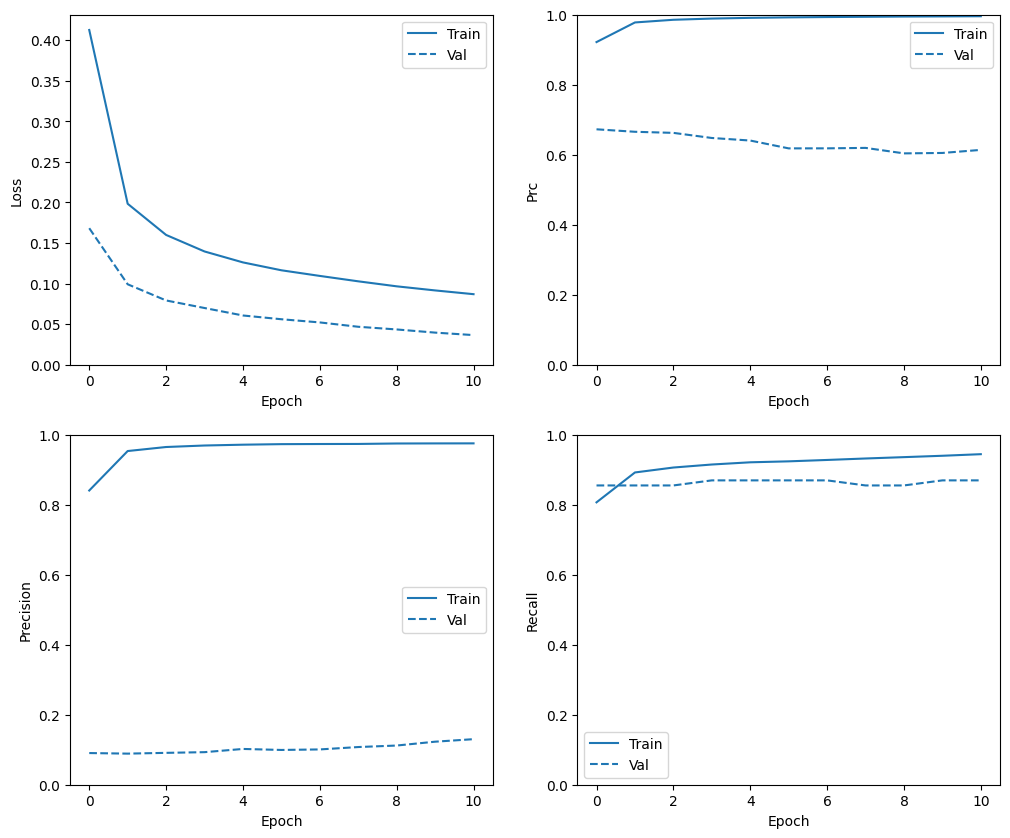

In [50]:
plot_metrics(resampled_history)

### 再トレーニングする


バランスの取れたデータの方がトレーニングしやすいため、上記のトレーニング方法ではすぐに過学習してしまう可能性があります。

したがって、エポックを分割して、`tf.keras.callbacks.EarlyStopping` がトレーニングを停止するタイミングをより細かく制御できるようにします。

In [51]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_ds))

Epoch 1/1000


 1/20 [>.............................] - ETA: 30s - loss: 1.4319 - tp: 416.0000 - fp: 612.0000 - tn: 45893.0000 - fn: 696.0000 - accuracy: 0.9725 - precision: 0.4047 - recall: 0.3741 - auc: 0.8803 - prc: 0.3647

 5/20 [======>.......................] - ETA: 0s - loss: 1.3621 - tp: 2002.0000 - fp: 1669.0000 - tn: 48902.0000 - fn: 3236.0000 - accuracy: 0.9121 - precision: 0.5454 - recall: 0.3822 - auc: 0.8511 - prc: 0.4999

 7/20 [=========>....................] - ETA: 0s - loss: 1.3069 - tp: 2887.0000 - fp: 2186.0000 - tn: 50432.0000 - fn: 4400.0000 - accuracy: 0.8901 - precision: 0.5691 - recall: 0.3962 - auc: 0.8442 - prc: 0.5384

10/20 [==============>...............] - ETA: 0s - loss: 1.2410 - tp: 4295.0000 - fp: 2952.0000 - tn: 52719.0000 - fn: 6083.0000 - accuracy: 0.8632 - precision: 0.5927 - recall: 0.4139 - auc: 0.8363 - prc: 0.5778

13/20 [==================>...........] - ETA: 0s - loss: 1.1807 - tp: 5850.0000 - fp: 3771.0000 - tn: 54997.0000 - fn: 7575.0000 - accuracy: 0.8428 - precision: 0.6080 - recall: 0.4358 - auc: 0.8297 - prc: 0.6077

16/20 [=======================>......] - ETA: 0s - loss: 1.1336 - tp: 7512.0000 - fp: 4587.0000 - tn: 57230.0000 - fn: 9008.0000 - accuracy: 0.8265 - precision: 0.6209 - recall: 0.4547 - auc: 0.8241 - prc: 0.6311

19/20 [===========================>..] - ETA: 0s - loss: 1.0918 - tp: 9285.0000 - fp: 5420.0000 - tn: 59426.0000 - fn: 10350.0000 - accuracy: 0.8133 - precision: 0.6314 - recall: 0.4729 - auc: 0.8200 - prc: 0.6523

20/20 [==============================] - 3s 54ms/step - loss: 1.0788 - tp: 9883.0000 - fp: 5709.0000 - tn: 60165.0000 - fn: 10772.0000 - accuracy: 0.8095 - precision: 0.6339 - recall: 0.4785 - auc: 0.8187 - prc: 0.6587 - val_loss: 0.4735 - val_tp: 44.0000 - val_fp: 7517.0000 - val_tn: 37983.0000 - val_fn: 25.0000 - val_accuracy: 0.8345 - val_precision: 0.0058 - val_recall: 0.6377 - val_auc: 0.7719 - val_prc: 0.1136


Epoch 2/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.8351 - tp: 612.0000 - fp: 280.0000 - tn: 734.0000 - fn: 422.0000 - accuracy: 0.6572 - precision: 0.6861 - recall: 0.5919 - auc: 0.6684 - prc: 0.7660

 4/20 [=====>........................] - ETA: 0s - loss: 0.7804 - tp: 2522.0000 - fp: 1185.0000 - tn: 2904.0000 - fn: 1581.0000 - accuracy: 0.6624 - precision: 0.6803 - recall: 0.6147 - auc: 0.6886 - prc: 0.7799

 6/20 [========>.....................] - ETA: 0s - loss: 0.7692 - tp: 3871.0000 - fp: 1757.0000 - tn: 4332.0000 - fn: 2328.0000 - accuracy: 0.6676 - precision: 0.6878 - recall: 0.6245 - auc: 0.6949 - prc: 0.7874

 9/20 [============>.................] - ETA: 0s - loss: 0.7349 - tp: 5981.0000 - fp: 2576.0000 - tn: 6533.0000 - fn: 3342.0000 - accuracy: 0.6789 - precision: 0.6990 - recall: 0.6415 - auc: 0.7114 - prc: 0.8008

12/20 [=================>............] - ETA: 0s - loss: 0.7105 - tp: 8104.0000 - fp: 3475.0000 - tn: 8713.0000 - fn: 4284.0000 - accuracy: 0.6843 - precision: 0.6999 - recall: 0.6542 - auc: 0.7228 - prc: 0.8084

15/20 [=====================>........] - ETA: 0s - loss: 0.6922 - tp: 10276.0000 - fp: 4289.0000 - tn: 10939.0000 - fn: 5216.0000 - accuracy: 0.6906 - precision: 0.7055 - recall: 0.6633 - auc: 0.7315 - prc: 0.8151

18/20 [==========================>...] - ETA: 0s - loss: 0.6772 - tp: 12491.0000 - fp: 5107.0000 - tn: 13127.0000 - fn: 6139.0000 - accuracy: 0.6949 - precision: 0.7098 - recall: 0.6705 - auc: 0.7390 - prc: 0.8207

20/20 [==============================] - 1s 29ms/step - loss: 0.6680 - tp: 13969.0000 - fp: 5680.0000 - tn: 14619.0000 - fn: 6692.0000 - accuracy: 0.6979 - precision: 0.7109 - recall: 0.6761 - auc: 0.7440 - prc: 0.8238 - val_loss: 0.4738 - val_tp: 57.0000 - val_fp: 7346.0000 - val_tn: 38154.0000 - val_fn: 12.0000 - val_accuracy: 0.8385 - val_precision: 0.0077 - val_recall: 0.8261 - val_auc: 0.8709 - val_prc: 0.3997


Epoch 3/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.5706 - tp: 732.0000 - fp: 299.0000 - tn: 747.0000 - fn: 270.0000 - accuracy: 0.7222 - precision: 0.7100 - recall: 0.7305 - auc: 0.7961 - prc: 0.8538

 5/20 [======>.......................] - ETA: 0s - loss: 0.5462 - tp: 3772.0000 - fp: 1337.0000 - tn: 3820.0000 - fn: 1311.0000 - accuracy: 0.7414 - precision: 0.7383 - recall: 0.7421 - auc: 0.8070 - prc: 0.8642

 8/20 [===========>..................] - ETA: 0s - loss: 0.5393 - tp: 6135.0000 - fp: 2175.0000 - tn: 6002.0000 - fn: 2072.0000 - accuracy: 0.7408 - precision: 0.7383 - recall: 0.7475 - auc: 0.8112 - prc: 0.8688

11/20 [===============>..............] - ETA: 0s - loss: 0.5349 - tp: 8473.0000 - fp: 3016.0000 - tn: 8246.0000 - fn: 2793.0000 - accuracy: 0.7421 - precision: 0.7375 - recall: 0.7521 - auc: 0.8140 - prc: 0.8710

14/20 [====================>.........] - ETA: 0s - loss: 0.5287 - tp: 10821.0000 - fp: 3815.0000 - tn: 10555.0000 - fn: 3481.0000 - accuracy: 0.7455 - precision: 0.7393 - recall: 0.7566 - auc: 0.8182 - prc: 0.8735

17/20 [========================>.....] - ETA: 0s - loss: 0.5246 - tp: 13260.0000 - fp: 4588.0000 - tn: 12800.0000 - fn: 4168.0000 - accuracy: 0.7485 - precision: 0.7429 - recall: 0.7608 - auc: 0.8211 - prc: 0.8761

20/20 [==============================] - ETA: 0s - loss: 0.5201 - tp: 15755.0000 - fp: 5337.0000 - tn: 15024.0000 - fn: 4844.0000 - accuracy: 0.7514 - precision: 0.7470 - recall: 0.7648 - auc: 0.8243 - prc: 0.8789

20/20 [==============================] - 1s 28ms/step - loss: 0.5201 - tp: 15755.0000 - fp: 5337.0000 - tn: 15024.0000 - fn: 4844.0000 - accuracy: 0.7514 - precision: 0.7470 - recall: 0.7648 - auc: 0.8243 - prc: 0.8789 - val_loss: 0.4438 - val_tp: 56.0000 - val_fp: 5961.0000 - val_tn: 39539.0000 - val_fn: 13.0000 - val_accuracy: 0.8689 - val_precision: 0.0093 - val_recall: 0.8116 - val_auc: 0.8914 - val_prc: 0.4917


Epoch 4/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.4951 - tp: 815.0000 - fp: 285.0000 - tn: 733.0000 - fn: 215.0000 - accuracy: 0.7559 - precision: 0.7409 - recall: 0.7913 - auc: 0.8421 - prc: 0.8916

 5/20 [======>.......................] - ETA: 0s - loss: 0.4718 - tp: 4054.0000 - fp: 1300.0000 - tn: 3830.0000 - fn: 1056.0000 - accuracy: 0.7699 - precision: 0.7572 - recall: 0.7933 - auc: 0.8531 - prc: 0.8975

 8/20 [===========>..................] - ETA: 0s - loss: 0.4697 - tp: 6471.0000 - fp: 2087.0000 - tn: 6161.0000 - fn: 1665.0000 - accuracy: 0.7710 - precision: 0.7561 - recall: 0.7954 - auc: 0.8538 - prc: 0.8976

11/20 [===============>..............] - ETA: 0s - loss: 0.4649 - tp: 8930.0000 - fp: 2787.0000 - tn: 8537.0000 - fn: 2274.0000 - accuracy: 0.7753 - precision: 0.7621 - recall: 0.7970 - auc: 0.8569 - prc: 0.9001

14/20 [====================>.........] - ETA: 0s - loss: 0.4593 - tp: 11397.0000 - fp: 3482.0000 - tn: 10943.0000 - fn: 2850.0000 - accuracy: 0.7792 - precision: 0.7660 - recall: 0.8000 - auc: 0.8602 - prc: 0.9022

17/20 [========================>.....] - ETA: 0s - loss: 0.4555 - tp: 13818.0000 - fp: 4136.0000 - tn: 13403.0000 - fn: 3459.0000 - accuracy: 0.7819 - precision: 0.7696 - recall: 0.7998 - auc: 0.8623 - prc: 0.9034

20/20 [==============================] - ETA: 0s - loss: 0.4520 - tp: 16277.0000 - fp: 4793.0000 - tn: 15830.0000 - fn: 4060.0000 - accuracy: 0.7839 - precision: 0.7725 - recall: 0.8004 - auc: 0.8638 - prc: 0.9046

20/20 [==============================] - 1s 27ms/step - loss: 0.4520 - tp: 16277.0000 - fp: 4793.0000 - tn: 15830.0000 - fn: 4060.0000 - accuracy: 0.7839 - precision: 0.7725 - recall: 0.8004 - auc: 0.8638 - prc: 0.9046 - val_loss: 0.4042 - val_tp: 57.0000 - val_fp: 4418.0000 - val_tn: 41082.0000 - val_fn: 12.0000 - val_accuracy: 0.9028 - val_precision: 0.0127 - val_recall: 0.8261 - val_auc: 0.9071 - val_prc: 0.5734


Epoch 5/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.4242 - tp: 853.0000 - fp: 214.0000 - tn: 775.0000 - fn: 206.0000 - accuracy: 0.7949 - precision: 0.7994 - recall: 0.8055 - auc: 0.8774 - prc: 0.9177

 5/20 [======>.......................] - ETA: 0s - loss: 0.4153 - tp: 4235.0000 - fp: 1015.0000 - tn: 4045.0000 - fn: 945.0000 - accuracy: 0.8086 - precision: 0.8067 - recall: 0.8176 - auc: 0.8844 - prc: 0.9204

 8/20 [===========>..................] - ETA: 0s - loss: 0.4122 - tp: 6824.0000 - fp: 1602.0000 - tn: 6449.0000 - fn: 1509.0000 - accuracy: 0.8101 - precision: 0.8099 - recall: 0.8189 - auc: 0.8851 - prc: 0.9219

11/20 [===============>..............] - ETA: 0s - loss: 0.4073 - tp: 9402.0000 - fp: 2174.0000 - tn: 8912.0000 - fn: 2040.0000 - accuracy: 0.8129 - precision: 0.8122 - recall: 0.8217 - auc: 0.8876 - prc: 0.9236

13/20 [==================>...........] - ETA: 0s - loss: 0.4072 - tp: 11087.0000 - fp: 2566.0000 - tn: 10563.0000 - fn: 2408.0000 - accuracy: 0.8132 - precision: 0.8121 - recall: 0.8216 - auc: 0.8877 - prc: 0.9235

15/20 [=====================>........] - ETA: 0s - loss: 0.4050 - tp: 12792.0000 - fp: 2939.0000 - tn: 12210.0000 - fn: 2779.0000 - accuracy: 0.8139 - precision: 0.8132 - recall: 0.8215 - auc: 0.8883 - prc: 0.9239

17/20 [========================>.....] - ETA: 0s - loss: 0.4040 - tp: 14505.0000 - fp: 3313.0000 - tn: 13860.0000 - fn: 3138.0000 - accuracy: 0.8147 - precision: 0.8141 - recall: 0.8221 - auc: 0.8887 - prc: 0.9243

19/20 [===========================>..] - ETA: 0s - loss: 0.4020 - tp: 16227.0000 - fp: 3659.0000 - tn: 15523.0000 - fn: 3503.0000 - accuracy: 0.8159 - precision: 0.8160 - recall: 0.8225 - auc: 0.8892 - prc: 0.9248

20/20 [==============================] - 1s 30ms/step - loss: 0.4011 - tp: 17099.0000 - fp: 3860.0000 - tn: 16322.0000 - fn: 3679.0000 - accuracy: 0.8159 - precision: 0.8158 - recall: 0.8229 - auc: 0.8896 - prc: 0.9251 - val_loss: 0.3656 - val_tp: 57.0000 - val_fp: 3142.0000 - val_tn: 42358.0000 - val_fn: 12.0000 - val_accuracy: 0.9308 - val_precision: 0.0178 - val_recall: 0.8261 - val_auc: 0.9215 - val_prc: 0.5999


Epoch 6/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.4019 - tp: 803.0000 - fp: 207.0000 - tn: 860.0000 - fn: 178.0000 - accuracy: 0.8120 - precision: 0.7950 - recall: 0.8186 - auc: 0.8877 - prc: 0.9199

 5/20 [======>.......................] - ETA: 0s - loss: 0.3873 - tp: 4187.0000 - fp: 992.0000 - tn: 4222.0000 - fn: 839.0000 - accuracy: 0.8212 - precision: 0.8085 - recall: 0.8331 - auc: 0.8997 - prc: 0.9284

 8/20 [===========>..................] - ETA: 0s - loss: 0.3840 - tp: 6748.0000 - fp: 1519.0000 - tn: 6787.0000 - fn: 1330.0000 - accuracy: 0.8261 - precision: 0.8163 - recall: 0.8354 - auc: 0.9014 - prc: 0.9299

11/20 [===============>..............] - ETA: 0s - loss: 0.3768 - tp: 9339.0000 - fp: 2014.0000 - tn: 9365.0000 - fn: 1810.0000 - accuracy: 0.8303 - precision: 0.8226 - recall: 0.8377 - auc: 0.9047 - prc: 0.9327

14/20 [====================>.........] - ETA: 0s - loss: 0.3749 - tp: 11854.0000 - fp: 2497.0000 - tn: 12009.0000 - fn: 2312.0000 - accuracy: 0.8323 - precision: 0.8260 - recall: 0.8368 - auc: 0.9051 - prc: 0.9328

17/20 [========================>.....] - ETA: 0s - loss: 0.3720 - tp: 14427.0000 - fp: 3000.0000 - tn: 14601.0000 - fn: 2788.0000 - accuracy: 0.8338 - precision: 0.8279 - recall: 0.8380 - auc: 0.9066 - prc: 0.9337

20/20 [==============================] - ETA: 0s - loss: 0.3698 - tp: 17030.0000 - fp: 3437.0000 - tn: 17200.0000 - fn: 3293.0000 - accuracy: 0.8357 - precision: 0.8321 - recall: 0.8380 - auc: 0.9073 - prc: 0.9346

20/20 [==============================] - 1s 28ms/step - loss: 0.3698 - tp: 17030.0000 - fp: 3437.0000 - tn: 17200.0000 - fn: 3293.0000 - accuracy: 0.8357 - precision: 0.8321 - recall: 0.8380 - auc: 0.9073 - prc: 0.9346 - val_loss: 0.3284 - val_tp: 57.0000 - val_fp: 2106.0000 - val_tn: 43394.0000 - val_fn: 12.0000 - val_accuracy: 0.9535 - val_precision: 0.0264 - val_recall: 0.8261 - val_auc: 0.9342 - val_prc: 0.6209


Epoch 7/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.3501 - tp: 853.0000 - fp: 159.0000 - tn: 879.0000 - fn: 157.0000 - accuracy: 0.8457 - precision: 0.8429 - recall: 0.8446 - auc: 0.9166 - prc: 0.9393

 5/20 [======>.......................] - ETA: 0s - loss: 0.3551 - tp: 4376.0000 - fp: 744.0000 - tn: 4300.0000 - fn: 820.0000 - accuracy: 0.8473 - precision: 0.8547 - recall: 0.8422 - auc: 0.9141 - prc: 0.9407

 8/20 [===========>..................] - ETA: 0s - loss: 0.3485 - tp: 7011.0000 - fp: 1143.0000 - tn: 6922.0000 - fn: 1308.0000 - accuracy: 0.8504 - precision: 0.8598 - recall: 0.8428 - auc: 0.9160 - prc: 0.9423

11/20 [===============>..............] - ETA: 0s - loss: 0.3491 - tp: 9648.0000 - fp: 1587.0000 - tn: 9496.0000 - fn: 1797.0000 - accuracy: 0.8498 - precision: 0.8587 - recall: 0.8430 - auc: 0.9156 - prc: 0.9420

14/20 [====================>.........] - ETA: 0s - loss: 0.3501 - tp: 12259.0000 - fp: 2027.0000 - tn: 12116.0000 - fn: 2270.0000 - accuracy: 0.8501 - precision: 0.8581 - recall: 0.8438 - auc: 0.9154 - prc: 0.9417

17/20 [========================>.....] - ETA: 0s - loss: 0.3475 - tp: 14819.0000 - fp: 2416.0000 - tn: 14828.0000 - fn: 2753.0000 - accuracy: 0.8515 - precision: 0.8598 - recall: 0.8433 - auc: 0.9163 - prc: 0.9420

20/20 [==============================] - ETA: 0s - loss: 0.3450 - tp: 17393.0000 - fp: 2816.0000 - tn: 17557.0000 - fn: 3194.0000 - accuracy: 0.8533 - precision: 0.8607 - recall: 0.8449 - auc: 0.9176 - prc: 0.9426

20/20 [==============================] - 1s 27ms/step - loss: 0.3450 - tp: 17393.0000 - fp: 2816.0000 - tn: 17557.0000 - fn: 3194.0000 - accuracy: 0.8533 - precision: 0.8607 - recall: 0.8449 - auc: 0.9176 - prc: 0.9426 - val_loss: 0.2964 - val_tp: 56.0000 - val_fp: 1409.0000 - val_tn: 44091.0000 - val_fn: 13.0000 - val_accuracy: 0.9688 - val_precision: 0.0382 - val_recall: 0.8116 - val_auc: 0.9453 - val_prc: 0.6271


Epoch 8/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.3289 - tp: 885.0000 - fp: 125.0000 - tn: 879.0000 - fn: 159.0000 - accuracy: 0.8613 - precision: 0.8762 - recall: 0.8477 - auc: 0.9222 - prc: 0.9476

 5/20 [======>.......................] - ETA: 0s - loss: 0.3307 - tp: 4360.0000 - fp: 683.0000 - tn: 4437.0000 - fn: 760.0000 - accuracy: 0.8591 - precision: 0.8646 - recall: 0.8516 - auc: 0.9228 - prc: 0.9466

 8/20 [===========>..................] - ETA: 0s - loss: 0.3309 - tp: 6973.0000 - fp: 1072.0000 - tn: 7106.0000 - fn: 1233.0000 - accuracy: 0.8593 - precision: 0.8667 - recall: 0.8497 - auc: 0.9229 - prc: 0.9465

11/20 [===============>..............] - ETA: 0s - loss: 0.3279 - tp: 9565.0000 - fp: 1451.0000 - tn: 9837.0000 - fn: 1675.0000 - accuracy: 0.8612 - precision: 0.8683 - recall: 0.8510 - auc: 0.9242 - prc: 0.9472

14/20 [====================>.........] - ETA: 0s - loss: 0.3262 - tp: 12241.0000 - fp: 1801.0000 - tn: 12491.0000 - fn: 2139.0000 - accuracy: 0.8626 - precision: 0.8717 - recall: 0.8513 - auc: 0.9248 - prc: 0.9480

17/20 [========================>.....] - ETA: 0s - loss: 0.3243 - tp: 14815.0000 - fp: 2183.0000 - tn: 15259.0000 - fn: 2559.0000 - accuracy: 0.8638 - precision: 0.8716 - recall: 0.8527 - auc: 0.9261 - prc: 0.9484

20/20 [==============================] - ETA: 0s - loss: 0.3227 - tp: 17476.0000 - fp: 2488.0000 - tn: 17993.0000 - fn: 3003.0000 - accuracy: 0.8659 - precision: 0.8754 - recall: 0.8534 - auc: 0.9266 - prc: 0.9487

20/20 [==============================] - 1s 29ms/step - loss: 0.3227 - tp: 17476.0000 - fp: 2488.0000 - tn: 17993.0000 - fn: 3003.0000 - accuracy: 0.8659 - precision: 0.8754 - recall: 0.8534 - auc: 0.9266 - prc: 0.9487 - val_loss: 0.2685 - val_tp: 57.0000 - val_fp: 1014.0000 - val_tn: 44486.0000 - val_fn: 12.0000 - val_accuracy: 0.9775 - val_precision: 0.0532 - val_recall: 0.8261 - val_auc: 0.9538 - val_prc: 0.6388


Epoch 9/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.3184 - tp: 859.0000 - fp: 114.0000 - tn: 921.0000 - fn: 154.0000 - accuracy: 0.8691 - precision: 0.8828 - recall: 0.8480 - auc: 0.9273 - prc: 0.9481

 5/20 [======>.......................] - ETA: 0s - loss: 0.3051 - tp: 4339.0000 - fp: 577.0000 - tn: 4583.0000 - fn: 741.0000 - accuracy: 0.8713 - precision: 0.8826 - recall: 0.8541 - auc: 0.9335 - prc: 0.9523

 8/20 [===========>..................] - ETA: 0s - loss: 0.3023 - tp: 7023.0000 - fp: 889.0000 - tn: 7317.0000 - fn: 1155.0000 - accuracy: 0.8752 - precision: 0.8876 - recall: 0.8588 - auc: 0.9350 - prc: 0.9538

11/20 [===============>..............] - ETA: 0s - loss: 0.3020 - tp: 9698.0000 - fp: 1221.0000 - tn: 10044.0000 - fn: 1565.0000 - accuracy: 0.8763 - precision: 0.8882 - recall: 0.8610 - auc: 0.9354 - prc: 0.9542

14/20 [====================>.........] - ETA: 0s - loss: 0.3013 - tp: 12344.0000 - fp: 1528.0000 - tn: 12789.0000 - fn: 2011.0000 - accuracy: 0.8766 - precision: 0.8899 - recall: 0.8599 - auc: 0.9356 - prc: 0.9543

17/20 [========================>.....] - ETA: 0s - loss: 0.3013 - tp: 14971.0000 - fp: 1842.0000 - tn: 15566.0000 - fn: 2437.0000 - accuracy: 0.8771 - precision: 0.8904 - recall: 0.8600 - auc: 0.9355 - prc: 0.9542

20/20 [==============================] - ETA: 0s - loss: 0.3001 - tp: 17545.0000 - fp: 2111.0000 - tn: 18430.0000 - fn: 2874.0000 - accuracy: 0.8783 - precision: 0.8926 - recall: 0.8592 - auc: 0.9358 - prc: 0.9542

20/20 [==============================] - 1s 29ms/step - loss: 0.3001 - tp: 17545.0000 - fp: 2111.0000 - tn: 18430.0000 - fn: 2874.0000 - accuracy: 0.8783 - precision: 0.8926 - recall: 0.8592 - auc: 0.9358 - prc: 0.9542 - val_loss: 0.2439 - val_tp: 57.0000 - val_fp: 766.0000 - val_tn: 44734.0000 - val_fn: 12.0000 - val_accuracy: 0.9829 - val_precision: 0.0693 - val_recall: 0.8261 - val_auc: 0.9601 - val_prc: 0.6474


Epoch 10/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2966 - tp: 889.0000 - fp: 101.0000 - tn: 918.0000 - fn: 140.0000 - accuracy: 0.8823 - precision: 0.8980 - recall: 0.8639 - auc: 0.9381 - prc: 0.9560

 5/20 [======>.......................] - ETA: 0s - loss: 0.2938 - tp: 4449.0000 - fp: 511.0000 - tn: 4573.0000 - fn: 707.0000 - accuracy: 0.8811 - precision: 0.8970 - recall: 0.8629 - auc: 0.9389 - prc: 0.9568

 8/20 [===========>..................] - ETA: 0s - loss: 0.2938 - tp: 7092.0000 - fp: 796.0000 - tn: 7354.0000 - fn: 1142.0000 - accuracy: 0.8817 - precision: 0.8991 - recall: 0.8613 - auc: 0.9386 - prc: 0.9562

11/20 [===============>..............] - ETA: 0s - loss: 0.2904 - tp: 9697.0000 - fp: 1060.0000 - tn: 10207.0000 - fn: 1564.0000 - accuracy: 0.8835 - precision: 0.9015 - recall: 0.8611 - auc: 0.9393 - prc: 0.9565

14/20 [====================>.........] - ETA: 0s - loss: 0.2877 - tp: 12288.0000 - fp: 1327.0000 - tn: 13072.0000 - fn: 1985.0000 - accuracy: 0.8845 - precision: 0.9025 - recall: 0.8609 - auc: 0.9402 - prc: 0.9570

17/20 [========================>.....] - ETA: 0s - loss: 0.2857 - tp: 14942.0000 - fp: 1599.0000 - tn: 15859.0000 - fn: 2416.0000 - accuracy: 0.8847 - precision: 0.9033 - recall: 0.8608 - auc: 0.9410 - prc: 0.9575

20/20 [==============================] - ETA: 0s - loss: 0.2841 - tp: 17588.0000 - fp: 1838.0000 - tn: 18720.0000 - fn: 2814.0000 - accuracy: 0.8864 - precision: 0.9054 - recall: 0.8621 - auc: 0.9417 - prc: 0.9580

20/20 [==============================] - 1s 29ms/step - loss: 0.2841 - tp: 17588.0000 - fp: 1838.0000 - tn: 18720.0000 - fn: 2814.0000 - accuracy: 0.8864 - precision: 0.9054 - recall: 0.8621 - auc: 0.9417 - prc: 0.9580 - val_loss: 0.2229 - val_tp: 57.0000 - val_fp: 672.0000 - val_tn: 44828.0000 - val_fn: 12.0000 - val_accuracy: 0.9850 - val_precision: 0.0782 - val_recall: 0.8261 - val_auc: 0.9649 - val_prc: 0.6646


Epoch 11/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2776 - tp: 823.0000 - fp: 94.0000 - tn: 998.0000 - fn: 133.0000 - accuracy: 0.8892 - precision: 0.8975 - recall: 0.8609 - auc: 0.9444 - prc: 0.9558

 5/20 [======>.......................] - ETA: 0s - loss: 0.2744 - tp: 4441.0000 - fp: 413.0000 - tn: 4697.0000 - fn: 689.0000 - accuracy: 0.8924 - precision: 0.9149 - recall: 0.8657 - auc: 0.9450 - prc: 0.9608

 8/20 [===========>..................] - ETA: 0s - loss: 0.2735 - tp: 7176.0000 - fp: 665.0000 - tn: 7442.0000 - fn: 1101.0000 - accuracy: 0.8922 - precision: 0.9152 - recall: 0.8670 - auc: 0.9458 - prc: 0.9613

11/20 [===============>..............] - ETA: 0s - loss: 0.2729 - tp: 9813.0000 - fp: 916.0000 - tn: 10300.0000 - fn: 1499.0000 - accuracy: 0.8928 - precision: 0.9146 - recall: 0.8675 - auc: 0.9458 - prc: 0.9611

14/20 [====================>.........] - ETA: 0s - loss: 0.2722 - tp: 12427.0000 - fp: 1159.0000 - tn: 13188.0000 - fn: 1898.0000 - accuracy: 0.8934 - precision: 0.9147 - recall: 0.8675 - auc: 0.9463 - prc: 0.9612

17/20 [========================>.....] - ETA: 0s - loss: 0.2706 - tp: 15099.0000 - fp: 1390.0000 - tn: 16043.0000 - fn: 2284.0000 - accuracy: 0.8945 - precision: 0.9157 - recall: 0.8686 - auc: 0.9469 - prc: 0.9616

20/20 [==============================] - ETA: 0s - loss: 0.2695 - tp: 17684.0000 - fp: 1626.0000 - tn: 18962.0000 - fn: 2688.0000 - accuracy: 0.8947 - precision: 0.9158 - recall: 0.8681 - auc: 0.9472 - prc: 0.9616

20/20 [==============================] - 1s 30ms/step - loss: 0.2695 - tp: 17684.0000 - fp: 1626.0000 - tn: 18962.0000 - fn: 2688.0000 - accuracy: 0.8947 - precision: 0.9158 - recall: 0.8681 - auc: 0.9472 - prc: 0.9616 - val_loss: 0.2051 - val_tp: 57.0000 - val_fp: 631.0000 - val_tn: 44869.0000 - val_fn: 12.0000 - val_accuracy: 0.9859 - val_precision: 0.0828 - val_recall: 0.8261 - val_auc: 0.9677 - val_prc: 0.6582


Epoch 12/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2680 - tp: 911.0000 - fp: 87.0000 - tn: 915.0000 - fn: 135.0000 - accuracy: 0.8916 - precision: 0.9128 - recall: 0.8709 - auc: 0.9473 - prc: 0.9639

 5/20 [======>.......................] - ETA: 0s - loss: 0.2651 - tp: 4430.0000 - fp: 397.0000 - tn: 4750.0000 - fn: 663.0000 - accuracy: 0.8965 - precision: 0.9178 - recall: 0.8698 - auc: 0.9489 - prc: 0.9630

 8/20 [===========>..................] - ETA: 0s - loss: 0.2634 - tp: 7118.0000 - fp: 609.0000 - tn: 7592.0000 - fn: 1065.0000 - accuracy: 0.8978 - precision: 0.9212 - recall: 0.8699 - auc: 0.9491 - prc: 0.9633

10/20 [==============>...............] - ETA: 0s - loss: 0.2628 - tp: 8929.0000 - fp: 774.0000 - tn: 9441.0000 - fn: 1336.0000 - accuracy: 0.8970 - precision: 0.9202 - recall: 0.8698 - auc: 0.9492 - prc: 0.9636

13/20 [==================>...........] - ETA: 0s - loss: 0.2627 - tp: 11602.0000 - fp: 991.0000 - tn: 12299.0000 - fn: 1732.0000 - accuracy: 0.8977 - precision: 0.9213 - recall: 0.8701 - auc: 0.9493 - prc: 0.9636

16/20 [=======================>......] - ETA: 0s - loss: 0.2618 - tp: 14249.0000 - fp: 1199.0000 - tn: 15209.0000 - fn: 2111.0000 - accuracy: 0.8990 - precision: 0.9224 - recall: 0.8710 - auc: 0.9498 - prc: 0.9637

19/20 [===========================>..] - ETA: 0s - loss: 0.2611 - tp: 16929.0000 - fp: 1418.0000 - tn: 18059.0000 - fn: 2506.0000 - accuracy: 0.8992 - precision: 0.9227 - recall: 0.8711 - auc: 0.9499 - prc: 0.9638

20/20 [==============================] - 1s 28ms/step - loss: 0.2608 - tp: 17838.0000 - fp: 1483.0000 - tn: 19004.0000 - fn: 2635.0000 - accuracy: 0.8995 - precision: 0.9232 - recall: 0.8713 - auc: 0.9500 - prc: 0.9639 - val_loss: 0.1904 - val_tp: 57.0000 - val_fp: 619.0000 - val_tn: 44881.0000 - val_fn: 12.0000 - val_accuracy: 0.9862 - val_precision: 0.0843 - val_recall: 0.8261 - val_auc: 0.9692 - val_prc: 0.6674


Epoch 13/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2568 - tp: 872.0000 - fp: 74.0000 - tn: 980.0000 - fn: 122.0000 - accuracy: 0.9043 - precision: 0.9218 - recall: 0.8773 - auc: 0.9544 - prc: 0.9636

 4/20 [=====>........................] - ETA: 0s - loss: 0.2546 - tp: 3553.0000 - fp: 290.0000 - tn: 3847.0000 - fn: 502.0000 - accuracy: 0.9033 - precision: 0.9245 - recall: 0.8762 - auc: 0.9535 - prc: 0.9655

 7/20 [=========>....................] - ETA: 0s - loss: 0.2535 - tp: 6214.0000 - fp: 494.0000 - tn: 6723.0000 - fn: 905.0000 - accuracy: 0.9024 - precision: 0.9264 - recall: 0.8729 - auc: 0.9536 - prc: 0.9656

10/20 [==============>...............] - ETA: 0s - loss: 0.2517 - tp: 8912.0000 - fp: 709.0000 - tn: 9560.0000 - fn: 1299.0000 - accuracy: 0.9020 - precision: 0.9263 - recall: 0.8728 - auc: 0.9536 - prc: 0.9661

12/20 [=================>............] - ETA: 0s - loss: 0.2499 - tp: 10735.0000 - fp: 838.0000 - tn: 11454.0000 - fn: 1549.0000 - accuracy: 0.9029 - precision: 0.9276 - recall: 0.8739 - auc: 0.9543 - prc: 0.9666

15/20 [=====================>........] - ETA: 0s - loss: 0.2498 - tp: 13484.0000 - fp: 1038.0000 - tn: 14253.0000 - fn: 1945.0000 - accuracy: 0.9029 - precision: 0.9285 - recall: 0.8739 - auc: 0.9542 - prc: 0.9668

18/20 [==========================>...] - ETA: 0s - loss: 0.2480 - tp: 16157.0000 - fp: 1233.0000 - tn: 17160.0000 - fn: 2314.0000 - accuracy: 0.9038 - precision: 0.9291 - recall: 0.8747 - auc: 0.9548 - prc: 0.9672

20/20 [==============================] - 1s 28ms/step - loss: 0.2480 - tp: 17914.0000 - fp: 1354.0000 - tn: 19123.0000 - fn: 2569.0000 - accuracy: 0.9042 - precision: 0.9297 - recall: 0.8746 - auc: 0.9548 - prc: 0.9670 - val_loss: 0.1775 - val_tp: 58.0000 - val_fp: 600.0000 - val_tn: 44900.0000 - val_fn: 11.0000 - val_accuracy: 0.9866 - val_precision: 0.0881 - val_recall: 0.8406 - val_auc: 0.9696 - val_prc: 0.6689


Epoch 14/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2357 - tp: 919.0000 - fp: 67.0000 - tn: 940.0000 - fn: 122.0000 - accuracy: 0.9077 - precision: 0.9320 - recall: 0.8828 - auc: 0.9587 - prc: 0.9702

 5/20 [======>.......................] - ETA: 0s - loss: 0.2433 - tp: 4421.0000 - fp: 324.0000 - tn: 4872.0000 - fn: 623.0000 - accuracy: 0.9075 - precision: 0.9317 - recall: 0.8765 - auc: 0.9561 - prc: 0.9674

 8/20 [===========>..................] - ETA: 0s - loss: 0.2427 - tp: 7179.0000 - fp: 484.0000 - tn: 7719.0000 - fn: 1002.0000 - accuracy: 0.9093 - precision: 0.9368 - recall: 0.8775 - auc: 0.9562 - prc: 0.9680

11/20 [===============>..............] - ETA: 0s - loss: 0.2424 - tp: 9848.0000 - fp: 674.0000 - tn: 10635.0000 - fn: 1371.0000 - accuracy: 0.9092 - precision: 0.9359 - recall: 0.8778 - auc: 0.9563 - prc: 0.9680

14/20 [====================>.........] - ETA: 0s - loss: 0.2403 - tp: 12527.0000 - fp: 847.0000 - tn: 13577.0000 - fn: 1721.0000 - accuracy: 0.9104 - precision: 0.9367 - recall: 0.8792 - auc: 0.9575 - prc: 0.9686

17/20 [========================>.....] - ETA: 0s - loss: 0.2382 - tp: 15168.0000 - fp: 1025.0000 - tn: 16545.0000 - fn: 2078.0000 - accuracy: 0.9109 - precision: 0.9367 - recall: 0.8795 - auc: 0.9584 - prc: 0.9690

20/20 [==============================] - ETA: 0s - loss: 0.2393 - tp: 17851.0000 - fp: 1228.0000 - tn: 19433.0000 - fn: 2448.0000 - accuracy: 0.9103 - precision: 0.9356 - recall: 0.8794 - auc: 0.9580 - prc: 0.9687

20/20 [==============================] - 1s 27ms/step - loss: 0.2393 - tp: 17851.0000 - fp: 1228.0000 - tn: 19433.0000 - fn: 2448.0000 - accuracy: 0.9103 - precision: 0.9356 - recall: 0.8794 - auc: 0.9580 - prc: 0.9687 - val_loss: 0.1656 - val_tp: 59.0000 - val_fp: 579.0000 - val_tn: 44921.0000 - val_fn: 10.0000 - val_accuracy: 0.9871 - val_precision: 0.0925 - val_recall: 0.8551 - val_auc: 0.9706 - val_prc: 0.6725


Epoch 15/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2224 - tp: 880.0000 - fp: 56.0000 - tn: 1007.0000 - fn: 105.0000 - accuracy: 0.9214 - precision: 0.9402 - recall: 0.8934 - auc: 0.9620 - prc: 0.9719

 5/20 [======>.......................] - ETA: 0s - loss: 0.2307 - tp: 4513.0000 - fp: 304.0000 - tn: 4817.0000 - fn: 606.0000 - accuracy: 0.9111 - precision: 0.9369 - recall: 0.8816 - auc: 0.9613 - prc: 0.9713

 8/20 [===========>..................] - ETA: 0s - loss: 0.2325 - tp: 7229.0000 - fp: 479.0000 - tn: 7704.0000 - fn: 972.0000 - accuracy: 0.9114 - precision: 0.9379 - recall: 0.8815 - auc: 0.9602 - prc: 0.9706

11/20 [===============>..............] - ETA: 0s - loss: 0.2328 - tp: 9951.0000 - fp: 647.0000 - tn: 10600.0000 - fn: 1330.0000 - accuracy: 0.9122 - precision: 0.9390 - recall: 0.8821 - auc: 0.9602 - prc: 0.9703

14/20 [====================>.........] - ETA: 0s - loss: 0.2314 - tp: 12594.0000 - fp: 805.0000 - tn: 13574.0000 - fn: 1699.0000 - accuracy: 0.9127 - precision: 0.9399 - recall: 0.8811 - auc: 0.9605 - prc: 0.9704

17/20 [========================>.....] - ETA: 0s - loss: 0.2306 - tp: 15273.0000 - fp: 961.0000 - tn: 16505.0000 - fn: 2077.0000 - accuracy: 0.9127 - precision: 0.9408 - recall: 0.8803 - auc: 0.9607 - prc: 0.9706

20/20 [==============================] - ETA: 0s - loss: 0.2296 - tp: 17997.0000 - fp: 1116.0000 - tn: 19406.0000 - fn: 2441.0000 - accuracy: 0.9132 - precision: 0.9416 - recall: 0.8806 - auc: 0.9613 - prc: 0.9710

20/20 [==============================] - 1s 28ms/step - loss: 0.2296 - tp: 17997.0000 - fp: 1116.0000 - tn: 19406.0000 - fn: 2441.0000 - accuracy: 0.9132 - precision: 0.9416 - recall: 0.8806 - auc: 0.9613 - prc: 0.9710 - val_loss: 0.1556 - val_tp: 58.0000 - val_fp: 587.0000 - val_tn: 44913.0000 - val_fn: 11.0000 - val_accuracy: 0.9869 - val_precision: 0.0899 - val_recall: 0.8406 - val_auc: 0.9713 - val_prc: 0.6760


Epoch 16/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2328 - tp: 900.0000 - fp: 59.0000 - tn: 966.0000 - fn: 123.0000 - accuracy: 0.9111 - precision: 0.9385 - recall: 0.8798 - auc: 0.9596 - prc: 0.9704

 5/20 [======>.......................] - ETA: 0s - loss: 0.2270 - tp: 4465.0000 - fp: 265.0000 - tn: 4891.0000 - fn: 619.0000 - accuracy: 0.9137 - precision: 0.9440 - recall: 0.8782 - auc: 0.9615 - prc: 0.9710

 8/20 [===========>..................] - ETA: 0s - loss: 0.2261 - tp: 7196.0000 - fp: 433.0000 - tn: 7787.0000 - fn: 968.0000 - accuracy: 0.9145 - precision: 0.9432 - recall: 0.8814 - auc: 0.9623 - prc: 0.9717

11/20 [===============>..............] - ETA: 0s - loss: 0.2256 - tp: 9886.0000 - fp: 610.0000 - tn: 10713.0000 - fn: 1319.0000 - accuracy: 0.9144 - precision: 0.9419 - recall: 0.8823 - auc: 0.9624 - prc: 0.9717

14/20 [====================>.........] - ETA: 0s - loss: 0.2232 - tp: 12656.0000 - fp: 760.0000 - tn: 13576.0000 - fn: 1680.0000 - accuracy: 0.9149 - precision: 0.9434 - recall: 0.8828 - auc: 0.9633 - prc: 0.9725

17/20 [========================>.....] - ETA: 0s - loss: 0.2237 - tp: 15377.0000 - fp: 912.0000 - tn: 16470.0000 - fn: 2057.0000 - accuracy: 0.9147 - precision: 0.9440 - recall: 0.8820 - auc: 0.9632 - prc: 0.9724

20/20 [==============================] - ETA: 0s - loss: 0.2228 - tp: 18079.0000 - fp: 1057.0000 - tn: 19426.0000 - fn: 2398.0000 - accuracy: 0.9156 - precision: 0.9448 - recall: 0.8829 - auc: 0.9634 - prc: 0.9726

20/20 [==============================] - 1s 27ms/step - loss: 0.2228 - tp: 18079.0000 - fp: 1057.0000 - tn: 19426.0000 - fn: 2398.0000 - accuracy: 0.9156 - precision: 0.9448 - recall: 0.8829 - auc: 0.9634 - prc: 0.9726 - val_loss: 0.1474 - val_tp: 58.0000 - val_fp: 592.0000 - val_tn: 44908.0000 - val_fn: 11.0000 - val_accuracy: 0.9868 - val_precision: 0.0892 - val_recall: 0.8406 - val_auc: 0.9711 - val_prc: 0.6768


Epoch 17/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2184 - tp: 895.0000 - fp: 53.0000 - tn: 981.0000 - fn: 119.0000 - accuracy: 0.9160 - precision: 0.9441 - recall: 0.8826 - auc: 0.9645 - prc: 0.9722

 4/20 [=====>........................] - ETA: 0s - loss: 0.2188 - tp: 3532.0000 - fp: 211.0000 - tn: 3964.0000 - fn: 485.0000 - accuracy: 0.9150 - precision: 0.9436 - recall: 0.8793 - auc: 0.9649 - prc: 0.9725

 6/20 [========>.....................] - ETA: 0s - loss: 0.2168 - tp: 5380.0000 - fp: 309.0000 - tn: 5874.0000 - fn: 725.0000 - accuracy: 0.9159 - precision: 0.9457 - recall: 0.8812 - auc: 0.9659 - prc: 0.9739

 8/20 [===========>..................] - ETA: 0s - loss: 0.2188 - tp: 7188.0000 - fp: 422.0000 - tn: 7804.0000 - fn: 970.0000 - accuracy: 0.9150 - precision: 0.9445 - recall: 0.8811 - auc: 0.9652 - prc: 0.9734

10/20 [==============>...............] - ETA: 0s - loss: 0.2183 - tp: 8963.0000 - fp: 517.0000 - tn: 9775.0000 - fn: 1225.0000 - accuracy: 0.9149 - precision: 0.9455 - recall: 0.8798 - auc: 0.9653 - prc: 0.9734

12/20 [=================>............] - ETA: 0s - loss: 0.2184 - tp: 10842.0000 - fp: 615.0000 - tn: 11654.0000 - fn: 1465.0000 - accuracy: 0.9154 - precision: 0.9463 - recall: 0.8810 - auc: 0.9652 - prc: 0.9738

14/20 [====================>.........] - ETA: 0s - loss: 0.2180 - tp: 12628.0000 - fp: 716.0000 - tn: 13627.0000 - fn: 1701.0000 - accuracy: 0.9157 - precision: 0.9463 - recall: 0.8813 - auc: 0.9652 - prc: 0.9737

16/20 [=======================>......] - ETA: 0s - loss: 0.2175 - tp: 14431.0000 - fp: 832.0000 - tn: 15566.0000 - fn: 1939.0000 - accuracy: 0.9154 - precision: 0.9455 - recall: 0.8816 - auc: 0.9654 - prc: 0.9737

18/20 [==========================>...] - ETA: 0s - loss: 0.2162 - tp: 16234.0000 - fp: 926.0000 - tn: 17552.0000 - fn: 2152.0000 - accuracy: 0.9165 - precision: 0.9460 - recall: 0.8830 - auc: 0.9658 - prc: 0.9741

20/20 [==============================] - ETA: 0s - loss: 0.2160 - tp: 18053.0000 - fp: 1023.0000 - tn: 19497.0000 - fn: 2387.0000 - accuracy: 0.9167 - precision: 0.9464 - recall: 0.8832 - auc: 0.9657 - prc: 0.9740

20/20 [==============================] - 1s 32ms/step - loss: 0.2160 - tp: 18053.0000 - fp: 1023.0000 - tn: 19497.0000 - fn: 2387.0000 - accuracy: 0.9167 - precision: 0.9464 - recall: 0.8832 - auc: 0.9657 - prc: 0.9740 - val_loss: 0.1401 - val_tp: 59.0000 - val_fp: 591.0000 - val_tn: 44909.0000 - val_fn: 10.0000 - val_accuracy: 0.9868 - val_precision: 0.0908 - val_recall: 0.8551 - val_auc: 0.9711 - val_prc: 0.6801


Epoch 18/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2190 - tp: 916.0000 - fp: 44.0000 - tn: 970.0000 - fn: 118.0000 - accuracy: 0.9209 - precision: 0.9542 - recall: 0.8859 - auc: 0.9659 - prc: 0.9744

 4/20 [=====>........................] - ETA: 0s - loss: 0.2126 - tp: 3608.0000 - fp: 190.0000 - tn: 3934.0000 - fn: 460.0000 - accuracy: 0.9207 - precision: 0.9500 - recall: 0.8869 - auc: 0.9664 - prc: 0.9747

 6/20 [========>.....................] - ETA: 0s - loss: 0.2160 - tp: 5418.0000 - fp: 286.0000 - tn: 5891.0000 - fn: 693.0000 - accuracy: 0.9203 - precision: 0.9499 - recall: 0.8866 - auc: 0.9655 - prc: 0.9739

 8/20 [===========>..................] - ETA: 0s - loss: 0.2127 - tp: 7228.0000 - fp: 378.0000 - tn: 7872.0000 - fn: 906.0000 - accuracy: 0.9216 - precision: 0.9503 - recall: 0.8886 - auc: 0.9666 - prc: 0.9746

11/20 [===============>..............] - ETA: 0s - loss: 0.2108 - tp: 9955.0000 - fp: 520.0000 - tn: 10796.0000 - fn: 1257.0000 - accuracy: 0.9211 - precision: 0.9504 - recall: 0.8879 - auc: 0.9673 - prc: 0.9751

14/20 [====================>.........] - ETA: 0s - loss: 0.2116 - tp: 12679.0000 - fp: 662.0000 - tn: 13723.0000 - fn: 1608.0000 - accuracy: 0.9208 - precision: 0.9504 - recall: 0.8875 - auc: 0.9673 - prc: 0.9750

17/20 [========================>.....] - ETA: 0s - loss: 0.2112 - tp: 15398.0000 - fp: 833.0000 - tn: 16660.0000 - fn: 1925.0000 - accuracy: 0.9208 - precision: 0.9487 - recall: 0.8889 - auc: 0.9675 - prc: 0.9751

19/20 [===========================>..] - ETA: 0s - loss: 0.2111 - tp: 17197.0000 - fp: 933.0000 - tn: 18637.0000 - fn: 2145.0000 - accuracy: 0.9209 - precision: 0.9485 - recall: 0.8891 - auc: 0.9676 - prc: 0.9751

20/20 [==============================] - 1s 30ms/step - loss: 0.2113 - tp: 18152.0000 - fp: 986.0000 - tn: 19555.0000 - fn: 2267.0000 - accuracy: 0.9206 - precision: 0.9485 - recall: 0.8890 - auc: 0.9676 - prc: 0.9752 - val_loss: 0.1336 - val_tp: 59.0000 - val_fp: 595.0000 - val_tn: 44905.0000 - val_fn: 10.0000 - val_accuracy: 0.9867 - val_precision: 0.0902 - val_recall: 0.8551 - val_auc: 0.9709 - val_prc: 0.6806


Epoch 19/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1985 - tp: 925.0000 - fp: 39.0000 - tn: 981.0000 - fn: 103.0000 - accuracy: 0.9307 - precision: 0.9595 - recall: 0.8998 - auc: 0.9713 - prc: 0.9788

 4/20 [=====>........................] - ETA: 0s - loss: 0.2046 - tp: 3654.0000 - fp: 178.0000 - tn: 3914.0000 - fn: 446.0000 - accuracy: 0.9238 - precision: 0.9535 - recall: 0.8912 - auc: 0.9695 - prc: 0.9772

 7/20 [=========>....................] - ETA: 0s - loss: 0.2052 - tp: 6440.0000 - fp: 314.0000 - tn: 6770.0000 - fn: 812.0000 - accuracy: 0.9215 - precision: 0.9535 - recall: 0.8880 - auc: 0.9694 - prc: 0.9770

10/20 [==============>...............] - ETA: 0s - loss: 0.2066 - tp: 9180.0000 - fp: 478.0000 - tn: 9678.0000 - fn: 1144.0000 - accuracy: 0.9208 - precision: 0.9505 - recall: 0.8892 - auc: 0.9692 - prc: 0.9767

13/20 [==================>...........] - ETA: 0s - loss: 0.2077 - tp: 11916.0000 - fp: 638.0000 - tn: 12578.0000 - fn: 1492.0000 - accuracy: 0.9200 - precision: 0.9492 - recall: 0.8887 - auc: 0.9689 - prc: 0.9764

16/20 [=======================>......] - ETA: 0s - loss: 0.2078 - tp: 14656.0000 - fp: 797.0000 - tn: 15484.0000 - fn: 1831.0000 - accuracy: 0.9198 - precision: 0.9484 - recall: 0.8889 - auc: 0.9688 - prc: 0.9762

19/20 [===========================>..] - ETA: 0s - loss: 0.2068 - tp: 17354.0000 - fp: 918.0000 - tn: 18479.0000 - fn: 2161.0000 - accuracy: 0.9209 - precision: 0.9498 - recall: 0.8893 - auc: 0.9690 - prc: 0.9763

20/20 [==============================] - 1s 28ms/step - loss: 0.2065 - tp: 18259.0000 - fp: 955.0000 - tn: 19468.0000 - fn: 2278.0000 - accuracy: 0.9211 - precision: 0.9503 - recall: 0.8891 - auc: 0.9690 - prc: 0.9763 - val_loss: 0.1281 - val_tp: 59.0000 - val_fp: 600.0000 - val_tn: 44900.0000 - val_fn: 10.0000 - val_accuracy: 0.9866 - val_precision: 0.0895 - val_recall: 0.8551 - val_auc: 0.9701 - val_prc: 0.6708


Epoch 20/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2065 - tp: 932.0000 - fp: 36.0000 - tn: 973.0000 - fn: 107.0000 - accuracy: 0.9302 - precision: 0.9628 - recall: 0.8970 - auc: 0.9685 - prc: 0.9760

 5/20 [======>.......................] - ETA: 0s - loss: 0.2065 - tp: 4598.0000 - fp: 222.0000 - tn: 4863.0000 - fn: 557.0000 - accuracy: 0.9239 - precision: 0.9539 - recall: 0.8919 - auc: 0.9689 - prc: 0.9762

 8/20 [===========>..................] - ETA: 0s - loss: 0.2051 - tp: 7374.0000 - fp: 358.0000 - tn: 7761.0000 - fn: 891.0000 - accuracy: 0.9238 - precision: 0.9537 - recall: 0.8922 - auc: 0.9694 - prc: 0.9766

11/20 [===============>..............] - ETA: 0s - loss: 0.2040 - tp: 10133.0000 - fp: 477.0000 - tn: 10677.0000 - fn: 1241.0000 - accuracy: 0.9237 - precision: 0.9550 - recall: 0.8909 - auc: 0.9698 - prc: 0.9769

14/20 [====================>.........] - ETA: 0s - loss: 0.2023 - tp: 12817.0000 - fp: 620.0000 - tn: 13678.0000 - fn: 1557.0000 - accuracy: 0.9241 - precision: 0.9539 - recall: 0.8917 - auc: 0.9703 - prc: 0.9771

17/20 [========================>.....] - ETA: 0s - loss: 0.2019 - tp: 15505.0000 - fp: 755.0000 - tn: 16663.0000 - fn: 1893.0000 - accuracy: 0.9239 - precision: 0.9536 - recall: 0.8912 - auc: 0.9705 - prc: 0.9770

20/20 [==============================] - ETA: 0s - loss: 0.2017 - tp: 18234.0000 - fp: 884.0000 - tn: 19611.0000 - fn: 2231.0000 - accuracy: 0.9240 - precision: 0.9538 - recall: 0.8910 - auc: 0.9705 - prc: 0.9770

20/20 [==============================] - 1s 26ms/step - loss: 0.2017 - tp: 18234.0000 - fp: 884.0000 - tn: 19611.0000 - fn: 2231.0000 - accuracy: 0.9240 - precision: 0.9538 - recall: 0.8910 - auc: 0.9705 - prc: 0.9770 - val_loss: 0.1235 - val_tp: 59.0000 - val_fp: 610.0000 - val_tn: 44890.0000 - val_fn: 10.0000 - val_accuracy: 0.9864 - val_precision: 0.0882 - val_recall: 0.8551 - val_auc: 0.9696 - val_prc: 0.6711


Epoch 21/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1951 - tp: 923.0000 - fp: 38.0000 - tn: 982.0000 - fn: 105.0000 - accuracy: 0.9302 - precision: 0.9605 - recall: 0.8979 - auc: 0.9726 - prc: 0.9793

 5/20 [======>.......................] - ETA: 0s - loss: 0.1970 - tp: 4564.0000 - fp: 202.0000 - tn: 4906.0000 - fn: 568.0000 - accuracy: 0.9248 - precision: 0.9576 - recall: 0.8893 - auc: 0.9718 - prc: 0.9782

 8/20 [===========>..................] - ETA: 0s - loss: 0.1961 - tp: 7282.0000 - fp: 312.0000 - tn: 7883.0000 - fn: 907.0000 - accuracy: 0.9256 - precision: 0.9589 - recall: 0.8892 - auc: 0.9720 - prc: 0.9782

11/20 [===============>..............] - ETA: 0s - loss: 0.1949 - tp: 9989.0000 - fp: 441.0000 - tn: 10874.0000 - fn: 1224.0000 - accuracy: 0.9261 - precision: 0.9577 - recall: 0.8908 - auc: 0.9725 - prc: 0.9784

13/20 [==================>...........] - ETA: 0s - loss: 0.1958 - tp: 11772.0000 - fp: 522.0000 - tn: 12876.0000 - fn: 1454.0000 - accuracy: 0.9258 - precision: 0.9575 - recall: 0.8901 - auc: 0.9722 - prc: 0.9781

15/20 [=====================>........] - ETA: 0s - loss: 0.1954 - tp: 13592.0000 - fp: 613.0000 - tn: 14852.0000 - fn: 1663.0000 - accuracy: 0.9259 - precision: 0.9568 - recall: 0.8910 - auc: 0.9724 - prc: 0.9781

18/20 [==========================>...] - ETA: 0s - loss: 0.1958 - tp: 16312.0000 - fp: 757.0000 - tn: 17811.0000 - fn: 1984.0000 - accuracy: 0.9256 - precision: 0.9557 - recall: 0.8916 - auc: 0.9723 - prc: 0.9781

20/20 [==============================] - 1s 28ms/step - loss: 0.1950 - tp: 18137.0000 - fp: 831.0000 - tn: 19777.0000 - fn: 2215.0000 - accuracy: 0.9256 - precision: 0.9562 - recall: 0.8912 - auc: 0.9726 - prc: 0.9783 - val_loss: 0.1188 - val_tp: 59.0000 - val_fp: 614.0000 - val_tn: 44886.0000 - val_fn: 10.0000 - val_accuracy: 0.9863 - val_precision: 0.0877 - val_recall: 0.8551 - val_auc: 0.9693 - val_prc: 0.6716


Epoch 22/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2021 - tp: 933.0000 - fp: 57.0000 - tn: 959.0000 - fn: 99.0000 - accuracy: 0.9238 - precision: 0.9424 - recall: 0.9041 - auc: 0.9703 - prc: 0.9774

 5/20 [======>.......................] - ETA: 0s - loss: 0.1959 - tp: 4547.0000 - fp: 219.0000 - tn: 4921.0000 - fn: 553.0000 - accuracy: 0.9246 - precision: 0.9540 - recall: 0.8916 - auc: 0.9724 - prc: 0.9783

 8/20 [===========>..................] - ETA: 0s - loss: 0.1936 - tp: 7335.0000 - fp: 343.0000 - tn: 7819.0000 - fn: 887.0000 - accuracy: 0.9249 - precision: 0.9553 - recall: 0.8921 - auc: 0.9730 - prc: 0.9790

11/20 [===============>..............] - ETA: 0s - loss: 0.1921 - tp: 10125.0000 - fp: 446.0000 - tn: 10741.0000 - fn: 1216.0000 - accuracy: 0.9262 - precision: 0.9578 - recall: 0.8928 - auc: 0.9733 - prc: 0.9794

14/20 [====================>.........] - ETA: 0s - loss: 0.1918 - tp: 12890.0000 - fp: 569.0000 - tn: 13666.0000 - fn: 1547.0000 - accuracy: 0.9262 - precision: 0.9577 - recall: 0.8928 - auc: 0.9736 - prc: 0.9795

17/20 [========================>.....] - ETA: 0s - loss: 0.1915 - tp: 15669.0000 - fp: 707.0000 - tn: 16572.0000 - fn: 1868.0000 - accuracy: 0.9260 - precision: 0.9568 - recall: 0.8935 - auc: 0.9737 - prc: 0.9796

20/20 [==============================] - ETA: 0s - loss: 0.1923 - tp: 18425.0000 - fp: 830.0000 - tn: 19529.0000 - fn: 2176.0000 - accuracy: 0.9266 - precision: 0.9569 - recall: 0.8944 - auc: 0.9733 - prc: 0.9794

20/20 [==============================] - 1s 27ms/step - loss: 0.1923 - tp: 18425.0000 - fp: 830.0000 - tn: 19529.0000 - fn: 2176.0000 - accuracy: 0.9266 - precision: 0.9569 - recall: 0.8944 - auc: 0.9733 - prc: 0.9794 - val_loss: 0.1152 - val_tp: 59.0000 - val_fp: 622.0000 - val_tn: 44878.0000 - val_fn: 10.0000 - val_accuracy: 0.9861 - val_precision: 0.0866 - val_recall: 0.8551 - val_auc: 0.9692 - val_prc: 0.6720


Epoch 23/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1872 - tp: 916.0000 - fp: 40.0000 - tn: 980.0000 - fn: 112.0000 - accuracy: 0.9258 - precision: 0.9582 - recall: 0.8911 - auc: 0.9736 - prc: 0.9797

 5/20 [======>.......................] - ETA: 0s - loss: 0.1869 - tp: 4586.0000 - fp: 209.0000 - tn: 4921.0000 - fn: 524.0000 - accuracy: 0.9284 - precision: 0.9564 - recall: 0.8975 - auc: 0.9746 - prc: 0.9802

 8/20 [===========>..................] - ETA: 0s - loss: 0.1899 - tp: 7278.0000 - fp: 328.0000 - tn: 7928.0000 - fn: 850.0000 - accuracy: 0.9281 - precision: 0.9569 - recall: 0.8954 - auc: 0.9738 - prc: 0.9792

11/20 [===============>..............] - ETA: 0s - loss: 0.1905 - tp: 10026.0000 - fp: 457.0000 - tn: 10861.0000 - fn: 1184.0000 - accuracy: 0.9272 - precision: 0.9564 - recall: 0.8944 - auc: 0.9737 - prc: 0.9791

14/20 [====================>.........] - ETA: 0s - loss: 0.1895 - tp: 12758.0000 - fp: 574.0000 - tn: 13854.0000 - fn: 1486.0000 - accuracy: 0.9282 - precision: 0.9569 - recall: 0.8957 - auc: 0.9742 - prc: 0.9795

17/20 [========================>.....] - ETA: 0s - loss: 0.1896 - tp: 15585.0000 - fp: 688.0000 - tn: 16727.0000 - fn: 1816.0000 - accuracy: 0.9281 - precision: 0.9577 - recall: 0.8956 - auc: 0.9741 - prc: 0.9796

20/20 [==============================] - ETA: 0s - loss: 0.1886 - tp: 18374.0000 - fp: 806.0000 - tn: 19662.0000 - fn: 2118.0000 - accuracy: 0.9286 - precision: 0.9580 - recall: 0.8966 - auc: 0.9745 - prc: 0.9799

20/20 [==============================] - 1s 27ms/step - loss: 0.1886 - tp: 18374.0000 - fp: 806.0000 - tn: 19662.0000 - fn: 2118.0000 - accuracy: 0.9286 - precision: 0.9580 - recall: 0.8966 - auc: 0.9745 - prc: 0.9799 - val_loss: 0.1117 - val_tp: 59.0000 - val_fp: 609.0000 - val_tn: 44891.0000 - val_fn: 10.0000 - val_accuracy: 0.9864 - val_precision: 0.0883 - val_recall: 0.8551 - val_auc: 0.9687 - val_prc: 0.6724


Epoch 24/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1941 - tp: 894.0000 - fp: 40.0000 - tn: 1010.0000 - fn: 104.0000 - accuracy: 0.9297 - precision: 0.9572 - recall: 0.8958 - auc: 0.9743 - prc: 0.9784

 5/20 [======>.......................] - ETA: 0s - loss: 0.1849 - tp: 4597.0000 - fp: 192.0000 - tn: 4927.0000 - fn: 524.0000 - accuracy: 0.9301 - precision: 0.9599 - recall: 0.8977 - auc: 0.9760 - prc: 0.9809

 8/20 [===========>..................] - ETA: 0s - loss: 0.1833 - tp: 7383.0000 - fp: 313.0000 - tn: 7837.0000 - fn: 851.0000 - accuracy: 0.9290 - precision: 0.9593 - recall: 0.8966 - auc: 0.9766 - prc: 0.9813

11/20 [===============>..............] - ETA: 0s - loss: 0.1823 - tp: 10141.0000 - fp: 427.0000 - tn: 10817.0000 - fn: 1143.0000 - accuracy: 0.9303 - precision: 0.9596 - recall: 0.8987 - auc: 0.9768 - prc: 0.9815

14/20 [====================>.........] - ETA: 0s - loss: 0.1834 - tp: 12933.0000 - fp: 545.0000 - tn: 13724.0000 - fn: 1470.0000 - accuracy: 0.9297 - precision: 0.9596 - recall: 0.8979 - auc: 0.9764 - prc: 0.9812

17/20 [========================>.....] - ETA: 0s - loss: 0.1836 - tp: 15645.0000 - fp: 673.0000 - tn: 16707.0000 - fn: 1791.0000 - accuracy: 0.9292 - precision: 0.9588 - recall: 0.8973 - auc: 0.9763 - prc: 0.9810

20/20 [==============================] - ETA: 0s - loss: 0.1844 - tp: 18359.0000 - fp: 784.0000 - tn: 19701.0000 - fn: 2116.0000 - accuracy: 0.9292 - precision: 0.9590 - recall: 0.8967 - auc: 0.9760 - prc: 0.9808

20/20 [==============================] - 1s 27ms/step - loss: 0.1844 - tp: 18359.0000 - fp: 784.0000 - tn: 19701.0000 - fn: 2116.0000 - accuracy: 0.9292 - precision: 0.9590 - recall: 0.8967 - auc: 0.9760 - prc: 0.9808 - val_loss: 0.1085 - val_tp: 59.0000 - val_fp: 615.0000 - val_tn: 44885.0000 - val_fn: 10.0000 - val_accuracy: 0.9863 - val_precision: 0.0875 - val_recall: 0.8551 - val_auc: 0.9681 - val_prc: 0.6725


Epoch 25/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1846 - tp: 889.0000 - fp: 42.0000 - tn: 1008.0000 - fn: 109.0000 - accuracy: 0.9263 - precision: 0.9549 - recall: 0.8908 - auc: 0.9746 - prc: 0.9792

 5/20 [======>.......................] - ETA: 0s - loss: 0.1875 - tp: 4555.0000 - fp: 220.0000 - tn: 4931.0000 - fn: 534.0000 - accuracy: 0.9264 - precision: 0.9539 - recall: 0.8951 - auc: 0.9745 - prc: 0.9797

 7/20 [=========>....................] - ETA: 0s - loss: 0.1862 - tp: 6439.0000 - fp: 313.0000 - tn: 6841.0000 - fn: 743.0000 - accuracy: 0.9263 - precision: 0.9536 - recall: 0.8965 - auc: 0.9751 - prc: 0.9803

 9/20 [============>.................] - ETA: 0s - loss: 0.1886 - tp: 8291.0000 - fp: 410.0000 - tn: 8777.0000 - fn: 954.0000 - accuracy: 0.9260 - precision: 0.9529 - recall: 0.8968 - auc: 0.9751 - prc: 0.9801

11/20 [===============>..............] - ETA: 0s - loss: 0.1875 - tp: 10136.0000 - fp: 495.0000 - tn: 10733.0000 - fn: 1164.0000 - accuracy: 0.9264 - precision: 0.9534 - recall: 0.8970 - auc: 0.9751 - prc: 0.9802

13/20 [==================>...........] - ETA: 0s - loss: 0.1860 - tp: 11901.0000 - fp: 565.0000 - tn: 12789.0000 - fn: 1369.0000 - accuracy: 0.9274 - precision: 0.9547 - recall: 0.8968 - auc: 0.9755 - prc: 0.9804

15/20 [=====================>........] - ETA: 0s - loss: 0.1843 - tp: 13732.0000 - fp: 647.0000 - tn: 14767.0000 - fn: 1574.0000 - accuracy: 0.9277 - precision: 0.9550 - recall: 0.8972 - auc: 0.9761 - prc: 0.9807

18/20 [==========================>...] - ETA: 0s - loss: 0.1840 - tp: 16514.0000 - fp: 769.0000 - tn: 17690.0000 - fn: 1891.0000 - accuracy: 0.9278 - precision: 0.9555 - recall: 0.8973 - auc: 0.9760 - prc: 0.9808

20/20 [==============================] - 1s 30ms/step - loss: 0.1838 - tp: 18334.0000 - fp: 835.0000 - tn: 19677.0000 - fn: 2114.0000 - accuracy: 0.9280 - precision: 0.9564 - recall: 0.8966 - auc: 0.9760 - prc: 0.9808 - val_loss: 0.1054 - val_tp: 59.0000 - val_fp: 605.0000 - val_tn: 44895.0000 - val_fn: 10.0000 - val_accuracy: 0.9865 - val_precision: 0.0889 - val_recall: 0.8551 - val_auc: 0.9672 - val_prc: 0.6727


Epoch 26/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1743 - tp: 918.0000 - fp: 34.0000 - tn: 986.0000 - fn: 110.0000 - accuracy: 0.9297 - precision: 0.9643 - recall: 0.8930 - auc: 0.9786 - prc: 0.9828

 5/20 [======>.......................] - ETA: 0s - loss: 0.1803 - tp: 4576.0000 - fp: 204.0000 - tn: 4918.0000 - fn: 542.0000 - accuracy: 0.9271 - precision: 0.9573 - recall: 0.8941 - auc: 0.9771 - prc: 0.9817

 8/20 [===========>..................] - ETA: 0s - loss: 0.1806 - tp: 7315.0000 - fp: 334.0000 - tn: 7879.0000 - fn: 856.0000 - accuracy: 0.9274 - precision: 0.9563 - recall: 0.8952 - auc: 0.9772 - prc: 0.9816

11/20 [===============>..............] - ETA: 0s - loss: 0.1808 - tp: 10062.0000 - fp: 442.0000 - tn: 10841.0000 - fn: 1183.0000 - accuracy: 0.9279 - precision: 0.9579 - recall: 0.8948 - auc: 0.9773 - prc: 0.9816

14/20 [====================>.........] - ETA: 0s - loss: 0.1822 - tp: 12867.0000 - fp: 574.0000 - tn: 13731.0000 - fn: 1500.0000 - accuracy: 0.9277 - precision: 0.9573 - recall: 0.8956 - auc: 0.9771 - prc: 0.9814

17/20 [========================>.....] - ETA: 0s - loss: 0.1823 - tp: 15585.0000 - fp: 680.0000 - tn: 16723.0000 - fn: 1828.0000 - accuracy: 0.9280 - precision: 0.9582 - recall: 0.8950 - auc: 0.9771 - prc: 0.9814

20/20 [==============================] - ETA: 0s - loss: 0.1815 - tp: 18355.0000 - fp: 786.0000 - tn: 19667.0000 - fn: 2152.0000 - accuracy: 0.9283 - precision: 0.9589 - recall: 0.8951 - auc: 0.9772 - prc: 0.9816

20/20 [==============================] - 1s 27ms/step - loss: 0.1815 - tp: 18355.0000 - fp: 786.0000 - tn: 19667.0000 - fn: 2152.0000 - accuracy: 0.9283 - precision: 0.9589 - recall: 0.8951 - auc: 0.9772 - prc: 0.9816 - val_loss: 0.1022 - val_tp: 59.0000 - val_fp: 594.0000 - val_tn: 44906.0000 - val_fn: 10.0000 - val_accuracy: 0.9867 - val_precision: 0.0904 - val_recall: 0.8551 - val_auc: 0.9676 - val_prc: 0.6633


Epoch 27/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1782 - tp: 942.0000 - fp: 31.0000 - tn: 981.0000 - fn: 94.0000 - accuracy: 0.9390 - precision: 0.9681 - recall: 0.9093 - auc: 0.9778 - prc: 0.9827

 5/20 [======>.......................] - ETA: 0s - loss: 0.1760 - tp: 4681.0000 - fp: 186.0000 - tn: 4861.0000 - fn: 512.0000 - accuracy: 0.9318 - precision: 0.9618 - recall: 0.9014 - auc: 0.9786 - prc: 0.9832

 8/20 [===========>..................] - ETA: 0s - loss: 0.1777 - tp: 7386.0000 - fp: 305.0000 - tn: 7865.0000 - fn: 828.0000 - accuracy: 0.9308 - precision: 0.9603 - recall: 0.8992 - auc: 0.9781 - prc: 0.9824

11/20 [===============>..............] - ETA: 0s - loss: 0.1789 - tp: 10180.0000 - fp: 419.0000 - tn: 10779.0000 - fn: 1150.0000 - accuracy: 0.9304 - precision: 0.9605 - recall: 0.8985 - auc: 0.9778 - prc: 0.9823

13/20 [==================>...........] - ETA: 0s - loss: 0.1784 - tp: 11999.0000 - fp: 481.0000 - tn: 12780.0000 - fn: 1364.0000 - accuracy: 0.9307 - precision: 0.9615 - recall: 0.8979 - auc: 0.9779 - prc: 0.9823

15/20 [=====================>........] - ETA: 0s - loss: 0.1781 - tp: 13884.0000 - fp: 555.0000 - tn: 14714.0000 - fn: 1567.0000 - accuracy: 0.9309 - precision: 0.9616 - recall: 0.8986 - auc: 0.9780 - prc: 0.9823

17/20 [========================>.....] - ETA: 0s - loss: 0.1777 - tp: 15741.0000 - fp: 620.0000 - tn: 16683.0000 - fn: 1772.0000 - accuracy: 0.9313 - precision: 0.9621 - recall: 0.8988 - auc: 0.9780 - prc: 0.9824

20/20 [==============================] - ETA: 0s - loss: 0.1777 - tp: 18485.0000 - fp: 719.0000 - tn: 19678.0000 - fn: 2078.0000 - accuracy: 0.9317 - precision: 0.9626 - recall: 0.8989 - auc: 0.9780 - prc: 0.9824

20/20 [==============================] - 1s 29ms/step - loss: 0.1777 - tp: 18485.0000 - fp: 719.0000 - tn: 19678.0000 - fn: 2078.0000 - accuracy: 0.9317 - precision: 0.9626 - recall: 0.8989 - auc: 0.9780 - prc: 0.9824 - val_loss: 0.0995 - val_tp: 59.0000 - val_fp: 581.0000 - val_tn: 44919.0000 - val_fn: 10.0000 - val_accuracy: 0.9870 - val_precision: 0.0922 - val_recall: 0.8551 - val_auc: 0.9661 - val_prc: 0.6658


Epoch 28/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1781 - tp: 902.0000 - fp: 39.0000 - tn: 994.0000 - fn: 113.0000 - accuracy: 0.9258 - precision: 0.9586 - recall: 0.8887 - auc: 0.9794 - prc: 0.9824

 5/20 [======>.......................] - ETA: 0s - loss: 0.1782 - tp: 4453.0000 - fp: 200.0000 - tn: 5087.0000 - fn: 500.0000 - accuracy: 0.9316 - precision: 0.9570 - recall: 0.8991 - auc: 0.9780 - prc: 0.9808

 8/20 [===========>..................] - ETA: 0s - loss: 0.1767 - tp: 7168.0000 - fp: 287.0000 - tn: 8118.0000 - fn: 811.0000 - accuracy: 0.9330 - precision: 0.9615 - recall: 0.8984 - auc: 0.9782 - prc: 0.9814

11/20 [===============>..............] - ETA: 0s - loss: 0.1752 - tp: 9962.0000 - fp: 409.0000 - tn: 11046.0000 - fn: 1111.0000 - accuracy: 0.9325 - precision: 0.9606 - recall: 0.8997 - auc: 0.9787 - prc: 0.9822

14/20 [====================>.........] - ETA: 0s - loss: 0.1745 - tp: 12681.0000 - fp: 506.0000 - tn: 14084.0000 - fn: 1401.0000 - accuracy: 0.9335 - precision: 0.9616 - recall: 0.9005 - auc: 0.9789 - prc: 0.9823

17/20 [========================>.....] - ETA: 0s - loss: 0.1753 - tp: 15424.0000 - fp: 626.0000 - tn: 17037.0000 - fn: 1729.0000 - accuracy: 0.9324 - precision: 0.9610 - recall: 0.8992 - auc: 0.9786 - prc: 0.9822

20/20 [==============================] - ETA: 0s - loss: 0.1745 - tp: 18219.0000 - fp: 729.0000 - tn: 19987.0000 - fn: 2025.0000 - accuracy: 0.9328 - precision: 0.9615 - recall: 0.9000 - auc: 0.9789 - prc: 0.9825

Restoring model weights from the end of the best epoch: 18.


20/20 [==============================] - 1s 27ms/step - loss: 0.1745 - tp: 18219.0000 - fp: 729.0000 - tn: 19987.0000 - fn: 2025.0000 - accuracy: 0.9328 - precision: 0.9615 - recall: 0.9000 - auc: 0.9789 - prc: 0.9825 - val_loss: 0.0967 - val_tp: 59.0000 - val_fp: 569.0000 - val_tn: 44931.0000 - val_fn: 10.0000 - val_accuracy: 0.9873 - val_precision: 0.0939 - val_recall: 0.8551 - val_auc: 0.9667 - val_prc: 0.6659


Epoch 28: early stopping


### トレーニング履歴を再確認する

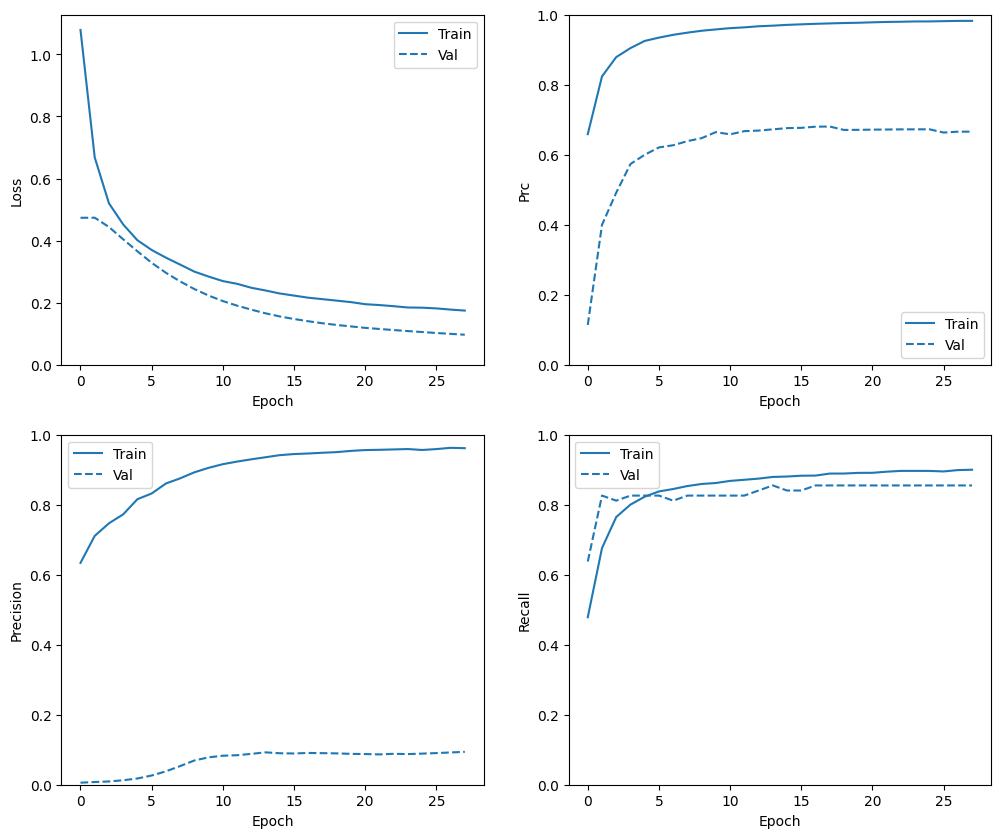

In [52]:
plot_metrics(resampled_history)

### メトリクスを評価する

In [53]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

 1/90 [..............................] - ETA: 8s

39/90 [============>.................] - ETA: 0s

80/90 [=========================>....] - ETA: 0s

90/90 [==============================] - 0s 1ms/step


 1/28 [>.............................] - ETA: 0s

28/28 [==============================] - 0s 1ms/step


loss :  0.13150924444198608
tp :  91.0
fp :  728.0
tn :  56133.0
fn :  10.0
accuracy :  0.9870439767837524
precision :  0.1111111119389534
recall :  0.9009901285171509
auc :  0.9749700427055359
prc :  0.7914559841156006

Legitimate Transactions Detected (True Negatives):  56133
Legitimate Transactions Incorrectly Detected (False Positives):  728
Fraudulent Transactions Missed (False Negatives):  10
Fraudulent Transactions Detected (True Positives):  91
Total Fraudulent Transactions:  101


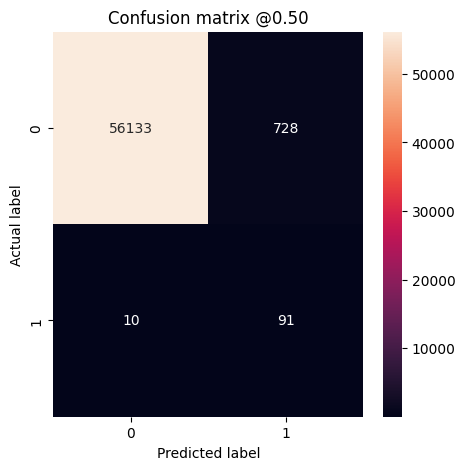

In [54]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

### ROC をプロットする

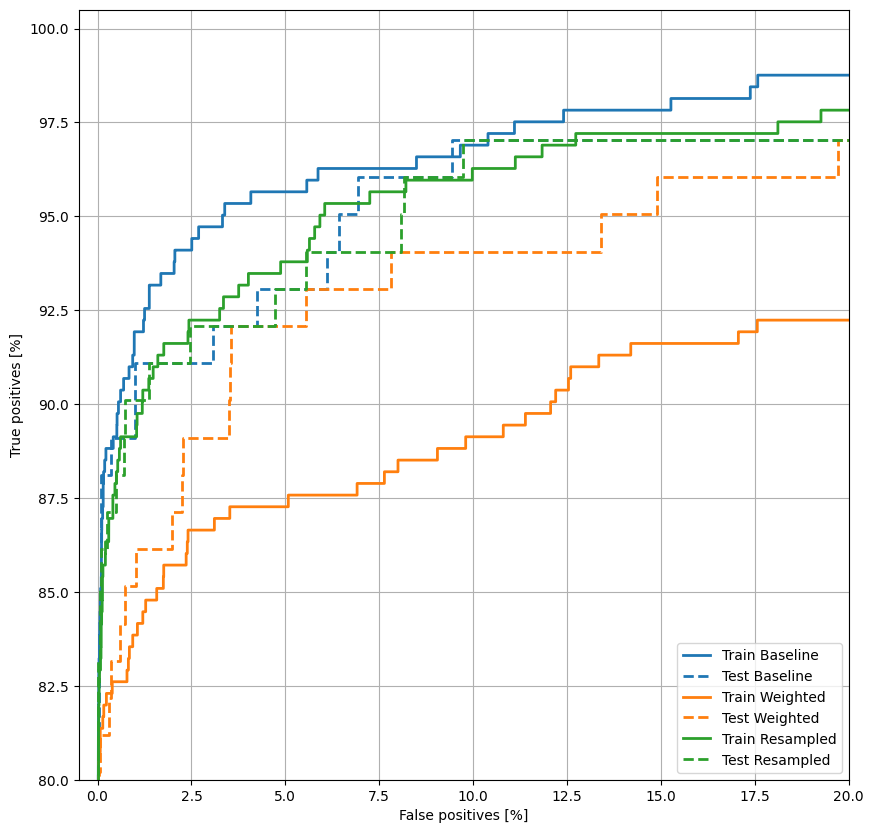

In [55]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

### AUPRC をプロットする


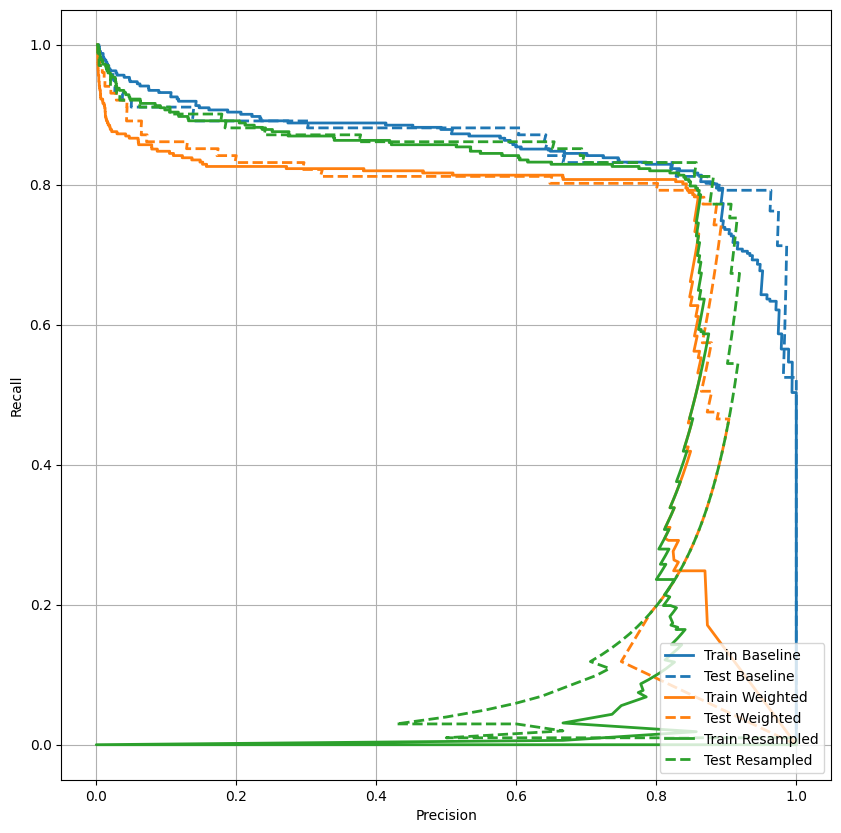

In [56]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_prc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_prc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

## このチュートリアルを問題に応用する

不均衡データの分類は、学習できるサンプルが非常に少ないため、本質的に難しい作業です。常に最初にデータから始め、できるだけ多くのサンプルを収集するよう最善を尽くし、モデルがマイノリティクラスを最大限に活用するのに適切な特徴はどれかを十分に検討する必要があります。ある時点では、モデルがなかなか改善せず望む結果をうまく生成できないことがあるので、問題のコンテキストおよび異なるタイプのエラー間のトレードオフを考慮することが重要です。